In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('/content/train_data.csv')
df_test = pd.read_csv('/content/test_data.csv')

In [ ]:
df = df.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'CDRSB', 'Current_Age'])
df_test = df_test.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'CDRSB', 'Current_Age'])

In [ ]:
df

,PTID,VISCODE2,MMSCORE,CDGLOBAL,CDRSB,Current_Age,DIAGNOSIS,GENOTYPE,VISCODE_NUM
0,002_S_0295,m06,28.0,0.0,0.0,85.34,1.0,4-Mar,6
1,002_S_0295,m12,30.0,0.0,0.0,85.84,1.0,4-Mar,12
2,002_S_0295,m24,29.0,0.0,0.0,86.84,1.0,4-Mar,24
3,002_S_0295,m36,28.0,0.0,0.0,87.84,1.0,4-Mar,36
4,002_S_0295,m48,26.0,0.0,0.0,88.84,1.0,4-Mar,48
...,...,...,...,...,...,...,...,...,...
7724,941_S_6854,m24,24.0,1.0,7.0,88.26,3.0,4-Mar,24
7725,941_S_6962,m12,7.0,2.0,13.0,75.69,3.0,4-Apr,12
7726,941_S_7046,m36,29.0,0.0,0.0,74.21,1.0,4-Mar,36
7727,941_S_7051,m24,27.0,0.5,0.5,65.76,2.0,3-Feb,24


In [ ]:
df = df.drop(columns=['GENOTYPE'])
df_test = df_test.drop(columns=['GENOTYPE'])

In [ ]:
unique_gen = df['GENOTYPE'].dropna().unique()
unique_gen_split = [gen.split('-') for gen in unique_gen]
unique_gen2 = df_test['GENOTYPE'].dropna().unique()
unique_gen_split2 = [gen.split('-') for gen in unique_gen2]

In [ ]:
# Replace month names with numbers
for i, sublist in enumerate(unique_gen_split):
    for j, item in enumerate(sublist):
        if item == 'Mar':
            unique_gen_split[i][j] = '3'
        elif item == 'Apr':
            unique_gen_split[i][j] = '4'
        elif item == 'Feb':
            unique_gen_split[i][j] = '2'
# Replace month names with numbers
for i, sublist in enumerate(unique_gen_split2):
    for j, item in enumerate(sublist):
        if item == 'Mar':
            unique_gen_split2[i][j] = '3'
        elif item == 'Apr':
            unique_gen_split2[i][j] = '4'
        elif item == 'Feb':
            unique_gen_split2[i][j] = '2'


In [ ]:
# Join each sublist with a '/'
joined_gen = ['/'.join(sublist) for sublist in unique_gen_split]
print(joined_gen)
# Join each sublist with a '/'
joined_gen2 = ['/'.join(sublist) for sublist in unique_gen_split2]
print(joined_gen)


['4/3', '4/4', '3/3', '3/2', '4/2', '2/2']
['4/3', '4/4', '3/3', '3/2', '4/2', '2/2']


In [ ]:
df['GENOTYPE'] = df['GENOTYPE'].dropna()
df_test['GENOTYPE'] = df_test['GENOTYPE'].dropna()

In [ ]:
# Step 2: Split and replace month names with numbers
replacement_map = {}

for gen in unique_gen:
    parts = gen.split('-')
    month_map = {'Mar': '3', 'Apr': '4', 'Feb': '2'}
    parts = [month_map.get(p, p) for p in parts]  # Replace month if matched
    new_val = '/'.join(parts)
    replacement_map[gen] = new_val

# Step 3: Replace in the DataFrame
df['GENOTYPE'] = df['GENOTYPE'].replace(replacement_map)

# Step 2: Split and replace month names with numbers
replacement_map = {}

for gen in unique_gen2:
    parts = gen.split('-')
    month_map = {'Mar': '3', 'Apr': '4', 'Feb': '2'}
    parts = [month_map.get(p, p) for p in parts]  # Replace month if matched
    new_val = '/'.join(parts)
    replacement_map[gen] = new_val

# Step 3: Replace in the DataFrame
df_test['GENOTYPE'] = df_test['GENOTYPE'].replace(replacement_map)

In [ ]:
df = df.dropna(subset=['GENOTYPE'])
df_test = df_test.dropna(subset=['GENOTYPE'])

In [ ]:
df['GENOTYPE'].unique()
df_test['GENOTYPE'].unique()

array(['3/3', '4/4', '4/3', '3/2', '4/2', '2/2'], dtype=object)

In [ ]:
# Split the genotype into two separate alleles
df[['ALLELE1', 'ALLELE2']] = df['GENOTYPE'].str.split('/', expand=True).astype(int)

# Add numeric sum or indicator for presence of high-risk ε4 allele
df['APOE_sum'] = df['ALLELE1'] + df['ALLELE2']
df['has_e4'] = ((df['ALLELE1'] == 4) | (df['ALLELE2'] == 4)).astype(int)

# Risk maps
risk_map = {
    '2/2': 0,  '2/3': 0,  '3/3': 1,  '2/4': 2,
    '3/4': 2,  '4/4': 3,  '3/2': 0,  '4/2': 2, '4/3': 2
}
df['APOE_risk_level'] = df['GENOTYPE'].map(risk_map)


# Split the genotype into two separate alleles
df_test[['ALLELE1', 'ALLELE2']] = df_test['GENOTYPE'].str.split('/', expand=True).astype(int)

# Add numeric sum or indicator for presence of high-risk ε4 allele
df_test['APOE_sum'] = df_test['ALLELE1'] + df_test['ALLELE2']
df_test['has_e4'] = ((df_test['ALLELE1'] == 4) | (df_test['ALLELE2'] == 4)).astype(int)

# Risk maps
risk_map = {
    '2/2': 0,  '2/3': 0,  '3/3': 1,  '2/4': 2,
    '3/4': 2,  '4/4': 3,  '3/2': 0,  '4/2': 2, '4/3': 2
}
df_test['APOE_risk_level'] = df_test['GENOTYPE'].map(risk_map)


In [ ]:
df

,PTID,VISCODE2,MMSCORE,CDGLOBAL,CDRSB,Current_Age,DIAGNOSIS,GENOTYPE,ALLELE1,ALLELE2,APOE_sum,has_e4,APOE_risk_level
0,029_S_4279,m06,29.0,0.0,0.0,84.24,1.0,3/3,3,3,6,0,1
1,023_S_1126,m18,25.0,0.5,3.0,81.97,3.0,3/3,3,3,6,0,1
2,137_S_0631,m12,21.0,1.0,8.0,78.16,3.0,4/3,4,3,7,1,2
3,123_S_0390,m24,23.0,0.5,3.0,82.49,3.0,4/3,4,3,7,1,2
4,012_S_0689,m12,17.0,0.5,4.0,64.64,3.0,4/4,4,4,8,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8058,021_S_0159,m12,30.0,0.0,0.0,78.88,1.0,3/3,3,3,6,0,1
8059,068_S_0473,m48,29.0,0.0,0.0,76.63,1.0,4/3,4,3,7,1,2
8060,007_S_4620,m06,29.0,0.0,0.0,77.63,1.0,3/3,3,3,6,0,1
8061,067_S_0056,m96,29.0,0.0,0.0,77.65,1.0,3/2,3,2,5,0,0


In [ ]:
df_test

,PTID,VISCODE2,MMSCORE,CDGLOBAL,CDRSB,Current_Age,DIAGNOSIS,GENOTYPE,ALLELE1,ALLELE2,APOE_sum,has_e4,APOE_risk_level
0,016_S_5057,m96,18.0,2.0,12.0,83.28,3.0,3/2,3,2,5,0,0
1,035_S_6480,m12,29.0,0.5,1.5,80.90,2.0,4/3,4,3,7,1,2
2,128_S_0225,m24,29.0,0.0,0.0,84.36,2.0,3/3,3,3,6,0,1
3,137_S_0158,m12,29.0,0.5,2.0,81.50,2.0,3/2,3,2,5,0,0
4,109_S_4380,m72,28.0,0.5,1.5,77.89,2.0,3/2,3,2,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,024_S_6184,m24,30.0,0.0,0.0,72.55,1.0,3/3,3,3,6,0,1
1419,168_S_6320,m30,29.0,0.0,0.0,67.87,1.0,3/3,3,3,6,0,1
1420,006_S_1130,m36,27.0,1.0,4.5,74.14,3.0,4/3,4,3,7,1,2
1421,073_S_4155,m12,30.0,0.0,0.0,78.65,1.0,4/3,4,3,7,1,2


In [ ]:
# change viscode to time number as m06 to 6 months and so on
df['VISCODE2'] = df['VISCODE2'].replace({'m06': 6, 'm12': 12, 'm18': 18, 'm24': 24, 'm36': 36, 'm48': 48, 'm60': 60, 'm72': 72, 'm108': 108, 'm132': 132,
       'm162': 162, 'm84': 84, 'm96': 96, 'f': 2, 'm18': 18, 'm126': 126, 'm138': 138, 'm150': 150, 'm120': 120,
       'm144': 144, 'm156': 156, 'm210': 210, 'm78': 78, 'm90': 90, 'm180': 180, 'm192': 192, 'm204': 204,
       'm222': 222, 'm174': 174, 'm186': 186, 'm114': 114, 'm66': 66, 'm102': 102, 'm54': 54, 'm42': 42, 'm30': 30,
       'm216': 216, 'm228': 228, 'm168': 168, 'm198': 198})

# change viscode to time number as m06 to 6 months and so on
df_test['VISCODE2'] = df_test['VISCODE2'].replace({'m06': 6, 'm12': 12, 'm18': 18, 'm24': 24, 'm36': 36, 'm48': 48, 'm60': 60, 'm72': 72, 'm108': 108, 'm132': 132,
       'm162': 162, 'm84': 84, 'm96': 96, 'f': 2, 'm18': 18, 'm126': 126, 'm138': 138, 'm150': 150, 'm120': 120,
       'm144': 144, 'm156': 156, 'm210': 210, 'm78': 78, 'm90': 90, 'm180': 180, 'm192': 192, 'm204': 204,
       'm222': 222, 'm174': 174, 'm186': 186, 'm114': 114, 'm66': 66, 'm102': 102, 'm54': 54, 'm42': 42, 'm30': 30,
       'm216': 216, 'm228': 228, 'm168': 168, 'm198': 198})



<ipython-input-12-b468bbce29fc>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VISCODE2'] = df['VISCODE2'].replace({'m06': 6, 'm12': 12, 'm18': 18, 'm24': 24, 'm36': 36, 'm48': 48, 'm60': 60, 'm72': 72, 'm108': 108, 'm132': 132,
<ipython-input-12-b468bbce29fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['VISCODE2'] = df['VISCODE2'].replace({'m06': 6, 'm12': 12, 'm18': 18, 'm24': 24, 'm36': 36, 'm48': 48, 'm60': 60, 'm72': 72, 'm108': 108, 'm132': 132,
<ipython-input-12-b468bbce29fc>:9: FutureWarning: Down

In [ ]:
# sort based on ptid and viscode
df = df.sort_values(by=['PTID', 'VISCODE2'])
df_test = df_test.sort_values(by=['PTID', 'VISCODE2'])

In [ ]:
df = df.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'CDRSB', 'Current_Age', 'ALLELE1', 'ALLELE2', 'APOE_sum', 'has_e4', 'APOE_risk_level'])
df_test = df_test.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'CDRSB', 'Current_Age', 'ALLELE1', 'ALLELE2', 'APOE_sum', 'has_e4', 'APOE_risk_level'])

In [ ]:
df.isna().sum()


,0
PTID,0
VISCODE2,0
MMSCORE,0
CDGLOBAL,0
CDRSB,0
Current_Age,0
DIAGNOSIS,0
GENOTYPE,0
ALLELE1,0
ALLELE2,0


In [ ]:
df_test.isna().sum()

,0
PTID,0
VISCODE2,0
MMSCORE,0
CDGLOBAL,0
CDRSB,0
Current_Age,0
DIAGNOSIS,0
GENOTYPE,0
ALLELE1,0
ALLELE2,0


In [ ]:
df = df.drop(columns=['PTID'])

In [ ]:
df_test = df_test.drop(columns=['PTID'])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
labels = df['DIAGNOSIS']
df = df.drop(columns=['DIAGNOSIS'])

labels_test = df_test['DIAGNOSIS']
df_test = df_test.drop(columns=['DIAGNOSIS'])

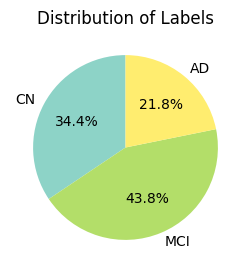

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'labels' are encoded as 0: CN, 1: MCI, 2: AD
label_mapping = {1: 'CN', 2: 'MCI', 3: 'AD'}

# Convert labels to a Pandas Series
labels_series = pd.Series(labels)

# Get the value counts and map to original labels
counts = labels_series.value_counts().sort_index()
counts.index = counts.index.map(label_mapping)

# Plot the pie chart
plt.figure(figsize=(6, 3))
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.title("Distribution of Labels")
plt.ylabel('')  # Hide the y-label
plt.show()


In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
print("df shape:", df.shape)
print("labels length:", len(labels))

print("df_test shape:", df_test.shape)
print("labels_test length:", len(labels_test))

df shape: (7439, 6)
labels length: 7439
df_test shape: (1807, 6)
labels_test length: 1807


In [ ]:
df = df.drop(columns=['GENOTYPE'])
df_test = df_test.drop(columns=['GENOTYPE'])

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

label_encoder = LabelEncoder()
y = labels
# Fit and transform your labels
y_encoded = label_encoder.fit_transform(y)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_index, val_index in skf.split(df.values, labels):
    print(f"\n===== Fold {fold} =====")

    X_train_fold, X_val_fold = df.values[train_index], df.values[val_index]
    y_train_fold, y_val_fold = labels[train_index], labels[val_index]

    # Encode fold labels
    y_train_fold_enc = label_encoder.transform(y_train_fold)
    y_val_fold_enc = label_encoder.transform(y_val_fold)

    # Compute class weights for the fold
    class_weights_fold = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train_fold_enc),
        y=y_train_fold_enc
    )
    class_weight_dict_fold = {
        cls: weight for cls, weight in zip(np.unique(y_train_fold_enc), class_weights_fold)
    }

    # Train the model for this fold
    clf = TabNetClassifier(
        n_d=32,
        n_a=32,
        n_steps=5,
        n_independent=3,
        n_shared=5,
        gamma=1.3,
        lambda_sparse=0.001,
        optimizer_params={"lr": 0.01},
        scheduler_params={"step_size": 5, "gamma": 0.8},
        mask_type="entmax",
    )

    clf.fit(
        X_train_fold, y_train_fold_enc,
        max_epochs=100,
        batch_size=512,
        virtual_batch_size=32,
        patience=10,
        eval_set=[(X_val_fold, y_val_fold_enc)],
        weights=class_weight_dict_fold,
        drop_last=False,
    )

    y_pred_fold = clf.predict(X_val_fold)
    acc = accuracy_score(y_val_fold_enc, y_pred_fold)
    all_fold_accuracies.append(acc)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(classification_report(y_val_fold_enc, y_pred_fold, target_names=[str(cls) for cls in label_encoder.classes_]))

    fold += 1

print(f"\n Mean CV Accuracy: {np.mean(all_fold_accuracies):.4f}")



===== Fold 1 =====


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14129 | val_0_accuracy: 0.44381 |  0:00:02s
epoch 1  | loss: 0.66746 | val_0_accuracy: 0.42278 |  0:00:04s
epoch 2  | loss: 0.52696 | val_0_accuracy: 0.49924 |  0:00:07s
epoch 3  | loss: 0.45798 | val_0_accuracy: 0.32454 |  0:00:09s
epoch 4  | loss: 0.44026 | val_0_accuracy: 0.35359 |  0:00:12s
epoch 5  | loss: 0.47885 | val_0_accuracy: 0.44763 |  0:00:14s
epoch 6  | loss: 0.41777 | val_0_accuracy: 0.55084 |  0:00:16s
epoch 7  | loss: 0.41684 | val_0_accuracy: 0.55428 |  0:00:19s
epoch 8  | loss: 0.4107  | val_0_accuracy: 0.55352 |  0:00:22s
epoch 9  | loss: 0.3813  | val_0_accuracy: 0.57645 |  0:00:24s
epoch 10 | loss: 0.37738 | val_0_accuracy: 0.58792 |  0:00:26s
epoch 11 | loss: 0.37836 | val_0_accuracy: 0.81231 |  0:00:28s
epoch 12 | loss: 0.38082 | val_0_accuracy: 0.62997 |  0:00:31s
epoch 13 | loss: 0.3729  | val_0_accuracy: 0.85512 |  0:00:34s
epoch 14 | loss: 0.38043 | val_0_accuracy: 0.78593 |  0:00:36s
epoch 15 | loss: 0.3869  | val_0_accuracy: 0.83983 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 1 Accuracy: 0.8639
              precision    recall  f1-score   support

         1.0       0.90      0.90      0.90       925
         2.0       0.83      0.86      0.84      1117
         3.0       0.88      0.81      0.85       574

    accuracy                           0.86      2616
   macro avg       0.87      0.86      0.86      2616
weighted avg       0.86      0.86      0.86      2616


===== Fold 2 =====


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.18471 | val_0_accuracy: 0.34748 |  0:00:02s
epoch 1  | loss: 0.66262 | val_0_accuracy: 0.6078  |  0:00:04s
epoch 2  | loss: 0.51703 | val_0_accuracy: 0.21942 |  0:00:06s
epoch 3  | loss: 0.48728 | val_0_accuracy: 0.31078 |  0:00:09s
epoch 4  | loss: 0.46745 | val_0_accuracy: 0.22057 |  0:00:11s
epoch 5  | loss: 0.4378  | val_0_accuracy: 0.28058 |  0:00:14s
epoch 6  | loss: 0.41139 | val_0_accuracy: 0.26491 |  0:00:16s
epoch 7  | loss: 0.387   | val_0_accuracy: 0.41284 |  0:00:20s
epoch 8  | loss: 0.4005  | val_0_accuracy: 0.79893 |  0:00:25s
epoch 9  | loss: 0.3961  | val_0_accuracy: 0.8318  |  0:00:27s
epoch 10 | loss: 0.40398 | val_0_accuracy: 0.81766 |  0:00:29s
epoch 11 | loss: 0.38463 | val_0_accuracy: 0.85359 |  0:00:31s
epoch 12 | loss: 0.38102 | val_0_accuracy: 0.77332 |  0:00:35s
epoch 13 | loss: 0.37901 | val_0_accuracy: 0.74924 |  0:00:39s
epoch 14 | loss: 0.37643 | val_0_accuracy: 0.85703 |  0:00:41s
epoch 15 | loss: 0.37512 | val_0_accuracy: 0.85054 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 2 Accuracy: 0.8754
              precision    recall  f1-score   support

         1.0       0.90      0.91      0.91       925
         2.0       0.84      0.88      0.86      1117
         3.0       0.91      0.81      0.86       574

    accuracy                           0.88      2616
   macro avg       0.88      0.87      0.87      2616
weighted avg       0.88      0.88      0.88      2616


===== Fold 3 =====


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15199 | val_0_accuracy: 0.35703 |  0:00:02s
epoch 1  | loss: 0.63603 | val_0_accuracy: 0.237   |  0:00:05s
epoch 2  | loss: 0.53878 | val_0_accuracy: 0.44648 |  0:00:07s
epoch 3  | loss: 0.49091 | val_0_accuracy: 0.38456 |  0:00:09s
epoch 4  | loss: 0.43696 | val_0_accuracy: 0.40176 |  0:00:11s
epoch 5  | loss: 0.43171 | val_0_accuracy: 0.49541 |  0:00:14s
epoch 6  | loss: 0.43311 | val_0_accuracy: 0.50879 |  0:00:17s
epoch 7  | loss: 0.4037  | val_0_accuracy: 0.59748 |  0:00:19s
epoch 8  | loss: 0.4006  | val_0_accuracy: 0.80581 |  0:00:21s
epoch 9  | loss: 0.39895 | val_0_accuracy: 0.65214 |  0:00:23s
epoch 10 | loss: 0.38742 | val_0_accuracy: 0.80084 |  0:00:26s
epoch 11 | loss: 0.3694  | val_0_accuracy: 0.81346 |  0:00:29s
epoch 12 | loss: 0.37931 | val_0_accuracy: 0.80696 |  0:00:31s
epoch 13 | loss: 0.358   | val_0_accuracy: 0.862   |  0:00:33s
epoch 14 | loss: 0.363   | val_0_accuracy: 0.84251 |  0:00:35s
epoch 15 | loss: 0.37271 | val_0_accuracy: 0.84939 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 3 Accuracy: 0.8761
              precision    recall  f1-score   support

         1.0       0.90      0.92      0.91       924
         2.0       0.86      0.86      0.86      1118
         3.0       0.88      0.84      0.86       574

    accuracy                           0.88      2616
   macro avg       0.88      0.87      0.88      2616
weighted avg       0.88      0.88      0.88      2616


 Mean CV Accuracy: 0.8718


TabNet Classifier Accuracy 0.8667
Class: CN
  Precision: 0.8922
  Recall: 0.9104
  F1-score: 0.9012
------------------------------
Class: MCI
  Precision: 0.8397
  Recall: 0.8497
  F1-score: 0.8447
------------------------------
Class: AD
  Precision: 0.8785
  Recall: 0.8295
  F1-score: 0.8533
------------------------------
Confusion Matrix:


<Axes: >

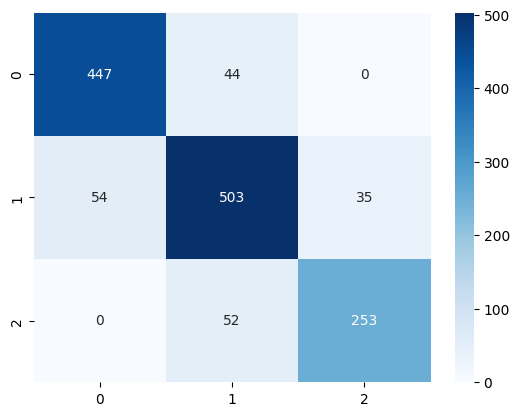

In [ ]:
# give precision and recall and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

labels_test = np.array(labels_test).ravel()  # Ensure y is 1D
label_encoder = LabelEncoder()
label_encoder.fit(labels_test)

X_test = df_test
y_test = label_encoder.transform(labels_test)

# Predict and Evaluate
y_pred = clf.predict(X_test.values)
accuracy = accuracy_score(y_test, y_pred)
print(f"TabNet Classifier Accuracy {accuracy:.4f}")


# Get precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Print results
class_labels = ["CN", "MCI", "AD"]
for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print("-" * 30)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [ ]:
# Extract TP, TN, FP, FN for each class
sensitivity = {}  # Recall per class
specificity = {}  # Specificity per class

for i, label in enumerate(clf.classes_):
    TP = cm[i, i]  # True Positives
    FN = sum(cm[i, :]) - TP  # False Negatives
    FP = sum(cm[:, i]) - TP  # False Positives
    TN = sum(sum(cm)) - (TP + FN + FP)  # True Negatives

    sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall
    specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity

# Print results
for label in clf.classes_:
    print(f"Class: {label}")
    print(f"  Sensitivity (Recall): {sensitivity[label]:.4f}")
    print(f"  Specificity: {specificity[label]:.4f}")
    print("-" * 30)

Class: 0
  Sensitivity (Recall): 0.9104
  Specificity: 0.9398
------------------------------
Class: 1
  Sensitivity (Recall): 0.8497
  Specificity: 0.8794
------------------------------
Class: 2
  Sensitivity (Recall): 0.8295
  Specificity: 0.9677
------------------------------


In [ ]:
clf.save_model("/content/new_Areeba_sent_train_test_one_v2_good")


Successfully saved model at /content/new_Areeba_sent_train_test_one_v2_good.zip


'/content/new_Areeba_sent_train_test_one_v2_good.zip'

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df, labels, test_size=0.2, random_state=42)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np

class TabNetWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_d=8, n_a=8, n_steps=3, gamma=1.5, lambda_sparse=1e-3,
                 n_independent=2, n_shared=2, optimizer_params=None, scheduler_params=None):
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse
        self.n_independent = n_independent
        self.n_shared = n_shared
        self.optimizer_params = optimizer_params or {"lr": 2e-2}
        self.scheduler_params = scheduler_params or {"step_size": 10, "gamma": 0.9}
        self.model = None

    def fit(self, X, y):
        self.model = TabNetClassifier(
            n_d=self.n_d, n_a=self.n_a, n_steps=self.n_steps,
            gamma=self.gamma, lambda_sparse=self.lambda_sparse,
            n_independent=self.n_independent, n_shared=self.n_shared,
            optimizer_params=self.optimizer_params,
            scheduler_params=self.scheduler_params,
            mask_type="entmax"
        )

        self.model.fit(
            X, y,
            max_epochs=100,
            batch_size=512,
            virtual_batch_size=32,
            patience=10,
            eval_set=[(X_val.values, y_val)],
            weights=class_weight_dict,
            drop_last=False
        )
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return (self.predict(X) == y).mean()

    def get_params(self, deep=True):
        return {
            "n_d": self.n_d,
            "n_a": self.n_a,
            "n_steps": self.n_steps,
            "gamma": self.gamma,
            "lambda_sparse": self.lambda_sparse,
            "n_independent": self.n_independent,
            "n_shared": self.n_shared,
            "optimizer_params": self.optimizer_params,
            "scheduler_params": self.scheduler_params
        }
    def get_model(self):
        return self.model


In [ ]:
param_grid = {
    'n_d': [32],
    'n_a': [32],
    'n_steps': [5],
    'gamma': [1.3, 1.5],
    'lambda_sparse': [1e-3, 1e-4],
    'n_independent': [2, 3, 4],
    'n_shared': [7, 6, 5],
    'optimizer_params': [{'lr': 1e-2}, {'lr': 1e-3}],
    'scheduler_params': [{'step_size': 5, 'gamma': 0.8}, {'step_size': 10, 'gamma': 0.9}]

}


In [ ]:
from sklearn.model_selection import GridSearchCV

tabnet_estimator = TabNetWrapper()
grid_search = GridSearchCV(
    estimator=tabnet_estimator,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2
)

grid_search.fit(X_train.values, y_train)


Fitting 3 folds for each of 144 candidates, totalling 432 fits


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.6802  | val_0_accuracy: 0.35223 |  0:00:03s
epoch 1  | loss: 0.87606 | val_0_accuracy: 0.37771 |  0:00:05s
epoch 2  | loss: 0.68018 | val_0_accuracy: 0.35987 |  0:00:07s
epoch 3  | loss: 0.56106 | val_0_accuracy: 0.3172  |  0:00:09s
epoch 4  | loss: 0.53237 | val_0_accuracy: 0.41083 |  0:00:11s
epoch 5  | loss: 0.48773 | val_0_accuracy: 0.4535  |  0:00:13s
epoch 6  | loss: 0.45391 | val_0_accuracy: 0.56815 |  0:00:16s
epoch 7  | loss: 0.44146 | val_0_accuracy: 0.50573 |  0:00:18s
epoch 8  | loss: 0.43114 | val_0_accuracy: 0.43057 |  0:00:20s
epoch 9  | loss: 0.43537 | val_0_accuracy: 0.50382 |  0:00:22s
epoch 10 | loss: 0.42514 | val_0_accuracy: 0.63312 |  0:00:24s
epoch 11 | loss: 0.40741 | val_0_accuracy: 0.72803 |  0:00:26s
epoch 12 | loss: 0.40327 | val_0_accuracy: 0.78217 |  0:00:28s
epoch 13 | loss: 0.41357 | val_0_accuracy: 0.82102 |  0:00:31s
epoch 14 | loss: 0.39538 | val_0_accuracy: 0.5707  |  0:00:33s
epoch 15 | loss: 0.43223 | val_0_accuracy: 0.76051 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.73829 | val_0_accuracy: 0.40255 |  0:00:02s
epoch 1  | loss: 0.92277 | val_0_accuracy: 0.43248 |  0:00:04s
epoch 2  | loss: 0.69891 | val_0_accuracy: 0.42293 |  0:00:06s
epoch 3  | loss: 0.54918 | val_0_accuracy: 0.32293 |  0:00:08s
epoch 4  | loss: 0.52804 | val_0_accuracy: 0.4242  |  0:00:10s
epoch 5  | loss: 0.46509 | val_0_accuracy: 0.49936 |  0:00:12s
epoch 6  | loss: 0.47775 | val_0_accuracy: 0.46624 |  0:00:14s
epoch 7  | loss: 0.44323 | val_0_accuracy: 0.46242 |  0:00:16s
epoch 8  | loss: 0.43536 | val_0_accuracy: 0.60573 |  0:00:18s
epoch 9  | loss: 0.39098 | val_0_accuracy: 0.65732 |  0:00:20s
epoch 10 | loss: 0.42976 | val_0_accuracy: 0.56752 |  0:00:22s
epoch 11 | loss: 0.40705 | val_0_accuracy: 0.54013 |  0:00:24s
epoch 12 | loss: 0.40628 | val_0_accuracy: 0.66815 |  0:00:27s
epoch 13 | loss: 0.41659 | val_0_accuracy: 0.78726 |  0:00:29s
epoch 14 | loss: 0.38966 | val_0_accuracy: 0.68217 |  0:00:31s
epoch 15 | loss: 0.40603 | val_0_accuracy: 0.80191 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.73185 | val_0_accuracy: 0.31274 |  0:00:01s
epoch 1  | loss: 0.85988 | val_0_accuracy: 0.3465  |  0:00:03s
epoch 2  | loss: 0.70205 | val_0_accuracy: 0.36815 |  0:00:06s
epoch 3  | loss: 0.60398 | val_0_accuracy: 0.26688 |  0:00:08s
epoch 4  | loss: 0.57338 | val_0_accuracy: 0.42994 |  0:00:10s
epoch 5  | loss: 0.54388 | val_0_accuracy: 0.55669 |  0:00:12s
epoch 6  | loss: 0.49772 | val_0_accuracy: 0.38344 |  0:00:14s
epoch 7  | loss: 0.46896 | val_0_accuracy: 0.5242  |  0:00:16s
epoch 8  | loss: 0.46901 | val_0_accuracy: 0.39618 |  0:00:18s
epoch 9  | loss: 0.45899 | val_0_accuracy: 0.57898 |  0:00:21s
epoch 10 | loss: 0.42681 | val_0_accuracy: 0.7     |  0:00:23s
epoch 11 | loss: 0.41933 | val_0_accuracy: 0.62611 |  0:00:25s
epoch 12 | loss: 0.39104 | val_0_accuracy: 0.58471 |  0:00:27s
epoch 13 | loss: 0.42185 | val_0_accuracy: 0.61338 |  0:00:29s
epoch 14 | loss: 0.40347 | val_0_accuracy: 0.77261 |  0:00:31s
epoch 15 | loss: 0.40075 | val_0_accuracy: 0.75796 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.6802  | val_0_accuracy: 0.35223 |  0:00:01s
epoch 1  | loss: 0.87606 | val_0_accuracy: 0.37771 |  0:00:04s
epoch 2  | loss: 0.68018 | val_0_accuracy: 0.35987 |  0:00:06s
epoch 3  | loss: 0.56106 | val_0_accuracy: 0.3172  |  0:00:08s
epoch 4  | loss: 0.53237 | val_0_accuracy: 0.41083 |  0:00:10s
epoch 5  | loss: 0.48773 | val_0_accuracy: 0.4535  |  0:00:12s
epoch 6  | loss: 0.45391 | val_0_accuracy: 0.56815 |  0:00:15s
epoch 7  | loss: 0.44146 | val_0_accuracy: 0.50573 |  0:00:16s
epoch 8  | loss: 0.43114 | val_0_accuracy: 0.43057 |  0:00:20s
epoch 9  | loss: 0.43537 | val_0_accuracy: 0.50382 |  0:00:22s
epoch 10 | loss: 0.42514 | val_0_accuracy: 0.63312 |  0:00:24s
epoch 11 | loss: 0.40741 | val_0_accuracy: 0.72803 |  0:00:26s
epoch 12 | loss: 0.40327 | val_0_accuracy: 0.78217 |  0:00:28s
epoch 13 | loss: 0.41357 | val_0_accuracy: 0.82102 |  0:00:30s
epoch 14 | loss: 0.39538 | val_0_accuracy: 0.5707  |  0:00:33s
epoch 15 | loss: 0.43223 | val_0_accuracy: 0.76051 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.73829 | val_0_accuracy: 0.40255 |  0:00:01s
epoch 1  | loss: 0.92277 | val_0_accuracy: 0.43248 |  0:00:04s
epoch 2  | loss: 0.69891 | val_0_accuracy: 0.42293 |  0:00:06s
epoch 3  | loss: 0.54918 | val_0_accuracy: 0.32293 |  0:00:08s
epoch 4  | loss: 0.52804 | val_0_accuracy: 0.4242  |  0:00:10s
epoch 5  | loss: 0.46509 | val_0_accuracy: 0.49936 |  0:00:12s
epoch 6  | loss: 0.47775 | val_0_accuracy: 0.46624 |  0:00:14s
epoch 7  | loss: 0.44323 | val_0_accuracy: 0.46242 |  0:00:16s
epoch 8  | loss: 0.43536 | val_0_accuracy: 0.60573 |  0:00:19s
epoch 9  | loss: 0.39098 | val_0_accuracy: 0.65732 |  0:00:21s
epoch 10 | loss: 0.42976 | val_0_accuracy: 0.56752 |  0:00:23s
epoch 11 | loss: 0.40705 | val_0_accuracy: 0.54013 |  0:00:25s
epoch 12 | loss: 0.40628 | val_0_accuracy: 0.66815 |  0:00:27s
epoch 13 | loss: 0.41659 | val_0_accuracy: 0.78726 |  0:00:29s
epoch 14 | loss: 0.38966 | val_0_accuracy: 0.68217 |  0:00:32s
epoch 15 | loss: 0.40603 | val_0_accuracy: 0.80191 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.73185 | val_0_accuracy: 0.31274 |  0:00:01s
epoch 1  | loss: 0.85988 | val_0_accuracy: 0.3465  |  0:00:03s
epoch 2  | loss: 0.70205 | val_0_accuracy: 0.36815 |  0:00:05s
epoch 3  | loss: 0.60398 | val_0_accuracy: 0.26688 |  0:00:08s
epoch 4  | loss: 0.57338 | val_0_accuracy: 0.42994 |  0:00:10s
epoch 5  | loss: 0.54388 | val_0_accuracy: 0.55669 |  0:00:12s
epoch 6  | loss: 0.49772 | val_0_accuracy: 0.38344 |  0:00:15s
epoch 7  | loss: 0.46896 | val_0_accuracy: 0.5242  |  0:00:17s
epoch 8  | loss: 0.46901 | val_0_accuracy: 0.39618 |  0:00:19s
epoch 9  | loss: 0.45899 | val_0_accuracy: 0.57898 |  0:00:21s
epoch 10 | loss: 0.42681 | val_0_accuracy: 0.7     |  0:00:24s
epoch 11 | loss: 0.41933 | val_0_accuracy: 0.62611 |  0:00:26s
epoch 12 | loss: 0.39104 | val_0_accuracy: 0.58471 |  0:00:28s
epoch 13 | loss: 0.42185 | val_0_accuracy: 0.61338 |  0:00:30s
epoch 14 | loss: 0.40347 | val_0_accuracy: 0.77261 |  0:00:32s
epoch 15 | loss: 0.40075 | val_0_accuracy: 0.75796 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.8298  | val_0_accuracy: 0.45287 |  0:00:01s
epoch 1  | loss: 2.35654 | val_0_accuracy: 0.41592 |  0:00:03s
epoch 2  | loss: 1.90608 | val_0_accuracy: 0.36879 |  0:00:05s
epoch 3  | loss: 1.61639 | val_0_accuracy: 0.31274 |  0:00:08s
epoch 4  | loss: 1.45516 | val_0_accuracy: 0.36943 |  0:00:10s
epoch 5  | loss: 1.30073 | val_0_accuracy: 0.35223 |  0:00:12s
epoch 6  | loss: 1.21772 | val_0_accuracy: 0.31465 |  0:00:14s
epoch 7  | loss: 1.1061  | val_0_accuracy: 0.33185 |  0:00:16s
epoch 8  | loss: 1.04979 | val_0_accuracy: 0.35478 |  0:00:18s
epoch 9  | loss: 0.9769  | val_0_accuracy: 0.28981 |  0:00:20s
epoch 10 | loss: 0.9424  | val_0_accuracy: 0.34841 |  0:00:23s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.45287


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  24.3s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.89792 | val_0_accuracy: 0.38981 |  0:00:01s
epoch 1  | loss: 2.34819 | val_0_accuracy: 0.33631 |  0:00:03s
epoch 2  | loss: 1.89838 | val_0_accuracy: 0.37006 |  0:00:05s
epoch 3  | loss: 1.62812 | val_0_accuracy: 0.28217 |  0:00:08s
epoch 4  | loss: 1.38943 | val_0_accuracy: 0.32803 |  0:00:10s
epoch 5  | loss: 1.30638 | val_0_accuracy: 0.28917 |  0:00:12s
epoch 6  | loss: 1.16942 | val_0_accuracy: 0.32102 |  0:00:14s
epoch 7  | loss: 1.07051 | val_0_accuracy: 0.35669 |  0:00:16s
epoch 8  | loss: 1.01457 | val_0_accuracy: 0.26943 |  0:00:18s
epoch 9  | loss: 0.97826 | val_0_accuracy: 0.35287 |  0:00:21s
epoch 10 | loss: 0.89666 | val_0_accuracy: 0.32229 |  0:00:23s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.38981


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  24.8s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.87924 | val_0_accuracy: 0.34968 |  0:00:02s
epoch 1  | loss: 2.36523 | val_0_accuracy: 0.39108 |  0:00:04s
epoch 2  | loss: 1.95712 | val_0_accuracy: 0.43439 |  0:00:06s
epoch 3  | loss: 1.69627 | val_0_accuracy: 0.31338 |  0:00:08s
epoch 4  | loss: 1.43325 | val_0_accuracy: 0.35159 |  0:00:10s
epoch 5  | loss: 1.32142 | val_0_accuracy: 0.35223 |  0:00:12s
epoch 6  | loss: 1.223   | val_0_accuracy: 0.33694 |  0:00:14s
epoch 7  | loss: 1.10698 | val_0_accuracy: 0.30764 |  0:00:16s
epoch 8  | loss: 1.04458 | val_0_accuracy: 0.27006 |  0:00:18s
epoch 9  | loss: 0.98226 | val_0_accuracy: 0.28408 |  0:00:20s
epoch 10 | loss: 0.9499  | val_0_accuracy: 0.36815 |  0:00:23s
epoch 11 | loss: 0.95008 | val_0_accuracy: 0.3414  |  0:00:25s
epoch 12 | loss: 0.8719  | val_0_accuracy: 0.36306 |  0:00:27s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_accuracy = 0.43439


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  28.5s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.8298  | val_0_accuracy: 0.45287 |  0:00:01s
epoch 1  | loss: 2.35654 | val_0_accuracy: 0.41592 |  0:00:03s
epoch 2  | loss: 1.90608 | val_0_accuracy: 0.36879 |  0:00:06s
epoch 3  | loss: 1.61639 | val_0_accuracy: 0.31274 |  0:00:08s
epoch 4  | loss: 1.45516 | val_0_accuracy: 0.36943 |  0:00:10s
epoch 5  | loss: 1.30073 | val_0_accuracy: 0.35223 |  0:00:12s
epoch 6  | loss: 1.21772 | val_0_accuracy: 0.31465 |  0:00:14s
epoch 7  | loss: 1.1061  | val_0_accuracy: 0.33185 |  0:00:16s
epoch 8  | loss: 1.04979 | val_0_accuracy: 0.35478 |  0:00:18s
epoch 9  | loss: 0.9769  | val_0_accuracy: 0.28981 |  0:00:21s
epoch 10 | loss: 0.9424  | val_0_accuracy: 0.34841 |  0:00:23s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.45287


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time=  24.4s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.89792 | val_0_accuracy: 0.38981 |  0:00:01s
epoch 1  | loss: 2.34819 | val_0_accuracy: 0.33631 |  0:00:03s
epoch 2  | loss: 1.89838 | val_0_accuracy: 0.37006 |  0:00:05s
epoch 3  | loss: 1.62812 | val_0_accuracy: 0.28217 |  0:00:08s
epoch 4  | loss: 1.38943 | val_0_accuracy: 0.32803 |  0:00:10s
epoch 5  | loss: 1.30638 | val_0_accuracy: 0.28917 |  0:00:12s
epoch 6  | loss: 1.16942 | val_0_accuracy: 0.32102 |  0:00:14s
epoch 7  | loss: 1.07051 | val_0_accuracy: 0.35669 |  0:00:16s
epoch 8  | loss: 1.01457 | val_0_accuracy: 0.26943 |  0:00:18s
epoch 9  | loss: 0.97826 | val_0_accuracy: 0.35287 |  0:00:21s
epoch 10 | loss: 0.89666 | val_0_accuracy: 0.32229 |  0:00:23s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.38981


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time=  24.3s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.87924 | val_0_accuracy: 0.34968 |  0:00:01s
epoch 1  | loss: 2.36523 | val_0_accuracy: 0.39108 |  0:00:03s
epoch 2  | loss: 1.95712 | val_0_accuracy: 0.43439 |  0:00:05s
epoch 3  | loss: 1.69627 | val_0_accuracy: 0.31338 |  0:00:07s
epoch 4  | loss: 1.43325 | val_0_accuracy: 0.35159 |  0:00:10s
epoch 5  | loss: 1.32142 | val_0_accuracy: 0.35223 |  0:00:12s
epoch 6  | loss: 1.223   | val_0_accuracy: 0.33694 |  0:00:14s
epoch 7  | loss: 1.10698 | val_0_accuracy: 0.30764 |  0:00:16s
epoch 8  | loss: 1.04458 | val_0_accuracy: 0.27006 |  0:00:18s
epoch 9  | loss: 0.98226 | val_0_accuracy: 0.28408 |  0:00:20s
epoch 10 | loss: 0.9499  | val_0_accuracy: 0.36815 |  0:00:23s
epoch 11 | loss: 0.95008 | val_0_accuracy: 0.3414  |  0:00:25s
epoch 12 | loss: 0.8719  | val_0_accuracy: 0.36306 |  0:00:27s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_accuracy = 0.43439


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time=  28.6s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.48366 | val_0_accuracy: 0.3828  |  0:00:01s
epoch 1  | loss: 0.75505 | val_0_accuracy: 0.22548 |  0:00:03s
epoch 2  | loss: 0.58346 | val_0_accuracy: 0.38535 |  0:00:05s
epoch 3  | loss: 0.53947 | val_0_accuracy: 0.31529 |  0:00:08s
epoch 4  | loss: 0.50489 | val_0_accuracy: 0.24076 |  0:00:09s
epoch 5  | loss: 0.45554 | val_0_accuracy: 0.28153 |  0:00:11s
epoch 6  | loss: 0.48823 | val_0_accuracy: 0.52675 |  0:00:13s
epoch 7  | loss: 0.45135 | val_0_accuracy: 0.5051  |  0:00:15s
epoch 8  | loss: 0.42318 | val_0_accuracy: 0.63185 |  0:00:17s
epoch 9  | loss: 0.40764 | val_0_accuracy: 0.60318 |  0:00:19s
epoch 10 | loss: 0.38312 | val_0_accuracy: 0.60637 |  0:00:21s
epoch 11 | loss: 0.38204 | val_0_accuracy: 0.61783 |  0:00:23s
epoch 12 | loss: 0.36203 | val_0_accuracy: 0.6535  |  0:00:25s
epoch 13 | loss: 0.37952 | val_0_accuracy: 0.73758 |  0:00:26s
epoch 14 | loss: 0.37917 | val_0_accuracy: 0.61401 |  0:00:28s
epoch 15 | loss: 0.37687 | val_0_accuracy: 0.7586  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.56745 | val_0_accuracy: 0.25478 |  0:00:01s
epoch 1  | loss: 0.8127  | val_0_accuracy: 0.25669 |  0:00:03s
epoch 2  | loss: 0.67582 | val_0_accuracy: 0.2758  |  0:00:05s
epoch 3  | loss: 0.57629 | val_0_accuracy: 0.2828  |  0:00:07s
epoch 4  | loss: 0.51286 | val_0_accuracy: 0.40127 |  0:00:10s
epoch 5  | loss: 0.46692 | val_0_accuracy: 0.33057 |  0:00:11s
epoch 6  | loss: 0.46322 | val_0_accuracy: 0.34204 |  0:00:13s
epoch 7  | loss: 0.44412 | val_0_accuracy: 0.30828 |  0:00:15s
epoch 8  | loss: 0.4146  | val_0_accuracy: 0.5242  |  0:00:17s
epoch 9  | loss: 0.43803 | val_0_accuracy: 0.54331 |  0:00:18s
epoch 10 | loss: 0.42024 | val_0_accuracy: 0.65159 |  0:00:21s
epoch 11 | loss: 0.423   | val_0_accuracy: 0.67898 |  0:00:23s
epoch 12 | loss: 0.39703 | val_0_accuracy: 0.7293  |  0:00:25s
epoch 13 | loss: 0.43801 | val_0_accuracy: 0.74841 |  0:00:27s
epoch 14 | loss: 0.41127 | val_0_accuracy: 0.78408 |  0:00:29s
epoch 15 | loss: 0.38594 | val_0_accuracy: 0.78726 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.52049 | val_0_accuracy: 0.37834 |  0:00:02s
epoch 1  | loss: 0.79377 | val_0_accuracy: 0.31783 |  0:00:04s
epoch 2  | loss: 0.6185  | val_0_accuracy: 0.24268 |  0:00:06s
epoch 3  | loss: 0.52888 | val_0_accuracy: 0.42484 |  0:00:07s
epoch 4  | loss: 0.5063  | val_0_accuracy: 0.31911 |  0:00:09s
epoch 5  | loss: 0.49065 | val_0_accuracy: 0.4949  |  0:00:11s
epoch 6  | loss: 0.45703 | val_0_accuracy: 0.31465 |  0:00:13s
epoch 7  | loss: 0.46399 | val_0_accuracy: 0.53822 |  0:00:15s
epoch 8  | loss: 0.45098 | val_0_accuracy: 0.52611 |  0:00:17s
epoch 9  | loss: 0.43255 | val_0_accuracy: 0.38535 |  0:00:19s
epoch 10 | loss: 0.41023 | val_0_accuracy: 0.49936 |  0:00:21s
epoch 11 | loss: 0.43849 | val_0_accuracy: 0.54968 |  0:00:22s
epoch 12 | loss: 0.41939 | val_0_accuracy: 0.69682 |  0:00:24s
epoch 13 | loss: 0.409   | val_0_accuracy: 0.7465  |  0:00:26s
epoch 14 | loss: 0.41878 | val_0_accuracy: 0.82293 |  0:00:29s
epoch 15 | loss: 0.39874 | val_0_accuracy: 0.79682 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.48366 | val_0_accuracy: 0.3828  |  0:00:01s
epoch 1  | loss: 0.75505 | val_0_accuracy: 0.22548 |  0:00:03s
epoch 2  | loss: 0.58346 | val_0_accuracy: 0.38535 |  0:00:05s
epoch 3  | loss: 0.53947 | val_0_accuracy: 0.31529 |  0:00:08s
epoch 4  | loss: 0.50489 | val_0_accuracy: 0.24076 |  0:00:09s
epoch 5  | loss: 0.45554 | val_0_accuracy: 0.28153 |  0:00:11s
epoch 6  | loss: 0.48823 | val_0_accuracy: 0.52675 |  0:00:13s
epoch 7  | loss: 0.45135 | val_0_accuracy: 0.5051  |  0:00:15s
epoch 8  | loss: 0.42318 | val_0_accuracy: 0.63185 |  0:00:16s
epoch 9  | loss: 0.40764 | val_0_accuracy: 0.60318 |  0:00:19s
epoch 10 | loss: 0.38312 | val_0_accuracy: 0.60637 |  0:00:21s
epoch 11 | loss: 0.38204 | val_0_accuracy: 0.61783 |  0:00:23s
epoch 12 | loss: 0.36203 | val_0_accuracy: 0.6535  |  0:00:24s
epoch 13 | loss: 0.37952 | val_0_accuracy: 0.73758 |  0:00:26s
epoch 14 | loss: 0.37917 | val_0_accuracy: 0.61401 |  0:00:28s
epoch 15 | loss: 0.37687 | val_0_accuracy: 0.7586  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.56745 | val_0_accuracy: 0.25478 |  0:00:01s
epoch 1  | loss: 0.8127  | val_0_accuracy: 0.25669 |  0:00:03s
epoch 2  | loss: 0.67582 | val_0_accuracy: 0.2758  |  0:00:05s
epoch 3  | loss: 0.57629 | val_0_accuracy: 0.2828  |  0:00:07s
epoch 4  | loss: 0.51286 | val_0_accuracy: 0.40127 |  0:00:09s
epoch 5  | loss: 0.46692 | val_0_accuracy: 0.33057 |  0:00:11s
epoch 6  | loss: 0.46322 | val_0_accuracy: 0.34204 |  0:00:13s
epoch 7  | loss: 0.44412 | val_0_accuracy: 0.30828 |  0:00:15s
epoch 8  | loss: 0.4146  | val_0_accuracy: 0.5242  |  0:00:16s
epoch 9  | loss: 0.43803 | val_0_accuracy: 0.54331 |  0:00:18s
epoch 10 | loss: 0.42024 | val_0_accuracy: 0.65159 |  0:00:20s
epoch 11 | loss: 0.423   | val_0_accuracy: 0.67898 |  0:00:23s
epoch 12 | loss: 0.39703 | val_0_accuracy: 0.7293  |  0:00:25s
epoch 13 | loss: 0.43801 | val_0_accuracy: 0.74841 |  0:00:26s
epoch 14 | loss: 0.41127 | val_0_accuracy: 0.78408 |  0:00:28s
epoch 15 | loss: 0.38594 | val_0_accuracy: 0.78726 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.52049 | val_0_accuracy: 0.37834 |  0:00:02s
epoch 1  | loss: 0.79377 | val_0_accuracy: 0.31783 |  0:00:04s
epoch 2  | loss: 0.6185  | val_0_accuracy: 0.24268 |  0:00:06s
epoch 3  | loss: 0.52888 | val_0_accuracy: 0.42484 |  0:00:08s
epoch 4  | loss: 0.5063  | val_0_accuracy: 0.31911 |  0:00:09s
epoch 5  | loss: 0.49065 | val_0_accuracy: 0.4949  |  0:00:11s
epoch 6  | loss: 0.45703 | val_0_accuracy: 0.31465 |  0:00:13s
epoch 7  | loss: 0.46399 | val_0_accuracy: 0.53822 |  0:00:15s
epoch 8  | loss: 0.45098 | val_0_accuracy: 0.52611 |  0:00:17s
epoch 9  | loss: 0.43255 | val_0_accuracy: 0.38535 |  0:00:19s
epoch 10 | loss: 0.41023 | val_0_accuracy: 0.49936 |  0:00:21s
epoch 11 | loss: 0.43849 | val_0_accuracy: 0.54968 |  0:00:23s
epoch 12 | loss: 0.41939 | val_0_accuracy: 0.69682 |  0:00:25s
epoch 13 | loss: 0.409   | val_0_accuracy: 0.7465  |  0:00:27s
epoch 14 | loss: 0.41878 | val_0_accuracy: 0.82293 |  0:00:29s
epoch 15 | loss: 0.39874 | val_0_accuracy: 0.79682 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.43375 | val_0_accuracy: 0.31783 |  0:00:01s
epoch 1  | loss: 1.99057 | val_0_accuracy: 0.33057 |  0:00:03s
epoch 2  | loss: 1.64341 | val_0_accuracy: 0.29873 |  0:00:06s
epoch 3  | loss: 1.40847 | val_0_accuracy: 0.27389 |  0:00:08s
epoch 4  | loss: 1.26374 | val_0_accuracy: 0.31274 |  0:00:09s
epoch 5  | loss: 1.16509 | val_0_accuracy: 0.37006 |  0:00:11s
epoch 6  | loss: 1.06459 | val_0_accuracy: 0.42675 |  0:00:13s
epoch 7  | loss: 1.00271 | val_0_accuracy: 0.4465  |  0:00:15s
epoch 8  | loss: 0.94167 | val_0_accuracy: 0.48408 |  0:00:17s
epoch 9  | loss: 0.87    | val_0_accuracy: 0.4535  |  0:00:19s
epoch 10 | loss: 0.83215 | val_0_accuracy: 0.45287 |  0:00:21s
epoch 11 | loss: 0.78279 | val_0_accuracy: 0.46561 |  0:00:23s
epoch 12 | loss: 0.73635 | val_0_accuracy: 0.49809 |  0:00:25s
epoch 13 | loss: 0.72615 | val_0_accuracy: 0.50064 |  0:00:27s
epoch 14 | loss: 0.68445 | val_0_accuracy: 0.51847 |  0:00:28s
epoch 15 | loss: 0.66748 | val_0_accuracy: 0.54968 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.38897 | val_0_accuracy: 0.24204 |  0:00:01s
epoch 1  | loss: 1.90118 | val_0_accuracy: 0.31847 |  0:00:03s
epoch 2  | loss: 1.61196 | val_0_accuracy: 0.27389 |  0:00:05s
epoch 3  | loss: 1.40622 | val_0_accuracy: 0.31401 |  0:00:07s
epoch 4  | loss: 1.2445  | val_0_accuracy: 0.35096 |  0:00:09s
epoch 5  | loss: 1.10263 | val_0_accuracy: 0.32675 |  0:00:11s
epoch 6  | loss: 1.02058 | val_0_accuracy: 0.34586 |  0:00:13s
epoch 7  | loss: 0.96093 | val_0_accuracy: 0.26242 |  0:00:15s
epoch 8  | loss: 0.93679 | val_0_accuracy: 0.32357 |  0:00:16s
epoch 9  | loss: 0.89906 | val_0_accuracy: 0.31146 |  0:00:18s
epoch 10 | loss: 0.85995 | val_0_accuracy: 0.38599 |  0:00:20s
epoch 11 | loss: 0.81332 | val_0_accuracy: 0.44522 |  0:00:22s
epoch 12 | loss: 0.76195 | val_0_accuracy: 0.43439 |  0:00:25s
epoch 13 | loss: 0.7425  | val_0_accuracy: 0.46688 |  0:00:26s
epoch 14 | loss: 0.69376 | val_0_accuracy: 0.54331 |  0:00:28s
epoch 15 | loss: 0.67464 | val_0_accuracy: 0.59809 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.43063 | val_0_accuracy: 0.28535 |  0:00:01s
epoch 1  | loss: 1.97088 | val_0_accuracy: 0.24968 |  0:00:03s
epoch 2  | loss: 1.60593 | val_0_accuracy: 0.32293 |  0:00:05s
epoch 3  | loss: 1.38543 | val_0_accuracy: 0.29554 |  0:00:07s
epoch 4  | loss: 1.26114 | val_0_accuracy: 0.28662 |  0:00:09s
epoch 5  | loss: 1.13027 | val_0_accuracy: 0.32357 |  0:00:11s
epoch 6  | loss: 1.07489 | val_0_accuracy: 0.30191 |  0:00:13s
epoch 7  | loss: 1.05529 | val_0_accuracy: 0.32739 |  0:00:15s
epoch 8  | loss: 1.00646 | val_0_accuracy: 0.29745 |  0:00:17s
epoch 9  | loss: 0.95228 | val_0_accuracy: 0.31146 |  0:00:18s
epoch 10 | loss: 0.92269 | val_0_accuracy: 0.35669 |  0:00:20s
epoch 11 | loss: 0.87227 | val_0_accuracy: 0.40892 |  0:00:23s
epoch 12 | loss: 0.82818 | val_0_accuracy: 0.40955 |  0:00:25s
epoch 13 | loss: 0.80366 | val_0_accuracy: 0.39363 |  0:00:26s
epoch 14 | loss: 0.78262 | val_0_accuracy: 0.42293 |  0:00:28s
epoch 15 | loss: 0.72902 | val_0_accuracy: 0.46051 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.43375 | val_0_accuracy: 0.31783 |  0:00:01s
epoch 1  | loss: 1.99057 | val_0_accuracy: 0.33057 |  0:00:03s
epoch 2  | loss: 1.64341 | val_0_accuracy: 0.29873 |  0:00:05s
epoch 3  | loss: 1.40847 | val_0_accuracy: 0.27389 |  0:00:07s
epoch 4  | loss: 1.26374 | val_0_accuracy: 0.31274 |  0:00:09s
epoch 5  | loss: 1.16509 | val_0_accuracy: 0.37006 |  0:00:11s
epoch 6  | loss: 1.06459 | val_0_accuracy: 0.42675 |  0:00:13s
epoch 7  | loss: 1.00271 | val_0_accuracy: 0.4465  |  0:00:15s
epoch 8  | loss: 0.94167 | val_0_accuracy: 0.48408 |  0:00:16s
epoch 9  | loss: 0.87    | val_0_accuracy: 0.4535  |  0:00:18s
epoch 10 | loss: 0.83215 | val_0_accuracy: 0.45287 |  0:00:20s
epoch 11 | loss: 0.78279 | val_0_accuracy: 0.46561 |  0:00:22s
epoch 12 | loss: 0.73635 | val_0_accuracy: 0.49809 |  0:00:24s
epoch 13 | loss: 0.72615 | val_0_accuracy: 0.50064 |  0:00:26s
epoch 14 | loss: 0.68445 | val_0_accuracy: 0.51847 |  0:00:28s
epoch 15 | loss: 0.66748 | val_0_accuracy: 0.54968 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.38897 | val_0_accuracy: 0.24204 |  0:00:01s
epoch 1  | loss: 1.90118 | val_0_accuracy: 0.31847 |  0:00:03s
epoch 2  | loss: 1.61196 | val_0_accuracy: 0.27389 |  0:00:06s
epoch 3  | loss: 1.40622 | val_0_accuracy: 0.31401 |  0:00:07s
epoch 4  | loss: 1.2445  | val_0_accuracy: 0.35096 |  0:00:09s
epoch 5  | loss: 1.10263 | val_0_accuracy: 0.32675 |  0:00:11s
epoch 6  | loss: 1.02058 | val_0_accuracy: 0.34586 |  0:00:13s
epoch 7  | loss: 0.96093 | val_0_accuracy: 0.26242 |  0:00:15s
epoch 8  | loss: 0.93679 | val_0_accuracy: 0.32357 |  0:00:17s
epoch 9  | loss: 0.89906 | val_0_accuracy: 0.31146 |  0:00:19s
epoch 10 | loss: 0.85995 | val_0_accuracy: 0.38599 |  0:00:21s
epoch 11 | loss: 0.81332 | val_0_accuracy: 0.44522 |  0:00:22s
epoch 12 | loss: 0.76195 | val_0_accuracy: 0.43439 |  0:00:24s
epoch 13 | loss: 0.7425  | val_0_accuracy: 0.46688 |  0:00:26s
epoch 14 | loss: 0.69376 | val_0_accuracy: 0.54331 |  0:00:28s
epoch 15 | loss: 0.67464 | val_0_accuracy: 0.59809 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.43063 | val_0_accuracy: 0.28535 |  0:00:01s
epoch 1  | loss: 1.97088 | val_0_accuracy: 0.24968 |  0:00:03s
epoch 2  | loss: 1.60593 | val_0_accuracy: 0.32293 |  0:00:05s
epoch 3  | loss: 1.38543 | val_0_accuracy: 0.29554 |  0:00:07s
epoch 4  | loss: 1.26114 | val_0_accuracy: 0.28662 |  0:00:09s
epoch 5  | loss: 1.13027 | val_0_accuracy: 0.32357 |  0:00:11s
epoch 6  | loss: 1.07489 | val_0_accuracy: 0.30191 |  0:00:13s
epoch 7  | loss: 1.05529 | val_0_accuracy: 0.32739 |  0:00:14s
epoch 8  | loss: 1.00646 | val_0_accuracy: 0.29745 |  0:00:16s
epoch 9  | loss: 0.95228 | val_0_accuracy: 0.31146 |  0:00:18s
epoch 10 | loss: 0.92269 | val_0_accuracy: 0.35669 |  0:00:20s
epoch 11 | loss: 0.87227 | val_0_accuracy: 0.40892 |  0:00:22s
epoch 12 | loss: 0.82818 | val_0_accuracy: 0.40955 |  0:00:24s
epoch 13 | loss: 0.80366 | val_0_accuracy: 0.39363 |  0:00:26s
epoch 14 | loss: 0.78262 | val_0_accuracy: 0.42293 |  0:00:27s
epoch 15 | loss: 0.72902 | val_0_accuracy: 0.46051 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21777 | val_0_accuracy: 0.26752 |  0:00:01s
epoch 1  | loss: 0.74707 | val_0_accuracy: 0.22739 |  0:00:03s
epoch 2  | loss: 0.61564 | val_0_accuracy: 0.36115 |  0:00:04s
epoch 3  | loss: 0.52338 | val_0_accuracy: 0.36115 |  0:00:06s
epoch 4  | loss: 0.49401 | val_0_accuracy: 0.52166 |  0:00:07s
epoch 5  | loss: 0.50412 | val_0_accuracy: 0.41847 |  0:00:10s
epoch 6  | loss: 0.43572 | val_0_accuracy: 0.5242  |  0:00:11s
epoch 7  | loss: 0.47581 | val_0_accuracy: 0.56752 |  0:00:13s
epoch 8  | loss: 0.43911 | val_0_accuracy: 0.52102 |  0:00:14s
epoch 9  | loss: 0.42361 | val_0_accuracy: 0.63822 |  0:00:16s
epoch 10 | loss: 0.40873 | val_0_accuracy: 0.75669 |  0:00:18s
epoch 11 | loss: 0.40456 | val_0_accuracy: 0.66943 |  0:00:19s
epoch 12 | loss: 0.38705 | val_0_accuracy: 0.80446 |  0:00:21s
epoch 13 | loss: 0.40086 | val_0_accuracy: 0.77516 |  0:00:23s
epoch 14 | loss: 0.37709 | val_0_accuracy: 0.71465 |  0:00:25s
epoch 15 | loss: 0.39984 | val_0_accuracy: 0.86497 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  59.3s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11983 | val_0_accuracy: 0.22611 |  0:00:02s
epoch 1  | loss: 0.60375 | val_0_accuracy: 0.4465  |  0:00:03s
epoch 2  | loss: 0.50733 | val_0_accuracy: 0.30892 |  0:00:05s
epoch 3  | loss: 0.48706 | val_0_accuracy: 0.46561 |  0:00:06s
epoch 4  | loss: 0.48588 | val_0_accuracy: 0.15096 |  0:00:08s
epoch 5  | loss: 0.44917 | val_0_accuracy: 0.32803 |  0:00:10s
epoch 6  | loss: 0.42554 | val_0_accuracy: 0.50764 |  0:00:11s
epoch 7  | loss: 0.42378 | val_0_accuracy: 0.54013 |  0:00:13s
epoch 8  | loss: 0.42455 | val_0_accuracy: 0.40828 |  0:00:15s
epoch 9  | loss: 0.42323 | val_0_accuracy: 0.42484 |  0:00:17s
epoch 10 | loss: 0.41497 | val_0_accuracy: 0.55159 |  0:00:18s
epoch 11 | loss: 0.41827 | val_0_accuracy: 0.69554 |  0:00:20s
epoch 12 | loss: 0.39352 | val_0_accuracy: 0.77134 |  0:00:21s
epoch 13 | loss: 0.40388 | val_0_accuracy: 0.79108 |  0:00:23s
epoch 14 | loss: 0.37243 | val_0_accuracy: 0.8535  |  0:00:25s
epoch 15 | loss: 0.37939 | val_0_accuracy: 0.81529 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  53.3s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13445 | val_0_accuracy: 0.39427 |  0:00:01s
epoch 1  | loss: 0.62855 | val_0_accuracy: 0.2879  |  0:00:03s
epoch 2  | loss: 0.4881  | val_0_accuracy: 0.4121  |  0:00:04s
epoch 3  | loss: 0.47107 | val_0_accuracy: 0.4828  |  0:00:06s
epoch 4  | loss: 0.43462 | val_0_accuracy: 0.41465 |  0:00:07s
epoch 5  | loss: 0.43557 | val_0_accuracy: 0.43312 |  0:00:09s
epoch 6  | loss: 0.4185  | val_0_accuracy: 0.47389 |  0:00:11s
epoch 7  | loss: 0.42599 | val_0_accuracy: 0.43248 |  0:00:13s
epoch 8  | loss: 0.39255 | val_0_accuracy: 0.46561 |  0:00:14s
epoch 9  | loss: 0.396   | val_0_accuracy: 0.49809 |  0:00:16s
epoch 10 | loss: 0.39277 | val_0_accuracy: 0.51975 |  0:00:17s
epoch 11 | loss: 0.40939 | val_0_accuracy: 0.56306 |  0:00:19s
epoch 12 | loss: 0.401   | val_0_accuracy: 0.53758 |  0:00:20s
epoch 13 | loss: 0.38143 | val_0_accuracy: 0.54841 |  0:00:22s
epoch 14 | loss: 0.40667 | val_0_accuracy: 0.54904 |  0:00:24s
epoch 15 | loss: 0.39597 | val_0_accuracy: 0.55669 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21777 | val_0_accuracy: 0.26752 |  0:00:01s
epoch 1  | loss: 0.74707 | val_0_accuracy: 0.22739 |  0:00:04s
epoch 2  | loss: 0.61564 | val_0_accuracy: 0.36115 |  0:00:05s
epoch 3  | loss: 0.52338 | val_0_accuracy: 0.36115 |  0:00:07s
epoch 4  | loss: 0.49401 | val_0_accuracy: 0.52166 |  0:00:08s
epoch 5  | loss: 0.50412 | val_0_accuracy: 0.41847 |  0:00:10s
epoch 6  | loss: 0.43572 | val_0_accuracy: 0.5242  |  0:00:12s
epoch 7  | loss: 0.47581 | val_0_accuracy: 0.56752 |  0:00:13s
epoch 8  | loss: 0.43911 | val_0_accuracy: 0.52102 |  0:00:16s
epoch 9  | loss: 0.42361 | val_0_accuracy: 0.63822 |  0:00:17s
epoch 10 | loss: 0.40873 | val_0_accuracy: 0.75669 |  0:00:19s
epoch 11 | loss: 0.40456 | val_0_accuracy: 0.66943 |  0:00:20s
epoch 12 | loss: 0.38705 | val_0_accuracy: 0.80446 |  0:00:22s
epoch 13 | loss: 0.40086 | val_0_accuracy: 0.77516 |  0:00:23s
epoch 14 | loss: 0.37709 | val_0_accuracy: 0.71465 |  0:00:25s
epoch 15 | loss: 0.39984 | val_0_accuracy: 0.86497 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11983 | val_0_accuracy: 0.22611 |  0:00:01s
epoch 1  | loss: 0.60375 | val_0_accuracy: 0.4465  |  0:00:03s
epoch 2  | loss: 0.50733 | val_0_accuracy: 0.30892 |  0:00:04s
epoch 3  | loss: 0.48706 | val_0_accuracy: 0.46561 |  0:00:07s
epoch 4  | loss: 0.48588 | val_0_accuracy: 0.15096 |  0:00:08s
epoch 5  | loss: 0.44917 | val_0_accuracy: 0.32803 |  0:00:10s
epoch 6  | loss: 0.42554 | val_0_accuracy: 0.50764 |  0:00:11s
epoch 7  | loss: 0.42378 | val_0_accuracy: 0.54013 |  0:00:13s
epoch 8  | loss: 0.42455 | val_0_accuracy: 0.40828 |  0:00:14s
epoch 9  | loss: 0.42323 | val_0_accuracy: 0.42484 |  0:00:16s
epoch 10 | loss: 0.41497 | val_0_accuracy: 0.55159 |  0:00:18s
epoch 11 | loss: 0.41827 | val_0_accuracy: 0.69554 |  0:00:20s
epoch 12 | loss: 0.39352 | val_0_accuracy: 0.77134 |  0:00:22s
epoch 13 | loss: 0.40388 | val_0_accuracy: 0.79108 |  0:00:23s
epoch 14 | loss: 0.37243 | val_0_accuracy: 0.8535  |  0:00:25s
epoch 15 | loss: 0.37939 | val_0_accuracy: 0.81529 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time=  52.6s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13445 | val_0_accuracy: 0.39427 |  0:00:01s
epoch 1  | loss: 0.62855 | val_0_accuracy: 0.2879  |  0:00:03s
epoch 2  | loss: 0.4881  | val_0_accuracy: 0.4121  |  0:00:05s
epoch 3  | loss: 0.47107 | val_0_accuracy: 0.4828  |  0:00:07s
epoch 4  | loss: 0.43462 | val_0_accuracy: 0.41465 |  0:00:08s
epoch 5  | loss: 0.43557 | val_0_accuracy: 0.43312 |  0:00:10s
epoch 6  | loss: 0.4185  | val_0_accuracy: 0.47389 |  0:00:11s
epoch 7  | loss: 0.42599 | val_0_accuracy: 0.43248 |  0:00:13s
epoch 8  | loss: 0.39255 | val_0_accuracy: 0.46561 |  0:00:15s
epoch 9  | loss: 0.396   | val_0_accuracy: 0.49809 |  0:00:17s
epoch 10 | loss: 0.39277 | val_0_accuracy: 0.51975 |  0:00:19s
epoch 11 | loss: 0.40939 | val_0_accuracy: 0.56306 |  0:00:20s
epoch 12 | loss: 0.401   | val_0_accuracy: 0.53758 |  0:00:22s
epoch 13 | loss: 0.38143 | val_0_accuracy: 0.54841 |  0:00:23s
epoch 14 | loss: 0.40667 | val_0_accuracy: 0.54904 |  0:00:25s
epoch 15 | loss: 0.39597 | val_0_accuracy: 0.55669 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.93441 | val_0_accuracy: 0.34522 |  0:00:01s
epoch 1  | loss: 1.49174 | val_0_accuracy: 0.36497 |  0:00:03s
epoch 2  | loss: 1.16555 | val_0_accuracy: 0.30955 |  0:00:04s
epoch 3  | loss: 1.01538 | val_0_accuracy: 0.40828 |  0:00:06s
epoch 4  | loss: 0.91691 | val_0_accuracy: 0.24013 |  0:00:08s
epoch 5  | loss: 0.83134 | val_0_accuracy: 0.39682 |  0:00:10s
epoch 6  | loss: 0.75827 | val_0_accuracy: 0.31975 |  0:00:11s
epoch 7  | loss: 0.71414 | val_0_accuracy: 0.41401 |  0:00:13s
epoch 8  | loss: 0.6762  | val_0_accuracy: 0.41274 |  0:00:14s
epoch 9  | loss: 0.65843 | val_0_accuracy: 0.39682 |  0:00:16s
epoch 10 | loss: 0.60803 | val_0_accuracy: 0.46115 |  0:00:17s
epoch 11 | loss: 0.60797 | val_0_accuracy: 0.44968 |  0:00:20s
epoch 12 | loss: 0.57062 | val_0_accuracy: 0.45414 |  0:00:21s
epoch 13 | loss: 0.58898 | val_0_accuracy: 0.4707  |  0:00:23s
epoch 14 | loss: 0.55619 | val_0_accuracy: 0.53376 |  0:00:25s
epoch 15 | loss: 0.56234 | val_0_accuracy: 0.57197 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.84913 | val_0_accuracy: 0.3414  |  0:00:01s
epoch 1  | loss: 1.37371 | val_0_accuracy: 0.35032 |  0:00:03s
epoch 2  | loss: 1.15778 | val_0_accuracy: 0.34331 |  0:00:04s
epoch 3  | loss: 1.02649 | val_0_accuracy: 0.33822 |  0:00:06s
epoch 4  | loss: 0.95347 | val_0_accuracy: 0.3293  |  0:00:08s
epoch 5  | loss: 0.83285 | val_0_accuracy: 0.34777 |  0:00:10s
epoch 6  | loss: 0.78846 | val_0_accuracy: 0.42994 |  0:00:11s
epoch 7  | loss: 0.7565  | val_0_accuracy: 0.35541 |  0:00:13s
epoch 8  | loss: 0.69775 | val_0_accuracy: 0.42548 |  0:00:14s
epoch 9  | loss: 0.68921 | val_0_accuracy: 0.42866 |  0:00:16s
epoch 10 | loss: 0.66004 | val_0_accuracy: 0.46306 |  0:00:17s
epoch 11 | loss: 0.64006 | val_0_accuracy: 0.4758  |  0:00:19s
epoch 12 | loss: 0.58034 | val_0_accuracy: 0.53057 |  0:00:21s
epoch 13 | loss: 0.58026 | val_0_accuracy: 0.55223 |  0:00:23s
epoch 14 | loss: 0.55843 | val_0_accuracy: 0.60382 |  0:00:25s
epoch 15 | loss: 0.56436 | val_0_accuracy: 0.66688 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.88516 | val_0_accuracy: 0.34904 |  0:00:01s
epoch 1  | loss: 1.34066 | val_0_accuracy: 0.21975 |  0:00:03s
epoch 2  | loss: 1.16904 | val_0_accuracy: 0.29936 |  0:00:04s
epoch 3  | loss: 1.01565 | val_0_accuracy: 0.2535  |  0:00:06s
epoch 4  | loss: 0.88828 | val_0_accuracy: 0.38344 |  0:00:07s
epoch 5  | loss: 0.85011 | val_0_accuracy: 0.32293 |  0:00:09s
epoch 6  | loss: 0.76251 | val_0_accuracy: 0.38408 |  0:00:11s
epoch 7  | loss: 0.74609 | val_0_accuracy: 0.39108 |  0:00:13s
epoch 8  | loss: 0.68186 | val_0_accuracy: 0.32866 |  0:00:14s
epoch 9  | loss: 0.64327 | val_0_accuracy: 0.4465  |  0:00:16s
epoch 10 | loss: 0.61606 | val_0_accuracy: 0.50191 |  0:00:18s
epoch 11 | loss: 0.61346 | val_0_accuracy: 0.5535  |  0:00:19s
epoch 12 | loss: 0.61196 | val_0_accuracy: 0.5172  |  0:00:21s
epoch 13 | loss: 0.58391 | val_0_accuracy: 0.52548 |  0:00:23s
epoch 14 | loss: 0.56779 | val_0_accuracy: 0.57389 |  0:00:25s
epoch 15 | loss: 0.55939 | val_0_accuracy: 0.61783 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.93441 | val_0_accuracy: 0.34522 |  0:00:01s
epoch 1  | loss: 1.49174 | val_0_accuracy: 0.36497 |  0:00:03s
epoch 2  | loss: 1.16555 | val_0_accuracy: 0.30955 |  0:00:04s
epoch 3  | loss: 1.01538 | val_0_accuracy: 0.40828 |  0:00:06s
epoch 4  | loss: 0.91691 | val_0_accuracy: 0.24013 |  0:00:08s
epoch 5  | loss: 0.83134 | val_0_accuracy: 0.39682 |  0:00:10s
epoch 6  | loss: 0.75827 | val_0_accuracy: 0.31975 |  0:00:11s
epoch 7  | loss: 0.71414 | val_0_accuracy: 0.41401 |  0:00:13s
epoch 8  | loss: 0.6762  | val_0_accuracy: 0.41274 |  0:00:14s
epoch 9  | loss: 0.65843 | val_0_accuracy: 0.39682 |  0:00:16s
epoch 10 | loss: 0.60803 | val_0_accuracy: 0.46115 |  0:00:18s
epoch 11 | loss: 0.60797 | val_0_accuracy: 0.44968 |  0:00:20s
epoch 12 | loss: 0.57062 | val_0_accuracy: 0.45414 |  0:00:22s
epoch 13 | loss: 0.58898 | val_0_accuracy: 0.4707  |  0:00:23s
epoch 14 | loss: 0.55619 | val_0_accuracy: 0.53376 |  0:00:25s
epoch 15 | loss: 0.56234 | val_0_accuracy: 0.57197 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.84913 | val_0_accuracy: 0.3414  |  0:00:01s
epoch 1  | loss: 1.37371 | val_0_accuracy: 0.35032 |  0:00:03s
epoch 2  | loss: 1.15778 | val_0_accuracy: 0.34331 |  0:00:04s
epoch 3  | loss: 1.02649 | val_0_accuracy: 0.33822 |  0:00:06s
epoch 4  | loss: 0.95347 | val_0_accuracy: 0.3293  |  0:00:07s
epoch 5  | loss: 0.83285 | val_0_accuracy: 0.34777 |  0:00:09s
epoch 6  | loss: 0.78846 | val_0_accuracy: 0.42994 |  0:00:11s
epoch 7  | loss: 0.7565  | val_0_accuracy: 0.35541 |  0:00:13s
epoch 8  | loss: 0.69775 | val_0_accuracy: 0.42548 |  0:00:14s
epoch 9  | loss: 0.68921 | val_0_accuracy: 0.42866 |  0:00:16s
epoch 10 | loss: 0.66004 | val_0_accuracy: 0.46306 |  0:00:18s
epoch 11 | loss: 0.64006 | val_0_accuracy: 0.4758  |  0:00:19s
epoch 12 | loss: 0.58034 | val_0_accuracy: 0.53057 |  0:00:21s
epoch 13 | loss: 0.58026 | val_0_accuracy: 0.55223 |  0:00:23s
epoch 14 | loss: 0.55843 | val_0_accuracy: 0.60382 |  0:00:25s
epoch 15 | loss: 0.56436 | val_0_accuracy: 0.66688 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.88516 | val_0_accuracy: 0.34904 |  0:00:01s
epoch 1  | loss: 1.34066 | val_0_accuracy: 0.21975 |  0:00:03s
epoch 2  | loss: 1.16904 | val_0_accuracy: 0.29936 |  0:00:05s
epoch 3  | loss: 1.01565 | val_0_accuracy: 0.2535  |  0:00:06s
epoch 4  | loss: 0.88828 | val_0_accuracy: 0.38344 |  0:00:08s
epoch 5  | loss: 0.85011 | val_0_accuracy: 0.32293 |  0:00:09s
epoch 6  | loss: 0.76251 | val_0_accuracy: 0.38408 |  0:00:11s
epoch 7  | loss: 0.74609 | val_0_accuracy: 0.39108 |  0:00:13s
epoch 8  | loss: 0.68186 | val_0_accuracy: 0.32866 |  0:00:15s
epoch 9  | loss: 0.64327 | val_0_accuracy: 0.4465  |  0:00:16s
epoch 10 | loss: 0.61606 | val_0_accuracy: 0.50191 |  0:00:18s
epoch 11 | loss: 0.61346 | val_0_accuracy: 0.5535  |  0:00:20s
epoch 12 | loss: 0.61196 | val_0_accuracy: 0.5172  |  0:00:21s
epoch 13 | loss: 0.58391 | val_0_accuracy: 0.52548 |  0:00:23s
epoch 14 | loss: 0.56779 | val_0_accuracy: 0.57389 |  0:00:25s
epoch 15 | loss: 0.55939 | val_0_accuracy: 0.61783 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.56994 | val_0_accuracy: 0.36497 |  0:00:02s
epoch 1  | loss: 0.74453 | val_0_accuracy: 0.3586  |  0:00:04s
epoch 2  | loss: 0.61877 | val_0_accuracy: 0.33057 |  0:00:06s
epoch 3  | loss: 0.59369 | val_0_accuracy: 0.48025 |  0:00:08s
epoch 4  | loss: 0.54475 | val_0_accuracy: 0.48726 |  0:00:11s
epoch 5  | loss: 0.5098  | val_0_accuracy: 0.48726 |  0:00:13s
epoch 6  | loss: 0.51743 | val_0_accuracy: 0.39809 |  0:00:15s
epoch 7  | loss: 0.45741 | val_0_accuracy: 0.51338 |  0:00:17s
epoch 8  | loss: 0.44716 | val_0_accuracy: 0.31529 |  0:00:19s
epoch 9  | loss: 0.42    | val_0_accuracy: 0.52293 |  0:00:22s
epoch 10 | loss: 0.38308 | val_0_accuracy: 0.62229 |  0:00:24s
epoch 11 | loss: 0.41154 | val_0_accuracy: 0.73248 |  0:00:27s
epoch 12 | loss: 0.39923 | val_0_accuracy: 0.74459 |  0:00:29s
epoch 13 | loss: 0.39102 | val_0_accuracy: 0.80828 |  0:00:31s
epoch 14 | loss: 0.38178 | val_0_accuracy: 0.81338 |  0:00:33s
epoch 15 | loss: 0.40405 | val_0_accuracy: 0.74331 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.61747 | val_0_accuracy: 0.36433 |  0:00:02s
epoch 1  | loss: 0.86525 | val_0_accuracy: 0.47261 |  0:00:04s
epoch 2  | loss: 0.63922 | val_0_accuracy: 0.39554 |  0:00:06s
epoch 3  | loss: 0.52523 | val_0_accuracy: 0.36178 |  0:00:08s
epoch 4  | loss: 0.50769 | val_0_accuracy: 0.38344 |  0:00:11s
epoch 5  | loss: 0.46138 | val_0_accuracy: 0.44904 |  0:00:13s
epoch 6  | loss: 0.43688 | val_0_accuracy: 0.52357 |  0:00:15s
epoch 7  | loss: 0.43703 | val_0_accuracy: 0.55414 |  0:00:17s
epoch 8  | loss: 0.41185 | val_0_accuracy: 0.51592 |  0:00:19s
epoch 9  | loss: 0.42126 | val_0_accuracy: 0.63057 |  0:00:22s
epoch 10 | loss: 0.39812 | val_0_accuracy: 0.69809 |  0:00:24s
epoch 11 | loss: 0.3941  | val_0_accuracy: 0.56306 |  0:00:27s
epoch 12 | loss: 0.39042 | val_0_accuracy: 0.55287 |  0:00:29s
epoch 13 | loss: 0.39268 | val_0_accuracy: 0.62229 |  0:00:31s
epoch 14 | loss: 0.42204 | val_0_accuracy: 0.80382 |  0:00:33s
epoch 15 | loss: 0.40328 | val_0_accuracy: 0.85032 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.61505 | val_0_accuracy: 0.36688 |  0:00:02s
epoch 1  | loss: 0.86065 | val_0_accuracy: 0.39172 |  0:00:04s
epoch 2  | loss: 0.58686 | val_0_accuracy: 0.38217 |  0:00:07s
epoch 3  | loss: 0.54443 | val_0_accuracy: 0.25159 |  0:00:09s
epoch 4  | loss: 0.4912  | val_0_accuracy: 0.39427 |  0:00:11s
epoch 5  | loss: 0.46309 | val_0_accuracy: 0.45414 |  0:00:14s
epoch 6  | loss: 0.47426 | val_0_accuracy: 0.46879 |  0:00:16s
epoch 7  | loss: 0.43566 | val_0_accuracy: 0.37197 |  0:00:19s
epoch 8  | loss: 0.44637 | val_0_accuracy: 0.29108 |  0:00:21s
epoch 9  | loss: 0.43996 | val_0_accuracy: 0.41019 |  0:00:23s
epoch 10 | loss: 0.39729 | val_0_accuracy: 0.56242 |  0:00:25s
epoch 11 | loss: 0.42636 | val_0_accuracy: 0.42357 |  0:00:27s
epoch 12 | loss: 0.37909 | val_0_accuracy: 0.44331 |  0:00:30s
epoch 13 | loss: 0.38723 | val_0_accuracy: 0.55223 |  0:00:33s
epoch 14 | loss: 0.40819 | val_0_accuracy: 0.55924 |  0:00:35s
epoch 15 | loss: 0.39997 | val_0_accuracy: 0.54777 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.56994 | val_0_accuracy: 0.36497 |  0:00:02s
epoch 1  | loss: 0.74453 | val_0_accuracy: 0.3586  |  0:00:04s
epoch 2  | loss: 0.61877 | val_0_accuracy: 0.33057 |  0:00:06s
epoch 3  | loss: 0.59369 | val_0_accuracy: 0.48025 |  0:00:08s
epoch 4  | loss: 0.54475 | val_0_accuracy: 0.48726 |  0:00:11s
epoch 5  | loss: 0.5098  | val_0_accuracy: 0.48726 |  0:00:13s
epoch 6  | loss: 0.51743 | val_0_accuracy: 0.39809 |  0:00:15s
epoch 7  | loss: 0.45741 | val_0_accuracy: 0.51338 |  0:00:18s
epoch 8  | loss: 0.44716 | val_0_accuracy: 0.31529 |  0:00:20s
epoch 9  | loss: 0.42    | val_0_accuracy: 0.52293 |  0:00:22s
epoch 10 | loss: 0.38308 | val_0_accuracy: 0.62229 |  0:00:25s
epoch 11 | loss: 0.41154 | val_0_accuracy: 0.73248 |  0:00:27s
epoch 12 | loss: 0.39923 | val_0_accuracy: 0.74459 |  0:00:29s
epoch 13 | loss: 0.39102 | val_0_accuracy: 0.80828 |  0:00:31s
epoch 14 | loss: 0.38178 | val_0_accuracy: 0.81338 |  0:00:33s
epoch 15 | loss: 0.40405 | val_0_accuracy: 0.74331 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.61747 | val_0_accuracy: 0.36433 |  0:00:02s
epoch 1  | loss: 0.86525 | val_0_accuracy: 0.47261 |  0:00:04s
epoch 2  | loss: 0.63922 | val_0_accuracy: 0.39554 |  0:00:06s
epoch 3  | loss: 0.52523 | val_0_accuracy: 0.36178 |  0:00:08s
epoch 4  | loss: 0.50769 | val_0_accuracy: 0.38344 |  0:00:10s
epoch 5  | loss: 0.46138 | val_0_accuracy: 0.44904 |  0:00:13s
epoch 6  | loss: 0.43688 | val_0_accuracy: 0.52357 |  0:00:16s
epoch 7  | loss: 0.43703 | val_0_accuracy: 0.55414 |  0:00:18s
epoch 8  | loss: 0.41185 | val_0_accuracy: 0.51592 |  0:00:20s
epoch 9  | loss: 0.42126 | val_0_accuracy: 0.63057 |  0:00:22s
epoch 10 | loss: 0.39812 | val_0_accuracy: 0.69809 |  0:00:24s
epoch 11 | loss: 0.3941  | val_0_accuracy: 0.56306 |  0:00:27s
epoch 12 | loss: 0.39042 | val_0_accuracy: 0.55287 |  0:00:29s
epoch 13 | loss: 0.39268 | val_0_accuracy: 0.62229 |  0:00:31s
epoch 14 | loss: 0.42204 | val_0_accuracy: 0.80382 |  0:00:33s
epoch 15 | loss: 0.40328 | val_0_accuracy: 0.85032 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.61505 | val_0_accuracy: 0.36688 |  0:00:02s
epoch 1  | loss: 0.86065 | val_0_accuracy: 0.39172 |  0:00:04s
epoch 2  | loss: 0.58686 | val_0_accuracy: 0.38217 |  0:00:06s
epoch 3  | loss: 0.54443 | val_0_accuracy: 0.25159 |  0:00:09s
epoch 4  | loss: 0.4912  | val_0_accuracy: 0.39427 |  0:00:11s
epoch 5  | loss: 0.46309 | val_0_accuracy: 0.45414 |  0:00:13s
epoch 6  | loss: 0.47426 | val_0_accuracy: 0.46879 |  0:00:15s
epoch 7  | loss: 0.43566 | val_0_accuracy: 0.37197 |  0:00:17s
epoch 8  | loss: 0.44637 | val_0_accuracy: 0.29108 |  0:00:19s
epoch 9  | loss: 0.43996 | val_0_accuracy: 0.41019 |  0:00:22s
epoch 10 | loss: 0.39729 | val_0_accuracy: 0.56242 |  0:00:24s
epoch 11 | loss: 0.42636 | val_0_accuracy: 0.42357 |  0:00:26s
epoch 12 | loss: 0.37909 | val_0_accuracy: 0.44331 |  0:00:28s
epoch 13 | loss: 0.38723 | val_0_accuracy: 0.55223 |  0:00:30s
epoch 14 | loss: 0.40819 | val_0_accuracy: 0.55924 |  0:00:33s
epoch 15 | loss: 0.39997 | val_0_accuracy: 0.54777 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.53462 | val_0_accuracy: 0.39682 |  0:00:02s
epoch 1  | loss: 2.07099 | val_0_accuracy: 0.32166 |  0:00:05s
epoch 2  | loss: 1.665   | val_0_accuracy: 0.34586 |  0:00:07s
epoch 3  | loss: 1.47158 | val_0_accuracy: 0.45032 |  0:00:09s
epoch 4  | loss: 1.25532 | val_0_accuracy: 0.34268 |  0:00:11s
epoch 5  | loss: 1.13703 | val_0_accuracy: 0.36752 |  0:00:13s
epoch 6  | loss: 1.07183 | val_0_accuracy: 0.40064 |  0:00:15s
epoch 7  | loss: 0.99952 | val_0_accuracy: 0.37134 |  0:00:18s
epoch 8  | loss: 0.95608 | val_0_accuracy: 0.40382 |  0:00:20s
epoch 9  | loss: 0.90692 | val_0_accuracy: 0.44968 |  0:00:22s
epoch 10 | loss: 0.84128 | val_0_accuracy: 0.45287 |  0:00:24s
epoch 11 | loss: 0.83164 | val_0_accuracy: 0.4121  |  0:00:26s
epoch 12 | loss: 0.80823 | val_0_accuracy: 0.42803 |  0:00:29s
epoch 13 | loss: 0.78213 | val_0_accuracy: 0.46752 |  0:00:31s
epoch 14 | loss: 0.73821 | val_0_accuracy: 0.53439 |  0:00:33s
epoch 15 | loss: 0.74376 | val_0_accuracy: 0.58344 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.55904 | val_0_accuracy: 0.35732 |  0:00:02s
epoch 1  | loss: 2.03559 | val_0_accuracy: 0.37389 |  0:00:04s
epoch 2  | loss: 1.63224 | val_0_accuracy: 0.25669 |  0:00:06s
epoch 3  | loss: 1.38915 | val_0_accuracy: 0.38344 |  0:00:08s
epoch 4  | loss: 1.26989 | val_0_accuracy: 0.33439 |  0:00:11s
epoch 5  | loss: 1.14347 | val_0_accuracy: 0.30191 |  0:00:13s
epoch 6  | loss: 1.07487 | val_0_accuracy: 0.35096 |  0:00:15s
epoch 7  | loss: 1.03859 | val_0_accuracy: 0.37707 |  0:00:17s
epoch 8  | loss: 0.95861 | val_0_accuracy: 0.26561 |  0:00:19s
epoch 9  | loss: 0.89436 | val_0_accuracy: 0.30892 |  0:00:22s
epoch 10 | loss: 0.84275 | val_0_accuracy: 0.32803 |  0:00:25s
epoch 11 | loss: 0.82454 | val_0_accuracy: 0.35541 |  0:00:27s
epoch 12 | loss: 0.78477 | val_0_accuracy: 0.40255 |  0:00:29s
epoch 13 | loss: 0.74339 | val_0_accuracy: 0.46879 |  0:00:31s
epoch 14 | loss: 0.73847 | val_0_accuracy: 0.51465 |  0:00:33s
epoch 15 | loss: 0.69129 | val_0_accuracy: 0.52739 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.63326 | val_0_accuracy: 0.34076 |  0:00:02s
epoch 1  | loss: 2.12644 | val_0_accuracy: 0.48217 |  0:00:04s
epoch 2  | loss: 1.83148 | val_0_accuracy: 0.37006 |  0:00:06s
epoch 3  | loss: 1.49909 | val_0_accuracy: 0.32803 |  0:00:09s
epoch 4  | loss: 1.36243 | val_0_accuracy: 0.31401 |  0:00:11s
epoch 5  | loss: 1.24974 | val_0_accuracy: 0.37006 |  0:00:13s
epoch 6  | loss: 1.17299 | val_0_accuracy: 0.37643 |  0:00:15s
epoch 7  | loss: 1.07476 | val_0_accuracy: 0.34586 |  0:00:17s
epoch 8  | loss: 1.01172 | val_0_accuracy: 0.36242 |  0:00:20s
epoch 9  | loss: 0.97204 | val_0_accuracy: 0.40828 |  0:00:22s
epoch 10 | loss: 0.89413 | val_0_accuracy: 0.43758 |  0:00:24s
epoch 11 | loss: 0.86702 | val_0_accuracy: 0.39299 |  0:00:26s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_accuracy = 0.48217


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  28.1s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.53462 | val_0_accuracy: 0.39682 |  0:00:02s
epoch 1  | loss: 2.07099 | val_0_accuracy: 0.32166 |  0:00:04s
epoch 2  | loss: 1.665   | val_0_accuracy: 0.34586 |  0:00:07s
epoch 3  | loss: 1.47158 | val_0_accuracy: 0.45032 |  0:00:09s
epoch 4  | loss: 1.25532 | val_0_accuracy: 0.34268 |  0:00:11s
epoch 5  | loss: 1.13703 | val_0_accuracy: 0.36752 |  0:00:13s
epoch 6  | loss: 1.07183 | val_0_accuracy: 0.40064 |  0:00:15s
epoch 7  | loss: 0.99952 | val_0_accuracy: 0.37134 |  0:00:18s
epoch 8  | loss: 0.95608 | val_0_accuracy: 0.40382 |  0:00:20s
epoch 9  | loss: 0.90692 | val_0_accuracy: 0.44968 |  0:00:22s
epoch 10 | loss: 0.84128 | val_0_accuracy: 0.45287 |  0:00:24s
epoch 11 | loss: 0.83164 | val_0_accuracy: 0.4121  |  0:00:26s
epoch 12 | loss: 0.80823 | val_0_accuracy: 0.42803 |  0:00:29s
epoch 13 | loss: 0.78213 | val_0_accuracy: 0.46752 |  0:00:31s
epoch 14 | loss: 0.73821 | val_0_accuracy: 0.53439 |  0:00:34s
epoch 15 | loss: 0.74376 | val_0_accuracy: 0.58344 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.55904 | val_0_accuracy: 0.35732 |  0:00:02s
epoch 1  | loss: 2.03559 | val_0_accuracy: 0.37389 |  0:00:04s
epoch 2  | loss: 1.63224 | val_0_accuracy: 0.25669 |  0:00:06s
epoch 3  | loss: 1.38915 | val_0_accuracy: 0.38344 |  0:00:09s
epoch 4  | loss: 1.26989 | val_0_accuracy: 0.33439 |  0:00:11s
epoch 5  | loss: 1.14347 | val_0_accuracy: 0.30191 |  0:00:13s
epoch 6  | loss: 1.07487 | val_0_accuracy: 0.35096 |  0:00:15s
epoch 7  | loss: 1.03859 | val_0_accuracy: 0.37707 |  0:00:17s
epoch 8  | loss: 0.95861 | val_0_accuracy: 0.26561 |  0:00:20s
epoch 9  | loss: 0.89436 | val_0_accuracy: 0.30892 |  0:00:22s
epoch 10 | loss: 0.84275 | val_0_accuracy: 0.32803 |  0:00:25s
epoch 11 | loss: 0.82454 | val_0_accuracy: 0.35541 |  0:00:27s
epoch 12 | loss: 0.78477 | val_0_accuracy: 0.40255 |  0:00:29s
epoch 13 | loss: 0.74339 | val_0_accuracy: 0.46879 |  0:00:31s
epoch 14 | loss: 0.73847 | val_0_accuracy: 0.51465 |  0:00:34s
epoch 15 | loss: 0.69129 | val_0_accuracy: 0.52739 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.63326 | val_0_accuracy: 0.34076 |  0:00:02s
epoch 1  | loss: 2.12644 | val_0_accuracy: 0.48217 |  0:00:04s
epoch 2  | loss: 1.83148 | val_0_accuracy: 0.37006 |  0:00:07s
epoch 3  | loss: 1.49909 | val_0_accuracy: 0.32803 |  0:00:09s
epoch 4  | loss: 1.36243 | val_0_accuracy: 0.31401 |  0:00:11s
epoch 5  | loss: 1.24974 | val_0_accuracy: 0.37006 |  0:00:13s
epoch 6  | loss: 1.17299 | val_0_accuracy: 0.37643 |  0:00:15s
epoch 7  | loss: 1.07476 | val_0_accuracy: 0.34586 |  0:00:17s
epoch 8  | loss: 1.01172 | val_0_accuracy: 0.36242 |  0:00:20s
epoch 9  | loss: 0.97204 | val_0_accuracy: 0.40828 |  0:00:22s
epoch 10 | loss: 0.89413 | val_0_accuracy: 0.43758 |  0:00:24s
epoch 11 | loss: 0.86702 | val_0_accuracy: 0.39299 |  0:00:26s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_accuracy = 0.48217


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time=  28.0s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3766  | val_0_accuracy: 0.30828 |  0:00:01s
epoch 1  | loss: 0.611   | val_0_accuracy: 0.35669 |  0:00:04s
epoch 2  | loss: 0.55018 | val_0_accuracy: 0.36688 |  0:00:06s
epoch 3  | loss: 0.50837 | val_0_accuracy: 0.34076 |  0:00:08s
epoch 4  | loss: 0.48545 | val_0_accuracy: 0.30446 |  0:00:10s
epoch 5  | loss: 0.49603 | val_0_accuracy: 0.46115 |  0:00:12s
epoch 6  | loss: 0.441   | val_0_accuracy: 0.48535 |  0:00:14s
epoch 7  | loss: 0.40343 | val_0_accuracy: 0.53885 |  0:00:17s
epoch 8  | loss: 0.46643 | val_0_accuracy: 0.6     |  0:00:19s
epoch 9  | loss: 0.40859 | val_0_accuracy: 0.5949  |  0:00:21s
epoch 10 | loss: 0.44859 | val_0_accuracy: 0.69363 |  0:00:22s
epoch 11 | loss: 0.4321  | val_0_accuracy: 0.46242 |  0:00:24s
epoch 12 | loss: 0.39371 | val_0_accuracy: 0.53121 |  0:00:26s
epoch 13 | loss: 0.38227 | val_0_accuracy: 0.73376 |  0:00:29s
epoch 14 | loss: 0.38762 | val_0_accuracy: 0.8051  |  0:00:31s
epoch 15 | loss: 0.37079 | val_0_accuracy: 0.84841 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34597 | val_0_accuracy: 0.35605 |  0:00:02s
epoch 1  | loss: 0.72801 | val_0_accuracy: 0.29172 |  0:00:04s
epoch 2  | loss: 0.57144 | val_0_accuracy: 0.42166 |  0:00:06s
epoch 3  | loss: 0.51178 | val_0_accuracy: 0.28217 |  0:00:08s
epoch 4  | loss: 0.49767 | val_0_accuracy: 0.35924 |  0:00:10s
epoch 5  | loss: 0.47285 | val_0_accuracy: 0.53057 |  0:00:12s
epoch 6  | loss: 0.41081 | val_0_accuracy: 0.49427 |  0:00:14s
epoch 7  | loss: 0.42139 | val_0_accuracy: 0.50892 |  0:00:17s
epoch 8  | loss: 0.43906 | val_0_accuracy: 0.57006 |  0:00:19s
epoch 9  | loss: 0.39837 | val_0_accuracy: 0.7051  |  0:00:21s
epoch 10 | loss: 0.40804 | val_0_accuracy: 0.67643 |  0:00:23s
epoch 11 | loss: 0.4215  | val_0_accuracy: 0.58726 |  0:00:25s
epoch 12 | loss: 0.37731 | val_0_accuracy: 0.62038 |  0:00:27s
epoch 13 | loss: 0.38108 | val_0_accuracy: 0.58599 |  0:00:30s
epoch 14 | loss: 0.39157 | val_0_accuracy: 0.74522 |  0:00:32s
epoch 15 | loss: 0.38443 | val_0_accuracy: 0.80892 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.42096 | val_0_accuracy: 0.43439 |  0:00:01s
epoch 1  | loss: 0.67577 | val_0_accuracy: 0.41592 |  0:00:03s
epoch 2  | loss: 0.62147 | val_0_accuracy: 0.3828  |  0:00:05s
epoch 3  | loss: 0.57162 | val_0_accuracy: 0.33694 |  0:00:08s
epoch 4  | loss: 0.54246 | val_0_accuracy: 0.25987 |  0:00:10s
epoch 5  | loss: 0.47589 | val_0_accuracy: 0.25223 |  0:00:12s
epoch 6  | loss: 0.47312 | val_0_accuracy: 0.26051 |  0:00:14s
epoch 7  | loss: 0.43656 | val_0_accuracy: 0.50255 |  0:00:16s
epoch 8  | loss: 0.45085 | val_0_accuracy: 0.54331 |  0:00:18s
epoch 9  | loss: 0.42629 | val_0_accuracy: 0.56943 |  0:00:20s
epoch 10 | loss: 0.42448 | val_0_accuracy: 0.60127 |  0:00:23s
epoch 11 | loss: 0.40994 | val_0_accuracy: 0.60446 |  0:00:25s
epoch 12 | loss: 0.41136 | val_0_accuracy: 0.55159 |  0:00:27s
epoch 13 | loss: 0.39494 | val_0_accuracy: 0.63312 |  0:00:29s
epoch 14 | loss: 0.40526 | val_0_accuracy: 0.64076 |  0:00:31s
epoch 15 | loss: 0.40646 | val_0_accuracy: 0.67898 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3766  | val_0_accuracy: 0.30828 |  0:00:01s
epoch 1  | loss: 0.611   | val_0_accuracy: 0.35669 |  0:00:03s
epoch 2  | loss: 0.55018 | val_0_accuracy: 0.36688 |  0:00:05s
epoch 3  | loss: 0.50837 | val_0_accuracy: 0.34076 |  0:00:07s
epoch 4  | loss: 0.48545 | val_0_accuracy: 0.30446 |  0:00:09s
epoch 5  | loss: 0.49603 | val_0_accuracy: 0.46115 |  0:00:12s
epoch 6  | loss: 0.441   | val_0_accuracy: 0.48535 |  0:00:14s
epoch 7  | loss: 0.40343 | val_0_accuracy: 0.53885 |  0:00:16s
epoch 8  | loss: 0.46643 | val_0_accuracy: 0.6     |  0:00:18s
epoch 9  | loss: 0.40859 | val_0_accuracy: 0.5949  |  0:00:20s
epoch 10 | loss: 0.44859 | val_0_accuracy: 0.69363 |  0:00:22s
epoch 11 | loss: 0.4321  | val_0_accuracy: 0.46242 |  0:00:25s
epoch 12 | loss: 0.39371 | val_0_accuracy: 0.53121 |  0:00:26s
epoch 13 | loss: 0.38227 | val_0_accuracy: 0.73376 |  0:00:28s
epoch 14 | loss: 0.38762 | val_0_accuracy: 0.8051  |  0:00:30s
epoch 15 | loss: 0.37079 | val_0_accuracy: 0.84841 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34597 | val_0_accuracy: 0.35605 |  0:00:01s
epoch 1  | loss: 0.72801 | val_0_accuracy: 0.29172 |  0:00:03s
epoch 2  | loss: 0.57144 | val_0_accuracy: 0.42166 |  0:00:05s
epoch 3  | loss: 0.51178 | val_0_accuracy: 0.28217 |  0:00:07s
epoch 4  | loss: 0.49767 | val_0_accuracy: 0.35924 |  0:00:09s
epoch 5  | loss: 0.47285 | val_0_accuracy: 0.53057 |  0:00:12s
epoch 6  | loss: 0.41081 | val_0_accuracy: 0.49427 |  0:00:14s
epoch 7  | loss: 0.42139 | val_0_accuracy: 0.50892 |  0:00:16s
epoch 8  | loss: 0.43906 | val_0_accuracy: 0.57006 |  0:00:18s
epoch 9  | loss: 0.39837 | val_0_accuracy: 0.7051  |  0:00:20s
epoch 10 | loss: 0.40804 | val_0_accuracy: 0.67643 |  0:00:22s
epoch 11 | loss: 0.4215  | val_0_accuracy: 0.58726 |  0:00:25s
epoch 12 | loss: 0.37731 | val_0_accuracy: 0.62038 |  0:00:27s
epoch 13 | loss: 0.38108 | val_0_accuracy: 0.58599 |  0:00:28s
epoch 14 | loss: 0.39157 | val_0_accuracy: 0.74522 |  0:00:30s
epoch 15 | loss: 0.38443 | val_0_accuracy: 0.80892 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.42096 | val_0_accuracy: 0.43439 |  0:00:01s
epoch 1  | loss: 0.67577 | val_0_accuracy: 0.41592 |  0:00:03s
epoch 2  | loss: 0.62147 | val_0_accuracy: 0.3828  |  0:00:06s
epoch 3  | loss: 0.57162 | val_0_accuracy: 0.33694 |  0:00:08s
epoch 4  | loss: 0.54246 | val_0_accuracy: 0.25987 |  0:00:10s
epoch 5  | loss: 0.47589 | val_0_accuracy: 0.25223 |  0:00:12s
epoch 6  | loss: 0.47312 | val_0_accuracy: 0.26051 |  0:00:14s
epoch 7  | loss: 0.43656 | val_0_accuracy: 0.50255 |  0:00:16s
epoch 8  | loss: 0.45085 | val_0_accuracy: 0.54331 |  0:00:18s
epoch 9  | loss: 0.42629 | val_0_accuracy: 0.56943 |  0:00:20s
epoch 10 | loss: 0.42448 | val_0_accuracy: 0.60127 |  0:00:22s
epoch 11 | loss: 0.40994 | val_0_accuracy: 0.60446 |  0:00:24s
epoch 12 | loss: 0.41136 | val_0_accuracy: 0.55159 |  0:00:26s
epoch 13 | loss: 0.39494 | val_0_accuracy: 0.63312 |  0:00:28s
epoch 14 | loss: 0.40526 | val_0_accuracy: 0.64076 |  0:00:31s
epoch 15 | loss: 0.40646 | val_0_accuracy: 0.67898 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.26319 | val_0_accuracy: 0.35541 |  0:00:01s
epoch 1  | loss: 1.6747  | val_0_accuracy: 0.42484 |  0:00:03s
epoch 2  | loss: 1.37744 | val_0_accuracy: 0.35796 |  0:00:06s
epoch 3  | loss: 1.16087 | val_0_accuracy: 0.35669 |  0:00:08s
epoch 4  | loss: 1.02347 | val_0_accuracy: 0.39172 |  0:00:10s
epoch 5  | loss: 0.92996 | val_0_accuracy: 0.35669 |  0:00:12s
epoch 6  | loss: 0.85526 | val_0_accuracy: 0.37962 |  0:00:14s
epoch 7  | loss: 0.78696 | val_0_accuracy: 0.3758  |  0:00:16s
epoch 8  | loss: 0.74906 | val_0_accuracy: 0.40382 |  0:00:18s
epoch 9  | loss: 0.729   | val_0_accuracy: 0.51019 |  0:00:20s
epoch 10 | loss: 0.72048 | val_0_accuracy: 0.48917 |  0:00:23s
epoch 11 | loss: 0.70359 | val_0_accuracy: 0.50446 |  0:00:25s
epoch 12 | loss: 0.67291 | val_0_accuracy: 0.56051 |  0:00:26s
epoch 13 | loss: 0.6249  | val_0_accuracy: 0.53376 |  0:00:28s
epoch 14 | loss: 0.63416 | val_0_accuracy: 0.63376 |  0:00:30s
epoch 15 | loss: 0.60148 | val_0_accuracy: 0.59554 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.2699  | val_0_accuracy: 0.30573 |  0:00:02s
epoch 1  | loss: 1.78611 | val_0_accuracy: 0.36943 |  0:00:04s
epoch 2  | loss: 1.42291 | val_0_accuracy: 0.35669 |  0:00:06s
epoch 3  | loss: 1.22176 | val_0_accuracy: 0.32611 |  0:00:08s
epoch 4  | loss: 1.10258 | val_0_accuracy: 0.3586  |  0:00:10s
epoch 5  | loss: 1.0318  | val_0_accuracy: 0.37389 |  0:00:12s
epoch 6  | loss: 0.94069 | val_0_accuracy: 0.41911 |  0:00:14s
epoch 7  | loss: 0.86437 | val_0_accuracy: 0.41338 |  0:00:16s
epoch 8  | loss: 0.84914 | val_0_accuracy: 0.41083 |  0:00:18s
epoch 9  | loss: 0.79039 | val_0_accuracy: 0.43121 |  0:00:20s
epoch 10 | loss: 0.74734 | val_0_accuracy: 0.36178 |  0:00:22s
epoch 11 | loss: 0.7385  | val_0_accuracy: 0.43376 |  0:00:24s
epoch 12 | loss: 0.66374 | val_0_accuracy: 0.39682 |  0:00:27s
epoch 13 | loss: 0.63264 | val_0_accuracy: 0.48344 |  0:00:29s
epoch 14 | loss: 0.63936 | val_0_accuracy: 0.51465 |  0:00:31s
epoch 15 | loss: 0.61761 | val_0_accuracy: 0.5586  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.27072 | val_0_accuracy: 0.35541 |  0:00:01s
epoch 1  | loss: 1.76534 | val_0_accuracy: 0.34841 |  0:00:03s
epoch 2  | loss: 1.46418 | val_0_accuracy: 0.29745 |  0:00:06s
epoch 3  | loss: 1.2638  | val_0_accuracy: 0.36624 |  0:00:08s
epoch 4  | loss: 1.15595 | val_0_accuracy: 0.33503 |  0:00:10s
epoch 5  | loss: 1.04564 | val_0_accuracy: 0.31975 |  0:00:12s
epoch 6  | loss: 0.95592 | val_0_accuracy: 0.31338 |  0:00:14s
epoch 7  | loss: 0.87565 | val_0_accuracy: 0.28599 |  0:00:16s
epoch 8  | loss: 0.80216 | val_0_accuracy: 0.29682 |  0:00:19s
epoch 9  | loss: 0.75544 | val_0_accuracy: 0.33057 |  0:00:20s
epoch 10 | loss: 0.72778 | val_0_accuracy: 0.33631 |  0:00:22s
epoch 11 | loss: 0.69978 | val_0_accuracy: 0.41401 |  0:00:24s
epoch 12 | loss: 0.67293 | val_0_accuracy: 0.50127 |  0:00:26s
epoch 13 | loss: 0.66461 | val_0_accuracy: 0.5293  |  0:00:28s
epoch 14 | loss: 0.6328  | val_0_accuracy: 0.4879  |  0:00:31s
epoch 15 | loss: 0.59454 | val_0_accuracy: 0.53121 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.26319 | val_0_accuracy: 0.35541 |  0:00:02s
epoch 1  | loss: 1.6747  | val_0_accuracy: 0.42484 |  0:00:04s
epoch 2  | loss: 1.37744 | val_0_accuracy: 0.35796 |  0:00:06s
epoch 3  | loss: 1.16087 | val_0_accuracy: 0.35669 |  0:00:08s
epoch 4  | loss: 1.02347 | val_0_accuracy: 0.39172 |  0:00:10s
epoch 5  | loss: 0.92996 | val_0_accuracy: 0.35669 |  0:00:12s
epoch 6  | loss: 0.85526 | val_0_accuracy: 0.37962 |  0:00:14s
epoch 7  | loss: 0.78696 | val_0_accuracy: 0.3758  |  0:00:16s
epoch 8  | loss: 0.74906 | val_0_accuracy: 0.40382 |  0:00:18s
epoch 9  | loss: 0.729   | val_0_accuracy: 0.51019 |  0:00:20s
epoch 10 | loss: 0.72048 | val_0_accuracy: 0.48917 |  0:00:22s
epoch 11 | loss: 0.70359 | val_0_accuracy: 0.50446 |  0:00:24s
epoch 12 | loss: 0.67291 | val_0_accuracy: 0.56051 |  0:00:27s
epoch 13 | loss: 0.6249  | val_0_accuracy: 0.53376 |  0:00:29s
epoch 14 | loss: 0.63416 | val_0_accuracy: 0.63376 |  0:00:31s
epoch 15 | loss: 0.60148 | val_0_accuracy: 0.59554 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.2699  | val_0_accuracy: 0.30573 |  0:00:01s
epoch 1  | loss: 1.78611 | val_0_accuracy: 0.36943 |  0:00:03s
epoch 2  | loss: 1.42291 | val_0_accuracy: 0.35669 |  0:00:06s
epoch 3  | loss: 1.22176 | val_0_accuracy: 0.32611 |  0:00:08s
epoch 4  | loss: 1.10258 | val_0_accuracy: 0.3586  |  0:00:10s
epoch 5  | loss: 1.0318  | val_0_accuracy: 0.37389 |  0:00:12s
epoch 6  | loss: 0.94069 | val_0_accuracy: 0.41911 |  0:00:14s
epoch 7  | loss: 0.86437 | val_0_accuracy: 0.41338 |  0:00:16s
epoch 8  | loss: 0.84914 | val_0_accuracy: 0.41083 |  0:00:19s
epoch 9  | loss: 0.79039 | val_0_accuracy: 0.43121 |  0:00:21s
epoch 10 | loss: 0.74734 | val_0_accuracy: 0.36178 |  0:00:23s
epoch 11 | loss: 0.7385  | val_0_accuracy: 0.43376 |  0:00:25s
epoch 12 | loss: 0.66374 | val_0_accuracy: 0.39682 |  0:00:27s
epoch 13 | loss: 0.63264 | val_0_accuracy: 0.48344 |  0:00:29s
epoch 14 | loss: 0.63936 | val_0_accuracy: 0.51465 |  0:00:32s
epoch 15 | loss: 0.61761 | val_0_accuracy: 0.5586  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.27072 | val_0_accuracy: 0.35541 |  0:00:01s
epoch 1  | loss: 1.76534 | val_0_accuracy: 0.34841 |  0:00:03s
epoch 2  | loss: 1.46418 | val_0_accuracy: 0.29745 |  0:00:05s
epoch 3  | loss: 1.2638  | val_0_accuracy: 0.36624 |  0:00:08s
epoch 4  | loss: 1.15595 | val_0_accuracy: 0.33503 |  0:00:10s
epoch 5  | loss: 1.04564 | val_0_accuracy: 0.31975 |  0:00:12s
epoch 6  | loss: 0.95592 | val_0_accuracy: 0.31338 |  0:00:14s
epoch 7  | loss: 0.87565 | val_0_accuracy: 0.28599 |  0:00:16s
epoch 8  | loss: 0.80216 | val_0_accuracy: 0.29682 |  0:00:18s
epoch 9  | loss: 0.75544 | val_0_accuracy: 0.33057 |  0:00:20s
epoch 10 | loss: 0.72778 | val_0_accuracy: 0.33631 |  0:00:22s
epoch 11 | loss: 0.69978 | val_0_accuracy: 0.41401 |  0:00:24s
epoch 12 | loss: 0.67293 | val_0_accuracy: 0.50127 |  0:00:26s
epoch 13 | loss: 0.66461 | val_0_accuracy: 0.5293  |  0:00:28s
epoch 14 | loss: 0.6328  | val_0_accuracy: 0.4879  |  0:00:30s
epoch 15 | loss: 0.59454 | val_0_accuracy: 0.53121 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.18206 | val_0_accuracy: 0.35924 |  0:00:01s
epoch 1  | loss: 0.74625 | val_0_accuracy: 0.40892 |  0:00:03s
epoch 2  | loss: 0.58239 | val_0_accuracy: 0.27197 |  0:00:06s
epoch 3  | loss: 0.5062  | val_0_accuracy: 0.40701 |  0:00:07s
epoch 4  | loss: 0.47128 | val_0_accuracy: 0.36497 |  0:00:09s
epoch 5  | loss: 0.44262 | val_0_accuracy: 0.67962 |  0:00:11s
epoch 6  | loss: 0.42076 | val_0_accuracy: 0.50701 |  0:00:13s
epoch 7  | loss: 0.41295 | val_0_accuracy: 0.55987 |  0:00:14s
epoch 8  | loss: 0.41454 | val_0_accuracy: 0.52548 |  0:00:16s
epoch 9  | loss: 0.40604 | val_0_accuracy: 0.47707 |  0:00:19s
epoch 10 | loss: 0.41643 | val_0_accuracy: 0.6414  |  0:00:20s
epoch 11 | loss: 0.4327  | val_0_accuracy: 0.70892 |  0:00:22s
epoch 12 | loss: 0.40326 | val_0_accuracy: 0.75032 |  0:00:24s
epoch 13 | loss: 0.37727 | val_0_accuracy: 0.77834 |  0:00:25s
epoch 14 | loss: 0.38496 | val_0_accuracy: 0.82229 |  0:00:27s
epoch 15 | loss: 0.38526 | val_0_accuracy: 0.7707  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  57.4s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.30463 | val_0_accuracy: 0.28153 |  0:00:01s
epoch 1  | loss: 0.72422 | val_0_accuracy: 0.33949 |  0:00:03s
epoch 2  | loss: 0.58133 | val_0_accuracy: 0.28089 |  0:00:05s
epoch 3  | loss: 0.53624 | val_0_accuracy: 0.27134 |  0:00:07s
epoch 4  | loss: 0.47514 | val_0_accuracy: 0.54268 |  0:00:08s
epoch 5  | loss: 0.50086 | val_0_accuracy: 0.5949  |  0:00:11s
epoch 6  | loss: 0.46702 | val_0_accuracy: 0.48854 |  0:00:13s
epoch 7  | loss: 0.40942 | val_0_accuracy: 0.67197 |  0:00:14s
epoch 8  | loss: 0.45181 | val_0_accuracy: 0.38854 |  0:00:16s
epoch 9  | loss: 0.44189 | val_0_accuracy: 0.56369 |  0:00:18s
epoch 10 | loss: 0.4114  | val_0_accuracy: 0.57643 |  0:00:20s
epoch 11 | loss: 0.40652 | val_0_accuracy: 0.60955 |  0:00:21s
epoch 12 | loss: 0.41793 | val_0_accuracy: 0.68025 |  0:00:24s
epoch 13 | loss: 0.38216 | val_0_accuracy: 0.81083 |  0:00:26s
epoch 14 | loss: 0.39899 | val_0_accuracy: 0.82038 |  0:00:27s
epoch 15 | loss: 0.39845 | val_0_accuracy: 0.80955 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22265 | val_0_accuracy: 0.33567 |  0:00:01s
epoch 1  | loss: 0.70998 | val_0_accuracy: 0.29108 |  0:00:03s
epoch 2  | loss: 0.58455 | val_0_accuracy: 0.3586  |  0:00:05s
epoch 3  | loss: 0.50105 | val_0_accuracy: 0.39108 |  0:00:07s
epoch 4  | loss: 0.48988 | val_0_accuracy: 0.40701 |  0:00:09s
epoch 5  | loss: 0.43647 | val_0_accuracy: 0.42739 |  0:00:11s
epoch 6  | loss: 0.43572 | val_0_accuracy: 0.33439 |  0:00:13s
epoch 7  | loss: 0.45599 | val_0_accuracy: 0.47261 |  0:00:15s
epoch 8  | loss: 0.42757 | val_0_accuracy: 0.61019 |  0:00:17s
epoch 9  | loss: 0.43736 | val_0_accuracy: 0.50127 |  0:00:19s
epoch 10 | loss: 0.3981  | val_0_accuracy: 0.44904 |  0:00:21s
epoch 11 | loss: 0.41604 | val_0_accuracy: 0.67197 |  0:00:23s
epoch 12 | loss: 0.392   | val_0_accuracy: 0.61847 |  0:00:25s
epoch 13 | loss: 0.40137 | val_0_accuracy: 0.45732 |  0:00:27s
epoch 14 | loss: 0.37014 | val_0_accuracy: 0.54586 |  0:00:29s
epoch 15 | loss: 0.39885 | val_0_accuracy: 0.6293  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.18206 | val_0_accuracy: 0.35924 |  0:00:01s
epoch 1  | loss: 0.74625 | val_0_accuracy: 0.40892 |  0:00:03s
epoch 2  | loss: 0.58239 | val_0_accuracy: 0.27197 |  0:00:06s
epoch 3  | loss: 0.5062  | val_0_accuracy: 0.40701 |  0:00:07s
epoch 4  | loss: 0.47128 | val_0_accuracy: 0.36497 |  0:00:09s
epoch 5  | loss: 0.44262 | val_0_accuracy: 0.67962 |  0:00:11s
epoch 6  | loss: 0.42076 | val_0_accuracy: 0.50701 |  0:00:13s
epoch 7  | loss: 0.41295 | val_0_accuracy: 0.55987 |  0:00:14s
epoch 8  | loss: 0.41454 | val_0_accuracy: 0.52548 |  0:00:17s
epoch 9  | loss: 0.40604 | val_0_accuracy: 0.47707 |  0:00:19s
epoch 10 | loss: 0.41643 | val_0_accuracy: 0.6414  |  0:00:21s
epoch 11 | loss: 0.4327  | val_0_accuracy: 0.70892 |  0:00:22s
epoch 12 | loss: 0.40326 | val_0_accuracy: 0.75032 |  0:00:24s
epoch 13 | loss: 0.37727 | val_0_accuracy: 0.77834 |  0:00:26s
epoch 14 | loss: 0.38496 | val_0_accuracy: 0.82229 |  0:00:28s
epoch 15 | loss: 0.38526 | val_0_accuracy: 0.7707  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time=  57.9s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.30463 | val_0_accuracy: 0.28153 |  0:00:01s
epoch 1  | loss: 0.72422 | val_0_accuracy: 0.33949 |  0:00:03s
epoch 2  | loss: 0.58133 | val_0_accuracy: 0.28089 |  0:00:05s
epoch 3  | loss: 0.53624 | val_0_accuracy: 0.27134 |  0:00:06s
epoch 4  | loss: 0.47514 | val_0_accuracy: 0.54268 |  0:00:08s
epoch 5  | loss: 0.50086 | val_0_accuracy: 0.5949  |  0:00:11s
epoch 6  | loss: 0.46702 | val_0_accuracy: 0.48854 |  0:00:12s
epoch 7  | loss: 0.40942 | val_0_accuracy: 0.67197 |  0:00:14s
epoch 8  | loss: 0.45181 | val_0_accuracy: 0.38854 |  0:00:16s
epoch 9  | loss: 0.44189 | val_0_accuracy: 0.56369 |  0:00:18s
epoch 10 | loss: 0.4114  | val_0_accuracy: 0.57643 |  0:00:20s
epoch 11 | loss: 0.40652 | val_0_accuracy: 0.60955 |  0:00:22s
epoch 12 | loss: 0.41793 | val_0_accuracy: 0.68025 |  0:00:24s
epoch 13 | loss: 0.38216 | val_0_accuracy: 0.81083 |  0:00:26s
epoch 14 | loss: 0.39899 | val_0_accuracy: 0.82038 |  0:00:28s
epoch 15 | loss: 0.39845 | val_0_accuracy: 0.80955 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22265 | val_0_accuracy: 0.33567 |  0:00:01s
epoch 1  | loss: 0.70998 | val_0_accuracy: 0.29108 |  0:00:03s
epoch 2  | loss: 0.58455 | val_0_accuracy: 0.3586  |  0:00:05s
epoch 3  | loss: 0.50105 | val_0_accuracy: 0.39108 |  0:00:07s
epoch 4  | loss: 0.48988 | val_0_accuracy: 0.40701 |  0:00:09s
epoch 5  | loss: 0.43647 | val_0_accuracy: 0.42739 |  0:00:11s
epoch 6  | loss: 0.43572 | val_0_accuracy: 0.33439 |  0:00:13s
epoch 7  | loss: 0.45599 | val_0_accuracy: 0.47261 |  0:00:15s
epoch 8  | loss: 0.42757 | val_0_accuracy: 0.61019 |  0:00:16s
epoch 9  | loss: 0.43736 | val_0_accuracy: 0.50127 |  0:00:18s
epoch 10 | loss: 0.3981  | val_0_accuracy: 0.44904 |  0:00:20s
epoch 11 | loss: 0.41604 | val_0_accuracy: 0.67197 |  0:00:22s
epoch 12 | loss: 0.392   | val_0_accuracy: 0.61847 |  0:00:24s
epoch 13 | loss: 0.40137 | val_0_accuracy: 0.45732 |  0:00:26s
epoch 14 | loss: 0.37014 | val_0_accuracy: 0.54586 |  0:00:28s
epoch 15 | loss: 0.39885 | val_0_accuracy: 0.6293  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.79227 | val_0_accuracy: 0.28344 |  0:00:01s
epoch 1  | loss: 1.47587 | val_0_accuracy: 0.19172 |  0:00:03s
epoch 2  | loss: 1.23539 | val_0_accuracy: 0.27707 |  0:00:05s
epoch 3  | loss: 1.09546 | val_0_accuracy: 0.31338 |  0:00:06s
epoch 4  | loss: 1.03394 | val_0_accuracy: 0.33057 |  0:00:09s
epoch 5  | loss: 0.92456 | val_0_accuracy: 0.36815 |  0:00:11s
epoch 6  | loss: 0.86277 | val_0_accuracy: 0.38153 |  0:00:13s
epoch 7  | loss: 0.81161 | val_0_accuracy: 0.37134 |  0:00:14s
epoch 8  | loss: 0.77624 | val_0_accuracy: 0.36943 |  0:00:16s
epoch 9  | loss: 0.74916 | val_0_accuracy: 0.37389 |  0:00:18s
epoch 10 | loss: 0.70434 | val_0_accuracy: 0.37898 |  0:00:20s
epoch 11 | loss: 0.6948  | val_0_accuracy: 0.37771 |  0:00:22s
epoch 12 | loss: 0.66273 | val_0_accuracy: 0.43185 |  0:00:24s
epoch 13 | loss: 0.62769 | val_0_accuracy: 0.41338 |  0:00:26s
epoch 14 | loss: 0.63214 | val_0_accuracy: 0.43694 |  0:00:28s
epoch 15 | loss: 0.60184 | val_0_accuracy: 0.4828  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.86357 | val_0_accuracy: 0.27006 |  0:00:01s
epoch 1  | loss: 1.48059 | val_0_accuracy: 0.24777 |  0:00:03s
epoch 2  | loss: 1.32649 | val_0_accuracy: 0.24777 |  0:00:05s
epoch 3  | loss: 1.14933 | val_0_accuracy: 0.24777 |  0:00:07s
epoch 4  | loss: 1.05311 | val_0_accuracy: 0.27962 |  0:00:09s
epoch 5  | loss: 0.93364 | val_0_accuracy: 0.31019 |  0:00:11s
epoch 6  | loss: 0.89971 | val_0_accuracy: 0.33758 |  0:00:13s
epoch 7  | loss: 0.88954 | val_0_accuracy: 0.38662 |  0:00:14s
epoch 8  | loss: 0.84536 | val_0_accuracy: 0.37452 |  0:00:16s
epoch 9  | loss: 0.79465 | val_0_accuracy: 0.29618 |  0:00:18s
epoch 10 | loss: 0.75091 | val_0_accuracy: 0.30382 |  0:00:20s
epoch 11 | loss: 0.74277 | val_0_accuracy: 0.36943 |  0:00:22s
epoch 12 | loss: 0.70763 | val_0_accuracy: 0.39427 |  0:00:24s
epoch 13 | loss: 0.69539 | val_0_accuracy: 0.40955 |  0:00:26s
epoch 14 | loss: 0.66222 | val_0_accuracy: 0.42675 |  0:00:27s
epoch 15 | loss: 0.66255 | val_0_accuracy: 0.50701 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.80561 | val_0_accuracy: 0.19682 |  0:00:03s
epoch 1  | loss: 1.49613 | val_0_accuracy: 0.27643 |  0:00:07s
epoch 2  | loss: 1.24583 | val_0_accuracy: 0.30764 |  0:00:10s
epoch 3  | loss: 1.10737 | val_0_accuracy: 0.30191 |  0:00:13s
epoch 4  | loss: 0.99413 | val_0_accuracy: 0.27898 |  0:00:16s
epoch 5  | loss: 0.91402 | val_0_accuracy: 0.31783 |  0:00:17s
epoch 6  | loss: 0.87425 | val_0_accuracy: 0.28981 |  0:00:20s
epoch 7  | loss: 0.85066 | val_0_accuracy: 0.26497 |  0:00:22s
epoch 8  | loss: 0.78979 | val_0_accuracy: 0.20764 |  0:00:23s
epoch 9  | loss: 0.79096 | val_0_accuracy: 0.35669 |  0:00:25s
epoch 10 | loss: 0.74795 | val_0_accuracy: 0.3879  |  0:00:27s
epoch 11 | loss: 0.6996  | val_0_accuracy: 0.40701 |  0:00:29s
epoch 12 | loss: 0.6861  | val_0_accuracy: 0.46369 |  0:00:30s
epoch 13 | loss: 0.68656 | val_0_accuracy: 0.48599 |  0:00:33s
epoch 14 | loss: 0.65763 | val_0_accuracy: 0.50637 |  0:00:35s
epoch 15 | loss: 0.65728 | val_0_accuracy: 0.55032 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.79227 | val_0_accuracy: 0.28344 |  0:00:02s
epoch 1  | loss: 1.47587 | val_0_accuracy: 0.19172 |  0:00:03s
epoch 2  | loss: 1.23539 | val_0_accuracy: 0.27707 |  0:00:05s
epoch 3  | loss: 1.09546 | val_0_accuracy: 0.31338 |  0:00:07s
epoch 4  | loss: 1.03394 | val_0_accuracy: 0.33057 |  0:00:09s
epoch 5  | loss: 0.92456 | val_0_accuracy: 0.36815 |  0:00:10s
epoch 6  | loss: 0.86277 | val_0_accuracy: 0.38153 |  0:00:13s
epoch 7  | loss: 0.81161 | val_0_accuracy: 0.37134 |  0:00:15s
epoch 8  | loss: 0.77624 | val_0_accuracy: 0.36943 |  0:00:17s
epoch 9  | loss: 0.74916 | val_0_accuracy: 0.37389 |  0:00:18s
epoch 10 | loss: 0.70434 | val_0_accuracy: 0.37898 |  0:00:20s
epoch 11 | loss: 0.6948  | val_0_accuracy: 0.37771 |  0:00:22s
epoch 12 | loss: 0.66273 | val_0_accuracy: 0.43185 |  0:00:23s
epoch 13 | loss: 0.62769 | val_0_accuracy: 0.41338 |  0:00:26s
epoch 14 | loss: 0.63214 | val_0_accuracy: 0.43694 |  0:00:28s
epoch 15 | loss: 0.60184 | val_0_accuracy: 0.4828  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.86357 | val_0_accuracy: 0.27006 |  0:00:01s
epoch 1  | loss: 1.48059 | val_0_accuracy: 0.24777 |  0:00:03s
epoch 2  | loss: 1.32649 | val_0_accuracy: 0.24777 |  0:00:05s
epoch 3  | loss: 1.14933 | val_0_accuracy: 0.24777 |  0:00:06s
epoch 4  | loss: 1.05311 | val_0_accuracy: 0.27962 |  0:00:08s
epoch 5  | loss: 0.93364 | val_0_accuracy: 0.31019 |  0:00:10s
epoch 6  | loss: 0.89971 | val_0_accuracy: 0.33758 |  0:00:12s
epoch 7  | loss: 0.88954 | val_0_accuracy: 0.38662 |  0:00:14s
epoch 8  | loss: 0.84536 | val_0_accuracy: 0.37452 |  0:00:16s
epoch 9  | loss: 0.79465 | val_0_accuracy: 0.29618 |  0:00:17s
epoch 10 | loss: 0.75091 | val_0_accuracy: 0.30382 |  0:00:19s
epoch 11 | loss: 0.74277 | val_0_accuracy: 0.36943 |  0:00:21s
epoch 12 | loss: 0.70763 | val_0_accuracy: 0.39427 |  0:00:23s
epoch 13 | loss: 0.69539 | val_0_accuracy: 0.40955 |  0:00:25s
epoch 14 | loss: 0.66222 | val_0_accuracy: 0.42675 |  0:00:27s
epoch 15 | loss: 0.66255 | val_0_accuracy: 0.50701 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.80561 | val_0_accuracy: 0.19682 |  0:00:01s
epoch 1  | loss: 1.49613 | val_0_accuracy: 0.27643 |  0:00:04s
epoch 2  | loss: 1.24583 | val_0_accuracy: 0.30764 |  0:00:06s
epoch 3  | loss: 1.10737 | val_0_accuracy: 0.30191 |  0:00:07s
epoch 4  | loss: 0.99413 | val_0_accuracy: 0.27898 |  0:00:09s
epoch 5  | loss: 0.91402 | val_0_accuracy: 0.31783 |  0:00:11s
epoch 6  | loss: 0.87425 | val_0_accuracy: 0.28981 |  0:00:12s
epoch 7  | loss: 0.85066 | val_0_accuracy: 0.26497 |  0:00:14s
epoch 8  | loss: 0.78979 | val_0_accuracy: 0.20764 |  0:00:17s
epoch 9  | loss: 0.79096 | val_0_accuracy: 0.35669 |  0:00:18s
epoch 10 | loss: 0.74795 | val_0_accuracy: 0.3879  |  0:00:20s
epoch 11 | loss: 0.6996  | val_0_accuracy: 0.40701 |  0:00:22s
epoch 12 | loss: 0.6861  | val_0_accuracy: 0.46369 |  0:00:24s
epoch 13 | loss: 0.68656 | val_0_accuracy: 0.48599 |  0:00:25s
epoch 14 | loss: 0.65763 | val_0_accuracy: 0.50637 |  0:00:27s
epoch 15 | loss: 0.65728 | val_0_accuracy: 0.55032 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.53918 | val_0_accuracy: 0.35669 |  0:00:03s
epoch 1  | loss: 0.82666 | val_0_accuracy: 0.30318 |  0:00:05s
epoch 2  | loss: 0.69449 | val_0_accuracy: 0.34076 |  0:00:07s
epoch 3  | loss: 0.57949 | val_0_accuracy: 0.3293  |  0:00:09s
epoch 4  | loss: 0.5232  | val_0_accuracy: 0.3172  |  0:00:12s
epoch 5  | loss: 0.52259 | val_0_accuracy: 0.42229 |  0:00:15s
epoch 6  | loss: 0.48702 | val_0_accuracy: 0.4535  |  0:00:17s
epoch 7  | loss: 0.45348 | val_0_accuracy: 0.59554 |  0:00:20s
epoch 8  | loss: 0.47878 | val_0_accuracy: 0.41529 |  0:00:22s
epoch 9  | loss: 0.4052  | val_0_accuracy: 0.52166 |  0:00:24s
epoch 10 | loss: 0.43238 | val_0_accuracy: 0.55478 |  0:00:27s
epoch 11 | loss: 0.39368 | val_0_accuracy: 0.73758 |  0:00:30s
epoch 12 | loss: 0.41521 | val_0_accuracy: 0.83312 |  0:00:32s
epoch 13 | loss: 0.38731 | val_0_accuracy: 0.76433 |  0:00:34s
epoch 14 | loss: 0.39722 | val_0_accuracy: 0.72675 |  0:00:36s
epoch 15 | loss: 0.39513 | val_0_accuracy: 0.81975 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44018 | val_0_accuracy: 0.35732 |  0:00:02s
epoch 1  | loss: 0.77723 | val_0_accuracy: 0.34841 |  0:00:04s
epoch 2  | loss: 0.63279 | val_0_accuracy: 0.31146 |  0:00:07s
epoch 3  | loss: 0.5798  | val_0_accuracy: 0.48662 |  0:00:09s
epoch 4  | loss: 0.53336 | val_0_accuracy: 0.53312 |  0:00:12s
epoch 5  | loss: 0.44752 | val_0_accuracy: 0.41083 |  0:00:14s
epoch 6  | loss: 0.47487 | val_0_accuracy: 0.43631 |  0:00:16s
epoch 7  | loss: 0.43764 | val_0_accuracy: 0.48153 |  0:00:19s
epoch 8  | loss: 0.45699 | val_0_accuracy: 0.4828  |  0:00:22s
epoch 9  | loss: 0.42366 | val_0_accuracy: 0.34713 |  0:00:24s
epoch 10 | loss: 0.41889 | val_0_accuracy: 0.38726 |  0:00:26s
epoch 11 | loss: 0.46368 | val_0_accuracy: 0.70064 |  0:00:28s
epoch 12 | loss: 0.40788 | val_0_accuracy: 0.48471 |  0:00:32s
epoch 13 | loss: 0.41256 | val_0_accuracy: 0.55096 |  0:00:34s
epoch 14 | loss: 0.41604 | val_0_accuracy: 0.74904 |  0:00:36s
epoch 15 | loss: 0.41205 | val_0_accuracy: 0.7707  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.47743 | val_0_accuracy: 0.28662 |  0:00:02s
epoch 1  | loss: 0.77597 | val_0_accuracy: 0.37197 |  0:00:05s
epoch 2  | loss: 0.6791  | val_0_accuracy: 0.50191 |  0:00:07s
epoch 3  | loss: 0.55699 | val_0_accuracy: 0.48535 |  0:00:10s
epoch 4  | loss: 0.50189 | val_0_accuracy: 0.33885 |  0:00:12s
epoch 5  | loss: 0.48646 | val_0_accuracy: 0.51465 |  0:00:14s
epoch 6  | loss: 0.46476 | val_0_accuracy: 0.38153 |  0:00:18s
epoch 7  | loss: 0.40906 | val_0_accuracy: 0.46624 |  0:00:20s
epoch 8  | loss: 0.39679 | val_0_accuracy: 0.46752 |  0:00:22s
epoch 9  | loss: 0.41344 | val_0_accuracy: 0.53631 |  0:00:25s
epoch 10 | loss: 0.41011 | val_0_accuracy: 0.54268 |  0:00:27s
epoch 11 | loss: 0.38845 | val_0_accuracy: 0.7293  |  0:00:30s
epoch 12 | loss: 0.37919 | val_0_accuracy: 0.72102 |  0:00:33s
epoch 13 | loss: 0.3889  | val_0_accuracy: 0.77452 |  0:00:35s
epoch 14 | loss: 0.36329 | val_0_accuracy: 0.74268 |  0:00:38s
epoch 15 | loss: 0.38758 | val_0_accuracy: 0.80191 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.53918 | val_0_accuracy: 0.35669 |  0:00:02s
epoch 1  | loss: 0.82666 | val_0_accuracy: 0.30318 |  0:00:04s
epoch 2  | loss: 0.69449 | val_0_accuracy: 0.34076 |  0:00:06s
epoch 3  | loss: 0.57949 | val_0_accuracy: 0.3293  |  0:00:09s
epoch 4  | loss: 0.5232  | val_0_accuracy: 0.3172  |  0:00:12s
epoch 5  | loss: 0.52259 | val_0_accuracy: 0.42229 |  0:00:14s
epoch 6  | loss: 0.48702 | val_0_accuracy: 0.4535  |  0:00:17s
epoch 7  | loss: 0.45348 | val_0_accuracy: 0.59554 |  0:00:19s
epoch 8  | loss: 0.47878 | val_0_accuracy: 0.41529 |  0:00:21s
epoch 9  | loss: 0.4052  | val_0_accuracy: 0.52166 |  0:00:24s
epoch 10 | loss: 0.43238 | val_0_accuracy: 0.55478 |  0:00:27s
epoch 11 | loss: 0.39368 | val_0_accuracy: 0.73758 |  0:00:29s
epoch 12 | loss: 0.41521 | val_0_accuracy: 0.83312 |  0:00:31s
epoch 13 | loss: 0.38731 | val_0_accuracy: 0.76433 |  0:00:33s
epoch 14 | loss: 0.39722 | val_0_accuracy: 0.72675 |  0:00:37s
epoch 15 | loss: 0.39513 | val_0_accuracy: 0.81975 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44018 | val_0_accuracy: 0.35732 |  0:00:03s
epoch 1  | loss: 0.77723 | val_0_accuracy: 0.34841 |  0:00:05s
epoch 2  | loss: 0.63279 | val_0_accuracy: 0.31146 |  0:00:07s
epoch 3  | loss: 0.5798  | val_0_accuracy: 0.48662 |  0:00:10s
epoch 4  | loss: 0.53336 | val_0_accuracy: 0.53312 |  0:00:12s
epoch 5  | loss: 0.44752 | val_0_accuracy: 0.41083 |  0:00:15s
epoch 6  | loss: 0.47487 | val_0_accuracy: 0.43631 |  0:00:17s
epoch 7  | loss: 0.43764 | val_0_accuracy: 0.48153 |  0:00:20s
epoch 8  | loss: 0.45699 | val_0_accuracy: 0.4828  |  0:00:22s
epoch 9  | loss: 0.42366 | val_0_accuracy: 0.34713 |  0:00:24s
epoch 10 | loss: 0.41889 | val_0_accuracy: 0.38726 |  0:00:27s
epoch 11 | loss: 0.46368 | val_0_accuracy: 0.70064 |  0:00:30s
epoch 12 | loss: 0.40788 | val_0_accuracy: 0.48471 |  0:00:32s
epoch 13 | loss: 0.41256 | val_0_accuracy: 0.55096 |  0:00:34s
epoch 14 | loss: 0.41604 | val_0_accuracy: 0.74904 |  0:00:37s
epoch 15 | loss: 0.41205 | val_0_accuracy: 0.7707  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.47743 | val_0_accuracy: 0.28662 |  0:00:02s
epoch 1  | loss: 0.77597 | val_0_accuracy: 0.37197 |  0:00:04s
epoch 2  | loss: 0.6791  | val_0_accuracy: 0.50191 |  0:00:06s
epoch 3  | loss: 0.55699 | val_0_accuracy: 0.48535 |  0:00:09s
epoch 4  | loss: 0.50189 | val_0_accuracy: 0.33885 |  0:00:12s
epoch 5  | loss: 0.48646 | val_0_accuracy: 0.51465 |  0:00:14s
epoch 6  | loss: 0.46476 | val_0_accuracy: 0.38153 |  0:00:16s
epoch 7  | loss: 0.40906 | val_0_accuracy: 0.46624 |  0:00:19s
epoch 8  | loss: 0.39679 | val_0_accuracy: 0.46752 |  0:00:21s
epoch 9  | loss: 0.41344 | val_0_accuracy: 0.53631 |  0:00:24s
epoch 10 | loss: 0.41011 | val_0_accuracy: 0.54268 |  0:00:27s
epoch 11 | loss: 0.38845 | val_0_accuracy: 0.7293  |  0:00:29s
epoch 12 | loss: 0.37919 | val_0_accuracy: 0.72102 |  0:00:31s
epoch 13 | loss: 0.3889  | val_0_accuracy: 0.77452 |  0:00:34s
epoch 14 | loss: 0.36329 | val_0_accuracy: 0.74268 |  0:00:37s
epoch 15 | loss: 0.38758 | val_0_accuracy: 0.80191 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.22849 | val_0_accuracy: 0.28471 |  0:00:02s
epoch 1  | loss: 1.83683 | val_0_accuracy: 0.31592 |  0:00:04s
epoch 2  | loss: 1.62103 | val_0_accuracy: 0.30191 |  0:00:07s
epoch 3  | loss: 1.42186 | val_0_accuracy: 0.36051 |  0:00:10s
epoch 4  | loss: 1.32133 | val_0_accuracy: 0.37389 |  0:00:12s
epoch 5  | loss: 1.14567 | val_0_accuracy: 0.32102 |  0:00:14s
epoch 6  | loss: 1.13559 | val_0_accuracy: 0.34522 |  0:00:16s
epoch 7  | loss: 1.1054  | val_0_accuracy: 0.42293 |  0:00:20s
epoch 8  | loss: 1.05361 | val_0_accuracy: 0.33949 |  0:00:22s
epoch 9  | loss: 0.98628 | val_0_accuracy: 0.39108 |  0:00:24s
epoch 10 | loss: 0.9671  | val_0_accuracy: 0.44204 |  0:00:26s
epoch 11 | loss: 0.93168 | val_0_accuracy: 0.4414  |  0:00:29s
epoch 12 | loss: 0.90037 | val_0_accuracy: 0.49554 |  0:00:32s
epoch 13 | loss: 0.86054 | val_0_accuracy: 0.52611 |  0:00:34s
epoch 14 | loss: 0.80325 | val_0_accuracy: 0.54522 |  0:00:36s
epoch 15 | loss: 0.81825 | val_0_accuracy: 0.61592 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.26022 | val_0_accuracy: 0.28917 |  0:00:03s
epoch 1  | loss: 1.88504 | val_0_accuracy: 0.27516 |  0:00:05s
epoch 2  | loss: 1.62682 | val_0_accuracy: 0.33694 |  0:00:07s
epoch 3  | loss: 1.48822 | val_0_accuracy: 0.40191 |  0:00:10s
epoch 4  | loss: 1.38877 | val_0_accuracy: 0.35669 |  0:00:12s
epoch 5  | loss: 1.30307 | val_0_accuracy: 0.38726 |  0:00:15s
epoch 6  | loss: 1.24921 | val_0_accuracy: 0.32803 |  0:00:18s
epoch 7  | loss: 1.21529 | val_0_accuracy: 0.34904 |  0:00:20s
epoch 8  | loss: 1.13226 | val_0_accuracy: 0.29936 |  0:00:22s
epoch 9  | loss: 1.04643 | val_0_accuracy: 0.30828 |  0:00:25s
epoch 10 | loss: 0.99083 | val_0_accuracy: 0.31338 |  0:00:28s
epoch 11 | loss: 0.94619 | val_0_accuracy: 0.32484 |  0:00:30s
epoch 12 | loss: 0.88818 | val_0_accuracy: 0.35159 |  0:00:32s
epoch 13 | loss: 0.85441 | val_0_accuracy: 0.34841 |  0:00:35s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_accuracy = 0.40191


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  36.5s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.19204 | val_0_accuracy: 0.31911 |  0:00:02s
epoch 1  | loss: 1.87602 | val_0_accuracy: 0.30255 |  0:00:05s
epoch 2  | loss: 1.62515 | val_0_accuracy: 0.30573 |  0:00:07s
epoch 3  | loss: 1.47635 | val_0_accuracy: 0.30255 |  0:00:10s
epoch 4  | loss: 1.39535 | val_0_accuracy: 0.29682 |  0:00:12s
epoch 5  | loss: 1.25049 | val_0_accuracy: 0.38471 |  0:00:14s
epoch 6  | loss: 1.18197 | val_0_accuracy: 0.38471 |  0:00:17s
epoch 7  | loss: 1.07945 | val_0_accuracy: 0.42739 |  0:00:20s
epoch 8  | loss: 1.03874 | val_0_accuracy: 0.39172 |  0:00:22s
epoch 9  | loss: 1.00237 | val_0_accuracy: 0.45032 |  0:00:24s
epoch 10 | loss: 0.93311 | val_0_accuracy: 0.48535 |  0:00:27s
epoch 11 | loss: 0.88283 | val_0_accuracy: 0.48344 |  0:00:30s
epoch 12 | loss: 0.84941 | val_0_accuracy: 0.5121  |  0:00:32s
epoch 13 | loss: 0.85426 | val_0_accuracy: 0.49936 |  0:00:35s
epoch 14 | loss: 0.8183  | val_0_accuracy: 0.47516 |  0:00:37s
epoch 15 | loss: 0.86046 | val_0_accuracy: 0.4879  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.22849 | val_0_accuracy: 0.28471 |  0:00:02s
epoch 1  | loss: 1.83683 | val_0_accuracy: 0.31592 |  0:00:06s
epoch 2  | loss: 1.62103 | val_0_accuracy: 0.30191 |  0:00:10s
epoch 3  | loss: 1.42186 | val_0_accuracy: 0.36051 |  0:00:13s
epoch 4  | loss: 1.32133 | val_0_accuracy: 0.37389 |  0:00:16s
epoch 5  | loss: 1.14567 | val_0_accuracy: 0.32102 |  0:00:19s
epoch 6  | loss: 1.13559 | val_0_accuracy: 0.34522 |  0:00:21s
epoch 7  | loss: 1.1054  | val_0_accuracy: 0.42293 |  0:00:24s
epoch 8  | loss: 1.05361 | val_0_accuracy: 0.33949 |  0:00:26s
epoch 9  | loss: 0.98628 | val_0_accuracy: 0.39108 |  0:00:29s
epoch 10 | loss: 0.9671  | val_0_accuracy: 0.44204 |  0:00:32s
epoch 11 | loss: 0.93168 | val_0_accuracy: 0.4414  |  0:00:34s
epoch 12 | loss: 0.90037 | val_0_accuracy: 0.49554 |  0:00:37s
epoch 13 | loss: 0.86054 | val_0_accuracy: 0.52611 |  0:00:39s
epoch 14 | loss: 0.80325 | val_0_accuracy: 0.54522 |  0:00:42s
epoch 15 | loss: 0.81825 | val_0_accuracy: 0.61592 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.26022 | val_0_accuracy: 0.28917 |  0:00:02s
epoch 1  | loss: 1.88504 | val_0_accuracy: 0.27516 |  0:00:05s
epoch 2  | loss: 1.62682 | val_0_accuracy: 0.33694 |  0:00:07s
epoch 3  | loss: 1.48822 | val_0_accuracy: 0.40191 |  0:00:10s
epoch 4  | loss: 1.38877 | val_0_accuracy: 0.35669 |  0:00:12s
epoch 5  | loss: 1.30307 | val_0_accuracy: 0.38726 |  0:00:15s
epoch 6  | loss: 1.24921 | val_0_accuracy: 0.32803 |  0:00:18s
epoch 7  | loss: 1.21529 | val_0_accuracy: 0.34904 |  0:00:20s
epoch 8  | loss: 1.13226 | val_0_accuracy: 0.29936 |  0:00:22s
epoch 9  | loss: 1.04643 | val_0_accuracy: 0.30828 |  0:00:25s
epoch 10 | loss: 0.99083 | val_0_accuracy: 0.31338 |  0:00:27s
epoch 11 | loss: 0.94619 | val_0_accuracy: 0.32484 |  0:00:30s
epoch 12 | loss: 0.88818 | val_0_accuracy: 0.35159 |  0:00:33s
epoch 13 | loss: 0.85441 | val_0_accuracy: 0.34841 |  0:00:35s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_accuracy = 0.40191


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time=  37.0s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.19204 | val_0_accuracy: 0.31911 |  0:00:02s
epoch 1  | loss: 1.87602 | val_0_accuracy: 0.30255 |  0:00:04s
epoch 2  | loss: 1.62515 | val_0_accuracy: 0.30573 |  0:00:08s
epoch 3  | loss: 1.47635 | val_0_accuracy: 0.30255 |  0:00:10s
epoch 4  | loss: 1.39535 | val_0_accuracy: 0.29682 |  0:00:12s
epoch 5  | loss: 1.25049 | val_0_accuracy: 0.38471 |  0:00:15s
epoch 6  | loss: 1.18197 | val_0_accuracy: 0.38471 |  0:00:17s
epoch 7  | loss: 1.07945 | val_0_accuracy: 0.42739 |  0:00:20s
epoch 8  | loss: 1.03874 | val_0_accuracy: 0.39172 |  0:00:23s
epoch 9  | loss: 1.00237 | val_0_accuracy: 0.45032 |  0:00:25s
epoch 10 | loss: 0.93311 | val_0_accuracy: 0.48535 |  0:00:27s
epoch 11 | loss: 0.88283 | val_0_accuracy: 0.48344 |  0:00:30s
epoch 12 | loss: 0.84941 | val_0_accuracy: 0.5121  |  0:00:33s
epoch 13 | loss: 0.85426 | val_0_accuracy: 0.49936 |  0:00:35s
epoch 14 | loss: 0.8183  | val_0_accuracy: 0.47516 |  0:00:38s
epoch 15 | loss: 0.86046 | val_0_accuracy: 0.4879  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.87685 | val_0_accuracy: 0.38153 |  0:00:02s
epoch 1  | loss: 0.78681 | val_0_accuracy: 0.36242 |  0:00:04s
epoch 2  | loss: 0.63617 | val_0_accuracy: 0.37898 |  0:00:07s
epoch 3  | loss: 0.56084 | val_0_accuracy: 0.50955 |  0:00:09s
epoch 4  | loss: 0.47885 | val_0_accuracy: 0.44459 |  0:00:11s
epoch 5  | loss: 0.44187 | val_0_accuracy: 0.46433 |  0:00:14s
epoch 6  | loss: 0.46585 | val_0_accuracy: 0.4293  |  0:00:16s
epoch 7  | loss: 0.43301 | val_0_accuracy: 0.5     |  0:00:18s
epoch 8  | loss: 0.40177 | val_0_accuracy: 0.46051 |  0:00:21s
epoch 9  | loss: 0.40281 | val_0_accuracy: 0.4293  |  0:00:23s
epoch 10 | loss: 0.41662 | val_0_accuracy: 0.55096 |  0:00:25s
epoch 11 | loss: 0.39132 | val_0_accuracy: 0.60446 |  0:00:28s
epoch 12 | loss: 0.38906 | val_0_accuracy: 0.68726 |  0:00:30s
epoch 13 | loss: 0.38394 | val_0_accuracy: 0.84777 |  0:00:33s
epoch 14 | loss: 0.37745 | val_0_accuracy: 0.85223 |  0:00:35s
epoch 15 | loss: 0.37431 | val_0_accuracy: 0.87452 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.81924 | val_0_accuracy: 0.32102 |  0:00:02s
epoch 1  | loss: 0.76434 | val_0_accuracy: 0.38854 |  0:00:04s
epoch 2  | loss: 0.57984 | val_0_accuracy: 0.36624 |  0:00:06s
epoch 3  | loss: 0.51708 | val_0_accuracy: 0.35541 |  0:00:08s
epoch 4  | loss: 0.51327 | val_0_accuracy: 0.25541 |  0:00:11s
epoch 5  | loss: 0.45798 | val_0_accuracy: 0.38471 |  0:00:13s
epoch 6  | loss: 0.44568 | val_0_accuracy: 0.4465  |  0:00:15s
epoch 7  | loss: 0.42531 | val_0_accuracy: 0.4707  |  0:00:18s
epoch 8  | loss: 0.42922 | val_0_accuracy: 0.62038 |  0:00:20s
epoch 9  | loss: 0.41159 | val_0_accuracy: 0.6121  |  0:00:22s
epoch 10 | loss: 0.42603 | val_0_accuracy: 0.41274 |  0:00:25s
epoch 11 | loss: 0.43682 | val_0_accuracy: 0.68599 |  0:00:27s
epoch 12 | loss: 0.38207 | val_0_accuracy: 0.69108 |  0:00:29s
epoch 13 | loss: 0.42956 | val_0_accuracy: 0.67325 |  0:00:32s
epoch 14 | loss: 0.39483 | val_0_accuracy: 0.66115 |  0:00:34s
epoch 15 | loss: 0.39127 | val_0_accuracy: 0.70892 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.9264  | val_0_accuracy: 0.31338 |  0:00:02s
epoch 1  | loss: 0.83421 | val_0_accuracy: 0.43439 |  0:00:04s
epoch 2  | loss: 0.6282  | val_0_accuracy: 0.51783 |  0:00:06s
epoch 3  | loss: 0.56601 | val_0_accuracy: 0.40255 |  0:00:09s
epoch 4  | loss: 0.51825 | val_0_accuracy: 0.36306 |  0:00:11s
epoch 5  | loss: 0.49711 | val_0_accuracy: 0.52994 |  0:00:13s
epoch 6  | loss: 0.48126 | val_0_accuracy: 0.43822 |  0:00:15s
epoch 7  | loss: 0.45471 | val_0_accuracy: 0.38917 |  0:00:18s
epoch 8  | loss: 0.47233 | val_0_accuracy: 0.4758  |  0:00:20s
epoch 9  | loss: 0.45894 | val_0_accuracy: 0.64904 |  0:00:23s
epoch 10 | loss: 0.43875 | val_0_accuracy: 0.68981 |  0:00:25s
epoch 11 | loss: 0.41145 | val_0_accuracy: 0.69682 |  0:00:27s
epoch 12 | loss: 0.40036 | val_0_accuracy: 0.57771 |  0:00:29s
epoch 13 | loss: 0.41561 | val_0_accuracy: 0.74204 |  0:00:31s
epoch 14 | loss: 0.39751 | val_0_accuracy: 0.71529 |  0:00:34s
epoch 15 | loss: 0.39392 | val_0_accuracy: 0.79618 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.87685 | val_0_accuracy: 0.38153 |  0:00:02s
epoch 1  | loss: 0.78681 | val_0_accuracy: 0.36242 |  0:00:04s
epoch 2  | loss: 0.63617 | val_0_accuracy: 0.37898 |  0:00:07s
epoch 3  | loss: 0.56084 | val_0_accuracy: 0.50955 |  0:00:09s
epoch 4  | loss: 0.47885 | val_0_accuracy: 0.44459 |  0:00:12s
epoch 5  | loss: 0.44187 | val_0_accuracy: 0.46433 |  0:00:14s
epoch 6  | loss: 0.46585 | val_0_accuracy: 0.4293  |  0:00:16s
epoch 7  | loss: 0.43301 | val_0_accuracy: 0.5     |  0:00:18s
epoch 8  | loss: 0.40177 | val_0_accuracy: 0.46051 |  0:00:21s
epoch 9  | loss: 0.40281 | val_0_accuracy: 0.4293  |  0:00:23s
epoch 10 | loss: 0.41662 | val_0_accuracy: 0.55096 |  0:00:25s
epoch 11 | loss: 0.39132 | val_0_accuracy: 0.60446 |  0:00:27s
epoch 12 | loss: 0.38906 | val_0_accuracy: 0.68726 |  0:00:30s
epoch 13 | loss: 0.38394 | val_0_accuracy: 0.84777 |  0:00:32s
epoch 14 | loss: 0.37745 | val_0_accuracy: 0.85223 |  0:00:35s
epoch 15 | loss: 0.37431 | val_0_accuracy: 0.87452 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.81924 | val_0_accuracy: 0.32102 |  0:00:02s
epoch 1  | loss: 0.76434 | val_0_accuracy: 0.38854 |  0:00:04s
epoch 2  | loss: 0.57984 | val_0_accuracy: 0.36624 |  0:00:06s
epoch 3  | loss: 0.51708 | val_0_accuracy: 0.35541 |  0:00:08s
epoch 4  | loss: 0.51327 | val_0_accuracy: 0.25541 |  0:00:11s
epoch 5  | loss: 0.45798 | val_0_accuracy: 0.38471 |  0:00:13s
epoch 6  | loss: 0.44568 | val_0_accuracy: 0.4465  |  0:00:15s
epoch 7  | loss: 0.42531 | val_0_accuracy: 0.4707  |  0:00:18s
epoch 8  | loss: 0.42922 | val_0_accuracy: 0.62038 |  0:00:20s
epoch 9  | loss: 0.41159 | val_0_accuracy: 0.6121  |  0:00:22s
epoch 10 | loss: 0.42603 | val_0_accuracy: 0.41274 |  0:00:25s
epoch 11 | loss: 0.43682 | val_0_accuracy: 0.68599 |  0:00:27s
epoch 12 | loss: 0.38207 | val_0_accuracy: 0.69108 |  0:00:29s
epoch 13 | loss: 0.42956 | val_0_accuracy: 0.67325 |  0:00:31s
epoch 14 | loss: 0.39483 | val_0_accuracy: 0.66115 |  0:00:34s
epoch 15 | loss: 0.39127 | val_0_accuracy: 0.70892 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.9264  | val_0_accuracy: 0.31338 |  0:00:02s
epoch 1  | loss: 0.83421 | val_0_accuracy: 0.43439 |  0:00:04s
epoch 2  | loss: 0.6282  | val_0_accuracy: 0.51783 |  0:00:06s
epoch 3  | loss: 0.56601 | val_0_accuracy: 0.40255 |  0:00:08s
epoch 4  | loss: 0.51825 | val_0_accuracy: 0.36306 |  0:00:11s
epoch 5  | loss: 0.49711 | val_0_accuracy: 0.52994 |  0:00:13s
epoch 6  | loss: 0.48126 | val_0_accuracy: 0.43822 |  0:00:15s
epoch 7  | loss: 0.45471 | val_0_accuracy: 0.38917 |  0:00:17s
epoch 8  | loss: 0.47233 | val_0_accuracy: 0.4758  |  0:00:20s
epoch 9  | loss: 0.45894 | val_0_accuracy: 0.64904 |  0:00:22s
epoch 10 | loss: 0.43875 | val_0_accuracy: 0.68981 |  0:00:25s
epoch 11 | loss: 0.41145 | val_0_accuracy: 0.69682 |  0:00:27s
epoch 12 | loss: 0.40036 | val_0_accuracy: 0.57771 |  0:00:29s
epoch 13 | loss: 0.41561 | val_0_accuracy: 0.74204 |  0:00:31s
epoch 14 | loss: 0.39751 | val_0_accuracy: 0.71529 |  0:00:33s
epoch 15 | loss: 0.39392 | val_0_accuracy: 0.79618 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.60827 | val_0_accuracy: 0.42038 |  0:00:02s
epoch 1  | loss: 2.6367  | val_0_accuracy: 0.40382 |  0:00:04s
epoch 2  | loss: 1.96393 | val_0_accuracy: 0.37261 |  0:00:06s
epoch 3  | loss: 1.52805 | val_0_accuracy: 0.3586  |  0:00:09s
epoch 4  | loss: 1.2281  | val_0_accuracy: 0.30064 |  0:00:11s
epoch 5  | loss: 1.15122 | val_0_accuracy: 0.3242  |  0:00:13s
epoch 6  | loss: 1.0442  | val_0_accuracy: 0.29618 |  0:00:15s
epoch 7  | loss: 0.97128 | val_0_accuracy: 0.35732 |  0:00:17s
epoch 8  | loss: 0.92958 | val_0_accuracy: 0.33758 |  0:00:20s
epoch 9  | loss: 0.85246 | val_0_accuracy: 0.33822 |  0:00:23s
epoch 10 | loss: 0.83535 | val_0_accuracy: 0.34395 |  0:00:25s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.42038


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  26.5s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.55475 | val_0_accuracy: 0.38726 |  0:00:02s
epoch 1  | loss: 2.66802 | val_0_accuracy: 0.41019 |  0:00:04s
epoch 2  | loss: 1.94824 | val_0_accuracy: 0.38471 |  0:00:06s
epoch 3  | loss: 1.50465 | val_0_accuracy: 0.41146 |  0:00:09s
epoch 4  | loss: 1.28358 | val_0_accuracy: 0.3586  |  0:00:11s
epoch 5  | loss: 1.15991 | val_0_accuracy: 0.33439 |  0:00:13s
epoch 6  | loss: 1.04548 | val_0_accuracy: 0.37325 |  0:00:15s
epoch 7  | loss: 0.97363 | val_0_accuracy: 0.33185 |  0:00:17s
epoch 8  | loss: 0.90187 | val_0_accuracy: 0.36178 |  0:00:20s
epoch 9  | loss: 0.88643 | val_0_accuracy: 0.43439 |  0:00:23s
epoch 10 | loss: 0.81777 | val_0_accuracy: 0.38917 |  0:00:25s
epoch 11 | loss: 0.79166 | val_0_accuracy: 0.4535  |  0:00:27s
epoch 12 | loss: 0.7399  | val_0_accuracy: 0.43694 |  0:00:29s
epoch 13 | loss: 0.74304 | val_0_accuracy: 0.51783 |  0:00:32s
epoch 14 | loss: 0.73103 | val_0_accuracy: 0.53439 |  0:00:34s
epoch 15 | loss: 0.66837 | val_0_accuracy: 0.58917 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.58173 | val_0_accuracy: 0.40318 |  0:00:02s
epoch 1  | loss: 2.71879 | val_0_accuracy: 0.41146 |  0:00:04s
epoch 2  | loss: 1.89142 | val_0_accuracy: 0.41847 |  0:00:07s
epoch 3  | loss: 1.51003 | val_0_accuracy: 0.40828 |  0:00:09s
epoch 4  | loss: 1.22069 | val_0_accuracy: 0.40764 |  0:00:11s
epoch 5  | loss: 1.10427 | val_0_accuracy: 0.33758 |  0:00:13s
epoch 6  | loss: 1.02827 | val_0_accuracy: 0.38217 |  0:00:15s
epoch 7  | loss: 0.9564  | val_0_accuracy: 0.37898 |  0:00:17s
epoch 8  | loss: 0.88461 | val_0_accuracy: 0.41401 |  0:00:20s
epoch 9  | loss: 0.8443  | val_0_accuracy: 0.41656 |  0:00:23s
epoch 10 | loss: 0.78765 | val_0_accuracy: 0.42484 |  0:00:25s
epoch 11 | loss: 0.71847 | val_0_accuracy: 0.46115 |  0:00:27s
epoch 12 | loss: 0.6878  | val_0_accuracy: 0.4535  |  0:00:29s
epoch 13 | loss: 0.69077 | val_0_accuracy: 0.53694 |  0:00:32s
epoch 14 | loss: 0.65844 | val_0_accuracy: 0.56497 |  0:00:34s
epoch 15 | loss: 0.62007 | val_0_accuracy: 0.56943 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.60827 | val_0_accuracy: 0.42038 |  0:00:02s
epoch 1  | loss: 2.6367  | val_0_accuracy: 0.40382 |  0:00:05s
epoch 2  | loss: 1.96393 | val_0_accuracy: 0.37261 |  0:00:07s
epoch 3  | loss: 1.52805 | val_0_accuracy: 0.3586  |  0:00:09s
epoch 4  | loss: 1.2281  | val_0_accuracy: 0.30064 |  0:00:11s
epoch 5  | loss: 1.15122 | val_0_accuracy: 0.3242  |  0:00:13s
epoch 6  | loss: 1.0442  | val_0_accuracy: 0.29618 |  0:00:16s
epoch 7  | loss: 0.97128 | val_0_accuracy: 0.35732 |  0:00:18s
epoch 8  | loss: 0.92958 | val_0_accuracy: 0.33758 |  0:00:20s
epoch 9  | loss: 0.85246 | val_0_accuracy: 0.33822 |  0:00:23s
epoch 10 | loss: 0.83535 | val_0_accuracy: 0.34395 |  0:00:25s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.42038


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time=  26.3s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.55475 | val_0_accuracy: 0.38726 |  0:00:02s
epoch 1  | loss: 2.66802 | val_0_accuracy: 0.41019 |  0:00:05s
epoch 2  | loss: 1.94824 | val_0_accuracy: 0.38471 |  0:00:07s
epoch 3  | loss: 1.50465 | val_0_accuracy: 0.41146 |  0:00:09s
epoch 4  | loss: 1.28358 | val_0_accuracy: 0.3586  |  0:00:11s
epoch 5  | loss: 1.15991 | val_0_accuracy: 0.33439 |  0:00:14s
epoch 6  | loss: 1.04548 | val_0_accuracy: 0.37325 |  0:00:17s
epoch 7  | loss: 0.97363 | val_0_accuracy: 0.33185 |  0:00:19s
epoch 8  | loss: 0.90187 | val_0_accuracy: 0.36178 |  0:00:21s
epoch 9  | loss: 0.88643 | val_0_accuracy: 0.43439 |  0:00:23s
epoch 10 | loss: 0.81777 | val_0_accuracy: 0.38917 |  0:00:25s
epoch 11 | loss: 0.79166 | val_0_accuracy: 0.4535  |  0:00:28s
epoch 12 | loss: 0.7399  | val_0_accuracy: 0.43694 |  0:00:30s
epoch 13 | loss: 0.74304 | val_0_accuracy: 0.51783 |  0:00:32s
epoch 14 | loss: 0.73103 | val_0_accuracy: 0.53439 |  0:00:35s
epoch 15 | loss: 0.66837 | val_0_accuracy: 0.58917 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.58173 | val_0_accuracy: 0.40318 |  0:00:03s
epoch 1  | loss: 2.71879 | val_0_accuracy: 0.41146 |  0:00:05s
epoch 2  | loss: 1.89142 | val_0_accuracy: 0.41847 |  0:00:07s
epoch 3  | loss: 1.51003 | val_0_accuracy: 0.40828 |  0:00:09s
epoch 4  | loss: 1.22069 | val_0_accuracy: 0.40764 |  0:00:11s
epoch 5  | loss: 1.10427 | val_0_accuracy: 0.33758 |  0:00:14s
epoch 6  | loss: 1.02827 | val_0_accuracy: 0.38217 |  0:00:16s
epoch 7  | loss: 0.9564  | val_0_accuracy: 0.37898 |  0:00:19s
epoch 8  | loss: 0.88461 | val_0_accuracy: 0.41401 |  0:00:21s
epoch 9  | loss: 0.8443  | val_0_accuracy: 0.41656 |  0:00:23s
epoch 10 | loss: 0.78765 | val_0_accuracy: 0.42484 |  0:00:25s
epoch 11 | loss: 0.71847 | val_0_accuracy: 0.46115 |  0:00:28s
epoch 12 | loss: 0.6878  | val_0_accuracy: 0.4535  |  0:00:31s
epoch 13 | loss: 0.69077 | val_0_accuracy: 0.53694 |  0:00:33s
epoch 14 | loss: 0.65844 | val_0_accuracy: 0.56497 |  0:00:35s
epoch 15 | loss: 0.62007 | val_0_accuracy: 0.56943 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37686 | val_0_accuracy: 0.31783 |  0:00:01s
epoch 1  | loss: 0.61503 | val_0_accuracy: 0.36943 |  0:00:03s
epoch 2  | loss: 0.56328 | val_0_accuracy: 0.34204 |  0:00:05s
epoch 3  | loss: 0.50786 | val_0_accuracy: 0.36752 |  0:00:07s
epoch 4  | loss: 0.42781 | val_0_accuracy: 0.5172  |  0:00:10s
epoch 5  | loss: 0.46731 | val_0_accuracy: 0.35159 |  0:00:12s
epoch 6  | loss: 0.4509  | val_0_accuracy: 0.43503 |  0:00:14s
epoch 7  | loss: 0.41579 | val_0_accuracy: 0.56624 |  0:00:16s
epoch 8  | loss: 0.4162  | val_0_accuracy: 0.60446 |  0:00:18s
epoch 9  | loss: 0.4088  | val_0_accuracy: 0.70892 |  0:00:20s
epoch 10 | loss: 0.41664 | val_0_accuracy: 0.78408 |  0:00:23s
epoch 11 | loss: 0.38153 | val_0_accuracy: 0.69682 |  0:00:25s
epoch 12 | loss: 0.36863 | val_0_accuracy: 0.83694 |  0:00:27s
epoch 13 | loss: 0.39326 | val_0_accuracy: 0.83439 |  0:00:29s
epoch 14 | loss: 0.39154 | val_0_accuracy: 0.85605 |  0:00:31s
epoch 15 | loss: 0.37665 | val_0_accuracy: 0.85287 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.39966 | val_0_accuracy: 0.36497 |  0:00:01s
epoch 1  | loss: 0.69861 | val_0_accuracy: 0.27261 |  0:00:03s
epoch 2  | loss: 0.58424 | val_0_accuracy: 0.23057 |  0:00:05s
epoch 3  | loss: 0.53816 | val_0_accuracy: 0.29745 |  0:00:07s
epoch 4  | loss: 0.48178 | val_0_accuracy: 0.33312 |  0:00:09s
epoch 5  | loss: 0.44105 | val_0_accuracy: 0.37707 |  0:00:12s
epoch 6  | loss: 0.47832 | val_0_accuracy: 0.35096 |  0:00:14s
epoch 7  | loss: 0.42811 | val_0_accuracy: 0.50637 |  0:00:16s
epoch 8  | loss: 0.41834 | val_0_accuracy: 0.48726 |  0:00:18s
epoch 9  | loss: 0.4238  | val_0_accuracy: 0.4414  |  0:00:20s
epoch 10 | loss: 0.40098 | val_0_accuracy: 0.28917 |  0:00:22s
epoch 11 | loss: 0.40527 | val_0_accuracy: 0.40955 |  0:00:25s
epoch 12 | loss: 0.39544 | val_0_accuracy: 0.66879 |  0:00:27s
epoch 13 | loss: 0.3961  | val_0_accuracy: 0.62484 |  0:00:29s
epoch 14 | loss: 0.38193 | val_0_accuracy: 0.67771 |  0:00:31s
epoch 15 | loss: 0.3766  | val_0_accuracy: 0.78153 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.36053 | val_0_accuracy: 0.3586  |  0:00:01s
epoch 1  | loss: 0.66006 | val_0_accuracy: 0.48089 |  0:00:04s
epoch 2  | loss: 0.54759 | val_0_accuracy: 0.38662 |  0:00:06s
epoch 3  | loss: 0.48595 | val_0_accuracy: 0.53121 |  0:00:08s
epoch 4  | loss: 0.44665 | val_0_accuracy: 0.39682 |  0:00:10s
epoch 5  | loss: 0.4529  | val_0_accuracy: 0.35669 |  0:00:12s
epoch 6  | loss: 0.44147 | val_0_accuracy: 0.42803 |  0:00:14s
epoch 7  | loss: 0.43769 | val_0_accuracy: 0.54076 |  0:00:17s
epoch 8  | loss: 0.39856 | val_0_accuracy: 0.45096 |  0:00:19s
epoch 9  | loss: 0.39443 | val_0_accuracy: 0.51847 |  0:00:21s
epoch 10 | loss: 0.39956 | val_0_accuracy: 0.56497 |  0:00:23s
epoch 11 | loss: 0.43029 | val_0_accuracy: 0.57898 |  0:00:25s
epoch 12 | loss: 0.38963 | val_0_accuracy: 0.65987 |  0:00:27s
epoch 13 | loss: 0.39824 | val_0_accuracy: 0.79299 |  0:00:29s
epoch 14 | loss: 0.3744  | val_0_accuracy: 0.78471 |  0:00:31s
epoch 15 | loss: 0.39121 | val_0_accuracy: 0.85159 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37686 | val_0_accuracy: 0.31783 |  0:00:02s
epoch 1  | loss: 0.61503 | val_0_accuracy: 0.36943 |  0:00:04s
epoch 2  | loss: 0.56328 | val_0_accuracy: 0.34204 |  0:00:06s
epoch 3  | loss: 0.50786 | val_0_accuracy: 0.36752 |  0:00:09s
epoch 4  | loss: 0.42781 | val_0_accuracy: 0.5172  |  0:00:11s
epoch 5  | loss: 0.46731 | val_0_accuracy: 0.35159 |  0:00:13s
epoch 6  | loss: 0.4509  | val_0_accuracy: 0.43503 |  0:00:16s
epoch 7  | loss: 0.41579 | val_0_accuracy: 0.56624 |  0:00:17s
epoch 8  | loss: 0.4162  | val_0_accuracy: 0.60446 |  0:00:19s
epoch 9  | loss: 0.4088  | val_0_accuracy: 0.70892 |  0:00:21s
epoch 10 | loss: 0.41664 | val_0_accuracy: 0.78408 |  0:00:23s
epoch 11 | loss: 0.38153 | val_0_accuracy: 0.69682 |  0:00:26s
epoch 12 | loss: 0.36863 | val_0_accuracy: 0.83694 |  0:00:28s
epoch 13 | loss: 0.39326 | val_0_accuracy: 0.83439 |  0:00:30s
epoch 14 | loss: 0.39154 | val_0_accuracy: 0.85605 |  0:00:33s
epoch 15 | loss: 0.37665 | val_0_accuracy: 0.85287 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.39966 | val_0_accuracy: 0.36497 |  0:00:02s
epoch 1  | loss: 0.69861 | val_0_accuracy: 0.27261 |  0:00:04s
epoch 2  | loss: 0.58424 | val_0_accuracy: 0.23057 |  0:00:06s
epoch 3  | loss: 0.53816 | val_0_accuracy: 0.29745 |  0:00:08s
epoch 4  | loss: 0.48178 | val_0_accuracy: 0.33312 |  0:00:10s
epoch 5  | loss: 0.44105 | val_0_accuracy: 0.37707 |  0:00:13s
epoch 6  | loss: 0.47832 | val_0_accuracy: 0.35096 |  0:00:15s
epoch 7  | loss: 0.42811 | val_0_accuracy: 0.50637 |  0:00:17s
epoch 8  | loss: 0.41834 | val_0_accuracy: 0.48726 |  0:00:19s
epoch 9  | loss: 0.4238  | val_0_accuracy: 0.4414  |  0:00:21s
epoch 10 | loss: 0.40098 | val_0_accuracy: 0.28917 |  0:00:23s
epoch 11 | loss: 0.40527 | val_0_accuracy: 0.40955 |  0:00:26s
epoch 12 | loss: 0.39544 | val_0_accuracy: 0.66879 |  0:00:28s
epoch 13 | loss: 0.3961  | val_0_accuracy: 0.62484 |  0:00:30s
epoch 14 | loss: 0.38193 | val_0_accuracy: 0.67771 |  0:00:32s
epoch 15 | loss: 0.3766  | val_0_accuracy: 0.78153 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.36053 | val_0_accuracy: 0.3586  |  0:00:02s
epoch 1  | loss: 0.66006 | val_0_accuracy: 0.48089 |  0:00:05s
epoch 2  | loss: 0.54759 | val_0_accuracy: 0.38662 |  0:00:07s
epoch 3  | loss: 0.48595 | val_0_accuracy: 0.53121 |  0:00:09s
epoch 4  | loss: 0.44665 | val_0_accuracy: 0.39682 |  0:00:11s
epoch 5  | loss: 0.4529  | val_0_accuracy: 0.35669 |  0:00:13s
epoch 6  | loss: 0.44147 | val_0_accuracy: 0.42803 |  0:00:15s
epoch 7  | loss: 0.43769 | val_0_accuracy: 0.54076 |  0:00:17s
epoch 8  | loss: 0.39856 | val_0_accuracy: 0.45096 |  0:00:19s
epoch 9  | loss: 0.39443 | val_0_accuracy: 0.51847 |  0:00:21s
epoch 10 | loss: 0.39956 | val_0_accuracy: 0.56497 |  0:00:23s
epoch 11 | loss: 0.43029 | val_0_accuracy: 0.57898 |  0:00:25s
epoch 12 | loss: 0.38963 | val_0_accuracy: 0.65987 |  0:00:28s
epoch 13 | loss: 0.39824 | val_0_accuracy: 0.79299 |  0:00:30s
epoch 14 | loss: 0.3744  | val_0_accuracy: 0.78471 |  0:00:32s
epoch 15 | loss: 0.39121 | val_0_accuracy: 0.85159 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.30056 | val_0_accuracy: 0.26752 |  0:00:01s
epoch 1  | loss: 1.80212 | val_0_accuracy: 0.30573 |  0:00:03s
epoch 2  | loss: 1.46529 | val_0_accuracy: 0.29873 |  0:00:05s
epoch 3  | loss: 1.21316 | val_0_accuracy: 0.31146 |  0:00:07s
epoch 4  | loss: 1.05247 | val_0_accuracy: 0.2535  |  0:00:10s
epoch 5  | loss: 1.01109 | val_0_accuracy: 0.35478 |  0:00:12s
epoch 6  | loss: 0.90394 | val_0_accuracy: 0.42229 |  0:00:14s
epoch 7  | loss: 0.86313 | val_0_accuracy: 0.43567 |  0:00:16s
epoch 8  | loss: 0.81026 | val_0_accuracy: 0.44904 |  0:00:18s
epoch 9  | loss: 0.7586  | val_0_accuracy: 0.4758  |  0:00:20s
epoch 10 | loss: 0.72589 | val_0_accuracy: 0.50191 |  0:00:23s
epoch 11 | loss: 0.69248 | val_0_accuracy: 0.56624 |  0:00:26s
epoch 12 | loss: 0.63086 | val_0_accuracy: 0.6     |  0:00:28s
epoch 13 | loss: 0.63293 | val_0_accuracy: 0.64841 |  0:00:30s
epoch 14 | loss: 0.59999 | val_0_accuracy: 0.66178 |  0:00:32s
epoch 15 | loss: 0.56682 | val_0_accuracy: 0.68599 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.3198  | val_0_accuracy: 0.29618 |  0:00:02s
epoch 1  | loss: 1.80251 | val_0_accuracy: 0.33503 |  0:00:04s
epoch 2  | loss: 1.50833 | val_0_accuracy: 0.32229 |  0:00:06s
epoch 3  | loss: 1.26627 | val_0_accuracy: 0.41592 |  0:00:09s
epoch 4  | loss: 1.13037 | val_0_accuracy: 0.36242 |  0:00:11s
epoch 5  | loss: 0.97397 | val_0_accuracy: 0.32166 |  0:00:13s
epoch 6  | loss: 0.91442 | val_0_accuracy: 0.34968 |  0:00:15s
epoch 7  | loss: 0.82578 | val_0_accuracy: 0.39682 |  0:00:17s
epoch 8  | loss: 0.75508 | val_0_accuracy: 0.42611 |  0:00:19s
epoch 9  | loss: 0.73004 | val_0_accuracy: 0.46369 |  0:00:21s
epoch 10 | loss: 0.68079 | val_0_accuracy: 0.50127 |  0:00:23s
epoch 11 | loss: 0.65897 | val_0_accuracy: 0.54459 |  0:00:25s
epoch 12 | loss: 0.61434 | val_0_accuracy: 0.56433 |  0:00:27s
epoch 13 | loss: 0.60136 | val_0_accuracy: 0.58089 |  0:00:29s
epoch 14 | loss: 0.55966 | val_0_accuracy: 0.62803 |  0:00:32s
epoch 15 | loss: 0.5484  | val_0_accuracy: 0.65414 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.26076 | val_0_accuracy: 0.27006 |  0:00:02s
epoch 1  | loss: 1.77802 | val_0_accuracy: 0.32803 |  0:00:04s
epoch 2  | loss: 1.46951 | val_0_accuracy: 0.39873 |  0:00:06s
epoch 3  | loss: 1.24944 | val_0_accuracy: 0.41465 |  0:00:08s
epoch 4  | loss: 1.06654 | val_0_accuracy: 0.40573 |  0:00:11s
epoch 5  | loss: 0.99728 | val_0_accuracy: 0.46815 |  0:00:13s
epoch 6  | loss: 0.86777 | val_0_accuracy: 0.45478 |  0:00:15s
epoch 7  | loss: 0.83095 | val_0_accuracy: 0.49745 |  0:00:17s
epoch 8  | loss: 0.7743  | val_0_accuracy: 0.45478 |  0:00:19s
epoch 9  | loss: 0.72797 | val_0_accuracy: 0.48344 |  0:00:21s
epoch 10 | loss: 0.71004 | val_0_accuracy: 0.52484 |  0:00:24s
epoch 11 | loss: 0.68226 | val_0_accuracy: 0.59045 |  0:00:26s
epoch 12 | loss: 0.65606 | val_0_accuracy: 0.59108 |  0:00:28s
epoch 13 | loss: 0.61595 | val_0_accuracy: 0.60573 |  0:00:30s
epoch 14 | loss: 0.6119  | val_0_accuracy: 0.66752 |  0:00:32s
epoch 15 | loss: 0.56879 | val_0_accuracy: 0.68726 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.30056 | val_0_accuracy: 0.26752 |  0:00:02s
epoch 1  | loss: 1.80212 | val_0_accuracy: 0.30573 |  0:00:04s
epoch 2  | loss: 1.46529 | val_0_accuracy: 0.29873 |  0:00:07s
epoch 3  | loss: 1.21316 | val_0_accuracy: 0.31146 |  0:00:09s
epoch 4  | loss: 1.05247 | val_0_accuracy: 0.2535  |  0:00:11s
epoch 5  | loss: 1.01109 | val_0_accuracy: 0.35478 |  0:00:13s
epoch 6  | loss: 0.90394 | val_0_accuracy: 0.42229 |  0:00:15s
epoch 7  | loss: 0.86313 | val_0_accuracy: 0.43567 |  0:00:17s
epoch 8  | loss: 0.81026 | val_0_accuracy: 0.44904 |  0:00:20s
epoch 9  | loss: 0.7586  | val_0_accuracy: 0.4758  |  0:00:22s
epoch 10 | loss: 0.72589 | val_0_accuracy: 0.50191 |  0:00:24s
epoch 11 | loss: 0.69248 | val_0_accuracy: 0.56624 |  0:00:26s
epoch 12 | loss: 0.63086 | val_0_accuracy: 0.6     |  0:00:28s
epoch 13 | loss: 0.63293 | val_0_accuracy: 0.64841 |  0:00:30s
epoch 14 | loss: 0.59999 | val_0_accuracy: 0.66178 |  0:00:33s
epoch 15 | loss: 0.56682 | val_0_accuracy: 0.68599 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.3198  | val_0_accuracy: 0.29618 |  0:00:02s
epoch 1  | loss: 1.80251 | val_0_accuracy: 0.33503 |  0:00:04s
epoch 2  | loss: 1.50833 | val_0_accuracy: 0.32229 |  0:00:06s
epoch 3  | loss: 1.26627 | val_0_accuracy: 0.41592 |  0:00:08s
epoch 4  | loss: 1.13037 | val_0_accuracy: 0.36242 |  0:00:10s
epoch 5  | loss: 0.97397 | val_0_accuracy: 0.32166 |  0:00:12s
epoch 6  | loss: 0.91442 | val_0_accuracy: 0.34968 |  0:00:15s
epoch 7  | loss: 0.82578 | val_0_accuracy: 0.39682 |  0:00:17s
epoch 8  | loss: 0.75508 | val_0_accuracy: 0.42611 |  0:00:19s
epoch 9  | loss: 0.73004 | val_0_accuracy: 0.46369 |  0:00:21s
epoch 10 | loss: 0.68079 | val_0_accuracy: 0.50127 |  0:00:23s
epoch 11 | loss: 0.65897 | val_0_accuracy: 0.54459 |  0:00:25s
epoch 12 | loss: 0.61434 | val_0_accuracy: 0.56433 |  0:00:28s
epoch 13 | loss: 0.60136 | val_0_accuracy: 0.58089 |  0:00:30s
epoch 14 | loss: 0.55966 | val_0_accuracy: 0.62803 |  0:00:32s
epoch 15 | loss: 0.5484  | val_0_accuracy: 0.65414 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.26076 | val_0_accuracy: 0.27006 |  0:00:01s
epoch 1  | loss: 1.77802 | val_0_accuracy: 0.32803 |  0:00:04s
epoch 2  | loss: 1.46951 | val_0_accuracy: 0.39873 |  0:00:06s
epoch 3  | loss: 1.24944 | val_0_accuracy: 0.41465 |  0:00:08s
epoch 4  | loss: 1.06654 | val_0_accuracy: 0.40573 |  0:00:10s
epoch 5  | loss: 0.99728 | val_0_accuracy: 0.46815 |  0:00:12s
epoch 6  | loss: 0.86777 | val_0_accuracy: 0.45478 |  0:00:14s
epoch 7  | loss: 0.83095 | val_0_accuracy: 0.49745 |  0:00:16s
epoch 8  | loss: 0.7743  | val_0_accuracy: 0.45478 |  0:00:19s
epoch 9  | loss: 0.72797 | val_0_accuracy: 0.48344 |  0:00:21s
epoch 10 | loss: 0.71004 | val_0_accuracy: 0.52484 |  0:00:23s
epoch 11 | loss: 0.68226 | val_0_accuracy: 0.59045 |  0:00:25s
epoch 12 | loss: 0.65606 | val_0_accuracy: 0.59108 |  0:00:27s
epoch 13 | loss: 0.61595 | val_0_accuracy: 0.60573 |  0:00:29s
epoch 14 | loss: 0.6119  | val_0_accuracy: 0.66752 |  0:00:32s
epoch 15 | loss: 0.56879 | val_0_accuracy: 0.68726 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.67228 | val_0_accuracy: 0.41146 |  0:00:01s
epoch 1  | loss: 0.74539 | val_0_accuracy: 0.31783 |  0:00:04s
epoch 2  | loss: 0.63185 | val_0_accuracy: 0.27516 |  0:00:06s
epoch 3  | loss: 0.53311 | val_0_accuracy: 0.37452 |  0:00:08s
epoch 4  | loss: 0.47637 | val_0_accuracy: 0.43949 |  0:00:10s
epoch 5  | loss: 0.49345 | val_0_accuracy: 0.4586  |  0:00:12s
epoch 6  | loss: 0.42746 | val_0_accuracy: 0.49427 |  0:00:14s
epoch 7  | loss: 0.4574  | val_0_accuracy: 0.51338 |  0:00:17s
epoch 8  | loss: 0.44257 | val_0_accuracy: 0.40828 |  0:00:19s
epoch 9  | loss: 0.45013 | val_0_accuracy: 0.67197 |  0:00:21s
epoch 10 | loss: 0.45098 | val_0_accuracy: 0.55287 |  0:00:23s
epoch 11 | loss: 0.40854 | val_0_accuracy: 0.73439 |  0:00:25s
epoch 12 | loss: 0.39017 | val_0_accuracy: 0.7707  |  0:00:27s
epoch 13 | loss: 0.41619 | val_0_accuracy: 0.81465 |  0:00:30s
epoch 14 | loss: 0.38447 | val_0_accuracy: 0.86178 |  0:00:32s
epoch 15 | loss: 0.42497 | val_0_accuracy: 0.85605 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.70611 | val_0_accuracy: 0.39236 |  0:00:01s
epoch 1  | loss: 0.84192 | val_0_accuracy: 0.25541 |  0:00:04s
epoch 2  | loss: 0.66717 | val_0_accuracy: 0.34586 |  0:00:06s
epoch 3  | loss: 0.58918 | val_0_accuracy: 0.33376 |  0:00:08s
epoch 4  | loss: 0.52939 | val_0_accuracy: 0.36051 |  0:00:10s
epoch 5  | loss: 0.4607  | val_0_accuracy: 0.46433 |  0:00:12s
epoch 6  | loss: 0.48351 | val_0_accuracy: 0.46879 |  0:00:14s
epoch 7  | loss: 0.45789 | val_0_accuracy: 0.54204 |  0:00:16s
epoch 8  | loss: 0.42506 | val_0_accuracy: 0.61465 |  0:00:19s
epoch 9  | loss: 0.40334 | val_0_accuracy: 0.64777 |  0:00:21s
epoch 10 | loss: 0.44073 | val_0_accuracy: 0.66369 |  0:00:23s
epoch 11 | loss: 0.40451 | val_0_accuracy: 0.55223 |  0:00:25s
epoch 12 | loss: 0.41699 | val_0_accuracy: 0.67707 |  0:00:27s
epoch 13 | loss: 0.42842 | val_0_accuracy: 0.56115 |  0:00:29s
epoch 14 | loss: 0.418   | val_0_accuracy: 0.62611 |  0:00:31s
epoch 15 | loss: 0.42027 | val_0_accuracy: 0.79108 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.77105 | val_0_accuracy: 0.39363 |  0:00:01s
epoch 1  | loss: 0.97411 | val_0_accuracy: 0.3121  |  0:00:03s
epoch 2  | loss: 0.7579  | val_0_accuracy: 0.35032 |  0:00:05s
epoch 3  | loss: 0.62228 | val_0_accuracy: 0.31592 |  0:00:07s
epoch 4  | loss: 0.58314 | val_0_accuracy: 0.21975 |  0:00:10s
epoch 5  | loss: 0.54987 | val_0_accuracy: 0.29936 |  0:00:12s
epoch 6  | loss: 0.50528 | val_0_accuracy: 0.30255 |  0:00:14s
epoch 7  | loss: 0.51853 | val_0_accuracy: 0.32866 |  0:00:16s
epoch 8  | loss: 0.46895 | val_0_accuracy: 0.53248 |  0:00:18s
epoch 9  | loss: 0.45648 | val_0_accuracy: 0.54904 |  0:00:20s
epoch 10 | loss: 0.42935 | val_0_accuracy: 0.44522 |  0:00:23s
epoch 11 | loss: 0.43662 | val_0_accuracy: 0.52166 |  0:00:25s
epoch 12 | loss: 0.39277 | val_0_accuracy: 0.58854 |  0:00:27s
epoch 13 | loss: 0.41571 | val_0_accuracy: 0.77134 |  0:00:29s
epoch 14 | loss: 0.38079 | val_0_accuracy: 0.7     |  0:00:31s
epoch 15 | loss: 0.38949 | val_0_accuracy: 0.61656 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.67228 | val_0_accuracy: 0.41146 |  0:00:02s
epoch 1  | loss: 0.74539 | val_0_accuracy: 0.31783 |  0:00:04s
epoch 2  | loss: 0.63185 | val_0_accuracy: 0.27516 |  0:00:06s
epoch 3  | loss: 0.53311 | val_0_accuracy: 0.37452 |  0:00:07s
epoch 4  | loss: 0.47637 | val_0_accuracy: 0.43949 |  0:00:09s
epoch 5  | loss: 0.49345 | val_0_accuracy: 0.4586  |  0:00:12s
epoch 6  | loss: 0.42746 | val_0_accuracy: 0.49427 |  0:00:14s
epoch 7  | loss: 0.4574  | val_0_accuracy: 0.51338 |  0:00:16s
epoch 8  | loss: 0.44257 | val_0_accuracy: 0.40828 |  0:00:18s
epoch 9  | loss: 0.45013 | val_0_accuracy: 0.67197 |  0:00:20s
epoch 10 | loss: 0.45098 | val_0_accuracy: 0.55287 |  0:00:22s
epoch 11 | loss: 0.40854 | val_0_accuracy: 0.73439 |  0:00:25s
epoch 12 | loss: 0.39017 | val_0_accuracy: 0.7707  |  0:00:27s
epoch 13 | loss: 0.41619 | val_0_accuracy: 0.81465 |  0:00:29s
epoch 14 | loss: 0.38447 | val_0_accuracy: 0.86178 |  0:00:31s
epoch 15 | loss: 0.42497 | val_0_accuracy: 0.85605 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.70611 | val_0_accuracy: 0.39236 |  0:00:02s
epoch 1  | loss: 0.84192 | val_0_accuracy: 0.25541 |  0:00:04s
epoch 2  | loss: 0.66717 | val_0_accuracy: 0.34586 |  0:00:06s
epoch 3  | loss: 0.58918 | val_0_accuracy: 0.33376 |  0:00:08s
epoch 4  | loss: 0.52939 | val_0_accuracy: 0.36051 |  0:00:10s
epoch 5  | loss: 0.4607  | val_0_accuracy: 0.46433 |  0:00:12s
epoch 6  | loss: 0.48351 | val_0_accuracy: 0.46879 |  0:00:14s
epoch 7  | loss: 0.45789 | val_0_accuracy: 0.54204 |  0:00:17s
epoch 8  | loss: 0.42506 | val_0_accuracy: 0.61465 |  0:00:19s
epoch 9  | loss: 0.40334 | val_0_accuracy: 0.64777 |  0:00:20s
epoch 10 | loss: 0.44073 | val_0_accuracy: 0.66369 |  0:00:22s
epoch 11 | loss: 0.40451 | val_0_accuracy: 0.55223 |  0:00:24s
epoch 12 | loss: 0.41699 | val_0_accuracy: 0.67707 |  0:00:27s
epoch 13 | loss: 0.42842 | val_0_accuracy: 0.56115 |  0:00:29s
epoch 14 | loss: 0.418   | val_0_accuracy: 0.62611 |  0:00:31s
epoch 15 | loss: 0.42027 | val_0_accuracy: 0.79108 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.77105 | val_0_accuracy: 0.39363 |  0:00:01s
epoch 1  | loss: 0.97411 | val_0_accuracy: 0.3121  |  0:00:03s
epoch 2  | loss: 0.7579  | val_0_accuracy: 0.35032 |  0:00:06s
epoch 3  | loss: 0.62228 | val_0_accuracy: 0.31592 |  0:00:08s
epoch 4  | loss: 0.58314 | val_0_accuracy: 0.21975 |  0:00:10s
epoch 5  | loss: 0.54987 | val_0_accuracy: 0.29936 |  0:00:12s
epoch 6  | loss: 0.50528 | val_0_accuracy: 0.30255 |  0:00:14s
epoch 7  | loss: 0.51853 | val_0_accuracy: 0.32866 |  0:00:16s
epoch 8  | loss: 0.46895 | val_0_accuracy: 0.53248 |  0:00:18s
epoch 9  | loss: 0.45648 | val_0_accuracy: 0.54904 |  0:00:21s
epoch 10 | loss: 0.42935 | val_0_accuracy: 0.44522 |  0:00:22s
epoch 11 | loss: 0.43662 | val_0_accuracy: 0.52166 |  0:00:24s
epoch 12 | loss: 0.39277 | val_0_accuracy: 0.58854 |  0:00:26s
epoch 13 | loss: 0.41571 | val_0_accuracy: 0.77134 |  0:00:28s
epoch 14 | loss: 0.38079 | val_0_accuracy: 0.7     |  0:00:30s
epoch 15 | loss: 0.38949 | val_0_accuracy: 0.61656 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.83515 | val_0_accuracy: 0.4051  |  0:00:01s
epoch 1  | loss: 2.4372  | val_0_accuracy: 0.38981 |  0:00:03s
epoch 2  | loss: 1.92758 | val_0_accuracy: 0.40701 |  0:00:05s
epoch 3  | loss: 1.61517 | val_0_accuracy: 0.28917 |  0:00:07s
epoch 4  | loss: 1.42846 | val_0_accuracy: 0.31847 |  0:00:09s
epoch 5  | loss: 1.31187 | val_0_accuracy: 0.32102 |  0:00:12s
epoch 6  | loss: 1.203   | val_0_accuracy: 0.34204 |  0:00:14s
epoch 7  | loss: 1.16198 | val_0_accuracy: 0.30318 |  0:00:16s
epoch 8  | loss: 1.06152 | val_0_accuracy: 0.30828 |  0:00:18s
epoch 9  | loss: 1.02694 | val_0_accuracy: 0.38153 |  0:00:20s
epoch 10 | loss: 0.93685 | val_0_accuracy: 0.35987 |  0:00:23s
epoch 11 | loss: 0.89325 | val_0_accuracy: 0.4     |  0:00:25s
epoch 12 | loss: 0.86355 | val_0_accuracy: 0.4242  |  0:00:27s
epoch 13 | loss: 0.8267  | val_0_accuracy: 0.43185 |  0:00:29s
epoch 14 | loss: 0.79279 | val_0_accuracy: 0.42357 |  0:00:31s
epoch 15 | loss: 0.79479 | val_0_accuracy: 0.43248 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 3.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.92371 | val_0_accuracy: 0.39427 |  0:00:01s
epoch 1  | loss: 2.38092 | val_0_accuracy: 0.3707  |  0:00:04s
epoch 2  | loss: 1.927   | val_0_accuracy: 0.38344 |  0:00:06s
epoch 3  | loss: 1.63176 | val_0_accuracy: 0.3586  |  0:00:08s
epoch 4  | loss: 1.36631 | val_0_accuracy: 0.32357 |  0:00:10s
epoch 5  | loss: 1.30007 | val_0_accuracy: 0.29618 |  0:00:12s
epoch 6  | loss: 1.14551 | val_0_accuracy: 0.38535 |  0:00:14s
epoch 7  | loss: 1.06495 | val_0_accuracy: 0.35159 |  0:00:16s
epoch 8  | loss: 0.98398 | val_0_accuracy: 0.35414 |  0:00:19s
epoch 9  | loss: 0.94838 | val_0_accuracy: 0.34204 |  0:00:21s
epoch 10 | loss: 0.93904 | val_0_accuracy: 0.39299 |  0:00:23s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.39427


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  24.3s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.86396 | val_0_accuracy: 0.40892 |  0:00:01s
epoch 1  | loss: 2.32263 | val_0_accuracy: 0.35605 |  0:00:03s
epoch 2  | loss: 1.93018 | val_0_accuracy: 0.27197 |  0:00:06s
epoch 3  | loss: 1.64801 | val_0_accuracy: 0.32611 |  0:00:08s
epoch 4  | loss: 1.46736 | val_0_accuracy: 0.29363 |  0:00:10s
epoch 5  | loss: 1.37739 | val_0_accuracy: 0.3242  |  0:00:12s
epoch 6  | loss: 1.26671 | val_0_accuracy: 0.32293 |  0:00:14s
epoch 7  | loss: 1.17489 | val_0_accuracy: 0.36178 |  0:00:16s
epoch 8  | loss: 1.07446 | val_0_accuracy: 0.35924 |  0:00:19s
epoch 9  | loss: 1.01203 | val_0_accuracy: 0.37962 |  0:00:21s
epoch 10 | loss: 0.97798 | val_0_accuracy: 0.35032 |  0:00:23s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.40892


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  24.2s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.83515 | val_0_accuracy: 0.4051  |  0:00:02s
epoch 1  | loss: 2.4372  | val_0_accuracy: 0.38981 |  0:00:03s
epoch 2  | loss: 1.92758 | val_0_accuracy: 0.40701 |  0:00:06s
epoch 3  | loss: 1.61517 | val_0_accuracy: 0.28917 |  0:00:08s
epoch 4  | loss: 1.42846 | val_0_accuracy: 0.31847 |  0:00:10s
epoch 5  | loss: 1.31187 | val_0_accuracy: 0.32102 |  0:00:12s
epoch 6  | loss: 1.203   | val_0_accuracy: 0.34204 |  0:00:14s
epoch 7  | loss: 1.16198 | val_0_accuracy: 0.30318 |  0:00:16s
epoch 8  | loss: 1.06152 | val_0_accuracy: 0.30828 |  0:00:18s
epoch 9  | loss: 1.02694 | val_0_accuracy: 0.38153 |  0:00:21s
epoch 10 | loss: 0.93685 | val_0_accuracy: 0.35987 |  0:00:22s
epoch 11 | loss: 0.89325 | val_0_accuracy: 0.4     |  0:00:24s
epoch 12 | loss: 0.86355 | val_0_accuracy: 0.4242  |  0:00:26s
epoch 13 | loss: 0.8267  | val_0_accuracy: 0.43185 |  0:00:28s
epoch 14 | loss: 0.79279 | val_0_accuracy: 0.42357 |  0:00:30s
epoch 15 | loss: 0.79479 | val_0_accuracy: 0.43248 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 3.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.92371 | val_0_accuracy: 0.39427 |  0:00:01s
epoch 1  | loss: 2.38092 | val_0_accuracy: 0.3707  |  0:00:03s
epoch 2  | loss: 1.927   | val_0_accuracy: 0.38344 |  0:00:05s
epoch 3  | loss: 1.63176 | val_0_accuracy: 0.3586  |  0:00:07s
epoch 4  | loss: 1.36631 | val_0_accuracy: 0.32357 |  0:00:09s
epoch 5  | loss: 1.30007 | val_0_accuracy: 0.29618 |  0:00:12s
epoch 6  | loss: 1.14551 | val_0_accuracy: 0.38535 |  0:00:14s
epoch 7  | loss: 1.06495 | val_0_accuracy: 0.35159 |  0:00:16s
epoch 8  | loss: 0.98398 | val_0_accuracy: 0.35414 |  0:00:18s
epoch 9  | loss: 0.94838 | val_0_accuracy: 0.34204 |  0:00:20s
epoch 10 | loss: 0.93904 | val_0_accuracy: 0.39299 |  0:00:22s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.39427


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time=  23.7s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.86396 | val_0_accuracy: 0.40892 |  0:00:02s
epoch 1  | loss: 2.32263 | val_0_accuracy: 0.35605 |  0:00:04s
epoch 2  | loss: 1.93018 | val_0_accuracy: 0.27197 |  0:00:06s
epoch 3  | loss: 1.64801 | val_0_accuracy: 0.32611 |  0:00:08s
epoch 4  | loss: 1.46736 | val_0_accuracy: 0.29363 |  0:00:10s
epoch 5  | loss: 1.37739 | val_0_accuracy: 0.3242  |  0:00:12s
epoch 6  | loss: 1.26671 | val_0_accuracy: 0.32293 |  0:00:14s
epoch 7  | loss: 1.17489 | val_0_accuracy: 0.36178 |  0:00:16s
epoch 8  | loss: 1.07446 | val_0_accuracy: 0.35924 |  0:00:18s
epoch 9  | loss: 1.01203 | val_0_accuracy: 0.37962 |  0:00:20s
epoch 10 | loss: 0.97798 | val_0_accuracy: 0.35032 |  0:00:22s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.40892


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time=  23.8s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.53659 | val_0_accuracy: 0.30382 |  0:00:02s
epoch 1  | loss: 0.81778 | val_0_accuracy: 0.4121  |  0:00:04s
epoch 2  | loss: 0.6327  | val_0_accuracy: 0.23312 |  0:00:06s
epoch 3  | loss: 0.55631 | val_0_accuracy: 0.22739 |  0:00:08s
epoch 4  | loss: 0.5136  | val_0_accuracy: 0.3949  |  0:00:09s
epoch 5  | loss: 0.45778 | val_0_accuracy: 0.39554 |  0:00:11s
epoch 6  | loss: 0.45503 | val_0_accuracy: 0.43057 |  0:00:13s
epoch 7  | loss: 0.44189 | val_0_accuracy: 0.36051 |  0:00:15s
epoch 8  | loss: 0.4455  | val_0_accuracy: 0.49682 |  0:00:17s
epoch 9  | loss: 0.41536 | val_0_accuracy: 0.51019 |  0:00:19s
epoch 10 | loss: 0.39455 | val_0_accuracy: 0.51401 |  0:00:21s
epoch 11 | loss: 0.40613 | val_0_accuracy: 0.62357 |  0:00:22s
epoch 12 | loss: 0.38579 | val_0_accuracy: 0.61338 |  0:00:24s
epoch 13 | loss: 0.39752 | val_0_accuracy: 0.6414  |  0:00:26s
epoch 14 | loss: 0.40348 | val_0_accuracy: 0.56306 |  0:00:29s
epoch 15 | loss: 0.4006  | val_0_accuracy: 0.71911 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54727 | val_0_accuracy: 0.36497 |  0:00:01s
epoch 1  | loss: 0.82393 | val_0_accuracy: 0.31911 |  0:00:04s
epoch 2  | loss: 0.6222  | val_0_accuracy: 0.48344 |  0:00:06s
epoch 3  | loss: 0.53805 | val_0_accuracy: 0.47898 |  0:00:08s
epoch 4  | loss: 0.47901 | val_0_accuracy: 0.50064 |  0:00:09s
epoch 5  | loss: 0.44964 | val_0_accuracy: 0.5535  |  0:00:11s
epoch 6  | loss: 0.43482 | val_0_accuracy: 0.51019 |  0:00:13s
epoch 7  | loss: 0.41539 | val_0_accuracy: 0.47962 |  0:00:15s
epoch 8  | loss: 0.40671 | val_0_accuracy: 0.43376 |  0:00:17s
epoch 9  | loss: 0.40893 | val_0_accuracy: 0.45159 |  0:00:19s
epoch 10 | loss: 0.39677 | val_0_accuracy: 0.39108 |  0:00:21s
epoch 11 | loss: 0.39999 | val_0_accuracy: 0.45223 |  0:00:22s
epoch 12 | loss: 0.37011 | val_0_accuracy: 0.59172 |  0:00:24s
epoch 13 | loss: 0.40575 | val_0_accuracy: 0.5879  |  0:00:26s
epoch 14 | loss: 0.38916 | val_0_accuracy: 0.68854 |  0:00:28s
epoch 15 | loss: 0.38495 | val_0_accuracy: 0.72994 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.46685 | val_0_accuracy: 0.42229 |  0:00:01s
epoch 1  | loss: 0.68367 | val_0_accuracy: 0.4     |  0:00:03s
epoch 2  | loss: 0.54056 | val_0_accuracy: 0.27643 |  0:00:05s
epoch 3  | loss: 0.51893 | val_0_accuracy: 0.49045 |  0:00:07s
epoch 4  | loss: 0.48164 | val_0_accuracy: 0.54586 |  0:00:09s
epoch 5  | loss: 0.47954 | val_0_accuracy: 0.52484 |  0:00:11s
epoch 6  | loss: 0.43534 | val_0_accuracy: 0.46433 |  0:00:13s
epoch 7  | loss: 0.43891 | val_0_accuracy: 0.37834 |  0:00:14s
epoch 8  | loss: 0.42405 | val_0_accuracy: 0.52803 |  0:00:16s
epoch 9  | loss: 0.41838 | val_0_accuracy: 0.49554 |  0:00:18s
epoch 10 | loss: 0.41572 | val_0_accuracy: 0.57516 |  0:00:20s
epoch 11 | loss: 0.41061 | val_0_accuracy: 0.69427 |  0:00:22s
epoch 12 | loss: 0.3915  | val_0_accuracy: 0.71592 |  0:00:24s
epoch 13 | loss: 0.40272 | val_0_accuracy: 0.51338 |  0:00:26s
epoch 14 | loss: 0.40408 | val_0_accuracy: 0.53376 |  0:00:27s
epoch 15 | loss: 0.37825 | val_0_accuracy: 0.54268 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.53659 | val_0_accuracy: 0.30382 |  0:00:01s
epoch 1  | loss: 0.81778 | val_0_accuracy: 0.4121  |  0:00:03s
epoch 2  | loss: 0.6327  | val_0_accuracy: 0.23312 |  0:00:05s
epoch 3  | loss: 0.55631 | val_0_accuracy: 0.22739 |  0:00:07s
epoch 4  | loss: 0.5136  | val_0_accuracy: 0.3949  |  0:00:09s
epoch 5  | loss: 0.45778 | val_0_accuracy: 0.39554 |  0:00:11s
epoch 6  | loss: 0.45503 | val_0_accuracy: 0.43057 |  0:00:13s
epoch 7  | loss: 0.44189 | val_0_accuracy: 0.36051 |  0:00:15s
epoch 8  | loss: 0.4455  | val_0_accuracy: 0.49682 |  0:00:16s
epoch 9  | loss: 0.41536 | val_0_accuracy: 0.51019 |  0:00:18s
epoch 10 | loss: 0.39455 | val_0_accuracy: 0.51401 |  0:00:20s
epoch 11 | loss: 0.40613 | val_0_accuracy: 0.62357 |  0:00:22s
epoch 12 | loss: 0.38579 | val_0_accuracy: 0.61338 |  0:00:24s
epoch 13 | loss: 0.39752 | val_0_accuracy: 0.6414  |  0:00:26s
epoch 14 | loss: 0.40348 | val_0_accuracy: 0.56306 |  0:00:28s
epoch 15 | loss: 0.4006  | val_0_accuracy: 0.71911 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54727 | val_0_accuracy: 0.36497 |  0:00:01s
epoch 1  | loss: 0.82393 | val_0_accuracy: 0.31911 |  0:00:03s
epoch 2  | loss: 0.6222  | val_0_accuracy: 0.48344 |  0:00:05s
epoch 3  | loss: 0.53805 | val_0_accuracy: 0.47898 |  0:00:06s
epoch 4  | loss: 0.47901 | val_0_accuracy: 0.50064 |  0:00:09s
epoch 5  | loss: 0.44964 | val_0_accuracy: 0.5535  |  0:00:11s
epoch 6  | loss: 0.43482 | val_0_accuracy: 0.51019 |  0:00:13s
epoch 7  | loss: 0.41539 | val_0_accuracy: 0.47962 |  0:00:14s
epoch 8  | loss: 0.40671 | val_0_accuracy: 0.43376 |  0:00:16s
epoch 9  | loss: 0.40893 | val_0_accuracy: 0.45159 |  0:00:18s
epoch 10 | loss: 0.39677 | val_0_accuracy: 0.39108 |  0:00:19s
epoch 11 | loss: 0.39999 | val_0_accuracy: 0.45223 |  0:00:22s
epoch 12 | loss: 0.37011 | val_0_accuracy: 0.59172 |  0:00:24s
epoch 13 | loss: 0.40575 | val_0_accuracy: 0.5879  |  0:00:26s
epoch 14 | loss: 0.38916 | val_0_accuracy: 0.68854 |  0:00:27s
epoch 15 | loss: 0.38495 | val_0_accuracy: 0.72994 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.46685 | val_0_accuracy: 0.42229 |  0:00:02s
epoch 1  | loss: 0.68367 | val_0_accuracy: 0.4     |  0:00:03s
epoch 2  | loss: 0.54056 | val_0_accuracy: 0.27643 |  0:00:05s
epoch 3  | loss: 0.51893 | val_0_accuracy: 0.49045 |  0:00:07s
epoch 4  | loss: 0.48164 | val_0_accuracy: 0.54586 |  0:00:09s
epoch 5  | loss: 0.47954 | val_0_accuracy: 0.52484 |  0:00:10s
epoch 6  | loss: 0.43534 | val_0_accuracy: 0.46433 |  0:00:12s
epoch 7  | loss: 0.43891 | val_0_accuracy: 0.37834 |  0:00:15s
epoch 8  | loss: 0.42405 | val_0_accuracy: 0.52803 |  0:00:16s
epoch 9  | loss: 0.41838 | val_0_accuracy: 0.49554 |  0:00:18s
epoch 10 | loss: 0.41572 | val_0_accuracy: 0.57516 |  0:00:20s
epoch 11 | loss: 0.41061 | val_0_accuracy: 0.69427 |  0:00:21s
epoch 12 | loss: 0.3915  | val_0_accuracy: 0.71592 |  0:00:23s
epoch 13 | loss: 0.40272 | val_0_accuracy: 0.51338 |  0:00:25s
epoch 14 | loss: 0.40408 | val_0_accuracy: 0.53376 |  0:00:28s
epoch 15 | loss: 0.37825 | val_0_accuracy: 0.54268 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.38623 | val_0_accuracy: 0.29363 |  0:00:01s
epoch 1  | loss: 1.93607 | val_0_accuracy: 0.28599 |  0:00:03s
epoch 2  | loss: 1.60816 | val_0_accuracy: 0.29873 |  0:00:06s
epoch 3  | loss: 1.35239 | val_0_accuracy: 0.34713 |  0:00:07s
epoch 4  | loss: 1.22205 | val_0_accuracy: 0.27325 |  0:00:09s
epoch 5  | loss: 1.11179 | val_0_accuracy: 0.28599 |  0:00:11s
epoch 6  | loss: 1.00705 | val_0_accuracy: 0.39045 |  0:00:12s
epoch 7  | loss: 0.95978 | val_0_accuracy: 0.30892 |  0:00:14s
epoch 8  | loss: 0.88768 | val_0_accuracy: 0.31401 |  0:00:17s
epoch 9  | loss: 0.84841 | val_0_accuracy: 0.32548 |  0:00:19s
epoch 10 | loss: 0.78194 | val_0_accuracy: 0.36369 |  0:00:20s
epoch 11 | loss: 0.77395 | val_0_accuracy: 0.4172  |  0:00:22s
epoch 12 | loss: 0.72662 | val_0_accuracy: 0.41911 |  0:00:24s
epoch 13 | loss: 0.67555 | val_0_accuracy: 0.41975 |  0:00:25s
epoch 14 | loss: 0.66959 | val_0_accuracy: 0.44268 |  0:00:27s
epoch 15 | loss: 0.63419 | val_0_accuracy: 0.42803 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.3916  | val_0_accuracy: 0.32866 |  0:00:01s
epoch 1  | loss: 1.85443 | val_0_accuracy: 0.35669 |  0:00:03s
epoch 2  | loss: 1.61806 | val_0_accuracy: 0.31911 |  0:00:05s
epoch 3  | loss: 1.42566 | val_0_accuracy: 0.31783 |  0:00:07s
epoch 4  | loss: 1.26071 | val_0_accuracy: 0.33057 |  0:00:09s
epoch 5  | loss: 1.15701 | val_0_accuracy: 0.36815 |  0:00:11s
epoch 6  | loss: 1.06031 | val_0_accuracy: 0.39045 |  0:00:13s
epoch 7  | loss: 1.00446 | val_0_accuracy: 0.36624 |  0:00:14s
epoch 8  | loss: 0.93818 | val_0_accuracy: 0.36943 |  0:00:16s
epoch 9  | loss: 0.91809 | val_0_accuracy: 0.40828 |  0:00:18s
epoch 10 | loss: 0.84631 | val_0_accuracy: 0.42866 |  0:00:20s
epoch 11 | loss: 0.83317 | val_0_accuracy: 0.45987 |  0:00:22s
epoch 12 | loss: 0.76942 | val_0_accuracy: 0.49618 |  0:00:24s
epoch 13 | loss: 0.76253 | val_0_accuracy: 0.48662 |  0:00:26s
epoch 14 | loss: 0.73634 | val_0_accuracy: 0.47134 |  0:00:27s
epoch 15 | loss: 0.69633 | val_0_accuracy: 0.51783 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.43944 | val_0_accuracy: 0.33376 |  0:00:02s
epoch 1  | loss: 1.9878  | val_0_accuracy: 0.3414  |  0:00:04s
epoch 2  | loss: 1.70574 | val_0_accuracy: 0.34013 |  0:00:06s
epoch 3  | loss: 1.43465 | val_0_accuracy: 0.32102 |  0:00:08s
epoch 4  | loss: 1.2769  | val_0_accuracy: 0.3758  |  0:00:09s
epoch 5  | loss: 1.14498 | val_0_accuracy: 0.34204 |  0:00:11s
epoch 6  | loss: 1.05835 | val_0_accuracy: 0.28662 |  0:00:13s
epoch 7  | loss: 0.9854  | val_0_accuracy: 0.32038 |  0:00:16s
epoch 8  | loss: 0.98497 | val_0_accuracy: 0.3535  |  0:00:17s
epoch 9  | loss: 0.92182 | val_0_accuracy: 0.36369 |  0:00:19s
epoch 10 | loss: 0.86426 | val_0_accuracy: 0.37962 |  0:00:21s
epoch 11 | loss: 0.84714 | val_0_accuracy: 0.40892 |  0:00:22s
epoch 12 | loss: 0.79486 | val_0_accuracy: 0.41529 |  0:00:24s
epoch 13 | loss: 0.76199 | val_0_accuracy: 0.42357 |  0:00:27s
epoch 14 | loss: 0.73068 | val_0_accuracy: 0.43376 |  0:00:29s
epoch 15 | loss: 0.69361 | val_0_accuracy: 0.4242  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.38623 | val_0_accuracy: 0.29363 |  0:00:02s
epoch 1  | loss: 1.93607 | val_0_accuracy: 0.28599 |  0:00:04s
epoch 2  | loss: 1.60816 | val_0_accuracy: 0.29873 |  0:00:06s
epoch 3  | loss: 1.35239 | val_0_accuracy: 0.34713 |  0:00:07s
epoch 4  | loss: 1.22205 | val_0_accuracy: 0.27325 |  0:00:09s
epoch 5  | loss: 1.11179 | val_0_accuracy: 0.28599 |  0:00:11s
epoch 6  | loss: 1.00705 | val_0_accuracy: 0.39045 |  0:00:13s
epoch 7  | loss: 0.95978 | val_0_accuracy: 0.30892 |  0:00:15s
epoch 8  | loss: 0.88768 | val_0_accuracy: 0.31401 |  0:00:17s
epoch 9  | loss: 0.84841 | val_0_accuracy: 0.32548 |  0:00:19s
epoch 10 | loss: 0.78194 | val_0_accuracy: 0.36369 |  0:00:20s
epoch 11 | loss: 0.77395 | val_0_accuracy: 0.4172  |  0:00:22s
epoch 12 | loss: 0.72662 | val_0_accuracy: 0.41911 |  0:00:24s
epoch 13 | loss: 0.67555 | val_0_accuracy: 0.41975 |  0:00:25s
epoch 14 | loss: 0.66959 | val_0_accuracy: 0.44268 |  0:00:28s
epoch 15 | loss: 0.63419 | val_0_accuracy: 0.42803 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.3916  | val_0_accuracy: 0.32866 |  0:00:01s
epoch 1  | loss: 1.85443 | val_0_accuracy: 0.35669 |  0:00:03s
epoch 2  | loss: 1.61806 | val_0_accuracy: 0.31911 |  0:00:06s
epoch 3  | loss: 1.42566 | val_0_accuracy: 0.31783 |  0:00:08s
epoch 4  | loss: 1.26071 | val_0_accuracy: 0.33057 |  0:00:10s
epoch 5  | loss: 1.15701 | val_0_accuracy: 0.36815 |  0:00:11s
epoch 6  | loss: 1.06031 | val_0_accuracy: 0.39045 |  0:00:13s
epoch 7  | loss: 1.00446 | val_0_accuracy: 0.36624 |  0:00:15s
epoch 8  | loss: 0.93818 | val_0_accuracy: 0.36943 |  0:00:17s
epoch 9  | loss: 0.91809 | val_0_accuracy: 0.40828 |  0:00:19s
epoch 10 | loss: 0.84631 | val_0_accuracy: 0.42866 |  0:00:21s
epoch 11 | loss: 0.83317 | val_0_accuracy: 0.45987 |  0:00:23s
epoch 12 | loss: 0.76942 | val_0_accuracy: 0.49618 |  0:00:25s
epoch 13 | loss: 0.76253 | val_0_accuracy: 0.48662 |  0:00:26s
epoch 14 | loss: 0.73634 | val_0_accuracy: 0.47134 |  0:00:28s
epoch 15 | loss: 0.69633 | val_0_accuracy: 0.51783 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.43944 | val_0_accuracy: 0.33376 |  0:00:01s
epoch 1  | loss: 1.9878  | val_0_accuracy: 0.3414  |  0:00:03s
epoch 2  | loss: 1.70574 | val_0_accuracy: 0.34013 |  0:00:05s
epoch 3  | loss: 1.43465 | val_0_accuracy: 0.32102 |  0:00:06s
epoch 4  | loss: 1.2769  | val_0_accuracy: 0.3758  |  0:00:09s
epoch 5  | loss: 1.14498 | val_0_accuracy: 0.34204 |  0:00:11s
epoch 6  | loss: 1.05835 | val_0_accuracy: 0.28662 |  0:00:13s
epoch 7  | loss: 0.9854  | val_0_accuracy: 0.32038 |  0:00:14s
epoch 8  | loss: 0.98497 | val_0_accuracy: 0.3535  |  0:00:16s
epoch 9  | loss: 0.92182 | val_0_accuracy: 0.36369 |  0:00:18s
epoch 10 | loss: 0.86426 | val_0_accuracy: 0.37962 |  0:00:20s
epoch 11 | loss: 0.84714 | val_0_accuracy: 0.40892 |  0:00:22s
epoch 12 | loss: 0.79486 | val_0_accuracy: 0.41529 |  0:00:24s
epoch 13 | loss: 0.76199 | val_0_accuracy: 0.42357 |  0:00:26s
epoch 14 | loss: 0.73068 | val_0_accuracy: 0.43376 |  0:00:28s
epoch 15 | loss: 0.69361 | val_0_accuracy: 0.4242  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.23076 | val_0_accuracy: 0.40701 |  0:00:01s
epoch 1  | loss: 0.64341 | val_0_accuracy: 0.41274 |  0:00:03s
epoch 2  | loss: 0.56737 | val_0_accuracy: 0.36178 |  0:00:04s
epoch 3  | loss: 0.51553 | val_0_accuracy: 0.38599 |  0:00:06s
epoch 4  | loss: 0.51144 | val_0_accuracy: 0.40064 |  0:00:07s
epoch 5  | loss: 0.4536  | val_0_accuracy: 0.42357 |  0:00:09s
epoch 6  | loss: 0.39807 | val_0_accuracy: 0.4586  |  0:00:11s
epoch 7  | loss: 0.44327 | val_0_accuracy: 0.47325 |  0:00:13s
epoch 8  | loss: 0.43646 | val_0_accuracy: 0.42994 |  0:00:15s
epoch 9  | loss: 0.42106 | val_0_accuracy: 0.49618 |  0:00:16s
epoch 10 | loss: 0.40503 | val_0_accuracy: 0.60892 |  0:00:18s
epoch 11 | loss: 0.39854 | val_0_accuracy: 0.64395 |  0:00:20s
epoch 12 | loss: 0.38027 | val_0_accuracy: 0.71656 |  0:00:21s
epoch 13 | loss: 0.38323 | val_0_accuracy: 0.70701 |  0:00:24s
epoch 14 | loss: 0.37178 | val_0_accuracy: 0.74522 |  0:00:25s
epoch 15 | loss: 0.40478 | val_0_accuracy: 0.67006 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14678 | val_0_accuracy: 0.34777 |  0:00:02s
epoch 1  | loss: 0.63281 | val_0_accuracy: 0.37452 |  0:00:03s
epoch 2  | loss: 0.50849 | val_0_accuracy: 0.37261 |  0:00:05s
epoch 3  | loss: 0.48258 | val_0_accuracy: 0.33503 |  0:00:06s
epoch 4  | loss: 0.49999 | val_0_accuracy: 0.44204 |  0:00:08s
epoch 5  | loss: 0.4594  | val_0_accuracy: 0.45478 |  0:00:10s
epoch 6  | loss: 0.42624 | val_0_accuracy: 0.46752 |  0:00:11s
epoch 7  | loss: 0.42928 | val_0_accuracy: 0.51656 |  0:00:13s
epoch 8  | loss: 0.41974 | val_0_accuracy: 0.5586  |  0:00:15s
epoch 9  | loss: 0.39252 | val_0_accuracy: 0.62484 |  0:00:17s
epoch 10 | loss: 0.4078  | val_0_accuracy: 0.75096 |  0:00:18s
epoch 11 | loss: 0.39586 | val_0_accuracy: 0.76688 |  0:00:20s
epoch 12 | loss: 0.37509 | val_0_accuracy: 0.78599 |  0:00:22s
epoch 13 | loss: 0.38776 | val_0_accuracy: 0.78089 |  0:00:23s
epoch 14 | loss: 0.35633 | val_0_accuracy: 0.76242 |  0:00:25s
epoch 15 | loss: 0.36985 | val_0_accuracy: 0.82293 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14004 | val_0_accuracy: 0.22293 |  0:00:01s
epoch 1  | loss: 0.64439 | val_0_accuracy: 0.28089 |  0:00:04s
epoch 2  | loss: 0.5292  | val_0_accuracy: 0.38089 |  0:00:05s
epoch 3  | loss: 0.49545 | val_0_accuracy: 0.39427 |  0:00:07s
epoch 4  | loss: 0.47092 | val_0_accuracy: 0.37707 |  0:00:08s
epoch 5  | loss: 0.47125 | val_0_accuracy: 0.36497 |  0:00:10s
epoch 6  | loss: 0.44292 | val_0_accuracy: 0.45541 |  0:00:11s
epoch 7  | loss: 0.45413 | val_0_accuracy: 0.54586 |  0:00:13s
epoch 8  | loss: 0.41487 | val_0_accuracy: 0.62803 |  0:00:15s
epoch 9  | loss: 0.4056  | val_0_accuracy: 0.64395 |  0:00:17s
epoch 10 | loss: 0.40887 | val_0_accuracy: 0.62166 |  0:00:18s
epoch 11 | loss: 0.41348 | val_0_accuracy: 0.63121 |  0:00:20s
epoch 12 | loss: 0.40895 | val_0_accuracy: 0.75987 |  0:00:22s
epoch 13 | loss: 0.38345 | val_0_accuracy: 0.7707  |  0:00:23s
epoch 14 | loss: 0.40257 | val_0_accuracy: 0.82293 |  0:00:25s
epoch 15 | loss: 0.38841 | val_0_accuracy: 0.75414 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.23076 | val_0_accuracy: 0.40701 |  0:00:01s
epoch 1  | loss: 0.64341 | val_0_accuracy: 0.41274 |  0:00:03s
epoch 2  | loss: 0.56737 | val_0_accuracy: 0.36178 |  0:00:05s
epoch 3  | loss: 0.51553 | val_0_accuracy: 0.38599 |  0:00:07s
epoch 4  | loss: 0.51144 | val_0_accuracy: 0.40064 |  0:00:08s
epoch 5  | loss: 0.4536  | val_0_accuracy: 0.42357 |  0:00:10s
epoch 6  | loss: 0.39807 | val_0_accuracy: 0.4586  |  0:00:11s
epoch 7  | loss: 0.44327 | val_0_accuracy: 0.47325 |  0:00:13s
epoch 8  | loss: 0.43646 | val_0_accuracy: 0.42994 |  0:00:14s
epoch 9  | loss: 0.42106 | val_0_accuracy: 0.49618 |  0:00:17s
epoch 10 | loss: 0.40503 | val_0_accuracy: 0.60892 |  0:00:18s
epoch 11 | loss: 0.39854 | val_0_accuracy: 0.64395 |  0:00:20s
epoch 12 | loss: 0.38027 | val_0_accuracy: 0.71656 |  0:00:21s
epoch 13 | loss: 0.38323 | val_0_accuracy: 0.70701 |  0:00:23s
epoch 14 | loss: 0.37178 | val_0_accuracy: 0.74522 |  0:00:25s
epoch 15 | loss: 0.40478 | val_0_accuracy: 0.67006 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14678 | val_0_accuracy: 0.34777 |  0:00:01s
epoch 1  | loss: 0.63281 | val_0_accuracy: 0.37452 |  0:00:03s
epoch 2  | loss: 0.50849 | val_0_accuracy: 0.37261 |  0:00:04s
epoch 3  | loss: 0.48258 | val_0_accuracy: 0.33503 |  0:00:07s
epoch 4  | loss: 0.49999 | val_0_accuracy: 0.44204 |  0:00:08s
epoch 5  | loss: 0.4594  | val_0_accuracy: 0.45478 |  0:00:10s
epoch 6  | loss: 0.42624 | val_0_accuracy: 0.46752 |  0:00:12s
epoch 7  | loss: 0.42928 | val_0_accuracy: 0.51656 |  0:00:13s
epoch 8  | loss: 0.41974 | val_0_accuracy: 0.5586  |  0:00:15s
epoch 9  | loss: 0.39252 | val_0_accuracy: 0.62484 |  0:00:16s
epoch 10 | loss: 0.4078  | val_0_accuracy: 0.75096 |  0:00:18s
epoch 11 | loss: 0.39586 | val_0_accuracy: 0.76688 |  0:00:20s
epoch 12 | loss: 0.37509 | val_0_accuracy: 0.78599 |  0:00:22s
epoch 13 | loss: 0.38776 | val_0_accuracy: 0.78089 |  0:00:24s
epoch 14 | loss: 0.35633 | val_0_accuracy: 0.76242 |  0:00:25s
epoch 15 | loss: 0.36985 | val_0_accuracy: 0.82293 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14004 | val_0_accuracy: 0.22293 |  0:00:01s
epoch 1  | loss: 0.64439 | val_0_accuracy: 0.28089 |  0:00:03s
epoch 2  | loss: 0.5292  | val_0_accuracy: 0.38089 |  0:00:04s
epoch 3  | loss: 0.49545 | val_0_accuracy: 0.39427 |  0:00:06s
epoch 4  | loss: 0.47092 | val_0_accuracy: 0.37707 |  0:00:08s
epoch 5  | loss: 0.47125 | val_0_accuracy: 0.36497 |  0:00:10s
epoch 6  | loss: 0.44292 | val_0_accuracy: 0.45541 |  0:00:11s
epoch 7  | loss: 0.45413 | val_0_accuracy: 0.54586 |  0:00:13s
epoch 8  | loss: 0.41487 | val_0_accuracy: 0.62803 |  0:00:14s
epoch 9  | loss: 0.4056  | val_0_accuracy: 0.64395 |  0:00:16s
epoch 10 | loss: 0.40887 | val_0_accuracy: 0.62166 |  0:00:18s
epoch 11 | loss: 0.41348 | val_0_accuracy: 0.63121 |  0:00:19s
epoch 12 | loss: 0.40895 | val_0_accuracy: 0.75987 |  0:00:22s
epoch 13 | loss: 0.38345 | val_0_accuracy: 0.7707  |  0:00:23s
epoch 14 | loss: 0.40257 | val_0_accuracy: 0.82293 |  0:00:25s
epoch 15 | loss: 0.38841 | val_0_accuracy: 0.75414 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.91586 | val_0_accuracy: 0.36051 |  0:00:01s
epoch 1  | loss: 1.50998 | val_0_accuracy: 0.42038 |  0:00:03s
epoch 2  | loss: 1.23382 | val_0_accuracy: 0.34268 |  0:00:04s
epoch 3  | loss: 1.11181 | val_0_accuracy: 0.36369 |  0:00:06s
epoch 4  | loss: 0.98788 | val_0_accuracy: 0.33758 |  0:00:08s
epoch 5  | loss: 0.88248 | val_0_accuracy: 0.47389 |  0:00:10s
epoch 6  | loss: 0.82115 | val_0_accuracy: 0.46051 |  0:00:11s
epoch 7  | loss: 0.79215 | val_0_accuracy: 0.4293  |  0:00:13s
epoch 8  | loss: 0.7291  | val_0_accuracy: 0.3707  |  0:00:14s
epoch 9  | loss: 0.71027 | val_0_accuracy: 0.43057 |  0:00:16s
epoch 10 | loss: 0.63985 | val_0_accuracy: 0.49936 |  0:00:17s
epoch 11 | loss: 0.65235 | val_0_accuracy: 0.50191 |  0:00:19s
epoch 12 | loss: 0.6118  | val_0_accuracy: 0.55223 |  0:00:21s
epoch 13 | loss: 0.63199 | val_0_accuracy: 0.55414 |  0:00:23s
epoch 14 | loss: 0.58326 | val_0_accuracy: 0.55032 |  0:00:25s
epoch 15 | loss: 0.58957 | val_0_accuracy: 0.57325 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.87419 | val_0_accuracy: 0.34331 |  0:00:01s
epoch 1  | loss: 1.44888 | val_0_accuracy: 0.36051 |  0:00:03s
epoch 2  | loss: 1.19488 | val_0_accuracy: 0.36497 |  0:00:05s
epoch 3  | loss: 1.05134 | val_0_accuracy: 0.38535 |  0:00:07s
epoch 4  | loss: 0.95252 | val_0_accuracy: 0.42038 |  0:00:08s
epoch 5  | loss: 0.84824 | val_0_accuracy: 0.40573 |  0:00:10s
epoch 6  | loss: 0.8071  | val_0_accuracy: 0.37898 |  0:00:11s
epoch 7  | loss: 0.78097 | val_0_accuracy: 0.41401 |  0:00:13s
epoch 8  | loss: 0.71829 | val_0_accuracy: 0.33694 |  0:00:15s
epoch 9  | loss: 0.72491 | val_0_accuracy: 0.41847 |  0:00:16s
epoch 10 | loss: 0.68371 | val_0_accuracy: 0.48854 |  0:00:18s
epoch 11 | loss: 0.65599 | val_0_accuracy: 0.50637 |  0:00:20s
epoch 12 | loss: 0.60102 | val_0_accuracy: 0.57389 |  0:00:22s
epoch 13 | loss: 0.59426 | val_0_accuracy: 0.56879 |  0:00:23s
epoch 14 | loss: 0.5786  | val_0_accuracy: 0.58662 |  0:00:25s
epoch 15 | loss: 0.56543 | val_0_accuracy: 0.62357 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.84929 | val_0_accuracy: 0.34268 |  0:00:01s
epoch 1  | loss: 1.42627 | val_0_accuracy: 0.30892 |  0:00:03s
epoch 2  | loss: 1.2436  | val_0_accuracy: 0.33376 |  0:00:04s
epoch 3  | loss: 1.01994 | val_0_accuracy: 0.2758  |  0:00:06s
epoch 4  | loss: 0.90392 | val_0_accuracy: 0.34204 |  0:00:08s
epoch 5  | loss: 0.8117  | val_0_accuracy: 0.29936 |  0:00:10s
epoch 6  | loss: 0.74552 | val_0_accuracy: 0.33949 |  0:00:11s
epoch 7  | loss: 0.70402 | val_0_accuracy: 0.41656 |  0:00:13s
epoch 8  | loss: 0.64114 | val_0_accuracy: 0.43694 |  0:00:14s
epoch 9  | loss: 0.626   | val_0_accuracy: 0.42102 |  0:00:16s
epoch 10 | loss: 0.59824 | val_0_accuracy: 0.45223 |  0:00:18s
epoch 11 | loss: 0.58631 | val_0_accuracy: 0.5172  |  0:00:19s
epoch 12 | loss: 0.58043 | val_0_accuracy: 0.59236 |  0:00:22s
epoch 13 | loss: 0.55121 | val_0_accuracy: 0.6586  |  0:00:23s
epoch 14 | loss: 0.54919 | val_0_accuracy: 0.69873 |  0:00:25s
epoch 15 | loss: 0.53505 | val_0_accuracy: 0.73503 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.91586 | val_0_accuracy: 0.36051 |  0:00:01s
epoch 1  | loss: 1.50998 | val_0_accuracy: 0.42038 |  0:00:03s
epoch 2  | loss: 1.23382 | val_0_accuracy: 0.34268 |  0:00:04s
epoch 3  | loss: 1.11181 | val_0_accuracy: 0.36369 |  0:00:06s
epoch 4  | loss: 0.98788 | val_0_accuracy: 0.33758 |  0:00:08s
epoch 5  | loss: 0.88248 | val_0_accuracy: 0.47389 |  0:00:10s
epoch 6  | loss: 0.82115 | val_0_accuracy: 0.46051 |  0:00:11s
epoch 7  | loss: 0.79215 | val_0_accuracy: 0.4293  |  0:00:13s
epoch 8  | loss: 0.7291  | val_0_accuracy: 0.3707  |  0:00:14s
epoch 9  | loss: 0.71027 | val_0_accuracy: 0.43057 |  0:00:16s
epoch 10 | loss: 0.63985 | val_0_accuracy: 0.49936 |  0:00:18s
epoch 11 | loss: 0.65235 | val_0_accuracy: 0.50191 |  0:00:19s
epoch 12 | loss: 0.6118  | val_0_accuracy: 0.55223 |  0:00:22s
epoch 13 | loss: 0.63199 | val_0_accuracy: 0.55414 |  0:00:23s
epoch 14 | loss: 0.58326 | val_0_accuracy: 0.55032 |  0:00:25s
epoch 15 | loss: 0.58957 | val_0_accuracy: 0.57325 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.87419 | val_0_accuracy: 0.34331 |  0:00:01s
epoch 1  | loss: 1.44888 | val_0_accuracy: 0.36051 |  0:00:03s
epoch 2  | loss: 1.19488 | val_0_accuracy: 0.36497 |  0:00:05s
epoch 3  | loss: 1.05134 | val_0_accuracy: 0.38535 |  0:00:07s
epoch 4  | loss: 0.95252 | val_0_accuracy: 0.42038 |  0:00:08s
epoch 5  | loss: 0.84824 | val_0_accuracy: 0.40573 |  0:00:10s
epoch 6  | loss: 0.8071  | val_0_accuracy: 0.37898 |  0:00:11s
epoch 7  | loss: 0.78097 | val_0_accuracy: 0.41401 |  0:00:13s
epoch 8  | loss: 0.71829 | val_0_accuracy: 0.33694 |  0:00:14s
epoch 9  | loss: 0.72491 | val_0_accuracy: 0.41847 |  0:00:16s
epoch 10 | loss: 0.68371 | val_0_accuracy: 0.48854 |  0:00:18s
epoch 11 | loss: 0.65599 | val_0_accuracy: 0.50637 |  0:00:20s
epoch 12 | loss: 0.60102 | val_0_accuracy: 0.57389 |  0:00:22s
epoch 13 | loss: 0.59426 | val_0_accuracy: 0.56879 |  0:00:23s
epoch 14 | loss: 0.5786  | val_0_accuracy: 0.58662 |  0:00:25s
epoch 15 | loss: 0.56543 | val_0_accuracy: 0.62357 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.84929 | val_0_accuracy: 0.34268 |  0:00:01s
epoch 1  | loss: 1.42627 | val_0_accuracy: 0.30892 |  0:00:03s
epoch 2  | loss: 1.2436  | val_0_accuracy: 0.33376 |  0:00:04s
epoch 3  | loss: 1.01994 | val_0_accuracy: 0.2758  |  0:00:06s
epoch 4  | loss: 0.90392 | val_0_accuracy: 0.34204 |  0:00:08s
epoch 5  | loss: 0.8117  | val_0_accuracy: 0.29936 |  0:00:10s
epoch 6  | loss: 0.74552 | val_0_accuracy: 0.33949 |  0:00:11s
epoch 7  | loss: 0.70402 | val_0_accuracy: 0.41656 |  0:00:13s
epoch 8  | loss: 0.64114 | val_0_accuracy: 0.43694 |  0:00:15s
epoch 9  | loss: 0.626   | val_0_accuracy: 0.42102 |  0:00:16s
epoch 10 | loss: 0.59824 | val_0_accuracy: 0.45223 |  0:00:18s
epoch 11 | loss: 0.58631 | val_0_accuracy: 0.5172  |  0:00:20s
epoch 12 | loss: 0.58043 | val_0_accuracy: 0.59236 |  0:00:22s
epoch 13 | loss: 0.55121 | val_0_accuracy: 0.6586  |  0:00:24s
epoch 14 | loss: 0.54919 | val_0_accuracy: 0.69873 |  0:00:25s
epoch 15 | loss: 0.53505 | val_0_accuracy: 0.73503 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=2, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.52885 | val_0_accuracy: 0.28981 |  0:00:02s
epoch 1  | loss: 0.82911 | val_0_accuracy: 0.36369 |  0:00:04s
epoch 2  | loss: 0.60582 | val_0_accuracy: 0.43885 |  0:00:06s
epoch 3  | loss: 0.53356 | val_0_accuracy: 0.32866 |  0:00:09s
epoch 4  | loss: 0.49552 | val_0_accuracy: 0.44522 |  0:00:11s
epoch 5  | loss: 0.47501 | val_0_accuracy: 0.45159 |  0:00:13s
epoch 6  | loss: 0.44007 | val_0_accuracy: 0.49873 |  0:00:15s
epoch 7  | loss: 0.43204 | val_0_accuracy: 0.44459 |  0:00:17s
epoch 8  | loss: 0.45127 | val_0_accuracy: 0.45987 |  0:00:20s
epoch 9  | loss: 0.42943 | val_0_accuracy: 0.40637 |  0:00:22s
epoch 10 | loss: 0.41766 | val_0_accuracy: 0.45924 |  0:00:24s
epoch 11 | loss: 0.42973 | val_0_accuracy: 0.49873 |  0:00:26s
epoch 12 | loss: 0.41183 | val_0_accuracy: 0.66624 |  0:00:29s
epoch 13 | loss: 0.40488 | val_0_accuracy: 0.66879 |  0:00:31s
epoch 14 | loss: 0.38014 | val_0_accuracy: 0.76815 |  0:00:33s
epoch 15 | loss: 0.39026 | val_0_accuracy: 0.67389 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.4826  | val_0_accuracy: 0.38599 |  0:00:02s
epoch 1  | loss: 0.71588 | val_0_accuracy: 0.26879 |  0:00:04s
epoch 2  | loss: 0.59702 | val_0_accuracy: 0.3949  |  0:00:07s
epoch 3  | loss: 0.56715 | val_0_accuracy: 0.47516 |  0:00:09s
epoch 4  | loss: 0.5393  | val_0_accuracy: 0.33057 |  0:00:11s
epoch 5  | loss: 0.45961 | val_0_accuracy: 0.46815 |  0:00:13s
epoch 6  | loss: 0.45374 | val_0_accuracy: 0.49936 |  0:00:15s
epoch 7  | loss: 0.44373 | val_0_accuracy: 0.43376 |  0:00:17s
epoch 8  | loss: 0.42155 | val_0_accuracy: 0.53185 |  0:00:20s
epoch 9  | loss: 0.4366  | val_0_accuracy: 0.52739 |  0:00:22s
epoch 10 | loss: 0.40446 | val_0_accuracy: 0.5293  |  0:00:24s
epoch 11 | loss: 0.40984 | val_0_accuracy: 0.67134 |  0:00:26s
epoch 12 | loss: 0.38952 | val_0_accuracy: 0.79936 |  0:00:29s
epoch 13 | loss: 0.38612 | val_0_accuracy: 0.84395 |  0:00:31s
epoch 14 | loss: 0.41655 | val_0_accuracy: 0.74459 |  0:00:34s
epoch 15 | loss: 0.40121 | val_0_accuracy: 0.85796 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.59966 | val_0_accuracy: 0.29618 |  0:00:02s
epoch 1  | loss: 0.81964 | val_0_accuracy: 0.27261 |  0:00:04s
epoch 2  | loss: 0.62126 | val_0_accuracy: 0.40573 |  0:00:06s
epoch 3  | loss: 0.59039 | val_0_accuracy: 0.44204 |  0:00:09s
epoch 4  | loss: 0.53297 | val_0_accuracy: 0.45541 |  0:00:11s
epoch 5  | loss: 0.51629 | val_0_accuracy: 0.39873 |  0:00:13s
epoch 6  | loss: 0.4708  | val_0_accuracy: 0.5     |  0:00:15s
epoch 7  | loss: 0.44521 | val_0_accuracy: 0.58089 |  0:00:17s
epoch 8  | loss: 0.4332  | val_0_accuracy: 0.56879 |  0:00:20s
epoch 9  | loss: 0.4378  | val_0_accuracy: 0.5121  |  0:00:22s
epoch 10 | loss: 0.41121 | val_0_accuracy: 0.61847 |  0:00:25s
epoch 11 | loss: 0.41655 | val_0_accuracy: 0.59236 |  0:00:27s
epoch 12 | loss: 0.40212 | val_0_accuracy: 0.65732 |  0:00:29s
epoch 13 | loss: 0.40389 | val_0_accuracy: 0.60127 |  0:00:31s
epoch 14 | loss: 0.41664 | val_0_accuracy: 0.78153 |  0:00:34s
epoch 15 | loss: 0.41064 | val_0_accuracy: 0.79618 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.52885 | val_0_accuracy: 0.28981 |  0:00:02s
epoch 1  | loss: 0.82911 | val_0_accuracy: 0.36369 |  0:00:04s
epoch 2  | loss: 0.60582 | val_0_accuracy: 0.43885 |  0:00:06s
epoch 3  | loss: 0.53356 | val_0_accuracy: 0.32866 |  0:00:09s
epoch 4  | loss: 0.49552 | val_0_accuracy: 0.44522 |  0:00:11s
epoch 5  | loss: 0.47501 | val_0_accuracy: 0.45159 |  0:00:13s
epoch 6  | loss: 0.44007 | val_0_accuracy: 0.49873 |  0:00:15s
epoch 7  | loss: 0.43204 | val_0_accuracy: 0.44459 |  0:00:17s
epoch 8  | loss: 0.45127 | val_0_accuracy: 0.45987 |  0:00:20s
epoch 9  | loss: 0.42943 | val_0_accuracy: 0.40637 |  0:00:23s
epoch 10 | loss: 0.41766 | val_0_accuracy: 0.45924 |  0:00:25s
epoch 11 | loss: 0.42973 | val_0_accuracy: 0.49873 |  0:00:27s
epoch 12 | loss: 0.41183 | val_0_accuracy: 0.66624 |  0:00:29s
epoch 13 | loss: 0.40488 | val_0_accuracy: 0.66879 |  0:00:31s
epoch 14 | loss: 0.38014 | val_0_accuracy: 0.76815 |  0:00:34s
epoch 15 | loss: 0.39026 | val_0_accuracy: 0.67389 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.4826  | val_0_accuracy: 0.38599 |  0:00:02s
epoch 1  | loss: 0.71588 | val_0_accuracy: 0.26879 |  0:00:04s
epoch 2  | loss: 0.59702 | val_0_accuracy: 0.3949  |  0:00:07s
epoch 3  | loss: 0.56715 | val_0_accuracy: 0.47516 |  0:00:09s
epoch 4  | loss: 0.5393  | val_0_accuracy: 0.33057 |  0:00:11s
epoch 5  | loss: 0.45961 | val_0_accuracy: 0.46815 |  0:00:13s
epoch 6  | loss: 0.45374 | val_0_accuracy: 0.49936 |  0:00:15s
epoch 7  | loss: 0.44373 | val_0_accuracy: 0.43376 |  0:00:18s
epoch 8  | loss: 0.42155 | val_0_accuracy: 0.53185 |  0:00:21s
epoch 9  | loss: 0.4366  | val_0_accuracy: 0.52739 |  0:00:23s
epoch 10 | loss: 0.40446 | val_0_accuracy: 0.5293  |  0:00:25s
epoch 11 | loss: 0.40984 | val_0_accuracy: 0.67134 |  0:00:27s
epoch 12 | loss: 0.38952 | val_0_accuracy: 0.79936 |  0:00:29s
epoch 13 | loss: 0.38612 | val_0_accuracy: 0.84395 |  0:00:32s
epoch 14 | loss: 0.41655 | val_0_accuracy: 0.74459 |  0:00:34s
epoch 15 | loss: 0.40121 | val_0_accuracy: 0.85796 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.59966 | val_0_accuracy: 0.29618 |  0:00:02s
epoch 1  | loss: 0.81964 | val_0_accuracy: 0.27261 |  0:00:04s
epoch 2  | loss: 0.62126 | val_0_accuracy: 0.40573 |  0:00:07s
epoch 3  | loss: 0.59039 | val_0_accuracy: 0.44204 |  0:00:09s
epoch 4  | loss: 0.53297 | val_0_accuracy: 0.45541 |  0:00:11s
epoch 5  | loss: 0.51629 | val_0_accuracy: 0.39873 |  0:00:13s
epoch 6  | loss: 0.4708  | val_0_accuracy: 0.5     |  0:00:16s
epoch 7  | loss: 0.44521 | val_0_accuracy: 0.58089 |  0:00:18s
epoch 8  | loss: 0.4332  | val_0_accuracy: 0.56879 |  0:00:21s
epoch 9  | loss: 0.4378  | val_0_accuracy: 0.5121  |  0:00:23s
epoch 10 | loss: 0.41121 | val_0_accuracy: 0.61847 |  0:00:25s
epoch 11 | loss: 0.41655 | val_0_accuracy: 0.59236 |  0:00:27s
epoch 12 | loss: 0.40212 | val_0_accuracy: 0.65732 |  0:00:29s
epoch 13 | loss: 0.40389 | val_0_accuracy: 0.60127 |  0:00:31s
epoch 14 | loss: 0.41664 | val_0_accuracy: 0.78153 |  0:00:34s
epoch 15 | loss: 0.41064 | val_0_accuracy: 0.79618 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.53698 | val_0_accuracy: 0.34522 |  0:00:02s
epoch 1  | loss: 2.06794 | val_0_accuracy: 0.35987 |  0:00:04s
epoch 2  | loss: 1.60337 | val_0_accuracy: 0.35796 |  0:00:06s
epoch 3  | loss: 1.31646 | val_0_accuracy: 0.40191 |  0:00:09s
epoch 4  | loss: 1.15211 | val_0_accuracy: 0.32611 |  0:00:11s
epoch 5  | loss: 1.10213 | val_0_accuracy: 0.30764 |  0:00:13s
epoch 6  | loss: 1.04806 | val_0_accuracy: 0.39045 |  0:00:15s
epoch 7  | loss: 1.00608 | val_0_accuracy: 0.38917 |  0:00:17s
epoch 8  | loss: 0.94659 | val_0_accuracy: 0.4121  |  0:00:19s
epoch 9  | loss: 0.88363 | val_0_accuracy: 0.40255 |  0:00:22s
epoch 10 | loss: 0.82064 | val_0_accuracy: 0.46561 |  0:00:25s
epoch 11 | loss: 0.79202 | val_0_accuracy: 0.44713 |  0:00:27s
epoch 12 | loss: 0.76742 | val_0_accuracy: 0.47643 |  0:00:29s
epoch 13 | loss: 0.73409 | val_0_accuracy: 0.50127 |  0:00:31s
epoch 14 | loss: 0.71771 | val_0_accuracy: 0.4879  |  0:00:33s
epoch 15 | loss: 0.70303 | val_0_accuracy: 0.53694 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 3.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.60907 | val_0_accuracy: 0.38089 |  0:00:02s
epoch 1  | loss: 2.08189 | val_0_accuracy: 0.4051  |  0:00:04s
epoch 2  | loss: 1.60052 | val_0_accuracy: 0.3758  |  0:00:06s
epoch 3  | loss: 1.31524 | val_0_accuracy: 0.34713 |  0:00:08s
epoch 4  | loss: 1.18674 | val_0_accuracy: 0.42166 |  0:00:10s
epoch 5  | loss: 1.08917 | val_0_accuracy: 0.29363 |  0:00:13s
epoch 6  | loss: 0.98342 | val_0_accuracy: 0.35732 |  0:00:15s
epoch 7  | loss: 0.96125 | val_0_accuracy: 0.39809 |  0:00:17s
epoch 8  | loss: 0.91154 | val_0_accuracy: 0.38535 |  0:00:19s
epoch 9  | loss: 0.87383 | val_0_accuracy: 0.3242  |  0:00:21s
epoch 10 | loss: 0.86017 | val_0_accuracy: 0.31401 |  0:00:24s
epoch 11 | loss: 0.81902 | val_0_accuracy: 0.39936 |  0:00:27s
epoch 12 | loss: 0.79033 | val_0_accuracy: 0.47834 |  0:00:29s
epoch 13 | loss: 0.74243 | val_0_accuracy: 0.45796 |  0:00:31s
epoch 14 | loss: 0.77497 | val_0_accuracy: 0.48344 |  0:00:33s
epoch 15 | loss: 0.7307  | val_0_accuracy: 0.47325 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.66707 | val_0_accuracy: 0.41019 |  0:00:02s
epoch 1  | loss: 2.10832 | val_0_accuracy: 0.44713 |  0:00:04s
epoch 2  | loss: 1.72854 | val_0_accuracy: 0.34459 |  0:00:07s
epoch 3  | loss: 1.48241 | val_0_accuracy: 0.3242  |  0:00:09s
epoch 4  | loss: 1.27815 | val_0_accuracy: 0.3828  |  0:00:11s
epoch 5  | loss: 1.17641 | val_0_accuracy: 0.35987 |  0:00:13s
epoch 6  | loss: 1.09864 | val_0_accuracy: 0.36178 |  0:00:15s
epoch 7  | loss: 1.02543 | val_0_accuracy: 0.3465  |  0:00:18s
epoch 8  | loss: 0.95787 | val_0_accuracy: 0.40446 |  0:00:20s
epoch 9  | loss: 0.92881 | val_0_accuracy: 0.45669 |  0:00:22s
epoch 10 | loss: 0.86858 | val_0_accuracy: 0.48153 |  0:00:25s
epoch 11 | loss: 0.81432 | val_0_accuracy: 0.47197 |  0:00:27s
epoch 12 | loss: 0.7942  | val_0_accuracy: 0.4758  |  0:00:29s
epoch 13 | loss: 0.73955 | val_0_accuracy: 0.5121  |  0:00:32s
epoch 14 | loss: 0.7054  | val_0_accuracy: 0.6     |  0:00:34s
epoch 15 | loss: 0.68684 | val_0_accuracy: 0.64904 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.53698 | val_0_accuracy: 0.34522 |  0:00:02s
epoch 1  | loss: 2.06794 | val_0_accuracy: 0.35987 |  0:00:04s
epoch 2  | loss: 1.60337 | val_0_accuracy: 0.35796 |  0:00:07s
epoch 3  | loss: 1.31646 | val_0_accuracy: 0.40191 |  0:00:09s
epoch 4  | loss: 1.15211 | val_0_accuracy: 0.32611 |  0:00:11s
epoch 5  | loss: 1.10213 | val_0_accuracy: 0.30764 |  0:00:13s
epoch 6  | loss: 1.04806 | val_0_accuracy: 0.39045 |  0:00:15s
epoch 7  | loss: 1.00608 | val_0_accuracy: 0.38917 |  0:00:18s
epoch 8  | loss: 0.94659 | val_0_accuracy: 0.4121  |  0:00:21s
epoch 9  | loss: 0.88363 | val_0_accuracy: 0.40255 |  0:00:23s
epoch 10 | loss: 0.82064 | val_0_accuracy: 0.46561 |  0:00:25s
epoch 11 | loss: 0.79202 | val_0_accuracy: 0.44713 |  0:00:27s
epoch 12 | loss: 0.76742 | val_0_accuracy: 0.47643 |  0:00:29s
epoch 13 | loss: 0.73409 | val_0_accuracy: 0.50127 |  0:00:32s
epoch 14 | loss: 0.71771 | val_0_accuracy: 0.4879  |  0:00:34s
epoch 15 | loss: 0.70303 | val_0_accuracy: 0.53694 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 3.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.60907 | val_0_accuracy: 0.38089 |  0:00:02s
epoch 1  | loss: 2.08189 | val_0_accuracy: 0.4051  |  0:00:04s
epoch 2  | loss: 1.60052 | val_0_accuracy: 0.3758  |  0:00:06s
epoch 3  | loss: 1.31524 | val_0_accuracy: 0.34713 |  0:00:09s
epoch 4  | loss: 1.18674 | val_0_accuracy: 0.42166 |  0:00:11s
epoch 5  | loss: 1.08917 | val_0_accuracy: 0.29363 |  0:00:13s
epoch 6  | loss: 0.98342 | val_0_accuracy: 0.35732 |  0:00:15s
epoch 7  | loss: 0.96125 | val_0_accuracy: 0.39809 |  0:00:17s
epoch 8  | loss: 0.91154 | val_0_accuracy: 0.38535 |  0:00:20s
epoch 9  | loss: 0.87383 | val_0_accuracy: 0.3242  |  0:00:22s
epoch 10 | loss: 0.86017 | val_0_accuracy: 0.31401 |  0:00:24s
epoch 11 | loss: 0.81902 | val_0_accuracy: 0.39936 |  0:00:27s
epoch 12 | loss: 0.79033 | val_0_accuracy: 0.47834 |  0:00:29s
epoch 13 | loss: 0.74243 | val_0_accuracy: 0.45796 |  0:00:31s
epoch 14 | loss: 0.77497 | val_0_accuracy: 0.48344 |  0:00:34s
epoch 15 | loss: 0.7307  | val_0_accuracy: 0.47325 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.66707 | val_0_accuracy: 0.41019 |  0:00:02s
epoch 1  | loss: 2.10832 | val_0_accuracy: 0.44713 |  0:00:04s
epoch 2  | loss: 1.72854 | val_0_accuracy: 0.34459 |  0:00:06s
epoch 3  | loss: 1.48241 | val_0_accuracy: 0.3242  |  0:00:08s
epoch 4  | loss: 1.27815 | val_0_accuracy: 0.3828  |  0:00:11s
epoch 5  | loss: 1.17641 | val_0_accuracy: 0.35987 |  0:00:13s
epoch 6  | loss: 1.09864 | val_0_accuracy: 0.36178 |  0:00:16s
epoch 7  | loss: 1.02543 | val_0_accuracy: 0.3465  |  0:00:18s
epoch 8  | loss: 0.95787 | val_0_accuracy: 0.40446 |  0:00:20s
epoch 9  | loss: 0.92881 | val_0_accuracy: 0.45669 |  0:00:22s
epoch 10 | loss: 0.86858 | val_0_accuracy: 0.48153 |  0:00:24s
epoch 11 | loss: 0.81432 | val_0_accuracy: 0.47197 |  0:00:27s
epoch 12 | loss: 0.7942  | val_0_accuracy: 0.4758  |  0:00:29s
epoch 13 | loss: 0.73955 | val_0_accuracy: 0.5121  |  0:00:31s
epoch 14 | loss: 0.7054  | val_0_accuracy: 0.6     |  0:00:33s
epoch 15 | loss: 0.68684 | val_0_accuracy: 0.64904 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.38307 | val_0_accuracy: 0.40892 |  0:00:02s
epoch 1  | loss: 0.6448  | val_0_accuracy: 0.33758 |  0:00:04s
epoch 2  | loss: 0.54624 | val_0_accuracy: 0.50892 |  0:00:06s
epoch 3  | loss: 0.48966 | val_0_accuracy: 0.48917 |  0:00:08s
epoch 4  | loss: 0.45825 | val_0_accuracy: 0.46115 |  0:00:10s
epoch 5  | loss: 0.47136 | val_0_accuracy: 0.4586  |  0:00:12s
epoch 6  | loss: 0.41679 | val_0_accuracy: 0.48153 |  0:00:14s
epoch 7  | loss: 0.40195 | val_0_accuracy: 0.30828 |  0:00:16s
epoch 8  | loss: 0.42395 | val_0_accuracy: 0.39299 |  0:00:18s
epoch 9  | loss: 0.40048 | val_0_accuracy: 0.51592 |  0:00:20s
epoch 10 | loss: 0.45786 | val_0_accuracy: 0.61401 |  0:00:22s
epoch 11 | loss: 0.42301 | val_0_accuracy: 0.68662 |  0:00:24s
epoch 12 | loss: 0.40294 | val_0_accuracy: 0.75287 |  0:00:27s
epoch 13 | loss: 0.38206 | val_0_accuracy: 0.73694 |  0:00:29s
epoch 14 | loss: 0.39558 | val_0_accuracy: 0.73185 |  0:00:31s
epoch 15 | loss: 0.37499 | val_0_accuracy: 0.77134 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31993 | val_0_accuracy: 0.35605 |  0:00:01s
epoch 1  | loss: 0.65105 | val_0_accuracy: 0.38535 |  0:00:03s
epoch 2  | loss: 0.54557 | val_0_accuracy: 0.37452 |  0:00:05s
epoch 3  | loss: 0.50341 | val_0_accuracy: 0.33439 |  0:00:08s
epoch 4  | loss: 0.47236 | val_0_accuracy: 0.4293  |  0:00:10s
epoch 5  | loss: 0.45966 | val_0_accuracy: 0.46815 |  0:00:12s
epoch 6  | loss: 0.43136 | val_0_accuracy: 0.3242  |  0:00:14s
epoch 7  | loss: 0.43452 | val_0_accuracy: 0.47197 |  0:00:16s
epoch 8  | loss: 0.44414 | val_0_accuracy: 0.55478 |  0:00:18s
epoch 9  | loss: 0.41031 | val_0_accuracy: 0.60064 |  0:00:20s
epoch 10 | loss: 0.41882 | val_0_accuracy: 0.5828  |  0:00:22s
epoch 11 | loss: 0.42853 | val_0_accuracy: 0.70701 |  0:00:25s
epoch 12 | loss: 0.37276 | val_0_accuracy: 0.70382 |  0:00:27s
epoch 13 | loss: 0.37482 | val_0_accuracy: 0.69299 |  0:00:29s
epoch 14 | loss: 0.39626 | val_0_accuracy: 0.73631 |  0:00:31s
epoch 15 | loss: 0.38516 | val_0_accuracy: 0.79236 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44917 | val_0_accuracy: 0.34331 |  0:00:01s
epoch 1  | loss: 0.74338 | val_0_accuracy: 0.40446 |  0:00:03s
epoch 2  | loss: 0.61682 | val_0_accuracy: 0.38217 |  0:00:05s
epoch 3  | loss: 0.55138 | val_0_accuracy: 0.40191 |  0:00:08s
epoch 4  | loss: 0.47276 | val_0_accuracy: 0.46943 |  0:00:10s
epoch 5  | loss: 0.46071 | val_0_accuracy: 0.50637 |  0:00:12s
epoch 6  | loss: 0.46228 | val_0_accuracy: 0.54076 |  0:00:14s
epoch 7  | loss: 0.41517 | val_0_accuracy: 0.52102 |  0:00:16s
epoch 8  | loss: 0.44164 | val_0_accuracy: 0.54522 |  0:00:18s
epoch 9  | loss: 0.42294 | val_0_accuracy: 0.66943 |  0:00:20s
epoch 10 | loss: 0.40883 | val_0_accuracy: 0.79045 |  0:00:22s
epoch 11 | loss: 0.39236 | val_0_accuracy: 0.83885 |  0:00:24s
epoch 12 | loss: 0.39431 | val_0_accuracy: 0.85096 |  0:00:26s
epoch 13 | loss: 0.38173 | val_0_accuracy: 0.81975 |  0:00:28s
epoch 14 | loss: 0.39354 | val_0_accuracy: 0.86497 |  0:00:30s
epoch 15 | loss: 0.39104 | val_0_accuracy: 0.86879 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.38307 | val_0_accuracy: 0.40892 |  0:00:02s
epoch 1  | loss: 0.6448  | val_0_accuracy: 0.33758 |  0:00:04s
epoch 2  | loss: 0.54624 | val_0_accuracy: 0.50892 |  0:00:06s
epoch 3  | loss: 0.48966 | val_0_accuracy: 0.48917 |  0:00:08s
epoch 4  | loss: 0.45825 | val_0_accuracy: 0.46115 |  0:00:10s
epoch 5  | loss: 0.47136 | val_0_accuracy: 0.4586  |  0:00:12s
epoch 6  | loss: 0.41679 | val_0_accuracy: 0.48153 |  0:00:14s
epoch 7  | loss: 0.40195 | val_0_accuracy: 0.30828 |  0:00:17s
epoch 8  | loss: 0.42395 | val_0_accuracy: 0.39299 |  0:00:18s
epoch 9  | loss: 0.40048 | val_0_accuracy: 0.51592 |  0:00:20s
epoch 10 | loss: 0.45786 | val_0_accuracy: 0.61401 |  0:00:22s
epoch 11 | loss: 0.42301 | val_0_accuracy: 0.68662 |  0:00:24s
epoch 12 | loss: 0.40294 | val_0_accuracy: 0.75287 |  0:00:26s
epoch 13 | loss: 0.38206 | val_0_accuracy: 0.73694 |  0:00:29s
epoch 14 | loss: 0.39558 | val_0_accuracy: 0.73185 |  0:00:31s
epoch 15 | loss: 0.37499 | val_0_accuracy: 0.77134 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31993 | val_0_accuracy: 0.35605 |  0:00:02s
epoch 1  | loss: 0.65105 | val_0_accuracy: 0.38535 |  0:00:04s
epoch 2  | loss: 0.54557 | val_0_accuracy: 0.37452 |  0:00:06s
epoch 3  | loss: 0.50341 | val_0_accuracy: 0.33439 |  0:00:08s
epoch 4  | loss: 0.47236 | val_0_accuracy: 0.4293  |  0:00:10s
epoch 5  | loss: 0.45966 | val_0_accuracy: 0.46815 |  0:00:12s
epoch 6  | loss: 0.43136 | val_0_accuracy: 0.3242  |  0:00:15s
epoch 7  | loss: 0.43452 | val_0_accuracy: 0.47197 |  0:00:17s
epoch 8  | loss: 0.44414 | val_0_accuracy: 0.55478 |  0:00:19s
epoch 9  | loss: 0.41031 | val_0_accuracy: 0.60064 |  0:00:21s
epoch 10 | loss: 0.41882 | val_0_accuracy: 0.5828  |  0:00:23s
epoch 11 | loss: 0.42853 | val_0_accuracy: 0.70701 |  0:00:25s
epoch 12 | loss: 0.37276 | val_0_accuracy: 0.70382 |  0:00:28s
epoch 13 | loss: 0.37482 | val_0_accuracy: 0.69299 |  0:00:30s
epoch 14 | loss: 0.39626 | val_0_accuracy: 0.73631 |  0:00:31s
epoch 15 | loss: 0.38516 | val_0_accuracy: 0.79236 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44917 | val_0_accuracy: 0.34331 |  0:00:01s
epoch 1  | loss: 0.74338 | val_0_accuracy: 0.40446 |  0:00:03s
epoch 2  | loss: 0.61682 | val_0_accuracy: 0.38217 |  0:00:05s
epoch 3  | loss: 0.55138 | val_0_accuracy: 0.40191 |  0:00:07s
epoch 4  | loss: 0.47276 | val_0_accuracy: 0.46943 |  0:00:09s
epoch 5  | loss: 0.46071 | val_0_accuracy: 0.50637 |  0:00:12s
epoch 6  | loss: 0.46228 | val_0_accuracy: 0.54076 |  0:00:14s
epoch 7  | loss: 0.41517 | val_0_accuracy: 0.52102 |  0:00:16s
epoch 8  | loss: 0.44164 | val_0_accuracy: 0.54522 |  0:00:18s
epoch 9  | loss: 0.42294 | val_0_accuracy: 0.66943 |  0:00:20s
epoch 10 | loss: 0.40883 | val_0_accuracy: 0.79045 |  0:00:22s
epoch 11 | loss: 0.39236 | val_0_accuracy: 0.83885 |  0:00:24s
epoch 12 | loss: 0.39431 | val_0_accuracy: 0.85096 |  0:00:26s
epoch 13 | loss: 0.38173 | val_0_accuracy: 0.81975 |  0:00:28s
epoch 14 | loss: 0.39354 | val_0_accuracy: 0.86497 |  0:00:30s
epoch 15 | loss: 0.39104 | val_0_accuracy: 0.86879 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.22355 | val_0_accuracy: 0.38153 |  0:00:01s
epoch 1  | loss: 1.72731 | val_0_accuracy: 0.34268 |  0:00:03s
epoch 2  | loss: 1.43198 | val_0_accuracy: 0.40127 |  0:00:06s
epoch 3  | loss: 1.22588 | val_0_accuracy: 0.34777 |  0:00:08s
epoch 4  | loss: 1.0678  | val_0_accuracy: 0.34204 |  0:00:10s
epoch 5  | loss: 0.9703  | val_0_accuracy: 0.32166 |  0:00:12s
epoch 6  | loss: 0.85471 | val_0_accuracy: 0.38089 |  0:00:14s
epoch 7  | loss: 0.79423 | val_0_accuracy: 0.32739 |  0:00:16s
epoch 8  | loss: 0.7539  | val_0_accuracy: 0.29172 |  0:00:18s
epoch 9  | loss: 0.70389 | val_0_accuracy: 0.35478 |  0:00:20s
epoch 10 | loss: 0.6869  | val_0_accuracy: 0.35414 |  0:00:22s
epoch 11 | loss: 0.6895  | val_0_accuracy: 0.41783 |  0:00:24s
epoch 12 | loss: 0.64424 | val_0_accuracy: 0.48726 |  0:00:26s
epoch 13 | loss: 0.59881 | val_0_accuracy: 0.47261 |  0:00:28s
epoch 14 | loss: 0.61274 | val_0_accuracy: 0.53567 |  0:00:30s
epoch 15 | loss: 0.57881 | val_0_accuracy: 0.56624 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.22233 | val_0_accuracy: 0.31338 |  0:00:01s
epoch 1  | loss: 1.74414 | val_0_accuracy: 0.38025 |  0:00:04s
epoch 2  | loss: 1.41432 | val_0_accuracy: 0.34268 |  0:00:06s
epoch 3  | loss: 1.26469 | val_0_accuracy: 0.35032 |  0:00:08s
epoch 4  | loss: 1.13439 | val_0_accuracy: 0.34841 |  0:00:10s
epoch 5  | loss: 1.00756 | val_0_accuracy: 0.36051 |  0:00:12s
epoch 6  | loss: 0.91417 | val_0_accuracy: 0.29045 |  0:00:14s
epoch 7  | loss: 0.8176  | val_0_accuracy: 0.40764 |  0:00:16s
epoch 8  | loss: 0.80026 | val_0_accuracy: 0.34331 |  0:00:18s
epoch 9  | loss: 0.73605 | val_0_accuracy: 0.37898 |  0:00:20s
epoch 10 | loss: 0.69286 | val_0_accuracy: 0.42293 |  0:00:22s
epoch 11 | loss: 0.70227 | val_0_accuracy: 0.36752 |  0:00:24s
epoch 12 | loss: 0.65994 | val_0_accuracy: 0.44777 |  0:00:26s
epoch 13 | loss: 0.61753 | val_0_accuracy: 0.51401 |  0:00:28s
epoch 14 | loss: 0.63844 | val_0_accuracy: 0.52229 |  0:00:31s
epoch 15 | loss: 0.61696 | val_0_accuracy: 0.52229 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.32031 | val_0_accuracy: 0.24331 |  0:00:01s
epoch 1  | loss: 1.82565 | val_0_accuracy: 0.32866 |  0:00:03s
epoch 2  | loss: 1.4436  | val_0_accuracy: 0.33439 |  0:00:06s
epoch 3  | loss: 1.25595 | val_0_accuracy: 0.38408 |  0:00:08s
epoch 4  | loss: 1.12642 | val_0_accuracy: 0.31656 |  0:00:10s
epoch 5  | loss: 1.04349 | val_0_accuracy: 0.37516 |  0:00:12s
epoch 6  | loss: 0.9305  | val_0_accuracy: 0.34013 |  0:00:14s
epoch 7  | loss: 0.87981 | val_0_accuracy: 0.34586 |  0:00:16s
epoch 8  | loss: 0.83909 | val_0_accuracy: 0.3414  |  0:00:19s
epoch 9  | loss: 0.78126 | val_0_accuracy: 0.34777 |  0:00:21s
epoch 10 | loss: 0.728   | val_0_accuracy: 0.45541 |  0:00:23s
epoch 11 | loss: 0.72772 | val_0_accuracy: 0.49363 |  0:00:25s
epoch 12 | loss: 0.69054 | val_0_accuracy: 0.45924 |  0:00:27s
epoch 13 | loss: 0.66169 | val_0_accuracy: 0.49363 |  0:00:29s
epoch 14 | loss: 0.65934 | val_0_accuracy: 0.55096 |  0:00:31s
epoch 15 | loss: 0.62168 | val_0_accuracy: 0.62357 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.22355 | val_0_accuracy: 0.38153 |  0:00:02s
epoch 1  | loss: 1.72731 | val_0_accuracy: 0.34268 |  0:00:03s
epoch 2  | loss: 1.43198 | val_0_accuracy: 0.40127 |  0:00:05s
epoch 3  | loss: 1.22588 | val_0_accuracy: 0.34777 |  0:00:07s
epoch 4  | loss: 1.0678  | val_0_accuracy: 0.34204 |  0:00:09s
epoch 5  | loss: 0.9703  | val_0_accuracy: 0.32166 |  0:00:12s
epoch 6  | loss: 0.85471 | val_0_accuracy: 0.38089 |  0:00:14s
epoch 7  | loss: 0.79423 | val_0_accuracy: 0.32739 |  0:00:16s
epoch 8  | loss: 0.7539  | val_0_accuracy: 0.29172 |  0:00:18s
epoch 9  | loss: 0.70389 | val_0_accuracy: 0.35478 |  0:00:20s
epoch 10 | loss: 0.6869  | val_0_accuracy: 0.35414 |  0:00:22s
epoch 11 | loss: 0.6895  | val_0_accuracy: 0.41783 |  0:00:25s
epoch 12 | loss: 0.64424 | val_0_accuracy: 0.48726 |  0:00:27s
epoch 13 | loss: 0.59881 | val_0_accuracy: 0.47261 |  0:00:29s
epoch 14 | loss: 0.61274 | val_0_accuracy: 0.53567 |  0:00:31s
epoch 15 | loss: 0.57881 | val_0_accuracy: 0.56624 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.22233 | val_0_accuracy: 0.31338 |  0:00:01s
epoch 1  | loss: 1.74414 | val_0_accuracy: 0.38025 |  0:00:03s
epoch 2  | loss: 1.41432 | val_0_accuracy: 0.34268 |  0:00:05s
epoch 3  | loss: 1.26469 | val_0_accuracy: 0.35032 |  0:00:07s
epoch 4  | loss: 1.13439 | val_0_accuracy: 0.34841 |  0:00:09s
epoch 5  | loss: 1.00756 | val_0_accuracy: 0.36051 |  0:00:12s
epoch 6  | loss: 0.91417 | val_0_accuracy: 0.29045 |  0:00:14s
epoch 7  | loss: 0.8176  | val_0_accuracy: 0.40764 |  0:00:16s
epoch 8  | loss: 0.80026 | val_0_accuracy: 0.34331 |  0:00:18s
epoch 9  | loss: 0.73605 | val_0_accuracy: 0.37898 |  0:00:19s
epoch 10 | loss: 0.69286 | val_0_accuracy: 0.42293 |  0:00:21s
epoch 11 | loss: 0.70227 | val_0_accuracy: 0.36752 |  0:00:24s
epoch 12 | loss: 0.65994 | val_0_accuracy: 0.44777 |  0:00:26s
epoch 13 | loss: 0.61753 | val_0_accuracy: 0.51401 |  0:00:28s
epoch 14 | loss: 0.63844 | val_0_accuracy: 0.52229 |  0:00:30s
epoch 15 | loss: 0.61696 | val_0_accuracy: 0.52229 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.32031 | val_0_accuracy: 0.24331 |  0:00:01s
epoch 1  | loss: 1.82565 | val_0_accuracy: 0.32866 |  0:00:03s
epoch 2  | loss: 1.4436  | val_0_accuracy: 0.33439 |  0:00:05s
epoch 3  | loss: 1.25595 | val_0_accuracy: 0.38408 |  0:00:07s
epoch 4  | loss: 1.12642 | val_0_accuracy: 0.31656 |  0:00:09s
epoch 5  | loss: 1.04349 | val_0_accuracy: 0.37516 |  0:00:12s
epoch 6  | loss: 0.9305  | val_0_accuracy: 0.34013 |  0:00:14s
epoch 7  | loss: 0.87981 | val_0_accuracy: 0.34586 |  0:00:16s
epoch 8  | loss: 0.83909 | val_0_accuracy: 0.3414  |  0:00:18s
epoch 9  | loss: 0.78126 | val_0_accuracy: 0.34777 |  0:00:20s
epoch 10 | loss: 0.728   | val_0_accuracy: 0.45541 |  0:00:22s
epoch 11 | loss: 0.72772 | val_0_accuracy: 0.49363 |  0:00:24s
epoch 12 | loss: 0.69054 | val_0_accuracy: 0.45924 |  0:00:26s
epoch 13 | loss: 0.66169 | val_0_accuracy: 0.49363 |  0:00:28s
epoch 14 | loss: 0.65934 | val_0_accuracy: 0.55096 |  0:00:30s
epoch 15 | loss: 0.62168 | val_0_accuracy: 0.62357 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.2174  | val_0_accuracy: 0.44841 |  0:00:01s
epoch 1  | loss: 0.77416 | val_0_accuracy: 0.34841 |  0:00:03s
epoch 2  | loss: 0.58678 | val_0_accuracy: 0.3949  |  0:00:05s
epoch 3  | loss: 0.50818 | val_0_accuracy: 0.36752 |  0:00:07s
epoch 4  | loss: 0.46244 | val_0_accuracy: 0.29745 |  0:00:09s
epoch 5  | loss: 0.43693 | val_0_accuracy: 0.28217 |  0:00:11s
epoch 6  | loss: 0.44044 | val_0_accuracy: 0.45478 |  0:00:13s
epoch 7  | loss: 0.39887 | val_0_accuracy: 0.47834 |  0:00:14s
epoch 8  | loss: 0.39723 | val_0_accuracy: 0.54331 |  0:00:16s
epoch 9  | loss: 0.39741 | val_0_accuracy: 0.61529 |  0:00:18s
epoch 10 | loss: 0.40263 | val_0_accuracy: 0.73312 |  0:00:20s
epoch 11 | loss: 0.41168 | val_0_accuracy: 0.75414 |  0:00:22s
epoch 12 | loss: 0.39806 | val_0_accuracy: 0.71083 |  0:00:24s
epoch 13 | loss: 0.38048 | val_0_accuracy: 0.76497 |  0:00:26s
epoch 14 | loss: 0.38847 | val_0_accuracy: 0.84777 |  0:00:27s
epoch 15 | loss: 0.38505 | val_0_accuracy: 0.86688 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  53.0s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.28906 | val_0_accuracy: 0.37134 |  0:00:01s
epoch 1  | loss: 0.71264 | val_0_accuracy: 0.33503 |  0:00:03s
epoch 2  | loss: 0.57217 | val_0_accuracy: 0.2172  |  0:00:06s
epoch 3  | loss: 0.51217 | val_0_accuracy: 0.24268 |  0:00:07s
epoch 4  | loss: 0.4946  | val_0_accuracy: 0.23185 |  0:00:09s
epoch 5  | loss: 0.46904 | val_0_accuracy: 0.24076 |  0:00:11s
epoch 6  | loss: 0.45717 | val_0_accuracy: 0.27325 |  0:00:12s
epoch 7  | loss: 0.42119 | val_0_accuracy: 0.45669 |  0:00:14s
epoch 8  | loss: 0.43889 | val_0_accuracy: 0.5707  |  0:00:16s
epoch 9  | loss: 0.43472 | val_0_accuracy: 0.6051  |  0:00:18s
epoch 10 | loss: 0.39931 | val_0_accuracy: 0.57962 |  0:00:20s
epoch 11 | loss: 0.3945  | val_0_accuracy: 0.61847 |  0:00:22s
epoch 12 | loss: 0.41577 | val_0_accuracy: 0.76624 |  0:00:24s
epoch 13 | loss: 0.38027 | val_0_accuracy: 0.66242 |  0:00:25s
epoch 14 | loss: 0.39993 | val_0_accuracy: 0.6414  |  0:00:27s
epoch 15 | loss: 0.38555 | val_0_accuracy: 0.84459 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.20687 | val_0_accuracy: 0.35159 |  0:00:02s
epoch 1  | loss: 0.74084 | val_0_accuracy: 0.4172  |  0:00:04s
epoch 2  | loss: 0.61086 | val_0_accuracy: 0.38917 |  0:00:05s
epoch 3  | loss: 0.5035  | val_0_accuracy: 0.37898 |  0:00:07s
epoch 4  | loss: 0.47093 | val_0_accuracy: 0.36242 |  0:00:09s
epoch 5  | loss: 0.44009 | val_0_accuracy: 0.40701 |  0:00:11s
epoch 6  | loss: 0.47942 | val_0_accuracy: 0.47197 |  0:00:13s
epoch 7  | loss: 0.44637 | val_0_accuracy: 0.52739 |  0:00:15s
epoch 8  | loss: 0.42699 | val_0_accuracy: 0.49809 |  0:00:17s
epoch 9  | loss: 0.43881 | val_0_accuracy: 0.53631 |  0:00:18s
epoch 10 | loss: 0.42559 | val_0_accuracy: 0.51274 |  0:00:20s
epoch 11 | loss: 0.41463 | val_0_accuracy: 0.52357 |  0:00:22s
epoch 12 | loss: 0.40487 | val_0_accuracy: 0.56306 |  0:00:24s
epoch 13 | loss: 0.4063  | val_0_accuracy: 0.73312 |  0:00:26s
epoch 14 | loss: 0.37456 | val_0_accuracy: 0.84522 |  0:00:28s
epoch 15 | loss: 0.40114 | val_0_accuracy: 0.79682 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.2174  | val_0_accuracy: 0.44841 |  0:00:02s
epoch 1  | loss: 0.77416 | val_0_accuracy: 0.34841 |  0:00:04s
epoch 2  | loss: 0.58678 | val_0_accuracy: 0.3949  |  0:00:06s
epoch 3  | loss: 0.50818 | val_0_accuracy: 0.36752 |  0:00:07s
epoch 4  | loss: 0.46244 | val_0_accuracy: 0.29745 |  0:00:09s
epoch 5  | loss: 0.43693 | val_0_accuracy: 0.28217 |  0:00:11s
epoch 6  | loss: 0.44044 | val_0_accuracy: 0.45478 |  0:00:13s
epoch 7  | loss: 0.39887 | val_0_accuracy: 0.47834 |  0:00:15s
epoch 8  | loss: 0.39723 | val_0_accuracy: 0.54331 |  0:00:17s
epoch 9  | loss: 0.39741 | val_0_accuracy: 0.61529 |  0:00:19s
epoch 10 | loss: 0.40263 | val_0_accuracy: 0.73312 |  0:00:20s
epoch 11 | loss: 0.41168 | val_0_accuracy: 0.75414 |  0:00:22s
epoch 12 | loss: 0.39806 | val_0_accuracy: 0.71083 |  0:00:24s
epoch 13 | loss: 0.38048 | val_0_accuracy: 0.76497 |  0:00:26s
epoch 14 | loss: 0.38847 | val_0_accuracy: 0.84777 |  0:00:28s
epoch 15 | loss: 0.38505 | val_0_accuracy: 0.86688 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time=  54.1s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.28906 | val_0_accuracy: 0.37134 |  0:00:01s
epoch 1  | loss: 0.71264 | val_0_accuracy: 0.33503 |  0:00:03s
epoch 2  | loss: 0.57217 | val_0_accuracy: 0.2172  |  0:00:05s
epoch 3  | loss: 0.51217 | val_0_accuracy: 0.24268 |  0:00:06s
epoch 4  | loss: 0.4946  | val_0_accuracy: 0.23185 |  0:00:08s
epoch 5  | loss: 0.46904 | val_0_accuracy: 0.24076 |  0:00:10s
epoch 6  | loss: 0.45717 | val_0_accuracy: 0.27325 |  0:00:13s
epoch 7  | loss: 0.42119 | val_0_accuracy: 0.45669 |  0:00:14s
epoch 8  | loss: 0.43889 | val_0_accuracy: 0.5707  |  0:00:16s
epoch 9  | loss: 0.43472 | val_0_accuracy: 0.6051  |  0:00:18s
epoch 10 | loss: 0.39931 | val_0_accuracy: 0.57962 |  0:00:20s
epoch 11 | loss: 0.3945  | val_0_accuracy: 0.61847 |  0:00:21s
epoch 12 | loss: 0.41577 | val_0_accuracy: 0.76624 |  0:00:24s
epoch 13 | loss: 0.38027 | val_0_accuracy: 0.66242 |  0:00:26s
epoch 14 | loss: 0.39993 | val_0_accuracy: 0.6414  |  0:00:27s
epoch 15 | loss: 0.38555 | val_0_accuracy: 0.84459 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.20687 | val_0_accuracy: 0.35159 |  0:00:01s
epoch 1  | loss: 0.74084 | val_0_accuracy: 0.4172  |  0:00:03s
epoch 2  | loss: 0.61086 | val_0_accuracy: 0.38917 |  0:00:05s
epoch 3  | loss: 0.5035  | val_0_accuracy: 0.37898 |  0:00:07s
epoch 4  | loss: 0.47093 | val_0_accuracy: 0.36242 |  0:00:09s
epoch 5  | loss: 0.44009 | val_0_accuracy: 0.40701 |  0:00:11s
epoch 6  | loss: 0.47942 | val_0_accuracy: 0.47197 |  0:00:13s
epoch 7  | loss: 0.44637 | val_0_accuracy: 0.52739 |  0:00:15s
epoch 8  | loss: 0.42699 | val_0_accuracy: 0.49809 |  0:00:16s
epoch 9  | loss: 0.43881 | val_0_accuracy: 0.53631 |  0:00:18s
epoch 10 | loss: 0.42559 | val_0_accuracy: 0.51274 |  0:00:20s
epoch 11 | loss: 0.41463 | val_0_accuracy: 0.52357 |  0:00:22s
epoch 12 | loss: 0.40487 | val_0_accuracy: 0.56306 |  0:00:24s
epoch 13 | loss: 0.4063  | val_0_accuracy: 0.73312 |  0:00:26s
epoch 14 | loss: 0.37456 | val_0_accuracy: 0.84522 |  0:00:28s
epoch 15 | loss: 0.40114 | val_0_accuracy: 0.79682 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.76722 | val_0_accuracy: 0.21783 |  0:00:01s
epoch 1  | loss: 1.44382 | val_0_accuracy: 0.22484 |  0:00:03s
epoch 2  | loss: 1.19748 | val_0_accuracy: 0.24013 |  0:00:05s
epoch 3  | loss: 1.07556 | val_0_accuracy: 0.3     |  0:00:06s
epoch 4  | loss: 0.97022 | val_0_accuracy: 0.29363 |  0:00:09s
epoch 5  | loss: 0.90638 | val_0_accuracy: 0.28025 |  0:00:11s
epoch 6  | loss: 0.85316 | val_0_accuracy: 0.30127 |  0:00:13s
epoch 7  | loss: 0.81739 | val_0_accuracy: 0.3242  |  0:00:14s
epoch 8  | loss: 0.80872 | val_0_accuracy: 0.36051 |  0:00:16s
epoch 9  | loss: 0.76304 | val_0_accuracy: 0.40064 |  0:00:18s
epoch 10 | loss: 0.71261 | val_0_accuracy: 0.43057 |  0:00:20s
epoch 11 | loss: 0.71826 | val_0_accuracy: 0.42548 |  0:00:22s
epoch 12 | loss: 0.69195 | val_0_accuracy: 0.44204 |  0:00:24s
epoch 13 | loss: 0.63461 | val_0_accuracy: 0.50955 |  0:00:26s
epoch 14 | loss: 0.63087 | val_0_accuracy: 0.57389 |  0:00:28s
epoch 15 | loss: 0.65553 | val_0_accuracy: 0.57261 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.88185 | val_0_accuracy: 0.19554 |  0:00:01s
epoch 1  | loss: 1.49797 | val_0_accuracy: 0.24395 |  0:00:03s
epoch 2  | loss: 1.30548 | val_0_accuracy: 0.23121 |  0:00:05s
epoch 3  | loss: 1.17907 | val_0_accuracy: 0.21975 |  0:00:07s
epoch 4  | loss: 1.07317 | val_0_accuracy: 0.28217 |  0:00:08s
epoch 5  | loss: 0.9849  | val_0_accuracy: 0.33949 |  0:00:10s
epoch 6  | loss: 0.89021 | val_0_accuracy: 0.39045 |  0:00:13s
epoch 7  | loss: 0.84189 | val_0_accuracy: 0.33694 |  0:00:15s
epoch 8  | loss: 0.81093 | val_0_accuracy: 0.4051  |  0:00:16s
epoch 9  | loss: 0.77623 | val_0_accuracy: 0.4051  |  0:00:18s
epoch 10 | loss: 0.76549 | val_0_accuracy: 0.43248 |  0:00:20s
epoch 11 | loss: 0.72289 | val_0_accuracy: 0.44204 |  0:00:22s
epoch 12 | loss: 0.71757 | val_0_accuracy: 0.45541 |  0:00:24s
epoch 13 | loss: 0.66043 | val_0_accuracy: 0.46943 |  0:00:26s
epoch 14 | loss: 0.65018 | val_0_accuracy: 0.46943 |  0:00:28s
epoch 15 | loss: 0.65752 | val_0_accuracy: 0.52739 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.79758 | val_0_accuracy: 0.2293  |  0:00:01s
epoch 1  | loss: 1.50849 | val_0_accuracy: 0.25605 |  0:00:03s
epoch 2  | loss: 1.27168 | val_0_accuracy: 0.29299 |  0:00:05s
epoch 3  | loss: 1.12095 | val_0_accuracy: 0.26242 |  0:00:07s
epoch 4  | loss: 1.02194 | val_0_accuracy: 0.30892 |  0:00:09s
epoch 5  | loss: 0.93374 | val_0_accuracy: 0.32038 |  0:00:11s
epoch 6  | loss: 0.90438 | val_0_accuracy: 0.37771 |  0:00:13s
epoch 7  | loss: 0.89455 | val_0_accuracy: 0.39554 |  0:00:14s
epoch 8  | loss: 0.80893 | val_0_accuracy: 0.39108 |  0:00:16s
epoch 9  | loss: 0.81753 | val_0_accuracy: 0.40701 |  0:00:18s
epoch 10 | loss: 0.77262 | val_0_accuracy: 0.37452 |  0:00:20s
epoch 11 | loss: 0.73133 | val_0_accuracy: 0.42611 |  0:00:22s
epoch 12 | loss: 0.70635 | val_0_accuracy: 0.35669 |  0:00:24s
epoch 13 | loss: 0.70303 | val_0_accuracy: 0.40446 |  0:00:26s
epoch 14 | loss: 0.68324 | val_0_accuracy: 0.46815 |  0:00:27s
epoch 15 | loss: 0.66143 | val_0_accuracy: 0.50764 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.76722 | val_0_accuracy: 0.21783 |  0:00:02s
epoch 1  | loss: 1.44382 | val_0_accuracy: 0.22484 |  0:00:04s
epoch 2  | loss: 1.19748 | val_0_accuracy: 0.24013 |  0:00:06s
epoch 3  | loss: 1.07556 | val_0_accuracy: 0.3     |  0:00:08s
epoch 4  | loss: 0.97022 | val_0_accuracy: 0.29363 |  0:00:10s
epoch 5  | loss: 0.90638 | val_0_accuracy: 0.28025 |  0:00:11s
epoch 6  | loss: 0.85316 | val_0_accuracy: 0.30127 |  0:00:13s
epoch 7  | loss: 0.81739 | val_0_accuracy: 0.3242  |  0:00:16s
epoch 8  | loss: 0.80872 | val_0_accuracy: 0.36051 |  0:00:17s
epoch 9  | loss: 0.76304 | val_0_accuracy: 0.40064 |  0:00:19s
epoch 10 | loss: 0.71261 | val_0_accuracy: 0.43057 |  0:00:21s
epoch 11 | loss: 0.71826 | val_0_accuracy: 0.42548 |  0:00:23s
epoch 12 | loss: 0.69195 | val_0_accuracy: 0.44204 |  0:00:25s
epoch 13 | loss: 0.63461 | val_0_accuracy: 0.50955 |  0:00:27s
epoch 14 | loss: 0.63087 | val_0_accuracy: 0.57389 |  0:00:29s
epoch 15 | loss: 0.65553 | val_0_accuracy: 0.57261 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.88185 | val_0_accuracy: 0.19554 |  0:00:01s
epoch 1  | loss: 1.49797 | val_0_accuracy: 0.24395 |  0:00:03s
epoch 2  | loss: 1.30548 | val_0_accuracy: 0.23121 |  0:00:06s
epoch 3  | loss: 1.17907 | val_0_accuracy: 0.21975 |  0:00:07s
epoch 4  | loss: 1.07317 | val_0_accuracy: 0.28217 |  0:00:09s
epoch 5  | loss: 0.9849  | val_0_accuracy: 0.33949 |  0:00:11s
epoch 6  | loss: 0.89021 | val_0_accuracy: 0.39045 |  0:00:13s
epoch 7  | loss: 0.84189 | val_0_accuracy: 0.33694 |  0:00:15s
epoch 8  | loss: 0.81093 | val_0_accuracy: 0.4051  |  0:00:17s
epoch 9  | loss: 0.77623 | val_0_accuracy: 0.4051  |  0:00:19s
epoch 10 | loss: 0.76549 | val_0_accuracy: 0.43248 |  0:00:21s
epoch 11 | loss: 0.72289 | val_0_accuracy: 0.44204 |  0:00:22s
epoch 12 | loss: 0.71757 | val_0_accuracy: 0.45541 |  0:00:24s
epoch 13 | loss: 0.66043 | val_0_accuracy: 0.46943 |  0:00:26s
epoch 14 | loss: 0.65018 | val_0_accuracy: 0.46943 |  0:00:28s
epoch 15 | loss: 0.65752 | val_0_accuracy: 0.52739 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.79758 | val_0_accuracy: 0.2293  |  0:00:01s
epoch 1  | loss: 1.50849 | val_0_accuracy: 0.25605 |  0:00:03s
epoch 2  | loss: 1.27168 | val_0_accuracy: 0.29299 |  0:00:05s
epoch 3  | loss: 1.12095 | val_0_accuracy: 0.26242 |  0:00:07s
epoch 4  | loss: 1.02194 | val_0_accuracy: 0.30892 |  0:00:09s
epoch 5  | loss: 0.93374 | val_0_accuracy: 0.32038 |  0:00:11s
epoch 6  | loss: 0.90438 | val_0_accuracy: 0.37771 |  0:00:13s
epoch 7  | loss: 0.89455 | val_0_accuracy: 0.39554 |  0:00:15s
epoch 8  | loss: 0.80893 | val_0_accuracy: 0.39108 |  0:00:17s
epoch 9  | loss: 0.81753 | val_0_accuracy: 0.40701 |  0:00:19s
epoch 10 | loss: 0.77262 | val_0_accuracy: 0.37452 |  0:00:20s
epoch 11 | loss: 0.73133 | val_0_accuracy: 0.42611 |  0:00:22s
epoch 12 | loss: 0.70635 | val_0_accuracy: 0.35669 |  0:00:24s
epoch 13 | loss: 0.70303 | val_0_accuracy: 0.40446 |  0:00:26s
epoch 14 | loss: 0.68324 | val_0_accuracy: 0.46815 |  0:00:28s
epoch 15 | loss: 0.66143 | val_0_accuracy: 0.50764 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.55658 | val_0_accuracy: 0.33185 |  0:00:02s
epoch 1  | loss: 0.95005 | val_0_accuracy: 0.26369 |  0:00:05s
epoch 2  | loss: 0.71151 | val_0_accuracy: 0.27962 |  0:00:07s
epoch 3  | loss: 0.62593 | val_0_accuracy: 0.38344 |  0:00:10s
epoch 4  | loss: 0.56816 | val_0_accuracy: 0.38217 |  0:00:12s
epoch 5  | loss: 0.5149  | val_0_accuracy: 0.43694 |  0:00:15s
epoch 6  | loss: 0.48293 | val_0_accuracy: 0.39745 |  0:00:18s
epoch 7  | loss: 0.45549 | val_0_accuracy: 0.42611 |  0:00:20s
epoch 8  | loss: 0.45922 | val_0_accuracy: 0.55414 |  0:00:22s
epoch 9  | loss: 0.40236 | val_0_accuracy: 0.55924 |  0:00:25s
epoch 10 | loss: 0.4203  | val_0_accuracy: 0.50127 |  0:00:27s
epoch 11 | loss: 0.40048 | val_0_accuracy: 0.52229 |  0:00:30s
epoch 12 | loss: 0.42883 | val_0_accuracy: 0.71529 |  0:00:33s
epoch 13 | loss: 0.40493 | val_0_accuracy: 0.59745 |  0:00:35s
epoch 14 | loss: 0.4093  | val_0_accuracy: 0.76433 |  0:00:37s
epoch 15 | loss: 0.4006  | val_0_accuracy: 0.85223 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43068 | val_0_accuracy: 0.27834 |  0:00:02s
epoch 1  | loss: 0.81223 | val_0_accuracy: 0.35605 |  0:00:05s
epoch 2  | loss: 0.72293 | val_0_accuracy: 0.30955 |  0:00:07s
epoch 3  | loss: 0.64791 | val_0_accuracy: 0.43885 |  0:00:10s
epoch 4  | loss: 0.6026  | val_0_accuracy: 0.48089 |  0:00:12s
epoch 5  | loss: 0.49356 | val_0_accuracy: 0.54459 |  0:00:15s
epoch 6  | loss: 0.49376 | val_0_accuracy: 0.47962 |  0:00:18s
epoch 7  | loss: 0.46726 | val_0_accuracy: 0.32739 |  0:00:20s
epoch 8  | loss: 0.4502  | val_0_accuracy: 0.61592 |  0:00:23s
epoch 9  | loss: 0.41968 | val_0_accuracy: 0.68981 |  0:00:25s
epoch 10 | loss: 0.42198 | val_0_accuracy: 0.62357 |  0:00:28s
epoch 11 | loss: 0.42049 | val_0_accuracy: 0.62611 |  0:00:30s
epoch 12 | loss: 0.40828 | val_0_accuracy: 0.73248 |  0:00:33s
epoch 13 | loss: 0.41148 | val_0_accuracy: 0.61083 |  0:00:35s
epoch 14 | loss: 0.43018 | val_0_accuracy: 0.67643 |  0:00:37s
epoch 15 | loss: 0.42198 | val_0_accuracy: 0.59427 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.52218 | val_0_accuracy: 0.31338 |  0:00:02s
epoch 1  | loss: 0.83147 | val_0_accuracy: 0.39236 |  0:00:04s
epoch 2  | loss: 0.65891 | val_0_accuracy: 0.38089 |  0:00:06s
epoch 3  | loss: 0.56653 | val_0_accuracy: 0.36242 |  0:00:09s
epoch 4  | loss: 0.50513 | val_0_accuracy: 0.40955 |  0:00:12s
epoch 5  | loss: 0.49875 | val_0_accuracy: 0.48217 |  0:00:14s
epoch 6  | loss: 0.48122 | val_0_accuracy: 0.48471 |  0:00:17s
epoch 7  | loss: 0.44917 | val_0_accuracy: 0.48535 |  0:00:19s
epoch 8  | loss: 0.43631 | val_0_accuracy: 0.46815 |  0:00:21s
epoch 9  | loss: 0.42797 | val_0_accuracy: 0.52166 |  0:00:24s
epoch 10 | loss: 0.43788 | val_0_accuracy: 0.49809 |  0:00:27s
epoch 11 | loss: 0.40857 | val_0_accuracy: 0.54904 |  0:00:29s
epoch 12 | loss: 0.4023  | val_0_accuracy: 0.61465 |  0:00:32s
epoch 13 | loss: 0.42557 | val_0_accuracy: 0.52675 |  0:00:34s
epoch 14 | loss: 0.3912  | val_0_accuracy: 0.71975 |  0:00:37s
epoch 15 | loss: 0.40283 | val_0_accuracy: 0.84586 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.55658 | val_0_accuracy: 0.33185 |  0:00:02s
epoch 1  | loss: 0.95005 | val_0_accuracy: 0.26369 |  0:00:05s
epoch 2  | loss: 0.71151 | val_0_accuracy: 0.27962 |  0:00:07s
epoch 3  | loss: 0.62593 | val_0_accuracy: 0.38344 |  0:00:10s
epoch 4  | loss: 0.56816 | val_0_accuracy: 0.38217 |  0:00:12s
epoch 5  | loss: 0.5149  | val_0_accuracy: 0.43694 |  0:00:15s
epoch 6  | loss: 0.48293 | val_0_accuracy: 0.39745 |  0:00:18s
epoch 7  | loss: 0.45549 | val_0_accuracy: 0.42611 |  0:00:20s
epoch 8  | loss: 0.45922 | val_0_accuracy: 0.55414 |  0:00:22s
epoch 9  | loss: 0.40236 | val_0_accuracy: 0.55924 |  0:00:25s
epoch 10 | loss: 0.4203  | val_0_accuracy: 0.50127 |  0:00:27s
epoch 11 | loss: 0.40048 | val_0_accuracy: 0.52229 |  0:00:30s
epoch 12 | loss: 0.42883 | val_0_accuracy: 0.71529 |  0:00:32s
epoch 13 | loss: 0.40493 | val_0_accuracy: 0.59745 |  0:00:35s
epoch 14 | loss: 0.4093  | val_0_accuracy: 0.76433 |  0:00:37s
epoch 15 | loss: 0.4006  | val_0_accuracy: 0.85223 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43068 | val_0_accuracy: 0.27834 |  0:00:02s
epoch 1  | loss: 0.81223 | val_0_accuracy: 0.35605 |  0:00:05s
epoch 2  | loss: 0.72293 | val_0_accuracy: 0.30955 |  0:00:07s
epoch 3  | loss: 0.64791 | val_0_accuracy: 0.43885 |  0:00:10s
epoch 4  | loss: 0.6026  | val_0_accuracy: 0.48089 |  0:00:12s
epoch 5  | loss: 0.49356 | val_0_accuracy: 0.54459 |  0:00:14s
epoch 6  | loss: 0.49376 | val_0_accuracy: 0.47962 |  0:00:17s
epoch 7  | loss: 0.46726 | val_0_accuracy: 0.32739 |  0:00:20s
epoch 8  | loss: 0.4502  | val_0_accuracy: 0.61592 |  0:00:22s
epoch 9  | loss: 0.41968 | val_0_accuracy: 0.68981 |  0:00:25s
epoch 10 | loss: 0.42198 | val_0_accuracy: 0.62357 |  0:00:27s
epoch 11 | loss: 0.42049 | val_0_accuracy: 0.62611 |  0:00:30s
epoch 12 | loss: 0.40828 | val_0_accuracy: 0.73248 |  0:00:33s
epoch 13 | loss: 0.41148 | val_0_accuracy: 0.61083 |  0:00:35s
epoch 14 | loss: 0.43018 | val_0_accuracy: 0.67643 |  0:00:37s
epoch 15 | loss: 0.42198 | val_0_accuracy: 0.59427 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.52218 | val_0_accuracy: 0.31338 |  0:00:02s
epoch 1  | loss: 0.83147 | val_0_accuracy: 0.39236 |  0:00:05s
epoch 2  | loss: 0.65891 | val_0_accuracy: 0.38089 |  0:00:07s
epoch 3  | loss: 0.56653 | val_0_accuracy: 0.36242 |  0:00:10s
epoch 4  | loss: 0.50513 | val_0_accuracy: 0.40955 |  0:00:12s
epoch 5  | loss: 0.49875 | val_0_accuracy: 0.48217 |  0:00:15s
epoch 6  | loss: 0.48122 | val_0_accuracy: 0.48471 |  0:00:17s
epoch 7  | loss: 0.44917 | val_0_accuracy: 0.48535 |  0:00:20s
epoch 8  | loss: 0.43631 | val_0_accuracy: 0.46815 |  0:00:22s
epoch 9  | loss: 0.42797 | val_0_accuracy: 0.52166 |  0:00:24s
epoch 10 | loss: 0.43788 | val_0_accuracy: 0.49809 |  0:00:27s
epoch 11 | loss: 0.40857 | val_0_accuracy: 0.54904 |  0:00:30s
epoch 12 | loss: 0.4023  | val_0_accuracy: 0.61465 |  0:00:32s
epoch 13 | loss: 0.42557 | val_0_accuracy: 0.52675 |  0:00:34s
epoch 14 | loss: 0.3912  | val_0_accuracy: 0.71975 |  0:00:37s
epoch 15 | loss: 0.40283 | val_0_accuracy: 0.84586 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.27438 | val_0_accuracy: 0.31592 |  0:00:02s
epoch 1  | loss: 1.84818 | val_0_accuracy: 0.2465  |  0:00:04s
epoch 2  | loss: 1.61905 | val_0_accuracy: 0.31146 |  0:00:07s
epoch 3  | loss: 1.41741 | val_0_accuracy: 0.34076 |  0:00:10s
epoch 4  | loss: 1.33981 | val_0_accuracy: 0.34331 |  0:00:12s
epoch 5  | loss: 1.15412 | val_0_accuracy: 0.42675 |  0:00:15s
epoch 6  | loss: 1.05948 | val_0_accuracy: 0.36497 |  0:00:17s
epoch 7  | loss: 1.01815 | val_0_accuracy: 0.37962 |  0:00:20s
epoch 8  | loss: 0.95382 | val_0_accuracy: 0.35796 |  0:00:23s
epoch 9  | loss: 0.88216 | val_0_accuracy: 0.42611 |  0:00:25s
epoch 10 | loss: 0.88622 | val_0_accuracy: 0.41975 |  0:00:27s
epoch 11 | loss: 0.8275  | val_0_accuracy: 0.4586  |  0:00:30s
epoch 12 | loss: 0.84346 | val_0_accuracy: 0.52994 |  0:00:32s
epoch 13 | loss: 0.78346 | val_0_accuracy: 0.53885 |  0:00:35s
epoch 14 | loss: 0.77578 | val_0_accuracy: 0.50064 |  0:00:38s
epoch 15 | loss: 0.74195 | val_0_accuracy: 0.50191 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.18728 | val_0_accuracy: 0.35478 |  0:00:02s
epoch 1  | loss: 1.82709 | val_0_accuracy: 0.22994 |  0:00:04s
epoch 2  | loss: 1.60264 | val_0_accuracy: 0.33121 |  0:00:07s
epoch 3  | loss: 1.41196 | val_0_accuracy: 0.33822 |  0:00:09s
epoch 4  | loss: 1.34108 | val_0_accuracy: 0.42293 |  0:00:12s
epoch 5  | loss: 1.2325  | val_0_accuracy: 0.34013 |  0:00:14s
epoch 6  | loss: 1.12311 | val_0_accuracy: 0.38089 |  0:00:17s
epoch 7  | loss: 1.12713 | val_0_accuracy: 0.39809 |  0:00:19s
epoch 8  | loss: 1.05073 | val_0_accuracy: 0.32866 |  0:00:21s
epoch 9  | loss: 0.9862  | val_0_accuracy: 0.27389 |  0:00:25s
epoch 10 | loss: 0.94093 | val_0_accuracy: 0.32548 |  0:00:27s
epoch 11 | loss: 0.89533 | val_0_accuracy: 0.33185 |  0:00:29s
epoch 12 | loss: 0.88504 | val_0_accuracy: 0.40573 |  0:00:31s
epoch 13 | loss: 0.87736 | val_0_accuracy: 0.46624 |  0:00:34s
epoch 14 | loss: 0.85358 | val_0_accuracy: 0.52866 |  0:00:37s
epoch 15 | loss: 0.78834 | val_0_accuracy: 0.55732 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.24395 | val_0_accuracy: 0.30127 |  0:00:02s
epoch 1  | loss: 1.90664 | val_0_accuracy: 0.33567 |  0:00:05s
epoch 2  | loss: 1.66196 | val_0_accuracy: 0.26561 |  0:00:08s
epoch 3  | loss: 1.48293 | val_0_accuracy: 0.36815 |  0:00:10s
epoch 4  | loss: 1.31072 | val_0_accuracy: 0.30318 |  0:00:13s
epoch 5  | loss: 1.22657 | val_0_accuracy: 0.32548 |  0:00:16s
epoch 6  | loss: 1.1735  | val_0_accuracy: 0.34331 |  0:00:19s
epoch 7  | loss: 1.0839  | val_0_accuracy: 0.31656 |  0:00:21s
epoch 8  | loss: 1.07842 | val_0_accuracy: 0.3293  |  0:00:24s
epoch 9  | loss: 1.00694 | val_0_accuracy: 0.35478 |  0:00:27s
epoch 10 | loss: 0.95894 | val_0_accuracy: 0.42548 |  0:00:31s
epoch 11 | loss: 0.86306 | val_0_accuracy: 0.3828  |  0:00:34s
epoch 12 | loss: 0.83595 | val_0_accuracy: 0.43631 |  0:00:37s
epoch 13 | loss: 0.81878 | val_0_accuracy: 0.48408 |  0:00:40s
epoch 14 | loss: 0.78087 | val_0_accuracy: 0.50446 |  0:00:43s
epoch 15 | loss: 0.76678 | val_0_accuracy: 0.51274 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 3.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.27438 | val_0_accuracy: 0.31592 |  0:00:03s
epoch 1  | loss: 1.84818 | val_0_accuracy: 0.2465  |  0:00:05s
epoch 2  | loss: 1.61905 | val_0_accuracy: 0.31146 |  0:00:08s
epoch 3  | loss: 1.41741 | val_0_accuracy: 0.34076 |  0:00:10s
epoch 4  | loss: 1.33981 | val_0_accuracy: 0.34331 |  0:00:12s
epoch 5  | loss: 1.15412 | val_0_accuracy: 0.42675 |  0:00:16s
epoch 6  | loss: 1.05948 | val_0_accuracy: 0.36497 |  0:00:18s
epoch 7  | loss: 1.01815 | val_0_accuracy: 0.37962 |  0:00:20s
epoch 8  | loss: 0.95382 | val_0_accuracy: 0.35796 |  0:00:23s
epoch 9  | loss: 0.88216 | val_0_accuracy: 0.42611 |  0:00:25s
epoch 10 | loss: 0.88622 | val_0_accuracy: 0.41975 |  0:00:28s
epoch 11 | loss: 0.8275  | val_0_accuracy: 0.4586  |  0:00:30s
epoch 12 | loss: 0.84346 | val_0_accuracy: 0.52994 |  0:00:33s
epoch 13 | loss: 0.78346 | val_0_accuracy: 0.53885 |  0:00:36s
epoch 14 | loss: 0.77578 | val_0_accuracy: 0.50064 |  0:00:38s
epoch 15 | loss: 0.74195 | val_0_accuracy: 0.50191 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.18728 | val_0_accuracy: 0.35478 |  0:00:02s
epoch 1  | loss: 1.82709 | val_0_accuracy: 0.22994 |  0:00:04s
epoch 2  | loss: 1.60264 | val_0_accuracy: 0.33121 |  0:00:07s
epoch 3  | loss: 1.41196 | val_0_accuracy: 0.33822 |  0:00:10s
epoch 4  | loss: 1.34108 | val_0_accuracy: 0.42293 |  0:00:12s
epoch 5  | loss: 1.2325  | val_0_accuracy: 0.34013 |  0:00:14s
epoch 6  | loss: 1.12311 | val_0_accuracy: 0.38089 |  0:00:17s
epoch 7  | loss: 1.12713 | val_0_accuracy: 0.39809 |  0:00:20s
epoch 8  | loss: 1.05073 | val_0_accuracy: 0.32866 |  0:00:22s
epoch 9  | loss: 0.9862  | val_0_accuracy: 0.27389 |  0:00:25s
epoch 10 | loss: 0.94093 | val_0_accuracy: 0.32548 |  0:00:27s
epoch 11 | loss: 0.89533 | val_0_accuracy: 0.33185 |  0:00:29s
epoch 12 | loss: 0.88504 | val_0_accuracy: 0.40573 |  0:00:32s
epoch 13 | loss: 0.87736 | val_0_accuracy: 0.46624 |  0:00:35s
epoch 14 | loss: 0.85358 | val_0_accuracy: 0.52866 |  0:00:38s
epoch 15 | loss: 0.78834 | val_0_accuracy: 0.55732 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.24395 | val_0_accuracy: 0.30127 |  0:00:02s
epoch 1  | loss: 1.90664 | val_0_accuracy: 0.33567 |  0:00:04s
epoch 2  | loss: 1.66196 | val_0_accuracy: 0.26561 |  0:00:06s
epoch 3  | loss: 1.48293 | val_0_accuracy: 0.36815 |  0:00:09s
epoch 4  | loss: 1.31072 | val_0_accuracy: 0.30318 |  0:00:12s
epoch 5  | loss: 1.22657 | val_0_accuracy: 0.32548 |  0:00:14s
epoch 6  | loss: 1.1735  | val_0_accuracy: 0.34331 |  0:00:17s
epoch 7  | loss: 1.0839  | val_0_accuracy: 0.31656 |  0:00:19s
epoch 8  | loss: 1.07842 | val_0_accuracy: 0.3293  |  0:00:22s
epoch 9  | loss: 1.00694 | val_0_accuracy: 0.35478 |  0:00:24s
epoch 10 | loss: 0.95894 | val_0_accuracy: 0.42548 |  0:00:27s
epoch 11 | loss: 0.86306 | val_0_accuracy: 0.3828  |  0:00:29s
epoch 12 | loss: 0.83595 | val_0_accuracy: 0.43631 |  0:00:32s
epoch 13 | loss: 0.81878 | val_0_accuracy: 0.48408 |  0:00:34s
epoch 14 | loss: 0.78087 | val_0_accuracy: 0.50446 |  0:00:37s
epoch 15 | loss: 0.76678 | val_0_accuracy: 0.51274 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.83422 | val_0_accuracy: 0.33057 |  0:00:02s
epoch 1  | loss: 0.71509 | val_0_accuracy: 0.43312 |  0:00:04s
epoch 2  | loss: 0.58884 | val_0_accuracy: 0.33885 |  0:00:06s
epoch 3  | loss: 0.50245 | val_0_accuracy: 0.40828 |  0:00:08s
epoch 4  | loss: 0.47366 | val_0_accuracy: 0.31783 |  0:00:11s
epoch 5  | loss: 0.44301 | val_0_accuracy: 0.24331 |  0:00:14s
epoch 6  | loss: 0.46918 | val_0_accuracy: 0.47006 |  0:00:16s
epoch 7  | loss: 0.42658 | val_0_accuracy: 0.69236 |  0:00:18s
epoch 8  | loss: 0.40774 | val_0_accuracy: 0.49299 |  0:00:20s
epoch 9  | loss: 0.40854 | val_0_accuracy: 0.66369 |  0:00:23s
epoch 10 | loss: 0.40597 | val_0_accuracy: 0.73694 |  0:00:25s
epoch 11 | loss: 0.38098 | val_0_accuracy: 0.83057 |  0:00:28s
epoch 12 | loss: 0.384   | val_0_accuracy: 0.84013 |  0:00:30s
epoch 13 | loss: 0.37541 | val_0_accuracy: 0.85478 |  0:00:32s
epoch 14 | loss: 0.36524 | val_0_accuracy: 0.83121 |  0:00:34s
epoch 15 | loss: 0.37776 | val_0_accuracy: 0.81465 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.8264  | val_0_accuracy: 0.36051 |  0:00:02s
epoch 1  | loss: 0.83984 | val_0_accuracy: 0.33758 |  0:00:05s
epoch 2  | loss: 0.61406 | val_0_accuracy: 0.38408 |  0:00:07s
epoch 3  | loss: 0.53144 | val_0_accuracy: 0.38981 |  0:00:09s
epoch 4  | loss: 0.53034 | val_0_accuracy: 0.38153 |  0:00:11s
epoch 5  | loss: 0.48901 | val_0_accuracy: 0.37389 |  0:00:13s
epoch 6  | loss: 0.42782 | val_0_accuracy: 0.44204 |  0:00:17s
epoch 7  | loss: 0.42055 | val_0_accuracy: 0.4121  |  0:00:19s
epoch 8  | loss: 0.39286 | val_0_accuracy: 0.53312 |  0:00:21s
epoch 9  | loss: 0.42346 | val_0_accuracy: 0.58917 |  0:00:23s
epoch 10 | loss: 0.42178 | val_0_accuracy: 0.60701 |  0:00:26s
epoch 11 | loss: 0.41641 | val_0_accuracy: 0.50764 |  0:00:29s
epoch 12 | loss: 0.39201 | val_0_accuracy: 0.80764 |  0:00:31s
epoch 13 | loss: 0.41849 | val_0_accuracy: 0.8414  |  0:00:34s
epoch 14 | loss: 0.38828 | val_0_accuracy: 0.81338 |  0:00:36s
epoch 15 | loss: 0.39416 | val_0_accuracy: 0.64713 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.92846 | val_0_accuracy: 0.37707 |  0:00:02s
epoch 1  | loss: 0.80936 | val_0_accuracy: 0.36051 |  0:00:05s
epoch 2  | loss: 0.56285 | val_0_accuracy: 0.42038 |  0:00:07s
epoch 3  | loss: 0.51667 | val_0_accuracy: 0.3414  |  0:00:09s
epoch 4  | loss: 0.49826 | val_0_accuracy: 0.36051 |  0:00:12s
epoch 5  | loss: 0.45689 | val_0_accuracy: 0.50701 |  0:00:14s
epoch 6  | loss: 0.43512 | val_0_accuracy: 0.41911 |  0:00:17s
epoch 7  | loss: 0.4197  | val_0_accuracy: 0.4535  |  0:00:19s
epoch 8  | loss: 0.41191 | val_0_accuracy: 0.33057 |  0:00:21s
epoch 9  | loss: 0.42432 | val_0_accuracy: 0.46306 |  0:00:23s
epoch 10 | loss: 0.43616 | val_0_accuracy: 0.46306 |  0:00:26s
epoch 11 | loss: 0.39512 | val_0_accuracy: 0.43312 |  0:00:28s
epoch 12 | loss: 0.40288 | val_0_accuracy: 0.52675 |  0:00:31s
epoch 13 | loss: 0.39674 | val_0_accuracy: 0.57261 |  0:00:33s
epoch 14 | loss: 0.37831 | val_0_accuracy: 0.55541 |  0:00:35s
epoch 15 | loss: 0.37904 | val_0_accuracy: 0.64968 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.83422 | val_0_accuracy: 0.33057 |  0:00:02s
epoch 1  | loss: 0.71509 | val_0_accuracy: 0.43312 |  0:00:05s
epoch 2  | loss: 0.58884 | val_0_accuracy: 0.33885 |  0:00:07s
epoch 3  | loss: 0.50245 | val_0_accuracy: 0.40828 |  0:00:09s
epoch 4  | loss: 0.47366 | val_0_accuracy: 0.31783 |  0:00:11s
epoch 5  | loss: 0.44301 | val_0_accuracy: 0.24331 |  0:00:13s
epoch 6  | loss: 0.46918 | val_0_accuracy: 0.47006 |  0:00:16s
epoch 7  | loss: 0.42658 | val_0_accuracy: 0.69236 |  0:00:19s
epoch 8  | loss: 0.40774 | val_0_accuracy: 0.49299 |  0:00:21s
epoch 9  | loss: 0.40854 | val_0_accuracy: 0.66369 |  0:00:23s
epoch 10 | loss: 0.40597 | val_0_accuracy: 0.73694 |  0:00:25s
epoch 11 | loss: 0.38098 | val_0_accuracy: 0.83057 |  0:00:28s
epoch 12 | loss: 0.384   | val_0_accuracy: 0.84013 |  0:00:30s
epoch 13 | loss: 0.37541 | val_0_accuracy: 0.85478 |  0:00:33s
epoch 14 | loss: 0.36524 | val_0_accuracy: 0.83121 |  0:00:35s
epoch 15 | loss: 0.37776 | val_0_accuracy: 0.81465 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.8264  | val_0_accuracy: 0.36051 |  0:00:02s
epoch 1  | loss: 0.83984 | val_0_accuracy: 0.33758 |  0:00:04s
epoch 2  | loss: 0.61406 | val_0_accuracy: 0.38408 |  0:00:07s
epoch 3  | loss: 0.53144 | val_0_accuracy: 0.38981 |  0:00:09s
epoch 4  | loss: 0.53034 | val_0_accuracy: 0.38153 |  0:00:12s
epoch 5  | loss: 0.48901 | val_0_accuracy: 0.37389 |  0:00:14s
epoch 6  | loss: 0.42782 | val_0_accuracy: 0.44204 |  0:00:16s
epoch 7  | loss: 0.42055 | val_0_accuracy: 0.4121  |  0:00:19s
epoch 8  | loss: 0.39286 | val_0_accuracy: 0.53312 |  0:00:21s
epoch 9  | loss: 0.42346 | val_0_accuracy: 0.58917 |  0:00:23s
epoch 10 | loss: 0.42178 | val_0_accuracy: 0.60701 |  0:00:26s
epoch 11 | loss: 0.41641 | val_0_accuracy: 0.50764 |  0:00:28s
epoch 12 | loss: 0.39201 | val_0_accuracy: 0.80764 |  0:00:30s
epoch 13 | loss: 0.41849 | val_0_accuracy: 0.8414  |  0:00:33s
epoch 14 | loss: 0.38828 | val_0_accuracy: 0.81338 |  0:00:35s
epoch 15 | loss: 0.39416 | val_0_accuracy: 0.64713 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.92846 | val_0_accuracy: 0.37707 |  0:00:02s
epoch 1  | loss: 0.80936 | val_0_accuracy: 0.36051 |  0:00:04s
epoch 2  | loss: 0.56285 | val_0_accuracy: 0.42038 |  0:00:06s
epoch 3  | loss: 0.51667 | val_0_accuracy: 0.3414  |  0:00:09s
epoch 4  | loss: 0.49826 | val_0_accuracy: 0.36051 |  0:00:11s
epoch 5  | loss: 0.45689 | val_0_accuracy: 0.50701 |  0:00:13s
epoch 6  | loss: 0.43512 | val_0_accuracy: 0.41911 |  0:00:16s
epoch 7  | loss: 0.4197  | val_0_accuracy: 0.4535  |  0:00:18s
epoch 8  | loss: 0.41191 | val_0_accuracy: 0.33057 |  0:00:20s
epoch 9  | loss: 0.42432 | val_0_accuracy: 0.46306 |  0:00:23s
epoch 10 | loss: 0.43616 | val_0_accuracy: 0.46306 |  0:00:25s
epoch 11 | loss: 0.39512 | val_0_accuracy: 0.43312 |  0:00:27s
epoch 12 | loss: 0.40288 | val_0_accuracy: 0.52675 |  0:00:29s
epoch 13 | loss: 0.39674 | val_0_accuracy: 0.57261 |  0:00:32s
epoch 14 | loss: 0.37831 | val_0_accuracy: 0.55541 |  0:00:35s
epoch 15 | loss: 0.37904 | val_0_accuracy: 0.64968 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.58651 | val_0_accuracy: 0.4     |  0:00:02s
epoch 1  | loss: 2.74513 | val_0_accuracy: 0.42803 |  0:00:04s
epoch 2  | loss: 2.00924 | val_0_accuracy: 0.42229 |  0:00:06s
epoch 3  | loss: 1.52527 | val_0_accuracy: 0.39618 |  0:00:09s
epoch 4  | loss: 1.23689 | val_0_accuracy: 0.31592 |  0:00:11s
epoch 5  | loss: 1.07314 | val_0_accuracy: 0.30446 |  0:00:13s
epoch 6  | loss: 0.97355 | val_0_accuracy: 0.3707  |  0:00:15s
epoch 7  | loss: 0.8978  | val_0_accuracy: 0.39299 |  0:00:18s
epoch 8  | loss: 0.85925 | val_0_accuracy: 0.43376 |  0:00:20s
epoch 9  | loss: 0.82357 | val_0_accuracy: 0.42166 |  0:00:23s
epoch 10 | loss: 0.80343 | val_0_accuracy: 0.40955 |  0:00:25s
epoch 11 | loss: 0.75728 | val_0_accuracy: 0.42357 |  0:00:27s
epoch 12 | loss: 0.73091 | val_0_accuracy: 0.42675 |  0:00:29s
epoch 13 | loss: 0.7102  | val_0_accuracy: 0.44204 |  0:00:31s
epoch 14 | loss: 0.67444 | val_0_accuracy: 0.49427 |  0:00:34s
epoch 15 | loss: 0.66279 | val_0_accuracy: 0.48153 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.5192  | val_0_accuracy: 0.4172  |  0:00:02s
epoch 1  | loss: 2.59222 | val_0_accuracy: 0.40955 |  0:00:04s
epoch 2  | loss: 1.87536 | val_0_accuracy: 0.42675 |  0:00:07s
epoch 3  | loss: 1.43505 | val_0_accuracy: 0.36115 |  0:00:09s
epoch 4  | loss: 1.19625 | val_0_accuracy: 0.36879 |  0:00:11s
epoch 5  | loss: 1.11176 | val_0_accuracy: 0.35987 |  0:00:14s
epoch 6  | loss: 0.99719 | val_0_accuracy: 0.37389 |  0:00:16s
epoch 7  | loss: 0.9488  | val_0_accuracy: 0.32611 |  0:00:19s
epoch 8  | loss: 0.89035 | val_0_accuracy: 0.41083 |  0:00:21s
epoch 9  | loss: 0.86441 | val_0_accuracy: 0.46115 |  0:00:23s
epoch 10 | loss: 0.81495 | val_0_accuracy: 0.47006 |  0:00:26s
epoch 11 | loss: 0.77298 | val_0_accuracy: 0.43376 |  0:00:28s
epoch 12 | loss: 0.72934 | val_0_accuracy: 0.51146 |  0:00:31s
epoch 13 | loss: 0.72611 | val_0_accuracy: 0.56815 |  0:00:33s
epoch 14 | loss: 0.7066  | val_0_accuracy: 0.62803 |  0:00:35s
epoch 15 | loss: 0.66186 | val_0_accuracy: 0.62803 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.60644 | val_0_accuracy: 0.42102 |  0:00:02s
epoch 1  | loss: 2.72889 | val_0_accuracy: 0.41975 |  0:00:05s
epoch 2  | loss: 2.05787 | val_0_accuracy: 0.44013 |  0:00:07s
epoch 3  | loss: 1.56109 | val_0_accuracy: 0.37197 |  0:00:09s
epoch 4  | loss: 1.33442 | val_0_accuracy: 0.37197 |  0:00:11s
epoch 5  | loss: 1.16367 | val_0_accuracy: 0.38153 |  0:00:13s
epoch 6  | loss: 1.04694 | val_0_accuracy: 0.30382 |  0:00:16s
epoch 7  | loss: 0.93218 | val_0_accuracy: 0.31274 |  0:00:19s
epoch 8  | loss: 0.85909 | val_0_accuracy: 0.28089 |  0:00:21s
epoch 9  | loss: 0.81492 | val_0_accuracy: 0.4535  |  0:00:23s
epoch 10 | loss: 0.80943 | val_0_accuracy: 0.43121 |  0:00:25s
epoch 11 | loss: 0.76061 | val_0_accuracy: 0.47962 |  0:00:28s
epoch 12 | loss: 0.71322 | val_0_accuracy: 0.51019 |  0:00:30s
epoch 13 | loss: 0.68307 | val_0_accuracy: 0.50892 |  0:00:32s
epoch 14 | loss: 0.66313 | val_0_accuracy: 0.54395 |  0:00:35s
epoch 15 | loss: 0.62738 | val_0_accuracy: 0.57134 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.58651 | val_0_accuracy: 0.4     |  0:00:02s
epoch 1  | loss: 2.74513 | val_0_accuracy: 0.42803 |  0:00:04s
epoch 2  | loss: 2.00924 | val_0_accuracy: 0.42229 |  0:00:06s
epoch 3  | loss: 1.52527 | val_0_accuracy: 0.39618 |  0:00:09s
epoch 4  | loss: 1.23689 | val_0_accuracy: 0.31592 |  0:00:11s
epoch 5  | loss: 1.07314 | val_0_accuracy: 0.30446 |  0:00:14s
epoch 6  | loss: 0.97355 | val_0_accuracy: 0.3707  |  0:00:16s
epoch 7  | loss: 0.8978  | val_0_accuracy: 0.39299 |  0:00:18s
epoch 8  | loss: 0.85925 | val_0_accuracy: 0.43376 |  0:00:20s
epoch 9  | loss: 0.82357 | val_0_accuracy: 0.42166 |  0:00:23s
epoch 10 | loss: 0.80343 | val_0_accuracy: 0.40955 |  0:00:25s
epoch 11 | loss: 0.75728 | val_0_accuracy: 0.42357 |  0:00:28s
epoch 12 | loss: 0.73091 | val_0_accuracy: 0.42675 |  0:00:30s
epoch 13 | loss: 0.7102  | val_0_accuracy: 0.44204 |  0:00:32s
epoch 14 | loss: 0.67444 | val_0_accuracy: 0.49427 |  0:00:34s
epoch 15 | loss: 0.66279 | val_0_accuracy: 0.48153 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.5192  | val_0_accuracy: 0.4172  |  0:00:02s
epoch 1  | loss: 2.59222 | val_0_accuracy: 0.40955 |  0:00:04s
epoch 2  | loss: 1.87536 | val_0_accuracy: 0.42675 |  0:00:06s
epoch 3  | loss: 1.43505 | val_0_accuracy: 0.36115 |  0:00:09s
epoch 4  | loss: 1.19625 | val_0_accuracy: 0.36879 |  0:00:11s
epoch 5  | loss: 1.11176 | val_0_accuracy: 0.35987 |  0:00:13s
epoch 6  | loss: 0.99719 | val_0_accuracy: 0.37389 |  0:00:15s
epoch 7  | loss: 0.9488  | val_0_accuracy: 0.32611 |  0:00:18s
epoch 8  | loss: 0.89035 | val_0_accuracy: 0.41083 |  0:00:20s
epoch 9  | loss: 0.86441 | val_0_accuracy: 0.46115 |  0:00:23s
epoch 10 | loss: 0.81495 | val_0_accuracy: 0.47006 |  0:00:25s
epoch 11 | loss: 0.77298 | val_0_accuracy: 0.43376 |  0:00:27s
epoch 12 | loss: 0.72934 | val_0_accuracy: 0.51146 |  0:00:29s
epoch 13 | loss: 0.72611 | val_0_accuracy: 0.56815 |  0:00:31s
epoch 14 | loss: 0.7066  | val_0_accuracy: 0.62803 |  0:00:34s
epoch 15 | loss: 0.66186 | val_0_accuracy: 0.62803 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.60644 | val_0_accuracy: 0.42102 |  0:00:02s
epoch 1  | loss: 2.72889 | val_0_accuracy: 0.41975 |  0:00:04s
epoch 2  | loss: 2.05787 | val_0_accuracy: 0.44013 |  0:00:06s
epoch 3  | loss: 1.56109 | val_0_accuracy: 0.37197 |  0:00:08s
epoch 4  | loss: 1.33442 | val_0_accuracy: 0.37197 |  0:00:11s
epoch 5  | loss: 1.16367 | val_0_accuracy: 0.38153 |  0:00:13s
epoch 6  | loss: 1.04694 | val_0_accuracy: 0.30382 |  0:00:16s
epoch 7  | loss: 0.93218 | val_0_accuracy: 0.31274 |  0:00:18s
epoch 8  | loss: 0.85909 | val_0_accuracy: 0.28089 |  0:00:20s
epoch 9  | loss: 0.81492 | val_0_accuracy: 0.4535  |  0:00:23s
epoch 10 | loss: 0.80943 | val_0_accuracy: 0.43121 |  0:00:25s
epoch 11 | loss: 0.76061 | val_0_accuracy: 0.47962 |  0:00:27s
epoch 12 | loss: 0.71322 | val_0_accuracy: 0.51019 |  0:00:29s
epoch 13 | loss: 0.68307 | val_0_accuracy: 0.50892 |  0:00:32s
epoch 14 | loss: 0.66313 | val_0_accuracy: 0.54395 |  0:00:34s
epoch 15 | loss: 0.62738 | val_0_accuracy: 0.57134 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.36937 | val_0_accuracy: 0.29363 |  0:00:01s
epoch 1  | loss: 0.63173 | val_0_accuracy: 0.26879 |  0:00:04s
epoch 2  | loss: 0.52067 | val_0_accuracy: 0.36943 |  0:00:06s
epoch 3  | loss: 0.48808 | val_0_accuracy: 0.36688 |  0:00:08s
epoch 4  | loss: 0.44411 | val_0_accuracy: 0.40318 |  0:00:10s
epoch 5  | loss: 0.46453 | val_0_accuracy: 0.36624 |  0:00:12s
epoch 6  | loss: 0.43932 | val_0_accuracy: 0.43758 |  0:00:14s
epoch 7  | loss: 0.42681 | val_0_accuracy: 0.44904 |  0:00:16s
epoch 8  | loss: 0.39596 | val_0_accuracy: 0.62293 |  0:00:18s
epoch 9  | loss: 0.38853 | val_0_accuracy: 0.67006 |  0:00:21s
epoch 10 | loss: 0.39478 | val_0_accuracy: 0.72293 |  0:00:23s
epoch 11 | loss: 0.39299 | val_0_accuracy: 0.64713 |  0:00:25s
epoch 12 | loss: 0.38014 | val_0_accuracy: 0.78917 |  0:00:27s
epoch 13 | loss: 0.39092 | val_0_accuracy: 0.76943 |  0:00:29s
epoch 14 | loss: 0.38487 | val_0_accuracy: 0.77643 |  0:00:31s
epoch 15 | loss: 0.37439 | val_0_accuracy: 0.76943 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.29596 | val_0_accuracy: 0.32293 |  0:00:01s
epoch 1  | loss: 0.57145 | val_0_accuracy: 0.34841 |  0:00:03s
epoch 2  | loss: 0.51809 | val_0_accuracy: 0.35796 |  0:00:05s
epoch 3  | loss: 0.45818 | val_0_accuracy: 0.34013 |  0:00:07s
epoch 4  | loss: 0.44112 | val_0_accuracy: 0.38726 |  0:00:10s
epoch 5  | loss: 0.43499 | val_0_accuracy: 0.37389 |  0:00:12s
epoch 6  | loss: 0.43935 | val_0_accuracy: 0.45669 |  0:00:14s
epoch 7  | loss: 0.39291 | val_0_accuracy: 0.61975 |  0:00:16s
epoch 8  | loss: 0.38983 | val_0_accuracy: 0.59236 |  0:00:18s
epoch 9  | loss: 0.40513 | val_0_accuracy: 0.6293  |  0:00:20s
epoch 10 | loss: 0.38925 | val_0_accuracy: 0.5586  |  0:00:23s
epoch 11 | loss: 0.39168 | val_0_accuracy: 0.70955 |  0:00:25s
epoch 12 | loss: 0.38275 | val_0_accuracy: 0.62166 |  0:00:27s
epoch 13 | loss: 0.37691 | val_0_accuracy: 0.62675 |  0:00:28s
epoch 14 | loss: 0.38109 | val_0_accuracy: 0.66879 |  0:00:30s
epoch 15 | loss: 0.37831 | val_0_accuracy: 0.73949 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37906 | val_0_accuracy: 0.27452 |  0:00:01s
epoch 1  | loss: 0.70269 | val_0_accuracy: 0.37898 |  0:00:03s
epoch 2  | loss: 0.54849 | val_0_accuracy: 0.36115 |  0:00:06s
epoch 3  | loss: 0.5046  | val_0_accuracy: 0.47261 |  0:00:08s
epoch 4  | loss: 0.44401 | val_0_accuracy: 0.29809 |  0:00:10s
epoch 5  | loss: 0.43584 | val_0_accuracy: 0.43057 |  0:00:12s
epoch 6  | loss: 0.43247 | val_0_accuracy: 0.46051 |  0:00:14s
epoch 7  | loss: 0.43241 | val_0_accuracy: 0.51911 |  0:00:16s
epoch 8  | loss: 0.3973  | val_0_accuracy: 0.49427 |  0:00:18s
epoch 9  | loss: 0.39918 | val_0_accuracy: 0.56178 |  0:00:21s
epoch 10 | loss: 0.39534 | val_0_accuracy: 0.56943 |  0:00:23s
epoch 11 | loss: 0.40526 | val_0_accuracy: 0.55732 |  0:00:25s
epoch 12 | loss: 0.38693 | val_0_accuracy: 0.68153 |  0:00:27s
epoch 13 | loss: 0.39573 | val_0_accuracy: 0.59809 |  0:00:29s
epoch 14 | loss: 0.3632  | val_0_accuracy: 0.76178 |  0:00:31s
epoch 15 | loss: 0.37272 | val_0_accuracy: 0.81019 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.36937 | val_0_accuracy: 0.29363 |  0:00:01s
epoch 1  | loss: 0.63173 | val_0_accuracy: 0.26879 |  0:00:04s
epoch 2  | loss: 0.52067 | val_0_accuracy: 0.36943 |  0:00:06s
epoch 3  | loss: 0.48808 | val_0_accuracy: 0.36688 |  0:00:08s
epoch 4  | loss: 0.44411 | val_0_accuracy: 0.40318 |  0:00:10s
epoch 5  | loss: 0.46453 | val_0_accuracy: 0.36624 |  0:00:13s
epoch 6  | loss: 0.43932 | val_0_accuracy: 0.43758 |  0:00:15s
epoch 7  | loss: 0.42681 | val_0_accuracy: 0.44904 |  0:00:16s
epoch 8  | loss: 0.39596 | val_0_accuracy: 0.62293 |  0:00:18s
epoch 9  | loss: 0.38853 | val_0_accuracy: 0.67006 |  0:00:20s
epoch 10 | loss: 0.39478 | val_0_accuracy: 0.72293 |  0:00:23s
epoch 11 | loss: 0.39299 | val_0_accuracy: 0.64713 |  0:00:25s
epoch 12 | loss: 0.38014 | val_0_accuracy: 0.78917 |  0:00:27s
epoch 13 | loss: 0.39092 | val_0_accuracy: 0.76943 |  0:00:29s
epoch 14 | loss: 0.38487 | val_0_accuracy: 0.77643 |  0:00:31s
epoch 15 | loss: 0.37439 | val_0_accuracy: 0.76943 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.29596 | val_0_accuracy: 0.32293 |  0:00:01s
epoch 1  | loss: 0.57145 | val_0_accuracy: 0.34841 |  0:00:03s
epoch 2  | loss: 0.51809 | val_0_accuracy: 0.35796 |  0:00:05s
epoch 3  | loss: 0.45818 | val_0_accuracy: 0.34013 |  0:00:07s
epoch 4  | loss: 0.44112 | val_0_accuracy: 0.38726 |  0:00:09s
epoch 5  | loss: 0.43499 | val_0_accuracy: 0.37389 |  0:00:12s
epoch 6  | loss: 0.43935 | val_0_accuracy: 0.45669 |  0:00:14s
epoch 7  | loss: 0.39291 | val_0_accuracy: 0.61975 |  0:00:16s
epoch 8  | loss: 0.38983 | val_0_accuracy: 0.59236 |  0:00:18s
epoch 9  | loss: 0.40513 | val_0_accuracy: 0.6293  |  0:00:20s
epoch 10 | loss: 0.38925 | val_0_accuracy: 0.5586  |  0:00:22s
epoch 11 | loss: 0.39168 | val_0_accuracy: 0.70955 |  0:00:25s
epoch 12 | loss: 0.38275 | val_0_accuracy: 0.62166 |  0:00:27s
epoch 13 | loss: 0.37691 | val_0_accuracy: 0.62675 |  0:00:29s
epoch 14 | loss: 0.38109 | val_0_accuracy: 0.66879 |  0:00:31s
epoch 15 | loss: 0.37831 | val_0_accuracy: 0.73949 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37906 | val_0_accuracy: 0.27452 |  0:00:01s
epoch 1  | loss: 0.70269 | val_0_accuracy: 0.37898 |  0:00:03s
epoch 2  | loss: 0.54849 | val_0_accuracy: 0.36115 |  0:00:05s
epoch 3  | loss: 0.5046  | val_0_accuracy: 0.47261 |  0:00:08s
epoch 4  | loss: 0.44401 | val_0_accuracy: 0.29809 |  0:00:10s
epoch 5  | loss: 0.43584 | val_0_accuracy: 0.43057 |  0:00:12s
epoch 6  | loss: 0.43247 | val_0_accuracy: 0.46051 |  0:00:14s
epoch 7  | loss: 0.43241 | val_0_accuracy: 0.51911 |  0:00:16s
epoch 8  | loss: 0.3973  | val_0_accuracy: 0.49427 |  0:00:18s
epoch 9  | loss: 0.39918 | val_0_accuracy: 0.56178 |  0:00:20s
epoch 10 | loss: 0.39534 | val_0_accuracy: 0.56943 |  0:00:23s
epoch 11 | loss: 0.40526 | val_0_accuracy: 0.55732 |  0:00:25s
epoch 12 | loss: 0.38693 | val_0_accuracy: 0.68153 |  0:00:26s
epoch 13 | loss: 0.39573 | val_0_accuracy: 0.59809 |  0:00:28s
epoch 14 | loss: 0.3632  | val_0_accuracy: 0.76178 |  0:00:30s
epoch 15 | loss: 0.37272 | val_0_accuracy: 0.81019 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.27295 | val_0_accuracy: 0.28662 |  0:00:02s
epoch 1  | loss: 1.86901 | val_0_accuracy: 0.34841 |  0:00:04s
epoch 2  | loss: 1.58394 | val_0_accuracy: 0.30701 |  0:00:06s
epoch 3  | loss: 1.25429 | val_0_accuracy: 0.30573 |  0:00:08s
epoch 4  | loss: 1.10431 | val_0_accuracy: 0.39427 |  0:00:10s
epoch 5  | loss: 1.02158 | val_0_accuracy: 0.45669 |  0:00:13s
epoch 6  | loss: 0.93705 | val_0_accuracy: 0.48025 |  0:00:15s
epoch 7  | loss: 0.88508 | val_0_accuracy: 0.47452 |  0:00:17s
epoch 8  | loss: 0.81977 | val_0_accuracy: 0.42739 |  0:00:19s
epoch 9  | loss: 0.76492 | val_0_accuracy: 0.48408 |  0:00:21s
epoch 10 | loss: 0.71511 | val_0_accuracy: 0.48025 |  0:00:23s
epoch 11 | loss: 0.69597 | val_0_accuracy: 0.58089 |  0:00:25s
epoch 12 | loss: 0.65815 | val_0_accuracy: 0.62038 |  0:00:27s
epoch 13 | loss: 0.62098 | val_0_accuracy: 0.62102 |  0:00:29s
epoch 14 | loss: 0.61122 | val_0_accuracy: 0.60764 |  0:00:31s
epoch 15 | loss: 0.60101 | val_0_accuracy: 0.61911 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.30603 | val_0_accuracy: 0.30064 |  0:00:02s
epoch 1  | loss: 1.78649 | val_0_accuracy: 0.28089 |  0:00:04s
epoch 2  | loss: 1.39357 | val_0_accuracy: 0.40955 |  0:00:06s
epoch 3  | loss: 1.1666  | val_0_accuracy: 0.3535  |  0:00:07s
epoch 4  | loss: 1.03133 | val_0_accuracy: 0.45287 |  0:00:09s
epoch 5  | loss: 0.93746 | val_0_accuracy: 0.36624 |  0:00:12s
epoch 6  | loss: 0.89173 | val_0_accuracy: 0.43758 |  0:00:14s
epoch 7  | loss: 0.8439  | val_0_accuracy: 0.39618 |  0:00:16s
epoch 8  | loss: 0.80879 | val_0_accuracy: 0.39427 |  0:00:18s
epoch 9  | loss: 0.79016 | val_0_accuracy: 0.43567 |  0:00:20s
epoch 10 | loss: 0.72348 | val_0_accuracy: 0.46561 |  0:00:22s
epoch 11 | loss: 0.71272 | val_0_accuracy: 0.49936 |  0:00:24s
epoch 12 | loss: 0.67715 | val_0_accuracy: 0.5414  |  0:00:27s
epoch 13 | loss: 0.64808 | val_0_accuracy: 0.56943 |  0:00:29s
epoch 14 | loss: 0.59879 | val_0_accuracy: 0.59172 |  0:00:31s
epoch 15 | loss: 0.58447 | val_0_accuracy: 0.69427 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.28723 | val_0_accuracy: 0.29172 |  0:00:01s
epoch 1  | loss: 1.7919  | val_0_accuracy: 0.42994 |  0:00:03s
epoch 2  | loss: 1.39508 | val_0_accuracy: 0.36624 |  0:00:06s
epoch 3  | loss: 1.20923 | val_0_accuracy: 0.41019 |  0:00:09s
epoch 4  | loss: 1.06809 | val_0_accuracy: 0.40318 |  0:00:11s
epoch 5  | loss: 0.97897 | val_0_accuracy: 0.37643 |  0:00:12s
epoch 6  | loss: 0.90519 | val_0_accuracy: 0.39236 |  0:00:14s
epoch 7  | loss: 0.84604 | val_0_accuracy: 0.33631 |  0:00:16s
epoch 8  | loss: 0.78495 | val_0_accuracy: 0.39427 |  0:00:18s
epoch 9  | loss: 0.75424 | val_0_accuracy: 0.41783 |  0:00:21s
epoch 10 | loss: 0.71359 | val_0_accuracy: 0.41401 |  0:00:23s
epoch 11 | loss: 0.69574 | val_0_accuracy: 0.46306 |  0:00:25s
epoch 12 | loss: 0.69033 | val_0_accuracy: 0.48662 |  0:00:27s
epoch 13 | loss: 0.65163 | val_0_accuracy: 0.59745 |  0:00:29s
epoch 14 | loss: 0.62907 | val_0_accuracy: 0.6293  |  0:00:31s
epoch 15 | loss: 0.62077 | val_0_accuracy: 0.67898 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.27295 | val_0_accuracy: 0.28662 |  0:00:01s
epoch 1  | loss: 1.86901 | val_0_accuracy: 0.34841 |  0:00:04s
epoch 2  | loss: 1.58394 | val_0_accuracy: 0.30701 |  0:00:06s
epoch 3  | loss: 1.25429 | val_0_accuracy: 0.30573 |  0:00:08s
epoch 4  | loss: 1.10431 | val_0_accuracy: 0.39427 |  0:00:10s
epoch 5  | loss: 1.02158 | val_0_accuracy: 0.45669 |  0:00:12s
epoch 6  | loss: 0.93705 | val_0_accuracy: 0.48025 |  0:00:14s
epoch 7  | loss: 0.88508 | val_0_accuracy: 0.47452 |  0:00:17s
epoch 8  | loss: 0.81977 | val_0_accuracy: 0.42739 |  0:00:19s
epoch 9  | loss: 0.76492 | val_0_accuracy: 0.48408 |  0:00:21s
epoch 10 | loss: 0.71511 | val_0_accuracy: 0.48025 |  0:00:23s
epoch 11 | loss: 0.69597 | val_0_accuracy: 0.58089 |  0:00:25s
epoch 12 | loss: 0.65815 | val_0_accuracy: 0.62038 |  0:00:27s
epoch 13 | loss: 0.62098 | val_0_accuracy: 0.62102 |  0:00:29s
epoch 14 | loss: 0.61122 | val_0_accuracy: 0.60764 |  0:00:32s
epoch 15 | loss: 0.60101 | val_0_accuracy: 0.61911 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.30603 | val_0_accuracy: 0.30064 |  0:00:01s
epoch 1  | loss: 1.78649 | val_0_accuracy: 0.28089 |  0:00:04s
epoch 2  | loss: 1.39357 | val_0_accuracy: 0.40955 |  0:00:06s
epoch 3  | loss: 1.1666  | val_0_accuracy: 0.3535  |  0:00:08s
epoch 4  | loss: 1.03133 | val_0_accuracy: 0.45287 |  0:00:10s
epoch 5  | loss: 0.93746 | val_0_accuracy: 0.36624 |  0:00:12s
epoch 6  | loss: 0.89173 | val_0_accuracy: 0.43758 |  0:00:14s
epoch 7  | loss: 0.8439  | val_0_accuracy: 0.39618 |  0:00:16s
epoch 8  | loss: 0.80879 | val_0_accuracy: 0.39427 |  0:00:19s
epoch 9  | loss: 0.79016 | val_0_accuracy: 0.43567 |  0:00:21s
epoch 10 | loss: 0.72348 | val_0_accuracy: 0.46561 |  0:00:23s
epoch 11 | loss: 0.71272 | val_0_accuracy: 0.49936 |  0:00:25s
epoch 12 | loss: 0.67715 | val_0_accuracy: 0.5414  |  0:00:27s
epoch 13 | loss: 0.64808 | val_0_accuracy: 0.56943 |  0:00:30s
epoch 14 | loss: 0.59879 | val_0_accuracy: 0.59172 |  0:00:33s
epoch 15 | loss: 0.58447 | val_0_accuracy: 0.69427 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.9min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.28723 | val_0_accuracy: 0.29172 |  0:00:02s
epoch 1  | loss: 1.7919  | val_0_accuracy: 0.42994 |  0:00:05s
epoch 2  | loss: 1.39508 | val_0_accuracy: 0.36624 |  0:00:08s
epoch 3  | loss: 1.20923 | val_0_accuracy: 0.41019 |  0:00:11s
epoch 4  | loss: 1.06809 | val_0_accuracy: 0.40318 |  0:00:13s
epoch 5  | loss: 0.97897 | val_0_accuracy: 0.37643 |  0:00:15s
epoch 6  | loss: 0.90519 | val_0_accuracy: 0.39236 |  0:00:19s
epoch 7  | loss: 0.84604 | val_0_accuracy: 0.33631 |  0:00:21s
epoch 8  | loss: 0.78495 | val_0_accuracy: 0.39427 |  0:00:23s
epoch 9  | loss: 0.75424 | val_0_accuracy: 0.41783 |  0:00:25s
epoch 10 | loss: 0.71359 | val_0_accuracy: 0.41401 |  0:00:27s
epoch 11 | loss: 0.69574 | val_0_accuracy: 0.46306 |  0:00:30s
epoch 12 | loss: 0.69033 | val_0_accuracy: 0.48662 |  0:00:33s
epoch 13 | loss: 0.65163 | val_0_accuracy: 0.59745 |  0:00:35s
epoch 14 | loss: 0.62907 | val_0_accuracy: 0.6293  |  0:00:37s
epoch 15 | loss: 0.62077 | val_0_accuracy: 0.67898 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.0001, n_a=32, n_d=32, n_independent=4, n_shared=5, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.88564 | val_0_accuracy: 0.28025 |  0:00:02s
epoch 1  | loss: 0.92153 | val_0_accuracy: 0.24586 |  0:00:04s
epoch 2  | loss: 0.73663 | val_0_accuracy: 0.41465 |  0:00:06s
epoch 3  | loss: 0.59985 | val_0_accuracy: 0.45287 |  0:00:09s
epoch 4  | loss: 0.5472  | val_0_accuracy: 0.53885 |  0:00:12s
epoch 5  | loss: 0.48542 | val_0_accuracy: 0.60064 |  0:00:14s
epoch 6  | loss: 0.46065 | val_0_accuracy: 0.47898 |  0:00:16s
epoch 7  | loss: 0.45968 | val_0_accuracy: 0.43822 |  0:00:18s
epoch 8  | loss: 0.43513 | val_0_accuracy: 0.54841 |  0:00:20s
epoch 9  | loss: 0.46041 | val_0_accuracy: 0.48662 |  0:00:23s
epoch 10 | loss: 0.44024 | val_0_accuracy: 0.5949  |  0:00:25s
epoch 11 | loss: 0.41166 | val_0_accuracy: 0.72611 |  0:00:27s
epoch 12 | loss: 0.40459 | val_0_accuracy: 0.79427 |  0:00:29s
epoch 13 | loss: 0.42999 | val_0_accuracy: 0.75096 |  0:00:31s
epoch 14 | loss: 0.39753 | val_0_accuracy: 0.83949 |  0:00:33s
epoch 15 | loss: 0.4265  | val_0_accuracy: 0.81019 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.76784 | val_0_accuracy: 0.34331 |  0:00:02s
epoch 1  | loss: 0.9922  | val_0_accuracy: 0.3707  |  0:00:04s
epoch 2  | loss: 0.74136 | val_0_accuracy: 0.20892 |  0:00:06s
epoch 3  | loss: 0.65652 | val_0_accuracy: 0.30955 |  0:00:09s
epoch 4  | loss: 0.53355 | val_0_accuracy: 0.35924 |  0:00:11s
epoch 5  | loss: 0.50758 | val_0_accuracy: 0.4121  |  0:00:13s
epoch 6  | loss: 0.51589 | val_0_accuracy: 0.41783 |  0:00:15s
epoch 7  | loss: 0.46959 | val_0_accuracy: 0.44268 |  0:00:17s
epoch 8  | loss: 0.43773 | val_0_accuracy: 0.47516 |  0:00:20s
epoch 9  | loss: 0.4129  | val_0_accuracy: 0.54968 |  0:00:22s
epoch 10 | loss: 0.43412 | val_0_accuracy: 0.56306 |  0:00:24s
epoch 11 | loss: 0.39979 | val_0_accuracy: 0.55414 |  0:00:26s
epoch 12 | loss: 0.40167 | val_0_accuracy: 0.55796 |  0:00:28s
epoch 13 | loss: 0.40491 | val_0_accuracy: 0.51401 |  0:00:30s
epoch 14 | loss: 0.37787 | val_0_accuracy: 0.54522 |  0:00:33s
epoch 15 | loss: 0.40165 | val_0_accuracy: 0.78599 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.89845 | val_0_accuracy: 0.37452 |  0:00:02s
epoch 1  | loss: 0.9555  | val_0_accuracy: 0.27516 |  0:00:04s
epoch 2  | loss: 0.7238  | val_0_accuracy: 0.40127 |  0:00:06s
epoch 3  | loss: 0.59351 | val_0_accuracy: 0.39618 |  0:00:08s
epoch 4  | loss: 0.54106 | val_0_accuracy: 0.46433 |  0:00:10s
epoch 5  | loss: 0.51607 | val_0_accuracy: 0.54841 |  0:00:13s
epoch 6  | loss: 0.53425 | val_0_accuracy: 0.47197 |  0:00:15s
epoch 7  | loss: 0.5045  | val_0_accuracy: 0.44268 |  0:00:17s
epoch 8  | loss: 0.46746 | val_0_accuracy: 0.58917 |  0:00:19s
epoch 9  | loss: 0.45864 | val_0_accuracy: 0.45223 |  0:00:21s
epoch 10 | loss: 0.45625 | val_0_accuracy: 0.57325 |  0:00:24s
epoch 11 | loss: 0.44529 | val_0_accuracy: 0.32739 |  0:00:26s
epoch 12 | loss: 0.41473 | val_0_accuracy: 0.36497 |  0:00:28s
epoch 13 | loss: 0.43096 | val_0_accuracy: 0.42803 |  0:00:30s
epoch 14 | loss: 0.41369 | val_0_accuracy: 0.58917 |  0:00:32s
epoch 15 | loss: 0.41623 | val_0_accuracy: 0.58662 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time=  42.5s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.88564 | val_0_accuracy: 0.28025 |  0:00:01s
epoch 1  | loss: 0.92153 | val_0_accuracy: 0.24586 |  0:00:04s
epoch 2  | loss: 0.73663 | val_0_accuracy: 0.41465 |  0:00:06s
epoch 3  | loss: 0.59985 | val_0_accuracy: 0.45287 |  0:00:08s
epoch 4  | loss: 0.5472  | val_0_accuracy: 0.53885 |  0:00:10s
epoch 5  | loss: 0.48542 | val_0_accuracy: 0.60064 |  0:00:12s
epoch 6  | loss: 0.46065 | val_0_accuracy: 0.47898 |  0:00:14s
epoch 7  | loss: 0.45968 | val_0_accuracy: 0.43822 |  0:00:16s
epoch 8  | loss: 0.43513 | val_0_accuracy: 0.54841 |  0:00:19s
epoch 9  | loss: 0.46041 | val_0_accuracy: 0.48662 |  0:00:21s
epoch 10 | loss: 0.44024 | val_0_accuracy: 0.5949  |  0:00:23s
epoch 11 | loss: 0.41166 | val_0_accuracy: 0.72611 |  0:00:25s
epoch 12 | loss: 0.40459 | val_0_accuracy: 0.79427 |  0:00:27s
epoch 13 | loss: 0.42999 | val_0_accuracy: 0.75096 |  0:00:29s
epoch 14 | loss: 0.39753 | val_0_accuracy: 0.83949 |  0:00:32s
epoch 15 | loss: 0.4265  | val_0_accuracy: 0.81019 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.76784 | val_0_accuracy: 0.34331 |  0:00:02s
epoch 1  | loss: 0.9922  | val_0_accuracy: 0.3707  |  0:00:04s
epoch 2  | loss: 0.74136 | val_0_accuracy: 0.20892 |  0:00:06s
epoch 3  | loss: 0.65652 | val_0_accuracy: 0.30955 |  0:00:08s
epoch 4  | loss: 0.53355 | val_0_accuracy: 0.35924 |  0:00:10s
epoch 5  | loss: 0.50758 | val_0_accuracy: 0.4121  |  0:00:12s
epoch 6  | loss: 0.51589 | val_0_accuracy: 0.41783 |  0:00:15s
epoch 7  | loss: 0.46959 | val_0_accuracy: 0.44268 |  0:00:17s
epoch 8  | loss: 0.43773 | val_0_accuracy: 0.47516 |  0:00:19s
epoch 9  | loss: 0.4129  | val_0_accuracy: 0.54968 |  0:00:21s
epoch 10 | loss: 0.43412 | val_0_accuracy: 0.56306 |  0:00:23s
epoch 11 | loss: 0.39979 | val_0_accuracy: 0.55414 |  0:00:26s
epoch 12 | loss: 0.40167 | val_0_accuracy: 0.55796 |  0:00:28s
epoch 13 | loss: 0.40491 | val_0_accuracy: 0.51401 |  0:00:31s
epoch 14 | loss: 0.37787 | val_0_accuracy: 0.54522 |  0:00:32s
epoch 15 | loss: 0.40165 | val_0_accuracy: 0.78599 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.89845 | val_0_accuracy: 0.37452 |  0:00:02s
epoch 1  | loss: 0.9555  | val_0_accuracy: 0.27516 |  0:00:04s
epoch 2  | loss: 0.7238  | val_0_accuracy: 0.40127 |  0:00:06s
epoch 3  | loss: 0.59351 | val_0_accuracy: 0.39618 |  0:00:08s
epoch 4  | loss: 0.54106 | val_0_accuracy: 0.46433 |  0:00:11s
epoch 5  | loss: 0.51607 | val_0_accuracy: 0.54841 |  0:00:12s
epoch 6  | loss: 0.53425 | val_0_accuracy: 0.47197 |  0:00:15s
epoch 7  | loss: 0.5045  | val_0_accuracy: 0.44268 |  0:00:17s
epoch 8  | loss: 0.46746 | val_0_accuracy: 0.58917 |  0:00:19s
epoch 9  | loss: 0.45864 | val_0_accuracy: 0.45223 |  0:00:22s
epoch 10 | loss: 0.45625 | val_0_accuracy: 0.57325 |  0:00:24s
epoch 11 | loss: 0.44529 | val_0_accuracy: 0.32739 |  0:00:26s
epoch 12 | loss: 0.41473 | val_0_accuracy: 0.36497 |  0:00:28s
epoch 13 | loss: 0.43096 | val_0_accuracy: 0.42803 |  0:00:30s
epoch 14 | loss: 0.41369 | val_0_accuracy: 0.58917 |  0:00:32s
epoch 15 | loss: 0.41623 | val_0_accuracy: 0.58662 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time=  42.6s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.91113 | val_0_accuracy: 0.35478 |  0:00:02s
epoch 1  | loss: 2.49695 | val_0_accuracy: 0.31975 |  0:00:04s
epoch 2  | loss: 1.97952 | val_0_accuracy: 0.34395 |  0:00:07s
epoch 3  | loss: 1.66337 | val_0_accuracy: 0.32994 |  0:00:09s
epoch 4  | loss: 1.41456 | val_0_accuracy: 0.35605 |  0:00:11s
epoch 5  | loss: 1.27169 | val_0_accuracy: 0.29108 |  0:00:13s
epoch 6  | loss: 1.17705 | val_0_accuracy: 0.22803 |  0:00:15s
epoch 7  | loss: 1.06401 | val_0_accuracy: 0.32803 |  0:00:18s
epoch 8  | loss: 0.97219 | val_0_accuracy: 0.31656 |  0:00:20s
epoch 9  | loss: 0.91207 | val_0_accuracy: 0.34268 |  0:00:22s
epoch 10 | loss: 0.84827 | val_0_accuracy: 0.42611 |  0:00:24s
epoch 11 | loss: 0.81128 | val_0_accuracy: 0.46561 |  0:00:26s
epoch 12 | loss: 0.82583 | val_0_accuracy: 0.46752 |  0:00:28s
epoch 13 | loss: 0.82784 | val_0_accuracy: 0.50191 |  0:00:31s
epoch 14 | loss: 0.78468 | val_0_accuracy: 0.51019 |  0:00:33s
epoch 15 | loss: 0.79774 | val_0_accuracy: 0.55732 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.92099 | val_0_accuracy: 0.31338 |  0:00:02s
epoch 1  | loss: 2.39273 | val_0_accuracy: 0.37325 |  0:00:04s
epoch 2  | loss: 1.99859 | val_0_accuracy: 0.26561 |  0:00:07s
epoch 3  | loss: 1.63459 | val_0_accuracy: 0.30064 |  0:00:09s
epoch 4  | loss: 1.40576 | val_0_accuracy: 0.31911 |  0:00:11s
epoch 5  | loss: 1.29211 | val_0_accuracy: 0.33822 |  0:00:13s
epoch 6  | loss: 1.204   | val_0_accuracy: 0.28535 |  0:00:15s
epoch 7  | loss: 1.09629 | val_0_accuracy: 0.34586 |  0:00:17s
epoch 8  | loss: 1.03356 | val_0_accuracy: 0.27834 |  0:00:19s
epoch 9  | loss: 0.96449 | val_0_accuracy: 0.34586 |  0:00:21s
epoch 10 | loss: 0.91615 | val_0_accuracy: 0.36306 |  0:00:23s
epoch 11 | loss: 0.90251 | val_0_accuracy: 0.41274 |  0:00:25s
epoch 12 | loss: 0.87516 | val_0_accuracy: 0.41401 |  0:00:27s
epoch 13 | loss: 0.88841 | val_0_accuracy: 0.42739 |  0:00:30s
epoch 14 | loss: 0.85392 | val_0_accuracy: 0.43758 |  0:00:32s
epoch 15 | loss: 0.83719 | val_0_accuracy: 0.44904 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 3.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.86818 | val_0_accuracy: 0.38854 |  0:00:02s
epoch 1  | loss: 2.47304 | val_0_accuracy: 0.33503 |  0:00:04s
epoch 2  | loss: 2.07729 | val_0_accuracy: 0.40191 |  0:00:06s
epoch 3  | loss: 1.76485 | val_0_accuracy: 0.42484 |  0:00:08s
epoch 4  | loss: 1.58305 | val_0_accuracy: 0.32038 |  0:00:10s
epoch 5  | loss: 1.3734  | val_0_accuracy: 0.36306 |  0:00:12s
epoch 6  | loss: 1.27013 | val_0_accuracy: 0.36688 |  0:00:14s
epoch 7  | loss: 1.16581 | val_0_accuracy: 0.36178 |  0:00:16s
epoch 8  | loss: 1.11148 | val_0_accuracy: 0.34968 |  0:00:18s
epoch 9  | loss: 1.00545 | val_0_accuracy: 0.3535  |  0:00:20s
epoch 10 | loss: 0.96073 | val_0_accuracy: 0.39299 |  0:00:23s
epoch 11 | loss: 0.92985 | val_0_accuracy: 0.45287 |  0:00:25s
epoch 12 | loss: 0.9011  | val_0_accuracy: 0.40127 |  0:00:27s
epoch 13 | loss: 0.87898 | val_0_accuracy: 0.47643 |  0:00:29s
epoch 14 | loss: 0.81866 | val_0_accuracy: 0.54713 |  0:00:31s
epoch 15 | loss: 0.76478 | val_0_accuracy: 0.53248 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.91113 | val_0_accuracy: 0.35478 |  0:00:01s
epoch 1  | loss: 2.49695 | val_0_accuracy: 0.31975 |  0:00:04s
epoch 2  | loss: 1.97952 | val_0_accuracy: 0.34395 |  0:00:06s
epoch 3  | loss: 1.66337 | val_0_accuracy: 0.32994 |  0:00:08s
epoch 4  | loss: 1.41456 | val_0_accuracy: 0.35605 |  0:00:10s
epoch 5  | loss: 1.27169 | val_0_accuracy: 0.29108 |  0:00:12s
epoch 6  | loss: 1.17705 | val_0_accuracy: 0.22803 |  0:00:14s
epoch 7  | loss: 1.06401 | val_0_accuracy: 0.32803 |  0:00:17s
epoch 8  | loss: 0.97219 | val_0_accuracy: 0.31656 |  0:00:19s
epoch 9  | loss: 0.91207 | val_0_accuracy: 0.34268 |  0:00:21s
epoch 10 | loss: 0.84827 | val_0_accuracy: 0.42611 |  0:00:23s
epoch 11 | loss: 0.81128 | val_0_accuracy: 0.46561 |  0:00:25s
epoch 12 | loss: 0.82583 | val_0_accuracy: 0.46752 |  0:00:27s
epoch 13 | loss: 0.82784 | val_0_accuracy: 0.50191 |  0:00:29s
epoch 14 | loss: 0.78468 | val_0_accuracy: 0.51019 |  0:00:32s
epoch 15 | loss: 0.79774 | val_0_accuracy: 0.55732 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.92099 | val_0_accuracy: 0.31338 |  0:00:01s
epoch 1  | loss: 2.39273 | val_0_accuracy: 0.37325 |  0:00:03s
epoch 2  | loss: 1.99859 | val_0_accuracy: 0.26561 |  0:00:05s
epoch 3  | loss: 1.63459 | val_0_accuracy: 0.30064 |  0:00:08s
epoch 4  | loss: 1.40576 | val_0_accuracy: 0.31911 |  0:00:10s
epoch 5  | loss: 1.29211 | val_0_accuracy: 0.33822 |  0:00:12s
epoch 6  | loss: 1.204   | val_0_accuracy: 0.28535 |  0:00:14s
epoch 7  | loss: 1.09629 | val_0_accuracy: 0.34586 |  0:00:16s
epoch 8  | loss: 1.03356 | val_0_accuracy: 0.27834 |  0:00:18s
epoch 9  | loss: 0.96449 | val_0_accuracy: 0.34586 |  0:00:20s
epoch 10 | loss: 0.91615 | val_0_accuracy: 0.36306 |  0:00:23s
epoch 11 | loss: 0.90251 | val_0_accuracy: 0.41274 |  0:00:25s
epoch 12 | loss: 0.87516 | val_0_accuracy: 0.41401 |  0:00:27s
epoch 13 | loss: 0.88841 | val_0_accuracy: 0.42739 |  0:00:29s
epoch 14 | loss: 0.85392 | val_0_accuracy: 0.43758 |  0:00:31s
epoch 15 | loss: 0.83719 | val_0_accuracy: 0.44904 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 3.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.86818 | val_0_accuracy: 0.38854 |  0:00:01s
epoch 1  | loss: 2.47304 | val_0_accuracy: 0.33503 |  0:00:04s
epoch 2  | loss: 2.07729 | val_0_accuracy: 0.40191 |  0:00:06s
epoch 3  | loss: 1.76485 | val_0_accuracy: 0.42484 |  0:00:08s
epoch 4  | loss: 1.58305 | val_0_accuracy: 0.32038 |  0:00:10s
epoch 5  | loss: 1.3734  | val_0_accuracy: 0.36306 |  0:00:12s
epoch 6  | loss: 1.27013 | val_0_accuracy: 0.36688 |  0:00:14s
epoch 7  | loss: 1.16581 | val_0_accuracy: 0.36178 |  0:00:16s
epoch 8  | loss: 1.11148 | val_0_accuracy: 0.34968 |  0:00:19s
epoch 9  | loss: 1.00545 | val_0_accuracy: 0.3535  |  0:00:21s
epoch 10 | loss: 0.96073 | val_0_accuracy: 0.39299 |  0:00:23s
epoch 11 | loss: 0.92985 | val_0_accuracy: 0.45287 |  0:00:25s
epoch 12 | loss: 0.9011  | val_0_accuracy: 0.40127 |  0:00:27s
epoch 13 | loss: 0.87898 | val_0_accuracy: 0.47643 |  0:00:29s
epoch 14 | loss: 0.81866 | val_0_accuracy: 0.54713 |  0:00:32s
epoch 15 | loss: 0.76478 | val_0_accuracy: 0.53248 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=7, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54331 | val_0_accuracy: 0.26624 |  0:00:01s
epoch 1  | loss: 0.79346 | val_0_accuracy: 0.29554 |  0:00:03s
epoch 2  | loss: 0.61429 | val_0_accuracy: 0.34841 |  0:00:06s
epoch 3  | loss: 0.58373 | val_0_accuracy: 0.45732 |  0:00:07s
epoch 4  | loss: 0.53781 | val_0_accuracy: 0.49745 |  0:00:09s
epoch 5  | loss: 0.48863 | val_0_accuracy: 0.39427 |  0:00:11s
epoch 6  | loss: 0.47896 | val_0_accuracy: 0.51401 |  0:00:13s
epoch 7  | loss: 0.44586 | val_0_accuracy: 0.49108 |  0:00:15s
epoch 8  | loss: 0.44773 | val_0_accuracy: 0.46688 |  0:00:17s
epoch 9  | loss: 0.4336  | val_0_accuracy: 0.50382 |  0:00:19s
epoch 10 | loss: 0.41571 | val_0_accuracy: 0.52357 |  0:00:21s
epoch 11 | loss: 0.41165 | val_0_accuracy: 0.64777 |  0:00:22s
epoch 12 | loss: 0.40435 | val_0_accuracy: 0.68471 |  0:00:24s
epoch 13 | loss: 0.40252 | val_0_accuracy: 0.72038 |  0:00:26s
epoch 14 | loss: 0.40294 | val_0_accuracy: 0.57389 |  0:00:28s
epoch 15 | loss: 0.40587 | val_0_accuracy: 0.68599 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.48782 | val_0_accuracy: 0.35541 |  0:00:01s
epoch 1  | loss: 0.77922 | val_0_accuracy: 0.25096 |  0:00:03s
epoch 2  | loss: 0.6562  | val_0_accuracy: 0.47452 |  0:00:05s
epoch 3  | loss: 0.62623 | val_0_accuracy: 0.36178 |  0:00:07s
epoch 4  | loss: 0.57746 | val_0_accuracy: 0.37707 |  0:00:09s
epoch 5  | loss: 0.52387 | val_0_accuracy: 0.32293 |  0:00:11s
epoch 6  | loss: 0.51531 | val_0_accuracy: 0.4     |  0:00:13s
epoch 7  | loss: 0.49929 | val_0_accuracy: 0.34204 |  0:00:15s
epoch 8  | loss: 0.45518 | val_0_accuracy: 0.39745 |  0:00:16s
epoch 9  | loss: 0.4556  | val_0_accuracy: 0.57452 |  0:00:18s
epoch 10 | loss: 0.43145 | val_0_accuracy: 0.4242  |  0:00:20s
epoch 11 | loss: 0.42715 | val_0_accuracy: 0.59554 |  0:00:23s
epoch 12 | loss: 0.40288 | val_0_accuracy: 0.68662 |  0:00:24s
epoch 13 | loss: 0.42556 | val_0_accuracy: 0.69108 |  0:00:26s
epoch 14 | loss: 0.40781 | val_0_accuracy: 0.60701 |  0:00:28s
epoch 15 | loss: 0.39198 | val_0_accuracy: 0.77707 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.56985 | val_0_accuracy: 0.28917 |  0:00:01s
epoch 1  | loss: 0.79404 | val_0_accuracy: 0.22102 |  0:00:03s
epoch 2  | loss: 0.6076  | val_0_accuracy: 0.35223 |  0:00:05s
epoch 3  | loss: 0.57477 | val_0_accuracy: 0.36051 |  0:00:07s
epoch 4  | loss: 0.52082 | val_0_accuracy: 0.32293 |  0:00:09s
epoch 5  | loss: 0.5129  | val_0_accuracy: 0.37389 |  0:00:11s
epoch 6  | loss: 0.44257 | val_0_accuracy: 0.34331 |  0:00:13s
epoch 7  | loss: 0.46596 | val_0_accuracy: 0.42293 |  0:00:14s
epoch 8  | loss: 0.46002 | val_0_accuracy: 0.50955 |  0:00:16s
epoch 9  | loss: 0.44781 | val_0_accuracy: 0.5707  |  0:00:18s
epoch 10 | loss: 0.44717 | val_0_accuracy: 0.54841 |  0:00:20s
epoch 11 | loss: 0.43837 | val_0_accuracy: 0.67325 |  0:00:22s
epoch 12 | loss: 0.42314 | val_0_accuracy: 0.52611 |  0:00:24s
epoch 13 | loss: 0.41196 | val_0_accuracy: 0.52484 |  0:00:26s
epoch 14 | loss: 0.41439 | val_0_accuracy: 0.69045 |  0:00:28s
epoch 15 | loss: 0.40064 | val_0_accuracy: 0.60318 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54331 | val_0_accuracy: 0.26624 |  0:00:01s
epoch 1  | loss: 0.79346 | val_0_accuracy: 0.29554 |  0:00:03s
epoch 2  | loss: 0.61429 | val_0_accuracy: 0.34841 |  0:00:05s
epoch 3  | loss: 0.58373 | val_0_accuracy: 0.45732 |  0:00:06s
epoch 4  | loss: 0.53781 | val_0_accuracy: 0.49745 |  0:00:09s
epoch 5  | loss: 0.48863 | val_0_accuracy: 0.39427 |  0:00:11s
epoch 6  | loss: 0.47896 | val_0_accuracy: 0.51401 |  0:00:13s
epoch 7  | loss: 0.44586 | val_0_accuracy: 0.49108 |  0:00:14s
epoch 8  | loss: 0.44773 | val_0_accuracy: 0.46688 |  0:00:16s
epoch 9  | loss: 0.4336  | val_0_accuracy: 0.50382 |  0:00:18s
epoch 10 | loss: 0.41571 | val_0_accuracy: 0.52357 |  0:00:20s
epoch 11 | loss: 0.41165 | val_0_accuracy: 0.64777 |  0:00:22s
epoch 12 | loss: 0.40435 | val_0_accuracy: 0.68471 |  0:00:24s
epoch 13 | loss: 0.40252 | val_0_accuracy: 0.72038 |  0:00:26s
epoch 14 | loss: 0.40294 | val_0_accuracy: 0.57389 |  0:00:28s
epoch 15 | loss: 0.40587 | val_0_accuracy: 0.68599 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.48782 | val_0_accuracy: 0.35541 |  0:00:01s
epoch 1  | loss: 0.77922 | val_0_accuracy: 0.25096 |  0:00:03s
epoch 2  | loss: 0.6562  | val_0_accuracy: 0.47452 |  0:00:05s
epoch 3  | loss: 0.62623 | val_0_accuracy: 0.36178 |  0:00:07s
epoch 4  | loss: 0.57746 | val_0_accuracy: 0.37707 |  0:00:08s
epoch 5  | loss: 0.52387 | val_0_accuracy: 0.32293 |  0:00:11s
epoch 6  | loss: 0.51531 | val_0_accuracy: 0.4     |  0:00:13s
epoch 7  | loss: 0.49929 | val_0_accuracy: 0.34204 |  0:00:15s
epoch 8  | loss: 0.45518 | val_0_accuracy: 0.39745 |  0:00:16s
epoch 9  | loss: 0.4556  | val_0_accuracy: 0.57452 |  0:00:18s
epoch 10 | loss: 0.43145 | val_0_accuracy: 0.4242  |  0:00:20s
epoch 11 | loss: 0.42715 | val_0_accuracy: 0.59554 |  0:00:22s
epoch 12 | loss: 0.40288 | val_0_accuracy: 0.68662 |  0:00:24s
epoch 13 | loss: 0.42556 | val_0_accuracy: 0.69108 |  0:00:26s
epoch 14 | loss: 0.40781 | val_0_accuracy: 0.60701 |  0:00:28s
epoch 15 | loss: 0.39198 | val_0_accuracy: 0.77707 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.56985 | val_0_accuracy: 0.28917 |  0:00:01s
epoch 1  | loss: 0.79404 | val_0_accuracy: 0.22102 |  0:00:03s
epoch 2  | loss: 0.6076  | val_0_accuracy: 0.35223 |  0:00:05s
epoch 3  | loss: 0.57477 | val_0_accuracy: 0.36051 |  0:00:07s
epoch 4  | loss: 0.52082 | val_0_accuracy: 0.32293 |  0:00:09s
epoch 5  | loss: 0.5129  | val_0_accuracy: 0.37389 |  0:00:11s
epoch 6  | loss: 0.44257 | val_0_accuracy: 0.34331 |  0:00:13s
epoch 7  | loss: 0.46596 | val_0_accuracy: 0.42293 |  0:00:15s
epoch 8  | loss: 0.46002 | val_0_accuracy: 0.50955 |  0:00:17s
epoch 9  | loss: 0.44781 | val_0_accuracy: 0.5707  |  0:00:19s
epoch 10 | loss: 0.44717 | val_0_accuracy: 0.54841 |  0:00:20s
epoch 11 | loss: 0.43837 | val_0_accuracy: 0.67325 |  0:00:23s
epoch 12 | loss: 0.42314 | val_0_accuracy: 0.52611 |  0:00:25s
epoch 13 | loss: 0.41196 | val_0_accuracy: 0.52484 |  0:00:27s
epoch 14 | loss: 0.41439 | val_0_accuracy: 0.69045 |  0:00:29s
epoch 15 | loss: 0.40064 | val_0_accuracy: 0.60318 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.44862 | val_0_accuracy: 0.31529 |  0:00:01s
epoch 1  | loss: 2.09575 | val_0_accuracy: 0.21083 |  0:00:03s
epoch 2  | loss: 1.66674 | val_0_accuracy: 0.26624 |  0:00:05s
epoch 3  | loss: 1.39184 | val_0_accuracy: 0.22293 |  0:00:08s
epoch 4  | loss: 1.23634 | val_0_accuracy: 0.30955 |  0:00:09s
epoch 5  | loss: 1.14968 | val_0_accuracy: 0.28471 |  0:00:11s
epoch 6  | loss: 1.11152 | val_0_accuracy: 0.38471 |  0:00:13s
epoch 7  | loss: 1.01749 | val_0_accuracy: 0.28217 |  0:00:15s
epoch 8  | loss: 0.92052 | val_0_accuracy: 0.27898 |  0:00:17s
epoch 9  | loss: 0.87023 | val_0_accuracy: 0.32866 |  0:00:19s
epoch 10 | loss: 0.81264 | val_0_accuracy: 0.3949  |  0:00:21s
epoch 11 | loss: 0.79798 | val_0_accuracy: 0.39745 |  0:00:23s
epoch 12 | loss: 0.76116 | val_0_accuracy: 0.46943 |  0:00:25s
epoch 13 | loss: 0.75562 | val_0_accuracy: 0.4293  |  0:00:27s
epoch 14 | loss: 0.7444  | val_0_accuracy: 0.46752 |  0:00:29s
epoch 15 | loss: 0.69065 | val_0_accuracy: 0.42038 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 2.4min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.34646 | val_0_accuracy: 0.33439 |  0:00:02s
epoch 1  | loss: 1.85356 | val_0_accuracy: 0.28854 |  0:00:04s
epoch 2  | loss: 1.59556 | val_0_accuracy: 0.34076 |  0:00:06s
epoch 3  | loss: 1.38856 | val_0_accuracy: 0.29427 |  0:00:08s
epoch 4  | loss: 1.23335 | val_0_accuracy: 0.28726 |  0:00:10s
epoch 5  | loss: 1.10477 | val_0_accuracy: 0.31274 |  0:00:11s
epoch 6  | loss: 1.04012 | val_0_accuracy: 0.32675 |  0:00:13s
epoch 7  | loss: 1.01812 | val_0_accuracy: 0.32803 |  0:00:16s
epoch 8  | loss: 0.96626 | val_0_accuracy: 0.36497 |  0:00:18s
epoch 9  | loss: 0.89075 | val_0_accuracy: 0.39554 |  0:00:20s
epoch 10 | loss: 0.85636 | val_0_accuracy: 0.45223 |  0:00:21s
epoch 11 | loss: 0.82002 | val_0_accuracy: 0.45096 |  0:00:23s
epoch 12 | loss: 0.77324 | val_0_accuracy: 0.46178 |  0:00:25s
epoch 13 | loss: 0.7592  | val_0_accuracy: 0.48726 |  0:00:28s
epoch 14 | loss: 0.72033 | val_0_accuracy: 0.51019 |  0:00:30s
epoch 15 | loss: 0.66872 | val_0_accuracy: 0.49745 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.43946 | val_0_accuracy: 0.28599 |  0:00:01s
epoch 1  | loss: 1.98611 | val_0_accuracy: 0.3121  |  0:00:03s
epoch 2  | loss: 1.68915 | val_0_accuracy: 0.2949  |  0:00:05s
epoch 3  | loss: 1.44999 | val_0_accuracy: 0.32803 |  0:00:07s
epoch 4  | loss: 1.30719 | val_0_accuracy: 0.37389 |  0:00:09s
epoch 5  | loss: 1.16129 | val_0_accuracy: 0.33694 |  0:00:11s
epoch 6  | loss: 1.14649 | val_0_accuracy: 0.32994 |  0:00:13s
epoch 7  | loss: 1.07396 | val_0_accuracy: 0.35732 |  0:00:15s
epoch 8  | loss: 1.0385  | val_0_accuracy: 0.35732 |  0:00:16s
epoch 9  | loss: 0.992   | val_0_accuracy: 0.38854 |  0:00:18s
epoch 10 | loss: 0.90169 | val_0_accuracy: 0.35414 |  0:00:20s
epoch 11 | loss: 0.85803 | val_0_accuracy: 0.31083 |  0:00:22s
epoch 12 | loss: 0.82148 | val_0_accuracy: 0.38408 |  0:00:24s
epoch 13 | loss: 0.81637 | val_0_accuracy: 0.44013 |  0:00:27s
epoch 14 | loss: 0.78224 | val_0_accuracy: 0.4051  |  0:00:28s
epoch 15 | loss: 0.73199 | val_0_accuracy: 0.47643 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.44862 | val_0_accuracy: 0.31529 |  0:00:01s
epoch 1  | loss: 2.09575 | val_0_accuracy: 0.21083 |  0:00:03s
epoch 2  | loss: 1.66674 | val_0_accuracy: 0.26624 |  0:00:05s
epoch 3  | loss: 1.39184 | val_0_accuracy: 0.22293 |  0:00:07s
epoch 4  | loss: 1.23634 | val_0_accuracy: 0.30955 |  0:00:09s
epoch 5  | loss: 1.14968 | val_0_accuracy: 0.28471 |  0:00:11s
epoch 6  | loss: 1.11152 | val_0_accuracy: 0.38471 |  0:00:13s
epoch 7  | loss: 1.01749 | val_0_accuracy: 0.28217 |  0:00:14s
epoch 8  | loss: 0.92052 | val_0_accuracy: 0.27898 |  0:00:16s
epoch 9  | loss: 0.87023 | val_0_accuracy: 0.32866 |  0:00:18s
epoch 10 | loss: 0.81264 | val_0_accuracy: 0.3949  |  0:00:21s
epoch 11 | loss: 0.79798 | val_0_accuracy: 0.39745 |  0:00:22s
epoch 12 | loss: 0.76116 | val_0_accuracy: 0.46943 |  0:00:24s
epoch 13 | loss: 0.75562 | val_0_accuracy: 0.4293  |  0:00:26s
epoch 14 | loss: 0.7444  | val_0_accuracy: 0.46752 |  0:00:28s
epoch 15 | loss: 0.69065 | val_0_accuracy: 0.42038 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 2.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.34646 | val_0_accuracy: 0.33439 |  0:00:01s
epoch 1  | loss: 1.85356 | val_0_accuracy: 0.28854 |  0:00:03s
epoch 2  | loss: 1.59556 | val_0_accuracy: 0.34076 |  0:00:05s
epoch 3  | loss: 1.38856 | val_0_accuracy: 0.29427 |  0:00:07s
epoch 4  | loss: 1.23335 | val_0_accuracy: 0.28726 |  0:00:09s
epoch 5  | loss: 1.10477 | val_0_accuracy: 0.31274 |  0:00:11s
epoch 6  | loss: 1.04012 | val_0_accuracy: 0.32675 |  0:00:13s
epoch 7  | loss: 1.01812 | val_0_accuracy: 0.32803 |  0:00:15s
epoch 8  | loss: 0.96626 | val_0_accuracy: 0.36497 |  0:00:17s
epoch 9  | loss: 0.89075 | val_0_accuracy: 0.39554 |  0:00:18s
epoch 10 | loss: 0.85636 | val_0_accuracy: 0.45223 |  0:00:21s
epoch 11 | loss: 0.82002 | val_0_accuracy: 0.45096 |  0:00:23s
epoch 12 | loss: 0.77324 | val_0_accuracy: 0.46178 |  0:00:25s
epoch 13 | loss: 0.7592  | val_0_accuracy: 0.48726 |  0:00:26s
epoch 14 | loss: 0.72033 | val_0_accuracy: 0.51019 |  0:00:28s
epoch 15 | loss: 0.66872 | val_0_accuracy: 0.49745 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.5, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=2, n_shared=6, n_steps=5, optimizer_params={'lr': 0.001}, scheduler_params={'step_size': 10, 'gamma': 0.9}; total time= 1.8min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.43946 | val_0_accuracy: 0.28599 |  0:00:01s
epoch 1  | loss: 1.98611 | val_0_accuracy: 0.3121  |  0:00:03s
epoch 2  | loss: 1.68915 | val_0_accuracy: 0.2949  |  0:00:06s
epoch 3  | loss: 1.44999 | val_0_accuracy: 0.32803 |  0:00:08s
epoch 4  | loss: 1.30719 | val_0_accuracy: 0.37389 |  0:00:09s
epoch 5  | loss: 1.16129 | val_0_accuracy: 0.33694 |  0:00:11s
epoch 6  | loss: 1.14649 | val_0_accuracy: 0.32994 |  0:00:13s
epoch 7  | loss: 1.07396 | val_0_accuracy: 0.35732 |  0:00:15s


KeyboardInterrupt: 

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: <bound method BaseSearchCV.get_metadata_routing of GridSearchCV(cv=3,
             estimator=TabNetWrapper(optimizer_params={'lr': 0.02},
                                     scheduler_params={'gamma': 0.9,
                                                       'step_size': 10}),
             param_grid={'gamma': [1.3, 1.5], 'lambda_sparse': [0.001, 0.0001],
                         'n_a': [32], 'n_d': [32], 'n_independent': [2, 3, 4],
                         'n_shared': [7, 6, 5], 'n_steps': [5],
                         'optimizer_params': [{'lr': 0.01}, {'lr': 0.001}],
                         'scheduler_params': [{'gamma': 0.8, 'step_size': 5},
                                              {'gamma': 0.9, 'step_size': 10}]},
             scoring='accuracy', verbose=2)>


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
#[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.8min# 88.28

In [ ]:
param_grid = {
    'n_d': [32],
    'n_a': [32],
    'n_steps': [5],
    'gamma': [1.3],
    'lambda_sparse': [1e-3],
    'n_independent': [3],
    'n_shared': [5],
    'optimizer_params': [{'lr': 1e-2}],
    'scheduler_params': [{'step_size': 5, 'gamma': 0.8}]

}


In [ ]:
from sklearn.model_selection import GridSearchCV

tabnet_estimator = TabNetWrapper()
grid_search = GridSearchCV(
    estimator=tabnet_estimator,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2
)

grid_search.fit(X_train.values, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.26021 | val_0_accuracy: 0.38153 |  0:00:01s
epoch 1  | loss: 0.73463 | val_0_accuracy: 0.34268 |  0:00:03s
epoch 2  | loss: 0.59159 | val_0_accuracy: 0.48025 |  0:00:05s
epoch 3  | loss: 0.50611 | val_0_accuracy: 0.26688 |  0:00:07s
epoch 4  | loss: 0.47417 | val_0_accuracy: 0.48854 |  0:00:09s
epoch 5  | loss: 0.47138 | val_0_accuracy: 0.39873 |  0:00:10s
epoch 6  | loss: 0.42633 | val_0_accuracy: 0.42484 |  0:00:13s
epoch 7  | loss: 0.4113  | val_0_accuracy: 0.50701 |  0:00:15s
epoch 8  | loss: 0.41328 | val_0_accuracy: 0.55924 |  0:00:16s
epoch 9  | loss: 0.40561 | val_0_accuracy: 0.67707 |  0:00:18s
epoch 10 | loss: 0.4222  | val_0_accuracy: 0.57452 |  0:00:20s
epoch 11 | loss: 0.39763 | val_0_accuracy: 0.55032 |  0:00:22s
epoch 12 | loss: 0.38643 | val_0_accuracy: 0.6172  |  0:00:23s
epoch 13 | loss: 0.40661 | val_0_accuracy: 0.63694 |  0:00:26s
epoch 14 | loss: 0.39445 | val_0_accuracy: 0.73694 |  0:00:28s
epoch 15 | loss: 0.36482 | val_0_accuracy: 0.77261 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.20581 | val_0_accuracy: 0.38025 |  0:00:02s
epoch 1  | loss: 0.72344 | val_0_accuracy: 0.46433 |  0:00:04s
epoch 2  | loss: 0.59501 | val_0_accuracy: 0.4     |  0:00:05s
epoch 3  | loss: 0.58936 | val_0_accuracy: 0.4828  |  0:00:07s
epoch 4  | loss: 0.50746 | val_0_accuracy: 0.48471 |  0:00:09s
epoch 5  | loss: 0.50076 | val_0_accuracy: 0.40701 |  0:00:11s
epoch 6  | loss: 0.45671 | val_0_accuracy: 0.40573 |  0:00:13s
epoch 7  | loss: 0.42879 | val_0_accuracy: 0.49809 |  0:00:15s
epoch 8  | loss: 0.44209 | val_0_accuracy: 0.42484 |  0:00:17s
epoch 9  | loss: 0.42274 | val_0_accuracy: 0.56688 |  0:00:18s
epoch 10 | loss: 0.40861 | val_0_accuracy: 0.59554 |  0:00:20s
epoch 11 | loss: 0.39762 | val_0_accuracy: 0.72675 |  0:00:22s
epoch 12 | loss: 0.4126  | val_0_accuracy: 0.69363 |  0:00:24s
epoch 13 | loss: 0.39571 | val_0_accuracy: 0.71338 |  0:00:27s
epoch 14 | loss: 0.38706 | val_0_accuracy: 0.61083 |  0:00:29s
epoch 15 | loss: 0.36757 | val_0_accuracy: 0.73694 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.0min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21803 | val_0_accuracy: 0.37516 |  0:00:01s
epoch 1  | loss: 0.72249 | val_0_accuracy: 0.4051  |  0:00:03s
epoch 2  | loss: 0.56307 | val_0_accuracy: 0.40318 |  0:00:06s
epoch 3  | loss: 0.50187 | val_0_accuracy: 0.29299 |  0:00:07s
epoch 4  | loss: 0.44283 | val_0_accuracy: 0.24586 |  0:00:09s
epoch 5  | loss: 0.43846 | val_0_accuracy: 0.45414 |  0:00:11s
epoch 6  | loss: 0.41236 | val_0_accuracy: 0.39809 |  0:00:12s
epoch 7  | loss: 0.4227  | val_0_accuracy: 0.51274 |  0:00:14s
epoch 8  | loss: 0.39505 | val_0_accuracy: 0.58917 |  0:00:17s
epoch 9  | loss: 0.39445 | val_0_accuracy: 0.51975 |  0:00:19s
epoch 10 | loss: 0.39729 | val_0_accuracy: 0.64395 |  0:00:21s
epoch 11 | loss: 0.3887  | val_0_accuracy: 0.60446 |  0:00:23s
epoch 12 | loss: 0.38944 | val_0_accuracy: 0.79936 |  0:00:24s
epoch 13 | loss: 0.38312 | val_0_accuracy: 0.78981 |  0:00:26s
epoch 14 | loss: 0.3948  | val_0_accuracy: 0.58471 |  0:00:28s
epoch 15 | loss: 0.3769  | val_0_accuracy: 0.78153 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.3, lambda_sparse=0.001, n_a=32, n_d=32, n_independent=3, n_shared=5, n_steps=5, optimizer_params={'lr': 0.01}, scheduler_params={'step_size': 5, 'gamma': 0.8}; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.1185  | val_0_accuracy: 0.41083 |  0:00:02s
epoch 1  | loss: 0.67506 | val_0_accuracy: 0.3242  |  0:00:05s
epoch 2  | loss: 0.51163 | val_0_accuracy: 0.36242 |  0:00:08s
epoch 3  | loss: 0.45406 | val_0_accuracy: 0.57134 |  0:00:10s
epoch 4  | loss: 0.43341 | val_0_accuracy: 0.42675 |  0:00:12s
epoch 5  | loss: 0.42629 | val_0_accuracy: 0.51656 |  0:00:15s
epoch 6  | loss: 0.41764 | val_0_accuracy: 0.63885 |  0:00:18s
epoch 7  | loss: 0.40027 | val_0_accuracy: 0.74331 |  0:00:21s
epoch 8  | loss: 0.3879  | val_0_accuracy: 0.7758  |  0:00:23s
epoch 9  | loss: 0.37694 | val_0_accuracy: 0.79299 |  0:00:26s
epoch 10 | loss: 0.39147 | val_0_accuracy: 0.74841 |  0:00:28s
epoch 11 | loss: 0.36876 | val_0_accuracy: 0.73567 |  0:00:31s
epoch 12 | loss: 0.38471 | val_0_accuracy: 0.78408 |  0:00:34s
epoch 13 | loss: 0.38222 | val_0_accuracy: 0.78662 |  0:00:36s
epoch 14 | loss: 0.35492 | val_0_accuracy: 0.8121  |  0:00:39s
epoch 15 | loss: 0.36158 | val_0_accuracy: 0.85541 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


GridSearchCV(cv=3,
             estimator=TabNetWrapper(optimizer_params={'lr': 0.02},
                                     scheduler_params={'gamma': 0.9,
                                                       'step_size': 10}),
             param_grid={'gamma': [1.3], 'lambda_sparse': [0.001], 'n_a': [32],
                         'n_d': [32], 'n_independent': [3], 'n_shared': [5],
                         'n_steps': [5], 'optimizer_params': [{'lr': 0.01}],
                         'scheduler_params': [{'gamma': 0.8, 'step_size': 5}]},
             scoring='accuracy', verbose=2)

In [ ]:
model = grid_search.best_estimator_.get_model()

TabNet Classifier Accuracy 0.8631
Class: CN
  Precision: 0.8867
  Recall: 0.9084
  F1-score: 0.8974
------------------------------
Class: MCI
  Precision: 0.8350
  Recall: 0.8463
  F1-score: 0.8406
------------------------------
Class: AD
  Precision: 0.8807
  Recall: 0.8230
  F1-score: 0.8508
------------------------------
Confusion Matrix:


<Axes: >

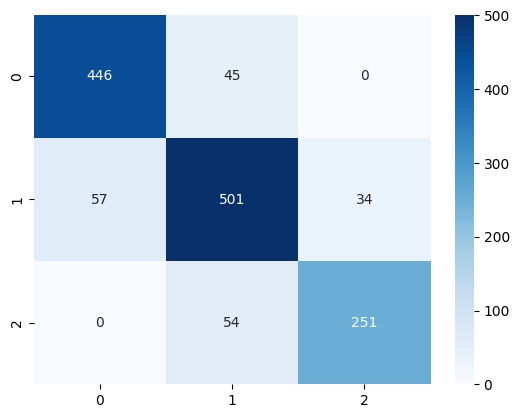

In [ ]:
# give precision and recall and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

labels_test = np.array(labels_test).ravel()  # Ensure y is 1D
label_encoder = LabelEncoder()
label_encoder.fit(labels_test)

X_test = df_test
y_test = label_encoder.transform(labels_test)


# Predict and Evaluate
y_pred = model.predict(X_test.values)
y_pred = y_pred.astype(int) -1
accuracy = accuracy_score(y_test, y_pred)
print(f"TabNet Classifier Accuracy {accuracy:.4f}")


# Get precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Print results
class_labels = ["CN", "MCI", "AD"]
for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print("-" * 30)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [ ]:
# Extract TP, TN, FP, FN for each class
sensitivity = {}  # Recall per class
specificity = {}  # Specificity per class

for i, label in enumerate(clf.classes_):
    TP = cm[i, i]  # True Positives
    FN = sum(cm[i, :]) - TP  # False Negatives
    FP = sum(cm[:, i]) - TP  # False Positives
    TN = sum(sum(cm)) - (TP + FN + FP)  # True Negatives

    sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall
    specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity

# Print results
for label in clf.classes_:
    print(f"Class: {label}")
    print(f"  Sensitivity (Recall): {sensitivity[label]:.4f}")
    print(f"  Specificity: {specificity[label]:.4f}")
    print("-" * 30)

Class: 0
  Sensitivity (Recall): 0.9084
  Specificity: 0.9365
------------------------------
Class: 1
  Sensitivity (Recall): 0.8463
  Specificity: 0.8756
------------------------------
Class: 2
  Sensitivity (Recall): 0.8230
  Specificity: 0.9686
------------------------------


In [ ]:
# save model
model.save_model("/content/new_Areeba_sent_train_test_ouch")

Successfully saved model at /content/new_Areeba_sent_train_test_ouch.zip


'/content/new_Areeba_sent_train_test_ouch.zip'

In [ ]:
df = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [ ]:
df

,PTID,VISCODE2,MMSCORE,CDGLOBAL,CDRSB,Current_Age,DIAGNOSIS,GENOTYPE
0,029_S_4279,m06,29.0,0.0,0.0,84.24,1.0,3/3
1,023_S_1126,m18,25.0,0.5,3.0,81.97,3.0,3/3
2,137_S_0631,m12,21.0,1.0,8.0,78.16,3.0,4/3
3,123_S_0390,m24,23.0,0.5,3.0,82.49,3.0,4/3
4,012_S_0689,m12,17.0,0.5,4.0,64.64,3.0,4/4
...,...,...,...,...,...,...,...,...
8058,021_S_0159,m12,30.0,0.0,0.0,78.88,1.0,3/3
8059,068_S_0473,m48,29.0,0.0,0.0,76.63,1.0,4/3
8060,007_S_4620,m06,29.0,0.0,0.0,77.63,1.0,3/3
8061,067_S_0056,m96,29.0,0.0,0.0,77.65,1.0,3/2


In [ ]:
df = df.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'CDRSB', 'Current_Age'])
df_test = df_test.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'CDRSB'])

In [ ]:
df

,PTID,VISCODE2,MMSCORE,CDGLOBAL,CDRSB,Current_Age,DIAGNOSIS,GENOTYPE,VISCODE_NUM
0,002_S_0295,m06,28.0,0.0,0.0,85.34,1.0,4/3,6
1,002_S_0295,m12,30.0,0.0,0.0,85.84,1.0,4/3,12
2,002_S_0295,m24,29.0,0.0,0.0,86.84,1.0,4/3,24
3,002_S_0295,m36,28.0,0.0,0.0,87.84,1.0,4/3,36
4,002_S_0295,m48,26.0,0.0,0.0,88.84,1.0,4/3,48
...,...,...,...,...,...,...,...,...,...
7724,941_S_6854,m24,24.0,1.0,7.0,88.26,3.0,4/3,24
7725,941_S_6962,m12,7.0,2.0,13.0,75.69,3.0,4/4,12
7726,941_S_7046,m36,29.0,0.0,0.0,74.21,1.0,4/3,36
7727,941_S_7051,m24,27.0,0.5,0.5,65.76,2.0,3/2,24


In [ ]:
df['VISCODE_NUM']

,VISCODE_NUM
0,6
1,12
2,24
3,36
4,48
...,...
7724,24
7725,12
7726,36
7727,24


In [ ]:
df.isna().sum()

,0
PTID,0
VISCODE2,0
MMSCORE,0
CDGLOBAL,0
CDRSB,0
Current_Age,0
DIAGNOSIS,0
GENOTYPE,0
VISCODE_NUM,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = df['DIAGNOSIS']
df = df.drop(columns=['DIAGNOSIS'])

labels_test = df_test['DIAGNOSIS']
df_test = df_test.drop(columns=['DIAGNOSIS'])

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels_test = label_encoder.transform(labels_test)


In [ ]:

df['GENOTYPE'] = label_encoder.fit_transform(df['GENOTYPE'])
df_test['GENOTYPE'] = label_encoder.transform(df_test['GENOTYPE'])

In [ ]:
df = df.drop(columns=['VISCODE2', 'VISCODE_NUM'])
df_test = df_test.drop(columns=['VISCODE2', 'VISCODE_NUM'])

In [ ]:
df = df.drop(columns=['PTID', 'VISCODE2', 'VISCODE_NUM'])
df_test = df_test.drop(columns=['PTID', 'VISCODE2', 'VISCODE_NUM'])

KeyError: "['PTID'] not found in axis"

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier

In [ ]:
# Step 4: Prepare Labels
labels = np.array(labels).ravel()  # Ensure y is 1D

# Step 5: Train/Test Split with Stratification
X_train, X_val, y_train, y_val = train_test_split(
    df, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 6: Encode Labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

# Step 7: Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Step 8: Define TabNet Classifier

clf = TabNetClassifier(
        n_d=32,
        n_a=32,
        n_steps=5,
        n_independent=3,
        n_shared=7,
        gamma=1.3,
        lambda_sparse=0.001,
        optimizer_params={"lr": 0.01},
        scheduler_params={"step_size": 5, "gamma": 0.8},
        mask_type="entmax",
)
#clf = TabNetClassifier()

# Step 9: Train the Model
clf.fit(
    X_train.values, y_train,
    eval_set=[(X_val.values, y_val)],
    patience=10, max_epochs=100,
    batch_size=512, virtual_batch_size=32,
    weights=class_weight_dict
)

# Step 10: Predict
# y_pred = clf.predict(X_test.values)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97545 | val_0_accuracy: 0.39247 |  0:00:09s
epoch 1  | loss: 0.48234 | val_0_accuracy: 0.44624 |  0:00:16s
epoch 2  | loss: 0.44052 | val_0_accuracy: 0.4422  |  0:00:19s
epoch 3  | loss: 0.42591 | val_0_accuracy: 0.42742 |  0:00:21s
epoch 4  | loss: 0.41861 | val_0_accuracy: 0.48387 |  0:00:24s
epoch 5  | loss: 0.40126 | val_0_accuracy: 0.53495 |  0:00:26s
epoch 6  | loss: 0.38701 | val_0_accuracy: 0.48656 |  0:00:30s
epoch 7  | loss: 0.40149 | val_0_accuracy: 0.58602 |  0:00:32s
epoch 8  | loss: 0.38376 | val_0_accuracy: 0.57258 |  0:00:35s
epoch 9  | loss: 0.377   | val_0_accuracy: 0.83065 |  0:00:37s
epoch 10 | loss: 0.38984 | val_0_accuracy: 0.8246  |  0:00:40s
epoch 11 | loss: 0.37863 | val_0_accuracy: 0.78495 |  0:00:43s
epoch 12 | loss: 0.36862 | val_0_accuracy: 0.77218 |  0:00:46s
epoch 13 | loss: 0.34718 | val_0_accuracy: 0.83132 |  0:00:48s
epoch 14 | loss: 0.38183 | val_0_accuracy: 0.86962 |  0:00:51s
epoch 15 | loss: 0.36677 | val_0_accuracy: 0.87366 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Classifier Accuracy 0.8700
Class: CN
  Precision: 0.9070
  Recall: 0.9109
  F1-score: 0.9090
------------------------------
Class: MCI
  Precision: 0.8050
  Recall: 0.8759
  F1-score: 0.8390
------------------------------
Class: AD
  Precision: 0.9359
  Recall: 0.7887
  F1-score: 0.8560
------------------------------
Confusion Matrix:


<Axes: >

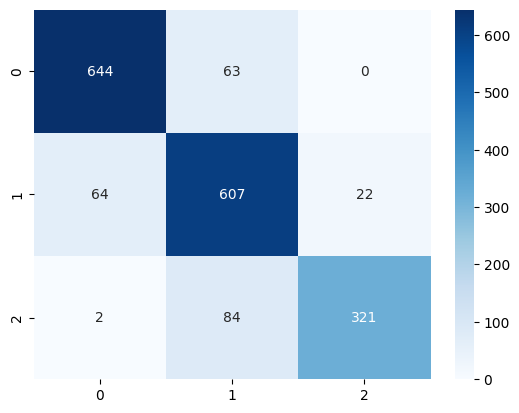

In [ ]:
# give precision and recall and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

labels_test = np.array(labels_test).ravel()  # Ensure y is 1D
label_encoder = LabelEncoder()
label_encoder.fit(labels_test)

X_test = df_test
y_test = label_encoder.transform(labels_test)


# Predict and Evaluate
y_pred = clf.predict(X_test.values)
y_pred = y_pred.astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"TabNet Classifier Accuracy {accuracy:.4f}")


# Get precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Print results
class_labels = ["CN", "MCI", "AD"]
for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print("-" * 30)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [ ]:
# Extract TP, TN, FP, FN for each class
sensitivity = {}  # Recall per class
specificity = {}  # Specificity per class

for i, label in enumerate(clf.classes_):
    TP = cm[i, i]  # True Positives
    FN = sum(cm[i, :]) - TP  # False Negatives
    FP = sum(cm[:, i]) - TP  # False Positives
    TN = sum(sum(cm)) - (TP + FN + FP)  # True Negatives

    sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall
    specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity

# Print results
for label in clf.classes_:
    print(f"Class: {label}")
    print(f"  Sensitivity (Recall): {sensitivity[label]:.4f}")
    print(f"  Specificity: {specificity[label]:.4f}")
    print("-" * 30)

Class: 0
  Sensitivity (Recall): 0.9109
  Specificity: 0.9400
------------------------------
Class: 1
  Sensitivity (Recall): 0.8759
  Specificity: 0.8680
------------------------------
Class: 2
  Sensitivity (Recall): 0.7887
  Specificity: 0.9843
------------------------------


In [ ]:
# calc overall sensitivity and overall specificity
overall_sensitivity = sum(sensitivity.values()) / len(sensitivity)
overall_specificity = sum(specificity.values()) / len(specificity)

print(f"Overall Sensitivity (Recall): {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")



Overall Sensitivity (Recall): 0.8585
Overall Specificity: 0.9308


In [ ]:
# save model
clf.save_model("/content/tabnet_mmse_cdrsb_cdrglobal_age_new_data")

Successfully saved model at /content/tabnet_mmse_cdrsb_cdrglobal_age_new_data.zip


'/content/tabnet_mmse_cdrsb_cdrglobal_age_new_data.zip'

In [ ]:
df = pd.read_csv('/content/train_data.csv')
df_test = pd.read_csv('/content/test_data.csv')

In [ ]:
df = df.drop(columns=['Current_Age'])
df_test = df_test.drop(columns=['Current_Age'])

In [ ]:
unique_gen = df['GENOTYPE'].dropna().unique()
unique_gen_split = [gen.split('-') for gen in unique_gen]
unique_gen2 = df_test['GENOTYPE'].dropna().unique()
unique_gen_split2 = [gen.split('-') for gen in unique_gen2]

# Replace month names with numbers
for i, sublist in enumerate(unique_gen_split):
    for j, item in enumerate(sublist):
        if item == 'Mar':
            unique_gen_split[i][j] = '3'
        elif item == 'Apr':
            unique_gen_split[i][j] = '4'
        elif item == 'Feb':
            unique_gen_split[i][j] = '2'
# Replace month names with numbers
for i, sublist in enumerate(unique_gen_split2):
    for j, item in enumerate(sublist):
        if item == 'Mar':
            unique_gen_split2[i][j] = '3'
        elif item == 'Apr':
            unique_gen_split2[i][j] = '4'
        elif item == 'Feb':
            unique_gen_split2[i][j] = '2'

# Join each sublist with a '/'
joined_gen = ['/'.join(sublist) for sublist in unique_gen_split]
print(joined_gen)
# Join each sublist with a '/'
joined_gen2 = ['/'.join(sublist) for sublist in unique_gen_split2]
print(joined_gen)

df['GENOTYPE'] = df['GENOTYPE'].dropna()
df_test['GENOTYPE'] = df_test['GENOTYPE'].dropna()

# Step 2: Split and replace month names with numbers
replacement_map = {}

for gen in unique_gen:
    parts = gen.split('-')
    month_map = {'Mar': '3', 'Apr': '4', 'Feb': '2'}
    parts = [month_map.get(p, p) for p in parts]  # Replace month if matched
    new_val = '/'.join(parts)
    replacement_map[gen] = new_val

# Step 3: Replace in the DataFrame
df['GENOTYPE'] = df['GENOTYPE'].replace(replacement_map)

# Step 2: Split and replace month names with numbers
replacement_map = {}

for gen in unique_gen2:
    parts = gen.split('-')
    month_map = {'Mar': '3', 'Apr': '4', 'Feb': '2'}
    parts = [month_map.get(p, p) for p in parts]  # Replace month if matched
    new_val = '/'.join(parts)
    replacement_map[gen] = new_val

# Step 3: Replace in the DataFrame
df_test['GENOTYPE'] = df_test['GENOTYPE'].replace(replacement_map)

df = df.dropna(subset=['GENOTYPE'])
df_test = df_test.dropna(subset=['GENOTYPE'])

['4/3', '4/4', '3/3', '3/2', '4/2', '2/2']
['4/3', '4/4', '3/3', '3/2', '4/2', '2/2']


In [ ]:
df = df.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'CDRSB'])
df_test = df_test.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'CDRSB'])

In [ ]:
df = df.drop(columns=['PTID', 'VISCODE2', 'VISCODE_NUM'])
df_test = df_test.drop(columns=['PTID', 'VISCODE2', 'VISCODE_NUM'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = df['DIAGNOSIS']
df = df.drop(columns=['DIAGNOSIS'])

labels_test = df_test['DIAGNOSIS']
df_test = df_test.drop(columns=['DIAGNOSIS'])

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels_test = label_encoder.transform(labels_test)


In [ ]:

df['GENOTYPE'] = label_encoder.fit_transform(df['GENOTYPE'])
df_test['GENOTYPE'] = label_encoder.transform(df_test['GENOTYPE'])

In [ ]:
df

,MMSCORE,CDGLOBAL,CDRSB,GENOTYPE
0,28.0,0.0,0.0,4
1,30.0,0.0,0.0,4
2,29.0,0.0,0.0,4
3,28.0,0.0,0.0,4
4,26.0,0.0,0.0,4
...,...,...,...,...
7724,24.0,1.0,7.0,4
7725,7.0,2.0,13.0,5
7726,29.0,0.0,0.0,4
7727,27.0,0.5,0.5,1


In [ ]:
# Step 4: Prepare Labels
labels = np.array(labels).ravel()  # Ensure y is 1D

# Step 5: Train/Test Split with Stratification
X_train, X_val, y_train, y_val = train_test_split(
    df, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 6: Encode Labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

# Step 7: Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Step 8: Define TabNet Classifier

clf = TabNetClassifier(
        n_d=32,
        n_a=32,
        n_steps=5,
        n_independent=3,
        n_shared=7,
        gamma=1.3,
        lambda_sparse=0.001,
        optimizer_params={"lr": 0.01},
        scheduler_params={"step_size": 5, "gamma": 0.8},
        mask_type="entmax",
)
#clf = TabNetClassifier()

# Step 9: Train the Model
clf.fit(
    X_train.values, y_train,
    eval_set=[(X_val.values, y_val)],
    patience=10, max_epochs=100,
    batch_size=512, virtual_batch_size=32,
    weights=class_weight_dict
)

# Step 10: Predict
# y_pred = clf.predict(X_test.values)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.89095 | val_0_accuracy: 0.538   |  0:00:02s
epoch 1  | loss: 0.42936 | val_0_accuracy: 0.50101 |  0:00:05s
epoch 2  | loss: 0.41929 | val_0_accuracy: 0.54943 |  0:00:08s
epoch 3  | loss: 0.40401 | val_0_accuracy: 0.4768  |  0:00:10s
epoch 4  | loss: 0.40733 | val_0_accuracy: 0.54876 |  0:00:13s
epoch 5  | loss: 0.37921 | val_0_accuracy: 0.56153 |  0:00:15s
epoch 6  | loss: 0.38374 | val_0_accuracy: 0.54069 |  0:00:18s
epoch 7  | loss: 0.39241 | val_0_accuracy: 0.55683 |  0:00:21s
epoch 8  | loss: 0.3834  | val_0_accuracy: 0.55145 |  0:00:23s
epoch 9  | loss: 0.36465 | val_0_accuracy: 0.74042 |  0:00:26s
epoch 10 | loss: 0.34732 | val_0_accuracy: 0.82246 |  0:00:29s
epoch 11 | loss: 0.37016 | val_0_accuracy: 0.84062 |  0:00:32s
epoch 12 | loss: 0.38178 | val_0_accuracy: 0.85541 |  0:00:34s
epoch 13 | loss: 0.37    | val_0_accuracy: 0.78547 |  0:00:36s
epoch 14 | loss: 0.38342 | val_0_accuracy: 0.86752 |  0:00:39s
epoch 15 | loss: 0.37338 | val_0_accuracy: 0.8729  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Classifier Accuracy 0.8696
Class: CN
  Precision: 0.9069
  Recall: 0.9108
  F1-score: 0.9088
------------------------------
Class: MCI
  Precision: 0.8084
  Recall: 0.8681
  F1-score: 0.8372
------------------------------
Class: AD
  Precision: 0.9233
  Recall: 0.8005
  F1-score: 0.8575
------------------------------
Confusion Matrix:


<Axes: >

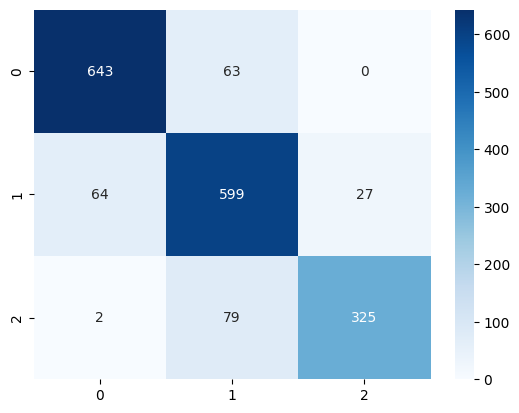

In [ ]:
# give precision and recall and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

labels_test = np.array(labels_test).ravel()  # Ensure y is 1D
label_encoder = LabelEncoder()
label_encoder.fit(labels_test)

X_test = df_test
y_test = label_encoder.transform(labels_test)


# Predict and Evaluate
y_pred = clf.predict(X_test.values)
y_pred = y_pred.astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"TabNet Classifier Accuracy {accuracy:.4f}")


# Get precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Print results
class_labels = ["CN", "MCI", "AD"]
for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print("-" * 30)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


In [ ]:
# Extract TP, TN, FP, FN for each class
sensitivity = {}  # Recall per class
specificity = {}  # Specificity per class

for i, label in enumerate(clf.classes_):
    TP = cm[i, i]  # True Positives
    FN = sum(cm[i, :]) - TP  # False Negatives
    FP = sum(cm[:, i]) - TP  # False Positives
    TN = sum(sum(cm)) - (TP + FN + FP)  # True Negatives

    sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall
    specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity

# Print results
for label in clf.classes_:
    print(f"Class: {label}")
    print(f"  Sensitivity (Recall): {sensitivity[label]:.4f}")
    print(f"  Specificity: {specificity[label]:.4f}")
    print("-" * 30)

Class: 0
  Sensitivity (Recall): 0.9108
  Specificity: 0.9398
------------------------------
Class: 1
  Sensitivity (Recall): 0.8681
  Specificity: 0.8723
------------------------------
Class: 2
  Sensitivity (Recall): 0.8005
  Specificity: 0.9807
------------------------------


In [ ]:
# calc overall sensitivity and overall specificity
overall_sensitivity = sum(sensitivity.values()) / len(sensitivity)
overall_specificity = sum(specificity.values()) / len(specificity)

print(f"Overall Sensitivity (Recall): {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")



Overall Sensitivity (Recall): 0.8598
Overall Specificity: 0.9309


In [ ]:
# save model
clf.save_model("/content/tabnet_mmse_cdrsb_cdrglobal_genotype_new_data")

Successfully saved model at /content/tabnet_mmse_cdrsb_cdrglobal_genotype_new_data.zip


'/content/tabnet_mmse_cdrsb_cdrglobal_genotype_new_data.zip'

In [ ]:
df = df.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'Current_Age'])
df_test = df_test.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'Current_Age'])

In [ ]:
df = df.drop(columns=['PTID', 'GENOTYPE', 'CDRSB', 'VISCODE2'])
df_test = df_test.drop(columns=['PTID', 'GENOTYPE', 'CDRSB', 'VISCODE2'])


In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = df['DIAGNOSIS']
df = df.drop(columns=['DIAGNOSIS'])

labels_test = df_test['DIAGNOSIS']
df_test = df_test.drop(columns=['DIAGNOSIS'])

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels_test = label_encoder.transform(labels_test)


In [ ]:
# Step 4: Prepare Labels
labels = np.array(labels).ravel()  # Ensure y is 1D

# Step 5: Train/Test Split with Stratification
X_train, X_val, y_train, y_val = train_test_split(
    df, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 6: Encode Labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

# Step 7: Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Step 8: Define TabNet Classifier

clf = TabNetClassifier(
        n_d=32,
        n_a=32,
        n_steps=5,
        n_independent=3,
        n_shared=7,
        gamma=1.3,
        lambda_sparse=0.001,
        optimizer_params={"lr": 0.01},
        scheduler_params={"step_size": 5, "gamma": 0.8},
        mask_type="entmax",
)
#clf = TabNetClassifier()

# Step 9: Train the Model
clf.fit(
    X_train.values, y_train,
    eval_set=[(X_val.values, y_val)],
    patience=10, max_epochs=100,
    batch_size=512, virtual_batch_size=32,
    weights=class_weight_dict
)

# Step 10: Predict
# y_pred = clf.predict(X_test.values)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07455 | val_0_accuracy: 0.34176 |  0:00:03s
epoch 1  | loss: 0.55627 | val_0_accuracy: 0.35372 |  0:00:05s
epoch 2  | loss: 0.53356 | val_0_accuracy: 0.37035 |  0:00:08s
epoch 3  | loss: 0.50453 | val_0_accuracy: 0.43883 |  0:00:10s
epoch 4  | loss: 0.48529 | val_0_accuracy: 0.41223 |  0:00:13s
epoch 5  | loss: 0.44378 | val_0_accuracy: 0.41822 |  0:00:16s
epoch 6  | loss: 0.43307 | val_0_accuracy: 0.35106 |  0:00:19s
epoch 7  | loss: 0.42768 | val_0_accuracy: 0.57114 |  0:00:21s
epoch 8  | loss: 0.43408 | val_0_accuracy: 0.5492  |  0:00:23s
epoch 9  | loss: 0.42608 | val_0_accuracy: 0.45612 |  0:00:26s
epoch 10 | loss: 0.44079 | val_0_accuracy: 0.50798 |  0:00:29s
epoch 11 | loss: 0.42095 | val_0_accuracy: 0.48138 |  0:00:32s
epoch 12 | loss: 0.41745 | val_0_accuracy: 0.80519 |  0:00:35s
epoch 13 | loss: 0.42076 | val_0_accuracy: 0.72141 |  0:00:37s
epoch 14 | loss: 0.43589 | val_0_accuracy: 0.8504  |  0:00:40s
epoch 15 | loss: 0.41153 | val_0_accuracy: 0.80652 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Classifier Accuracy 0.8564
Class: CN
  Precision: 0.9045
  Recall: 0.9045
  F1-score: 0.9045
------------------------------
Class: MCI
  Precision: 0.7873
  Recall: 0.8588
  F1-score: 0.8215
------------------------------
Class: AD
  Precision: 0.9080
  Recall: 0.7689
  F1-score: 0.8327
------------------------------
Confusion Matrix:


<Axes: >

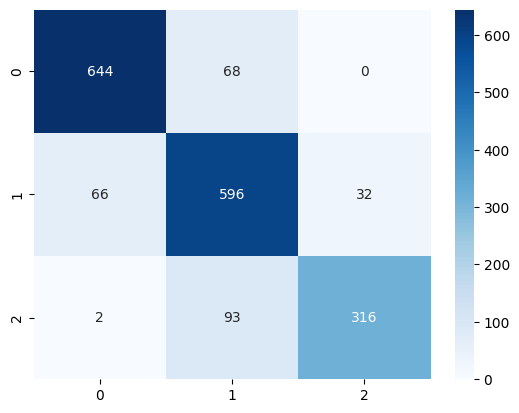

In [ ]:
# give precision and recall and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

labels_test = np.array(labels_test).ravel()  # Ensure y is 1D
label_encoder = LabelEncoder()
label_encoder.fit(labels_test)

X_test = df_test
y_test = label_encoder.transform(labels_test)


# Predict and Evaluate
y_pred = clf.predict(X_test.values)
y_pred = y_pred.astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"TabNet Classifier Accuracy {accuracy:.4f}")


# Get precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Print results
class_labels = ["CN", "MCI", "AD"]
for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print("-" * 30)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


In [ ]:
# Extract TP, TN, FP, FN for each class
sensitivity = {}  # Recall per class
specificity = {}  # Specificity per class

for i, label in enumerate(clf.classes_):
    TP = cm[i, i]  # True Positives
    FN = sum(cm[i, :]) - TP  # False Negatives
    FP = sum(cm[:, i]) - TP  # False Positives
    TN = sum(sum(cm)) - (TP + FN + FP)  # True Negatives

    sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall
    specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity

# Print results
for label in clf.classes_:
    print(f"Class: {label}")
    print(f"  Sensitivity (Recall): {sensitivity[label]:.4f}")
    print(f"  Specificity: {specificity[label]:.4f}")
    print("-" * 30)

Class: 0
  Sensitivity (Recall): 0.9045
  Specificity: 0.9385
------------------------------
Class: 1
  Sensitivity (Recall): 0.8588
  Specificity: 0.8566
------------------------------
Class: 2
  Sensitivity (Recall): 0.7689
  Specificity: 0.9772
------------------------------


In [ ]:
# calc overall sensitivity and overall specificity
overall_sensitivity = sum(sensitivity.values()) / len(sensitivity)
overall_specificity = sum(specificity.values()) / len(specificity)

print(f"Overall Sensitivity (Recall): {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")



Overall Sensitivity (Recall): 0.8440
Overall Specificity: 0.9241


In [ ]:
# save model
clf.save_model("/content/tabnet_mmse_cdrglobal_age_new_data")

Successfully saved model at /content/tabnet_mmse_cdrglobal_age_new_data.zip


'/content/tabnet_mmse_cdrglobal_age_new_data.zip'

In [ ]:
df = df[['MMSCORE', 'PTID', 'VISCODE2', 'DIAGNOSIS']]
df_test = df_test[['MMSCORE', 'PTID', 'VISCODE2', 'DIAGNOSIS']]

In [ ]:
df = df.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE'])
df_test = df_test.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE'])

In [ ]:
df = df.drop(columns=['PTID', 'VISCODE2'])
df_test = df_test.drop(columns=['PTID', 'VISCODE2'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = df['DIAGNOSIS']
df = df.drop(columns=['DIAGNOSIS'])

labels_test = df_test['DIAGNOSIS']
df_test = df_test.drop(columns=['DIAGNOSIS'])

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels_test = label_encoder.transform(labels_test)


In [ ]:
# Step 4: Prepare Labels
labels = np.array(labels).ravel()  # Ensure y is 1D

# Step 5: Train/Test Split with Stratification
X_train, X_val, y_train, y_val = train_test_split(
    df, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 6: Encode Labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

# Step 7: Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Step 8: Define TabNet Classifier

clf = TabNetClassifier(
        n_d=32,
        n_a=32,
        n_steps=5,
        n_independent=3,
        n_shared=7,
        gamma=1.3,
        lambda_sparse=0.001,
        optimizer_params={"lr": 0.01},
        scheduler_params={"step_size": 5, "gamma": 0.8},
        mask_type="entmax",
)
#clf = TabNetClassifier()

# Step 9: Train the Model
clf.fit(
    X_train.values, y_train,
    eval_set=[(X_val.values, y_val)],
    patience=10, max_epochs=100,
    batch_size=512, virtual_batch_size=32,
    weights=class_weight_dict
)

# Step 10: Predict
# y_pred = clf.predict(X_test.values)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.02928 | val_0_accuracy: 0.28817 |  0:00:05s
epoch 1  | loss: 0.7923  | val_0_accuracy: 0.09716 |  0:00:08s
epoch 2  | loss: 0.75404 | val_0_accuracy: 0.20687 |  0:00:10s
epoch 3  | loss: 0.73727 | val_0_accuracy: 0.45142 |  0:00:13s
epoch 4  | loss: 0.72538 | val_0_accuracy: 0.36021 |  0:00:16s
epoch 5  | loss: 0.73453 | val_0_accuracy: 0.13417 |  0:00:19s
epoch 6  | loss: 0.72839 | val_0_accuracy: 0.35426 |  0:00:21s
epoch 7  | loss: 0.72955 | val_0_accuracy: 0.31989 |  0:00:23s
epoch 8  | loss: 0.73584 | val_0_accuracy: 0.37872 |  0:00:26s
epoch 9  | loss: 0.72632 | val_0_accuracy: 0.37938 |  0:00:29s
epoch 10 | loss: 0.7213  | val_0_accuracy: 0.39128 |  0:00:31s
epoch 11 | loss: 0.72848 | val_0_accuracy: 0.40317 |  0:00:34s
epoch 12 | loss: 0.72802 | val_0_accuracy: 0.40317 |  0:00:36s
epoch 13 | loss: 0.73571 | val_0_accuracy: 0.423   |  0:00:39s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_accuracy = 0.45142


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Classifier Accuracy 0.5052
Class: CN
  Precision: 0.4570
  Recall: 0.9972
  F1-score: 0.6268
------------------------------
Class: MCI
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
------------------------------
Class: AD
  Precision: 0.7985
  Recall: 0.5097
  F1-score: 0.6222
------------------------------
Confusion Matrix:


<Axes: >

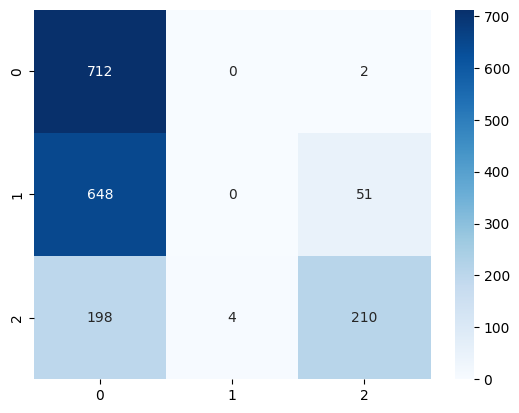

In [ ]:
# give precision and recall and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

labels_test = np.array(labels_test).ravel()  # Ensure y is 1D
label_encoder = LabelEncoder()
label_encoder.fit(labels_test)

X_test = df_test
y_test = label_encoder.transform(labels_test)


# Predict and Evaluate
y_pred = clf.predict(X_test.values)
y_pred = y_pred.astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"TabNet Classifier Accuracy {accuracy:.4f}")


# Get precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Print results
class_labels = ["CN", "MCI", "AD"]
for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print("-" * 30)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


In [ ]:
# Extract TP, TN, FP, FN for each class
sensitivity = {}  # Recall per class
specificity = {}  # Specificity per class

for i, label in enumerate(clf.classes_):
    TP = cm[i, i]  # True Positives
    FN = sum(cm[i, :]) - TP  # False Negatives
    FP = sum(cm[:, i]) - TP  # False Positives
    TN = sum(sum(cm)) - (TP + FN + FP)  # True Negatives

    sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall
    specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity

# Print results
for label in clf.classes_:
    print(f"Class: {label}")
    print(f"  Sensitivity (Recall): {sensitivity[label]:.4f}")
    print(f"  Specificity: {specificity[label]:.4f}")
    print("-" * 30)

Class: 0
  Sensitivity (Recall): 0.9972
  Specificity: 0.2385
------------------------------
Class: 1
  Sensitivity (Recall): 0.0000
  Specificity: 0.9964
------------------------------
Class: 2
  Sensitivity (Recall): 0.5097
  Specificity: 0.9625
------------------------------


In [ ]:
# calc overall sensitivity and overall specificity
overall_sensitivity = sum(sensitivity.values()) / len(sensitivity)
overall_specificity = sum(specificity.values()) / len(specificity)

print(f"Overall Sensitivity (Recall): {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")



Overall Sensitivity (Recall): 0.5023
Overall Specificity: 0.7325


In [ ]:
# save model
clf.save_model("/content/tabnet_mmse_new_data")

Successfully saved model at /content/tabnet_mmse_new_data.zip


'/content/tabnet_mmse_new_data.zip'

In [ ]:
df = df.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE','CDRSB'])
df_test = df_test.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDRSB'])

In [ ]:
df = df.drop(columns=['PTID', 'VISCODE2', 'CDGLOBAL', 'GENOTYPE', 'Current_Age', 'VISCODE_NUM'])
df_test = df_test.drop(columns=['PTID', 'VISCODE2', 'CDGLOBAL', 'GENOTYPE', 'Current_Age', 'VISCODE_NUM'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = df['DIAGNOSIS']
df = df.drop(columns=['DIAGNOSIS'])

labels_test = df_test['DIAGNOSIS']
df_test = df_test.drop(columns=['DIAGNOSIS'])

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels_test = label_encoder.transform(labels_test)


In [ ]:
# Step 4: Prepare Labels
labels = np.array(labels).ravel()  # Ensure y is 1D

# Step 5: Train/Test Split with Stratification
X_train, X_val, y_train, y_val = train_test_split(
    df, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 6: Encode Labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

# Step 7: Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Step 8: Define TabNet Classifier

clf = TabNetClassifier(
        n_d=32,
        n_a=32,
        n_steps=5,
        n_independent=3,
        n_shared=7,
        gamma=1.3,
        lambda_sparse=0.001,
        optimizer_params={"lr": 0.01},
        scheduler_params={"step_size": 5, "gamma": 0.8},
        mask_type="entmax",
)
#clf = TabNetClassifier()

# Step 9: Train the Model
clf.fit(
    X_train.values, y_train,
    eval_set=[(X_val.values, y_val)],
    patience=10, max_epochs=100,
    batch_size=512, virtual_batch_size=32,
    weights=class_weight_dict
)

# Step 10: Predict
# y_pred = clf.predict(X_test.values)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.23532 | val_0_accuracy: 0.33871 |  0:00:03s
epoch 1  | loss: 0.4987  | val_0_accuracy: 0.18078 |  0:00:05s
epoch 2  | loss: 0.46401 | val_0_accuracy: 0.50672 |  0:00:08s
epoch 3  | loss: 0.42102 | val_0_accuracy: 0.33804 |  0:00:11s
epoch 4  | loss: 0.40683 | val_0_accuracy: 0.57527 |  0:00:14s
epoch 5  | loss: 0.38888 | val_0_accuracy: 0.58468 |  0:00:16s
epoch 6  | loss: 0.39371 | val_0_accuracy: 0.3125  |  0:00:18s
epoch 7  | loss: 0.39558 | val_0_accuracy: 0.46976 |  0:00:22s
epoch 8  | loss: 0.4125  | val_0_accuracy: 0.6828  |  0:00:24s
epoch 9  | loss: 0.38809 | val_0_accuracy: 0.58669 |  0:00:27s
epoch 10 | loss: 0.36896 | val_0_accuracy: 0.41935 |  0:00:29s
epoch 11 | loss: 0.39821 | val_0_accuracy: 0.61156 |  0:00:31s
epoch 12 | loss: 0.37835 | val_0_accuracy: 0.64852 |  0:00:35s
epoch 13 | loss: 0.37423 | val_0_accuracy: 0.61761 |  0:00:37s
epoch 14 | loss: 0.37837 | val_0_accuracy: 0.64852 |  0:00:40s
epoch 15 | loss: 0.38409 | val_0_accuracy: 0.72513 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Classifier Accuracy 0.8590
Class: CN
  Precision: 0.9220
  Recall: 0.8541
  F1-score: 0.8868
------------------------------
Class: MCI
  Precision: 0.7912
  Recall: 0.8623
  F1-score: 0.8252
------------------------------
Class: AD
  Precision: 0.8838
  Recall: 0.8621
  F1-score: 0.8728
------------------------------
Confusion Matrix:


<Axes: >

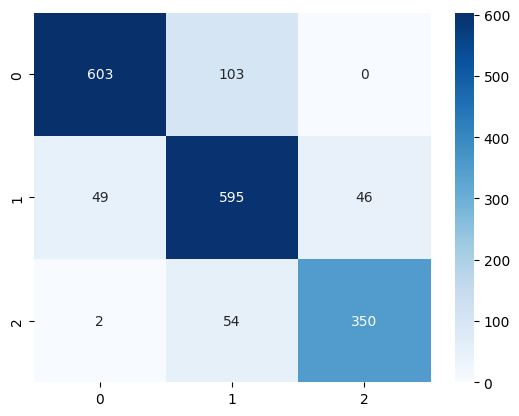

In [ ]:
# give precision and recall and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

labels_test = np.array(labels_test).ravel()  # Ensure y is 1D
label_encoder = LabelEncoder()
label_encoder.fit(labels_test)

X_test = df_test
y_test = label_encoder.transform(labels_test)


# Predict and Evaluate
y_pred = clf.predict(X_test.values)
y_pred = y_pred.astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"TabNet Classifier Accuracy {accuracy:.4f}")


# Get precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Print results
class_labels = ["CN", "MCI", "AD"]
for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print("-" * 30)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


In [ ]:
# Extract TP, TN, FP, FN for each class
sensitivity = {}  # Recall per class
specificity = {}  # Specificity per class

for i, label in enumerate(clf.classes_):
    TP = cm[i, i]  # True Positives
    FN = sum(cm[i, :]) - TP  # False Negatives
    FP = sum(cm[:, i]) - TP  # False Positives
    TN = sum(sum(cm)) - (TP + FN + FP)  # True Negatives

    sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall
    specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity

# Print results
for label in clf.classes_:
    print(f"Class: {label}")
    print(f"  Sensitivity (Recall): {sensitivity[label]:.4f}")
    print(f"  Specificity: {specificity[label]:.4f}")
    print("-" * 30)

Class: 0
  Sensitivity (Recall): 0.8541
  Specificity: 0.9535
------------------------------
Class: 1
  Sensitivity (Recall): 0.8623
  Specificity: 0.8588
------------------------------
Class: 2
  Sensitivity (Recall): 0.8621
  Specificity: 0.9670
------------------------------


In [ ]:
# calc overall sensitivity and overall specificity
overall_sensitivity = sum(sensitivity.values()) / len(sensitivity)
overall_specificity = sum(specificity.values()) / len(specificity)

print(f"Overall Sensitivity (Recall): {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")



Overall Sensitivity (Recall): 0.8595
Overall Specificity: 0.9264


In [ ]:
# save model
clf.save_model("/content/tabnet_mmse_cdrsb_new_data")

Successfully saved model at /content/tabnet_mmse_cdrsb_new_data.zip


'/content/tabnet_mmse_cdrsb_new_data.zip'

In [ ]:
df = df.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'Current_Age'])
df_test = df_test.dropna(subset=['PTID', 'VISCODE2', 'DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'Current_Age'])

In [ ]:
df = df[['DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'Current_Age']]
df_test = df_test[['DIAGNOSIS', 'MMSCORE', 'CDGLOBAL', 'Current_Age']]

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = df['DIAGNOSIS']
df = df.drop(columns=['DIAGNOSIS'])

labels_test = df_test['DIAGNOSIS']
df_test = df_test.drop(columns=['DIAGNOSIS'])

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels_test = label_encoder.transform(labels_test)


In [ ]:
# Step 4: Prepare Labels
labels = np.array(labels).ravel()  # Ensure y is 1D

# Step 5: Train/Test Split with Stratification
X_train, X_val, y_train, y_val = train_test_split(
    df, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 6: Encode Labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

# Step 7: Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Step 8: Define TabNet Classifier

clf = TabNetClassifier(
        n_d=32,
        n_a=32,
        n_steps=5,
        n_independent=3,
        n_shared=7,
        gamma=1.3,
        lambda_sparse=0.001,
        optimizer_params={"lr": 0.01},
        scheduler_params={"step_size": 5, "gamma": 0.8},
        mask_type="entmax",
)
#clf = TabNetClassifier()

# Step 9: Train the Model
clf.fit(
    X_train.values, y_train,
    eval_set=[(X_val.values, y_val)],
    patience=10, max_epochs=100,
    batch_size=512, virtual_batch_size=32,
    weights=class_weight_dict
)

# Step 10: Predict
# y_pred = clf.predict(X_test.values)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85924 | val_0_accuracy: 0.35372 |  0:00:02s
epoch 1  | loss: 0.55717 | val_0_accuracy: 0.28923 |  0:00:05s
epoch 2  | loss: 0.52767 | val_0_accuracy: 0.36104 |  0:00:08s
epoch 3  | loss: 0.49779 | val_0_accuracy: 0.34774 |  0:00:11s
epoch 4  | loss: 0.45926 | val_0_accuracy: 0.36503 |  0:00:13s
epoch 5  | loss: 0.43741 | val_0_accuracy: 0.28457 |  0:00:16s
epoch 6  | loss: 0.4194  | val_0_accuracy: 0.54654 |  0:00:19s
epoch 7  | loss: 0.43069 | val_0_accuracy: 0.51396 |  0:00:21s
epoch 8  | loss: 0.42747 | val_0_accuracy: 0.49867 |  0:00:24s
epoch 9  | loss: 0.41627 | val_0_accuracy: 0.49601 |  0:00:27s
epoch 10 | loss: 0.4269  | val_0_accuracy: 0.65093 |  0:00:29s
epoch 11 | loss: 0.41861 | val_0_accuracy: 0.69481 |  0:00:33s
epoch 12 | loss: 0.40389 | val_0_accuracy: 0.78657 |  0:00:36s
epoch 13 | loss: 0.41755 | val_0_accuracy: 0.80186 |  0:00:39s
epoch 14 | loss: 0.43886 | val_0_accuracy: 0.85838 |  0:00:41s
epoch 15 | loss: 0.40264 | val_0_accuracy: 0.85306 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Classifier Accuracy 0.8580
Class: CN
  Precision: 0.9039
  Recall: 0.9115
  F1-score: 0.9077
------------------------------
Class: MCI
  Precision: 0.7915
  Recall: 0.8588
  F1-score: 0.8238
------------------------------
Class: AD
  Precision: 0.9075
  Recall: 0.7640
  F1-score: 0.8296
------------------------------
Confusion Matrix:


<Axes: >

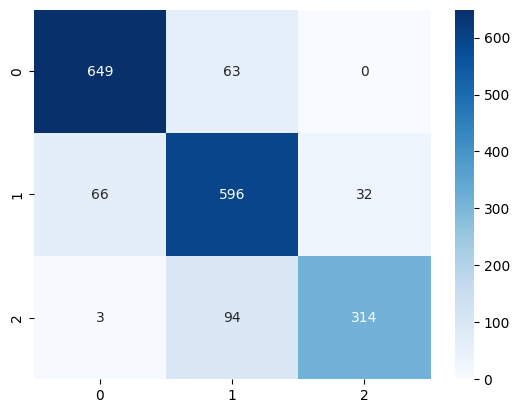

In [ ]:
# give precision and recall and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

labels_test = np.array(labels_test).ravel()  # Ensure y is 1D
label_encoder = LabelEncoder()
label_encoder.fit(labels_test)

X_test = df_test
y_test = label_encoder.transform(labels_test)


# Predict and Evaluate
y_pred = clf.predict(X_test.values)
y_pred = y_pred.astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"TabNet Classifier Accuracy {accuracy:.4f}")


# Get precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Print results
class_labels = ["CN", "MCI", "AD"]
for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print("-" * 30)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


In [ ]:
# Extract TP, TN, FP, FN for each class
sensitivity = {}  # Recall per class
specificity = {}  # Specificity per class

for i, label in enumerate(clf.classes_):
    TP = cm[i, i]  # True Positives
    FN = sum(cm[i, :]) - TP  # False Negatives
    FP = sum(cm[:, i]) - TP  # False Positives
    TN = sum(sum(cm)) - (TP + FN + FP)  # True Negatives

    sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall
    specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity

# Print results
for label in clf.classes_:
    print(f"Class: {label}")
    print(f"  Sensitivity (Recall): {sensitivity[label]:.4f}")
    print(f"  Specificity: {specificity[label]:.4f}")
    print("-" * 30)

Class: 0
  Sensitivity (Recall): 0.9115
  Specificity: 0.9376
------------------------------
Class: 1
  Sensitivity (Recall): 0.8588
  Specificity: 0.8602
------------------------------
Class: 2
  Sensitivity (Recall): 0.7640
  Specificity: 0.9772
------------------------------


In [ ]:
# calc overall sensitivity and overall specificity
overall_sensitivity = sum(sensitivity.values()) / len(sensitivity)
overall_specificity = sum(specificity.values()) / len(specificity)

print(f"Overall Sensitivity (Recall): {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")



Overall Sensitivity (Recall): 0.8448
Overall Specificity: 0.9250


In [ ]:
# save model
clf.save_model("/content/tabnet_mmse_cdglobal_age_new_data")

Successfully saved model at /content/tabnet_mmse_cdglobal_age_new_data.zip


'/content/tabnet_mmse_cdglobal_age_new_data.zip'

In [ ]:
df = df[['MMSCORE', 'CDRSB', 'CDGLOBAL', 'DIAGNOSIS']]
df_test = df_test[['MMSCORE', 'CDRSB', 'CDGLOBAL', 'DIAGNOSIS']]

In [ ]:
df = df.dropna(subset=['MMSCORE', 'CDRSB', 'CDGLOBAL', 'DIAGNOSIS'])
df_test = df_test.dropna(subset=['MMSCORE', 'CDRSB', 'CDGLOBAL', 'DIAGNOSIS'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = df['DIAGNOSIS']
df = df.drop(columns=['DIAGNOSIS'])

labels_test = df_test['DIAGNOSIS']
df_test = df_test.drop(columns=['DIAGNOSIS'])

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels_test = label_encoder.transform(labels_test)


In [ ]:
# Step 4: Prepare Labels
labels = np.array(labels).ravel()  # Ensure y is 1D

# Step 5: Train/Test Split with Stratification
X_train, X_val, y_train, y_val = train_test_split(
    df, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 6: Encode Labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

# Step 7: Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Step 8: Define TabNet Classifier

clf = TabNetClassifier(
        n_d=32,
        n_a=32,
        n_steps=5,
        n_independent=3,
        n_shared=7,
        gamma=1.3,
        lambda_sparse=0.001,
        optimizer_params={"lr": 0.01},
        scheduler_params={"step_size": 5, "gamma": 0.8},
        mask_type="entmax",
)
#clf = TabNetClassifier()

# Step 9: Train the Model
clf.fit(
    X_train.values, y_train,
    eval_set=[(X_val.values, y_val)],
    patience=10, max_epochs=100,
    batch_size=512, virtual_batch_size=32,
    weights=class_weight_dict
)

# Step 10: Predict
# y_pred = clf.predict(X_test.values)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82709 | val_0_accuracy: 0.20363 |  0:00:02s
epoch 1  | loss: 0.45401 | val_0_accuracy: 0.51747 |  0:00:05s
epoch 2  | loss: 0.46018 | val_0_accuracy: 0.61761 |  0:00:09s
epoch 3  | loss: 0.40627 | val_0_accuracy: 0.5914  |  0:00:11s
epoch 4  | loss: 0.39882 | val_0_accuracy: 0.67608 |  0:00:14s
epoch 5  | loss: 0.3821  | val_0_accuracy: 0.77823 |  0:00:17s
epoch 6  | loss: 0.36606 | val_0_accuracy: 0.80981 |  0:00:19s
epoch 7  | loss: 0.39305 | val_0_accuracy: 0.77755 |  0:00:22s
epoch 8  | loss: 0.38751 | val_0_accuracy: 0.85618 |  0:00:25s
epoch 9  | loss: 0.3588  | val_0_accuracy: 0.82997 |  0:00:27s
epoch 10 | loss: 0.38526 | val_0_accuracy: 0.82594 |  0:00:30s
epoch 11 | loss: 0.38336 | val_0_accuracy: 0.81586 |  0:00:33s
epoch 12 | loss: 0.37476 | val_0_accuracy: 0.84073 |  0:00:36s
epoch 13 | loss: 0.37391 | val_0_accuracy: 0.85618 |  0:00:38s
epoch 14 | loss: 0.37065 | val_0_accuracy: 0.87164 |  0:00:41s
epoch 15 | loss: 0.36731 | val_0_accuracy: 0.87097 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Classifier Accuracy 0.8668
Class: CN
  Precision: 0.9069
  Recall: 0.9108
  F1-score: 0.9088
------------------------------
Class: MCI
  Precision: 0.8038
  Recall: 0.8667
  F1-score: 0.8340
------------------------------
Class: AD
  Precision: 0.9198
  Recall: 0.7906
  F1-score: 0.8503
------------------------------
Confusion Matrix:


<Axes: >

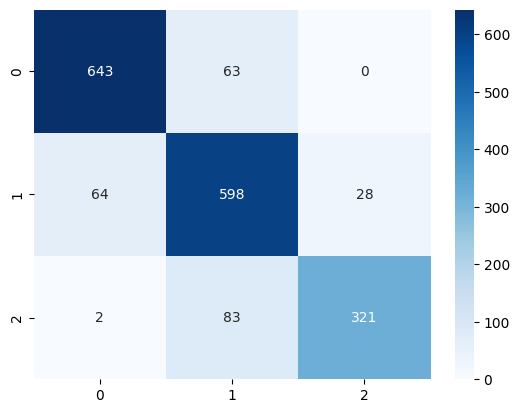

In [ ]:
# give precision and recall and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

labels_test = np.array(labels_test).ravel()  # Ensure y is 1D
label_encoder = LabelEncoder()
label_encoder.fit(labels_test)

X_test = df_test
y_test = label_encoder.transform(labels_test)


# Predict and Evaluate
y_pred = clf.predict(X_test.values)
y_pred = y_pred.astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"TabNet Classifier Accuracy {accuracy:.4f}")


# Get precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Print results
class_labels = ["CN", "MCI", "AD"]
for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print("-" * 30)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


In [ ]:
# Extract TP, TN, FP, FN for each class
sensitivity = {}  # Recall per class
specificity = {}  # Specificity per class

for i, label in enumerate(clf.classes_):
    TP = cm[i, i]  # True Positives
    FN = sum(cm[i, :]) - TP  # False Negatives
    FP = sum(cm[:, i]) - TP  # False Positives
    TN = sum(sum(cm)) - (TP + FN + FP)  # True Negatives

    sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall
    specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity

# Print results
for label in clf.classes_:
    print(f"Class: {label}")
    print(f"  Sensitivity (Recall): {sensitivity[label]:.4f}")
    print(f"  Specificity: {specificity[label]:.4f}")
    print("-" * 30)

Class: 0
  Sensitivity (Recall): 0.9108
  Specificity: 0.9398
------------------------------
Class: 1
  Sensitivity (Recall): 0.8667
  Specificity: 0.8687
------------------------------
Class: 2
  Sensitivity (Recall): 0.7906
  Specificity: 0.9799
------------------------------


In [ ]:
# calc overall sensitivity and overall specificity
overall_sensitivity = sum(sensitivity.values()) / len(sensitivity)
overall_specificity = sum(specificity.values()) / len(specificity)

print(f"Overall Sensitivity (Recall): {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")



Overall Sensitivity (Recall): 0.8560
Overall Specificity: 0.9295


In [ ]:
# save model
clf.save_model("/content/tabnet_mmse_cdglobal_cdrsb_new_data")

Successfully saved model at /content/tabnet_mmse_cdglobal_cdrsb_new_data.zip


'/content/tabnet_mmse_cdglobal_cdrsb_new_data.zip'